## Camera Selection

In [1]:
import scipy.io as spio
#from __future__ import print_function

import numpy as np
import os

from IPython.display import clear_output
from IPython import display

import matplotlib.pyplot as plt
#import cv2 as cv
%matplotlib inline

In [2]:
import string
import random
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.distributions import Categorical
import time, math
 
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

use_cuda = torch.cuda.is_available()

if use_cuda:
    print ('CUDA is available')
#use_cuda=False   #uncomment this if you dont want to use cuda variables

CUDA is available


In [3]:
import sys
import os
import gc
import collections
import hickle as hkl

sys.path.insert(0, '../data/')
import get_pid_train_test as db
import auxiliary as af

In [4]:
# sys.path.insert(0,'../py-MDNet/modules')
# from sample_generator import *


### For Validation

In [5]:
# Test function
def plot_current_state(ped, c,fno):
    # load image for current location
    img,bb = load_image(ped,c,fno,db_no)

    dpi = 80.0
    #figsize = (img.size[0]/dpi, img.size[1]/dpi)
    figsize = (img.shape[0]/dpi, img.shape[1]/dpi)
    fig = plt.figure(frameon=False, figsize=figsize, dpi=dpi)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)

    # get image and rect handle
    imAX = ax.imshow(img, aspect='normal')
    rect = plt.Rectangle(tuple(bb[0,:2]),bb[0,2],bb[0,3], 
        linewidth=3, edgecolor="#ff0000", zorder=1, fill=False)
    ax.add_patch(rect)

    plt.pause(.01)
    plt.draw()
    #fig.savefig(os.path.join(savefig_dir,'0000.jpg'),dpi=dpi)
    
    return imAX, rect
    
def plot_second(ped,c,curr_frame, imAX,rect):
    img,bb =  load_image(ped,c,curr_frame,db_no)
    #if np.array(img).shape[0] > 0:
    if img != []:
        imAX.set_data(img)
    #print (bb)

    #if bb.shape[0] > 0:
    if bb != []:
        rect.set_xy(bb[0,:2])
        rect.set_width(bb[0,2])
        rect.set_height(bb[0,3])
        print ('Correct camera')
    elif c!= num_camera-1:
        print ('Wrong camera')

    
    display.display(plt.gcf())
    plt.pause(1)
    plt.draw()
    #fig.savefig(os.path.join(savefig_dir,'%04d.jpg'%(i)),dpi=dpi)

def get_reward_gt(ped, curr_frame, c):
    y = afc.find_target_camera(ped,curr_frame)
    # get reward (give reward at end of episode)
    if y == num_camera-1 and y == c:
        reward = 0
    elif y == c:
        reward = 1
    else:
        reward = -1
        
    return reward,y

def get_next_step(ped,c,curr_frame, state):
    # update current state and history
    ispresent,this_state = get_state_vector(ped, c,curr_frame)
    if ispresent:
        next_state = this_state
    else:
        # use previous state
        next_state = state
    
    # get correct label from ground truth
    reward,y = get_reward_gt(ped, curr_frame,c)

    return next_state,reward,y,ispresent

def test_func(pTest, iloc='first', eloc='last', fixLoc=-1, isdebug=0, req_inc=1):
    policy_net.eval()
    rsT,accT = [],[]
    Qvalues = []
    numTrAllP = []
    
    for p in range(pTest.shape[0]): 
        reward_sum = 0
        accP = []
        inc = 1
        aaa = 1
        Qval_1p= []
        numTr = 0
        
        # load p'th person data
        ped = np.copy(pTest[p])
        # camera index and frame index starts from zero
        ped[:,0] -= 1
        ped[:,1] -= 1
        
        # Initialize with current state with start frame
        if iloc == 'first':
            startIDX = 0
        elif iloc == 'rand':
            startIDX = np.random.randint( 0,ped.shape[0]-20 )
        elif iloc == 'fix':
            startIDX = fixLoc
        if startIDX > ped.shape[0]:
            continue
        myPos = ped[startIDX,0:]
        print ('Initial position: ',myPos)
        
        curr_camera = myPos[0]
        curr_frame = myPos[1]
        
        # Initialize history variable (one-hot encoding)
        ch = np.zeros((h_len,cityflow_cam))
        occ_len = 0.01
        # Make initial state
        x_t,c_t,te_tau,r_t = make_state_vector(ped, curr_camera,curr_frame,ch,occ_len)
        prev_rt = r_t[0:4]
        #print (state.size())
        num_steps = 0
        prev_camera = curr_camera
        count_curr_c = 0
        
        if render: # show current location
            plot_current_state(ped, curr_camera,curr_frame)

            display.clear_output(wait=True)
            display.display(plt.gcf())

        # select an action from the current state
        hidden, cell = enc(torch.from_numpy(ch).float().cuda().unsqueeze(1))
        #print (x_t.size(),h_t.size(),enc_history.size())
        state_xt = torch.cat([x_t, te_tau], dim=1)
        #state = torch.cat([state_xt, hidden.detach().flatten().view(1,-1)], dim=1)
        state = torch.cat([state_xt, hidden[1,].detach()], dim=1)
        
        while(curr_frame <= ped[-1,1]): # alltime-6):
            
            if use_cuda:
                state_in = Variable(state)
                value_c = policy_net(state_in)
            else:
                state_in = Variable(state)
                value_c = policy_net(state_in)
                
            # Only exploitation for testing
            camera_index = torch.argmax(value_c)
            c = camera_index.detach().cpu().numpy()
            
            occ_max_val = 12000000
            aaa += 1
            if aaa > 1 and occ_len > occ_max_val:
                c = c #np.array(num_camera-1)
            if occ_len > occ_max_val and aaa%50 == 0:
                aaa = 1
                c = np.array(np.random.randint(num_camera))

            # find target for the next frame
            curr_frame += fpsc
            num_steps += 1
            
            # get correct label from ground truth
            reward,y = get_reward_gt(ped, curr_frame,c)
            #if req_inc:
            if inc==1 and y!=num_camera-1:
                # inside a camera
                if req_inc:
                    accP.append((y,y))
                    c = y
                else:
                    accP.append((y,c.item(0)))
            elif inc==0 and y==c.item(0) and y!=num_camera-1:
                # transitioning to second camera
                accP.append((y,c.item(0)))
                inc = 1
                numTr += 1
            elif inc==1 and y==num_camera-1:
                # moving out of a camera FOV
                inc = 0
                accP.append((y,c.item(0)))
            else:
                # Making transition
                accP.append((y,c.item(0)))
                #print ('Another case',y,c.item(0))
                    
            #else:
            #    accP.append((y,c.item(0)))
            
            # get the current bounding box
            bbox = ped[ np.logical_and(ped[:,0]==c,ped[:,1]==curr_frame),2:]
            if bbox.shape[0] > 0: # and np.random.rand < 0.95:
                bbox = bbox[0]
                rt = np.zeros((8))
                rt[0] = bbox[0]/320 -(np.random.rand()-0.5)/100
                rt[1] = bbox[1]/240 -(np.random.rand()-0.5)/100
                rt[2] = bbox[2]/320 -(np.random.rand()-0.5)/100
                rt[3] = bbox[3]/240 -(np.random.rand()-0.5)/100
                rt[4] = rt[0] - prev_rt[0] if occ_len < 0.2 else 0
                rt[5] = rt[1] - prev_rt[1] if occ_len < 0.2 else 0
                rt[6] = rt[2] - prev_rt[2] if occ_len < 0.2 else 0
                rt[7] = rt[3] - prev_rt[3] if occ_len < 0.2 else 0
                curr_camera = c
                
                # make next_state vector
                this_cam = afc.make_one_hot_camera(curr_camera)
                x_t = np.concatenate((this_cam, rt.ravel()))
                x_t[x_t==0] = -10
                x_t[x_t==1] = 10
                x_t = x_t.reshape(1,-1)
                if use_cuda:
                    x_t = torch.from_numpy(x_t).float().cuda()
                    
                ispresent = 1
                prev_rt = rt[0:4]
                    
            else:
                ispresent = 0
                
            # count the time of prev_camera selection
            if ispresent:
                occ_len = 0.01
            else:
                occ_len += 1
            #hcount = np.array(-occ_max_val + (occ_len/500)*(occ_max_val-(-occ_max_val)))
            hcount = np.array(10*np.log(occ_len))
            
            # update current state and history
            ch[1:,] = ch[0:-1,]
            ch[0,0:num_camera] = afc.make_one_hot_camera(c)
            ch[0,num_camera:] = 0
            
            this_cam = afc.make_one_hot_camera(c)
            c_t = this_cam.reshape(1,-1)
            
            if use_cuda:
                c_t = torch.from_numpy(c_t).float().cuda()
                te_tau = torch.from_numpy(hcount.reshape(1,-1)).float().cuda()
            else:
                c_t = torch.from_numpy(c_t).float()
                te_tau = torch.from_numpy(hcount.reshape(1,-1)).float()
                
            if isdebug:
                print ( np.where(rt.ravel()))
                print ( np.where(ch))
                print (c, curr_frame)
                print ('isPresent', ispresent)
                
            # make next_state vector
            hidden, cell = enc(torch.from_numpy(ch).float().cuda().unsqueeze(1))
            #print (x_t.size(),h_t.size(),enc_history.size())
            next_state_xt = torch.cat([x_t, te_tau], dim=1)
            #next_state = torch.cat([next_state_xt, hidden.detach().flatten().view(1,-1)], dim=1)
            next_state = torch.cat([next_state_xt, hidden[1,].detach()], dim=1)
            
            # store current reward
            reward_sum += reward
            Qval_1p.append((list(value_c.detach().cpu().numpy()[0]),hcount.ravel()[0],reward,False,y,c,state.detach().cpu().numpy()))
                        
            #state = next_state
            #state_xt = next_state_xt
            state = next_state #torch.cat([state_xt, enc_history], dim=1)
            prev_camera = c
            
            if render:
                plot_second()
            if eloc != 'last':
                if num_steps > eloc:
                    break
            
        # stack episodic reward 
        Qvalues.append((np.stack(Qval_1p)))
        rsT.append((reward_sum,num_steps))
        accT.append(accP)
        numTrAllP.append(numTr)
        
    return rsT, accT, Qvalues, numTrAllP


### Initialize hyper-parameters

In [6]:
learning_rate = 1e-4
batch_size = 1500
replay_memory_size = 20000
#epsilon = 0.1
gamma = 0.9

resume = False # resume from previous checkpoint?
render = False
eps = np.finfo(np.float32).eps.item()


In [7]:
# load dataset
db_no = 4
[pALL,num_camera,alltime,fps] = db.get_pid(set_no=db_no, train_flag='train')
num_camera += 1  # occlusion is also considered as a FOV
fpsc = 2
pALL = np.array(pALL)

# load test set for current data set
[pTest,num_camera,alltime,fps] = db.get_pid(set_no=db_no, train_flag='test')
num_camera += 1  # occlusion is also considered as a FOV
pTest = np.array(pTest)

Total number of person in data set:  (1, 49)
Total number of person in data set:  (1, 49)


In [8]:
numEpoch = 100000
d = 10
region_size = (d,d)

h_len = 10

# Load auxiliary functions using an object
afc = af.AuxiliaryFunction(num_camera=num_camera, d=d, h_len=h_len)

## Policy Model

In [9]:
# Initialize required parameters
lstm_size = 256
hidden_size1 = 4096
hidden_size2 = 2048
hidden_size3 = 256

input_size = lstm_size + num_camera+ 4*2 +1

# Required network
class NextCamera(nn.Module):
    def __init__(self):
        super(NextCamera, self).__init__()
        
        # make decoder layers
        self.fch1 = nn.Linear(input_size, hidden_size1)
        self.fch2 = nn.Linear(hidden_size1, hidden_size2)
        self.fch3 = nn.Linear(hidden_size2, hidden_size3)
        self.fco = nn.Linear(hidden_size3, num_camera)
        
        # Activation function 
        self.tanh = nn.Tanh() #ReLU()
        self.relu = nn.ReLU() #ReLU()
        #self.linear = nn.Linear() 
        
    def forward(self, x):
        
        x = self.relu(self.fch1(x))
        x = self.relu(self.fch2(x))
        x = self.relu(self.fch3(x))
        x = self.fco(x)
            
        return x # nn.functional.softmax(x)

In [10]:
# build the model
if use_cuda:
    policy_net = NextCamera().float().cuda()
    criterion = nn.MSELoss().cuda()
    
else:
    policy_net = NextCamera().float()
    criterion = nn.MSELoss()
    
if use_cuda:
    target_net = NextCamera().cuda()
    target_net.float().cuda()
target_net.load_state_dict(policy_net.state_dict())

# use ADAM as optimizer since we can load the whole data to train
optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)

In [11]:
def backward_network(replay_memory_pos,pos_prob, replay_memory_neg, replay_memory_cx, update_criteria):

    # sample random minibatch
    minibatch_pos = random.choices(replay_memory_pos, k=min(len(replay_memory_pos), 500), weights=pos_prob)
    #minibatch_pos = random.sample(replay_memory_pos, min(len(replay_memory_pos), 300)) #int(batch_size/3)))
    minibatch_posneg = minibatch_pos + random.sample(replay_memory_neg, min(len(replay_memory_neg), 500)) # int(batch_size/3)))
    minibatch = minibatch_posneg + random.sample(replay_memory_cx, min(len(replay_memory_cx), 500)) #int(batch_size/3)))
    
    # unpack minibatch
    #state_xt = tuple(d[0] for d in minibatch)
    state = torch.cat(tuple(d[0] for d in minibatch))
    #prev_ch = tuple(d[1] for d in minibatch)
    action = torch.cat(tuple(d[1] for d in minibatch))
    reward = torch.cat(tuple(d[2] for d in minibatch))
    #next_state_xt = tuple(d[4] for d in minibatch)
    next_state = torch.cat(tuple(d[3] for d in minibatch))
    #ch = tuple(d[5] for d in minibatch)
    
    # num samples of different categories
    numRew = torch.stack([torch.sum(reward>=0.2),torch.sum(reward==-1),torch.sum(reward==0.01)]).data.cpu().numpy()
    
    # get output for the next state
    next_output = target_net(next_state)

    # set y_j to r_j for terminal state, otherwise to r_j + gamma*max(Q)
    y = torch.cat(tuple(reward[i] if minibatch[i][4] \
                        else reward[i] + gamma * torch.max(next_output[i]) \
                        for i in range(len(minibatch))))

    # extract Q-value
    q_value = torch.sum(policy_net(state) * action, dim=1)

    # PyTorch accumulates gradients by default, so they need to be reset in each pass
    optimizer.zero_grad()

    # returns a new Tensor, detached from the current graph, the result will never require gradient
    y = y.detach()

    #print (y, q_value)
    # calculate loss
    loss = criterion(q_value, y)

    # do backward pass
    loss.backward()
    optimizer.step()

    # copy weights from policy_net to target_net
    if update_criteria == 10:
        target_net.load_state_dict(policy_net.state_dict())
        update_criteria = 0
    update_criteria += 1
    
    return loss.data,numRew,update_criteria

## AE Model

In [12]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [src len, batch size]
        
        embedded = src #self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
        
        outputs, (hidden, cell) = self.rnn(embedded)
        
        #outputs = [src len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #outputs are always from the top hidden layer
        
        return hidden, cell
    
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell):
        
        #input = [batch size, dim]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #n directions in the decoder will both always be 1, therefore:
        #hidden = [n layers, batch size, hid dim]
        #context = [n layers, batch size, hid dim]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size, dim]
        
        embedded = input #self.dropout(self.embedding(input))
        #embedded[np.arange(embedded.size),a] = 1
        
        #embedded = [1, batch size, emb dim]
        
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        
        #output = [seq len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #seq len and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [n layers, batch size, hid dim]
        #cell = [n layers, batch size, hid dim]
        
        prediction = self.fc_out(output.squeeze(0))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden, cell
    
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.1):
        
        #src = [src len, batch size, dim]
        #trg = [trg len, batch size, dim]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden and previous cell states
            #receive output tensor (predictions) and new hidden and cell states
            output, hidden, cell = self.decoder(input, hidden, cell)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output #.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1
        
        return outputs


In [13]:
cityflow_cam = 41
INPUT_DIM = cityflow_cam
OUTPUT_DIM = cityflow_cam
ENC_EMB_DIM = cityflow_cam
DEC_EMB_DIM = cityflow_cam
HID_DIM = 256
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT).float().cuda()
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT).float().cuda()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Seq2Seq(enc, dec, device).float().to(device)
criterion_ae = nn.CrossEntropyLoss()

In [14]:
# laod encoder model
model.load_state_dict(torch.load('tut1-model_AICity_lstmSize256_manyDB.pt'))
model.eval()

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(41, 41)
    (rnn): LSTM(41, 256, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5)
  )
  (decoder): Decoder(
    (embedding): Embedding(41, 41)
    (rnn): LSTM(41, 256, num_layers=2, dropout=0.5)
    (fc_out): Linear(in_features=256, out_features=41, bias=True)
    (dropout): Dropout(p=0.5)
  )
)

In [15]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### Run episodes

In [16]:
reward_sum = 0
running_reward = None
xs,rs,cprs = [],[],[]
episode_number = 0
episode_durations = []
episode_reward = []
validation_reward= []
replay_memory_pos = []
pos_prob = []
replay_memory_neg = []
replay_memory_cx = []
M = np.zeros((num_camera,num_camera))

In [17]:
def make_state_vector(ped, curr_camera,curr_frame, ch,occ_len):
    numSamples = 30
    overlap_thres = [0.9, 1]
        
    # read image
    img,bbox,p = afc.load_image(ped,curr_camera,curr_frame,db_no)
    imw, imh = (320,240) #img.size
    hc = np.array(10*np.log(occ_len))
    
    if p:
        rt = np.zeros((8))
        rt[0] = bbox[0]/imw -(np.random.rand()-0.5)/100
        rt[1] = bbox[1]/imh -(np.random.rand()-0.5)/100
        rt[2] = bbox[2]/imw -(np.random.rand()-0.5)/100
        rt[3] = bbox[3]/imh -(np.random.rand()-0.5)/100
        rt[4] = 0
        rt[5] = 0
        rt[6] = 0
        rt[7] = 0
        #print (np.where(rt.ravel()))
        
        # make next_state vector
        #this_cam = afc.make_one_hot_camera(curr_camera)
        #state = np.concatenate((this_cam, rt.ravel()))
        #state = np.concatenate((state, hc.ravel()))
        #state = np.concatenate((state, ch.ravel()))
        #state = state.reshape(1,-1)
        #state[state==0] = -10
        #state[state==1] = 10
        
        # make next_state vector
        this_cam = afc.make_one_hot_camera(curr_camera)
        xt = np.concatenate((this_cam, rt.ravel()))
        xt[xt==0] = -10
        xt[xt==1] = 10
        xt = xt.reshape(1,-1)
        
        # make history vector
        c_t = this_cam.reshape(1,-1)
        
        if use_cuda:
            xt = torch.from_numpy(xt).float().cuda()
            c_t = torch.from_numpy(c_t).float().cuda()
            hc = torch.from_numpy(hc.reshape(1,-1)).float().cuda()
        else:
            xt = torch.from_numpy(xt).float()
            c_t = torch.from_numpy(c_t).float()
            hc = torch.from_numpy(hc.reshape(1,-1)).float()
    else:
        print ('Target is not present in ',c,curr_frame)
        xt,h_t = [],[]
    
    return xt,c_t,hc,rt #p,state,rt

def append_reward(rs,num_steps):
    if len(rs) > 0:
        # stack episodic reward 
        epR = np.vstack(rs)
        rs = []

        # append the episodic reward
        #episode_number += 1
        #episode_durations.append(num_steps)
        reward_stat = [num_steps,np.std(epR),np.sum(epR)]
        episode_reward.append(reward_stat)
    
    return rs

def reinit_ae(ch):
    # Initialize history variable (one-hot encoding)
    if use_cuda:
        ch = torch.from_numpy(ch).float().cuda()
        enc_h = torch.zeros(1,lstm_size).float().cuda()
        enc_c = torch.zeros(1,lstm_size).float().cuda()
    else:
        enc_h = torch.zeros(1,lstm_size).float()
        enc_c = torch.zeros(1,lstm_size).float()
        
    # encode whole camera history
    for i in range(seq_len-1,-1,-1):
        #print (ch[i,:])
        x = ch[i,:].view(1,-1)
        h_lstm,enc = ae_enc((enc_h,enc_c), x)
        (enc_h,enc_c) = h_lstm

    return h_lstm,enc

In [18]:
epoch = 0
occ_max_val = 100

In [19]:
EpData = []
allEpData = []
numRew=[]

numUpdateRew=[]
update_criteria = 0
episode_count = 0
steps_count = 0
initialEpsilon = 0.170962 #0.2
finalEpsilon = 0.01
epsilon = initialEpsilon

In [20]:
trExplored = {}
for i in range(num_camera):
    for j in range(num_camera):
        trExplored[str(i)+'-'+str(j)] = []

In [21]:
resume = False
if resume:
    epoch = 600
    epsilon = 0.170962
    aaa = np.load('./EpData/.npy', allow_pickle=True)
    episode_count = aaa[2]
    steps_count = aaa[3]
    episode_reward_pre = aaa[0]
    validation_reward_pre = aaa[1]
    policy_net.load_state_dict(torch.load('./models/')['state_dict'])

In [28]:
max_ep_len = 200
seq_len = 20
h_len = seq_len

while epoch < numEpoch:
#for epoch in range(numEpoch):
    # repeat for all pedestrians
    #disp(pALL)
    
    policy_net.train()
    
    for p in range(pALL.shape[0]): #range(pInLoop.shape[0])
        
        # load p'th person data
        ped = np.copy(pALL[p])

        # camera index and frame index starts from zero
        ped[:,0] -= 1
        ped[:,1] -= 1
        #print (np.unique(ped[:,0]))
        
        # check if camera number is correct
        if (ped[:,0] >= num_camera).any():
            print ('Error in person ', p)
            break
            
        if ped.shape[0] < max_ep_len/5:
            continue
        
        # select a camera uniformly
        uniq_cam = np.unique(ped[:,0])
        if len(uniq_cam) < 2 and np.random.rand() > 0.4:
            if len(np.where(ped[1:,1]-ped[0:-1,1] != 1)[0]) == 0:
                continue
        rand_cam = uniq_cam[np.random.randint(len(uniq_cam))]
        index_of_rand_cam = np.nonzero( ped[:,0]==rand_cam )[0]
        len_indices_rand_cam = len(index_of_rand_cam)
        
        # Initialize with current state with start frame
        tranIDX = np.where(ped[1:,0]-ped[0:-1,0])[0]
        if len(uniq_cam) < 2 or np.random.rand() < 0.4:
            startIDX = np.random.randint( 0,int(ped.shape[0]-ped.shape[0]/2) )
        else:
            startIDX = np.random.choice(tranIDX)-20
        #startIDX = np.random.choice(tranIDX)-20 if np.random.rand(1) < 0.6 else np.random.randint( 0,ped.shape[0]-max_ep_len/2 )
        #startIDX = index_of_rand_cam[np.random.randint(len_indices_rand_cam/10)]
        myPos = ped[startIDX,0:]
        #print (myPos)
        
        curr_camera = myPos[0]
        curr_frame = myPos[1]
        
        # Initialize history variable (one-hot encoding)
        ch = np.zeros((h_len,cityflow_cam))
        prev_ch = ch
        
        # initialize total time target was occluded
        num_steps = 0
        occ_len = 0.01
        hcount = np.array(10*np.log(occ_len))
        CDataEp = []
        inCDataEp = []
        EpData = []
        episodic_seq = []
        
        # create initial state (ct,rt,tau_t)
        #bbox = myPos[2:]
        #rt = afc.find_curr_rt(bbox)
        x_t,c_t,te_tau,r_t = make_state_vector(ped, curr_camera,curr_frame,ch,occ_len)
        prev_rt = r_t[0:4]
        stCam = curr_camera
        expStC = curr_camera
        count_curr_c = 0
        prev_camera = curr_camera

        if render: # show current location
            plt.imshow(x.reshape(input_size))
            display.clear_output(wait=True)
            display.display(plt.gcf())
        episode_count += 1
        if epsilon > finalEpsilon:
            epsilon -= (initialEpsilon - finalEpsilon)/20000
        
        # select an action from the current state
        hidden, cell = enc(torch.from_numpy(ch).float().cuda().unsqueeze(1))
        #print (x_t.size(),h_t.size(),enc_history.size())
        state_xt = torch.cat([x_t, te_tau], dim=1)
        #state = torch.cat([state_xt, hidden.detach().flatten().view(1,-1)], dim=1)
        state = torch.cat([state_xt, hidden[1,].detach()], dim=1)
        #print ('State size: ', state.size())
        
        while(curr_frame <= ped[-1,1]):
        
            state_in = Variable(state)
            value_c = policy_net(state_in)

            steps_count += 1
            
            # generate random steps
            if np.random.rand(1) < 0.01:
                rsteps = np.random.randint(fpsc,20,1)
            else:
                rsteps = 1
            curr_frame += rsteps*fpsc if rsteps > 1 else fpsc
            num_steps += 1
                
            # initialize action
            one_hot_action = torch.zeros([num_camera], dtype=torch.float32)
            if use_cuda:  # put on GPU if CUDA is available
                one_hot_action = one_hot_action.cuda()

            # epsilon greedy exploration
            random_action = np.random.random() <= epsilon
            camera_index = [torch.randint(num_camera, torch.Size([]), dtype=torch.int)
                           if random_action else torch.argmax(value_c)][0]
            
            if use_cuda:  # put on GPU if CUDA is available
                camera_index = camera_index.cuda()

            one_hot_action[camera_index] = 1
            one_hot_action = one_hot_action.unsqueeze(0)
            c = camera_index.detach().cpu().numpy()
            
            # Store the transition explored
            #M[stCam,c] += 1
            
            # get the current bounding box
            bbox = ped[ np.logical_and(ped[:,0]==c,ped[:,1]==curr_frame),2:]
            if bbox.shape[0] > 0:
                #rt = afc.find_curr_rt(bbox[0]) 
                bbox = bbox[0]
                rt = np.zeros((8))
                rt[0] = bbox[0]/320 -(np.random.rand()-0.5)/100
                rt[1] = bbox[1]/240 -(np.random.rand()-0.5)/100
                rt[2] = bbox[2]/320 -(np.random.rand()-0.5)/100
                rt[3] = bbox[3]/240 -(np.random.rand()-0.5)/100
                rt[4] = rt[0] - prev_rt[0] if occ_len < 0.2 else 0
                rt[5] = rt[1] - prev_rt[1] if occ_len < 0.2 else 0
                rt[6] = rt[2] - prev_rt[2] if occ_len < 0.2 else 0
                rt[7] = rt[3] - prev_rt[3] if occ_len < 0.2 else 0
                
                curr_camera = c
                # make next_state vector
                this_cam = afc.make_one_hot_camera(curr_camera)
                x_t = np.concatenate((this_cam, rt.ravel()))
                x_t[x_t==0] = -10
                x_t[x_t==1] = 10
                x_t = x_t.reshape(1,-1)
                if use_cuda:
                    x_t = torch.from_numpy(x_t).float().cuda()
                
                #num_steps = 0
                ispresent = 1
                stCam = c
                
                prev_rt = rt[0:4]
            else:
                ispresent = 0
            
            #if ispresent and expStC != num_camera-1 and c != num_camera-1:
            #    trExplored[str(expStC)+'-'+str(c)].append(occ_len)
            #    expStC = c
            
            # get correct label from ground truth
            y = afc.find_target_camera(ped, curr_frame)
            # get reward (give reward at end of episode)
            if y == num_camera-1 and y == c:
                reward = 0.01
            elif y == c and occ_len< 20:
                reward = 0.5
                wt = 1
            elif y == c:
                reward = 1
                wt = 10
            else:
                reward = -1
            reward_sum += reward
            rs.append(reward)
            EpData.append((list(value_c.detach().cpu().numpy()[0]),hcount.ravel()[0],reward,random_action,y,c,episode_reward))
            
            #print (np.array([rt, ispresent,c]))
            ######################## prepare the next state  #############################
            # count the time of prev_camera selection
            if ispresent:
                occ_len = 0.01
            else:
                occ_len += rsteps
            #hcount = np.array(-occ_max_val + (occ_len/500)*(occ_max_val-(-occ_max_val)))
            hcount = np.array(10*np.log(occ_len))
            
            # get next camera using policy network
            this_cam = afc.make_one_hot_camera(c)
            c_t = this_cam.reshape(1,-1)
            
            # update current state and history
            prev_ch = ch
            ch[1:,] = ch[0:-1,]
            ch[0,0:num_camera] = afc.make_one_hot_camera(c)
            ch[0,num_camera:] = 0
            
            if use_cuda:
                c_t = torch.from_numpy(c_t).float().cuda()
                te_tau = torch.from_numpy(hcount.reshape(1,-1)).float().cuda()
            else:
                c_t = torch.from_numpy(c_t).float()
                te_tau = torch.from_numpy(hcount.reshape(1,-1)).float()
            episodic_seq.append((c_t))
            
            # make next_state vector
            hidden, cell = enc(torch.from_numpy(ch).float().cuda().unsqueeze(1))
            #print (x_t.size(),h_t.size(),enc_history.size())
            next_state_xt = torch.cat([x_t, te_tau], dim=1)
            #next_state = torch.cat([next_state_xt, hidden.detach().flatten().view(1,-1)], dim=1)
            next_state = torch.cat([next_state_xt, hidden[1,].detach()], dim=1)
            
            if use_cuda:
                reward = torch.from_numpy(np.array([reward], dtype=np.float32)).unsqueeze(0).cuda()
            else:
                reward = torch.from_numpy(np.array([reward], dtype=np.float32)).unsqueeze(0)
            
            #replay_memory.append((state_xt,prev_ch, one_hot_action, reward, next_state_xt,ch, ispresent))
            
            # save transition to replay memory
            if reward > 0.2:
                #replay_memory_pos.append((state_xt,prev_ch, one_hot_action, reward, next_state_xt,ch, ispresent))
                replay_memory_pos.append((state, one_hot_action, reward, next_state, ispresent))
                pos_prob.append(wt)
            elif reward == 0.01:
                #replay_memory_cx.append((state_xt,prev_ch, one_hot_action, reward, next_state_xt,ch, ispresent))
                replay_memory_cx.append((state, one_hot_action, reward, next_state, ispresent))
            else:
                #replay_memory_neg.append((state_xt,prev_ch, one_hot_action, reward, next_state_xt,ch, ispresent))
                replay_memory_neg.append((state, one_hot_action, reward, next_state, ispresent))
            
            # if replay memory is full, remove the oldest transition
            if len(replay_memory_pos) > replay_memory_size:
                replay_memory_pos.pop(0)
                pos_prob.pop(0)
            if len(replay_memory_neg) > replay_memory_size:
                replay_memory_neg.pop(0)
            if len(replay_memory_cx) > replay_memory_size:
                replay_memory_cx.pop(0)
            
            #state_xt = next_state_xt
            state = next_state #torch.cat([state_xt, hidden.detach()], dim=1)
            #state = torch.cat([next_state_xt, enc_history], dim=1)
            prev_camera = c
            
            if num_steps >= max_ep_len and y!=num_camera-1 and y==c:  # break the episode
                #print ('')
                #print (epoch, p, random_action, rsteps)
                #print ('x_t: ', c,rt)
                ##print ( np.where(ch)[1])
                #print ('Q values: ', value_c)
                #print (y,c, curr_frame,ped[-1,1], num_steps, hcount)
                #print ('isPresent', ispresent)
                #print ('Pos Replay length: ', len(replay_memory_pos))
                
                #print (pos_prob[:])
                break
        
        # update value_function
        loss,rrr,update_criteria = backward_network(replay_memory_pos, pos_prob[:], replay_memory_neg,replay_memory_cx, update_criteria)
        numUpdateRew.append(rrr)
        if np.random.rand() < 0.05:
            allEpData.append((np.stack(EpData)))
        
        # store episodic reward
        #numRew.append((sum(np.stack(rs)==100),sum(np.stack(rs)==-100),sum(np.stack(rs)==0.1)))
        rs = append_reward(rs,num_steps)
        
        # boring book-keeping
        running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
        print ('ep %d: ep_len:%d episode reward: total was %f. running mean: %f' % (epoch, num_steps, reward_sum, running_reward))
        reward_sum = 0
        num_steps = 0
        rs = []
    
    if epoch % 20 == 100000: # test on validation set
        _,accV,qv,numTR = test_func(pTest[1:2],iloc='first',eloc='last')
        av = np.stack(accV[0])
        av = sum(av[av[:,0]!=(num_camera-1),0] == av[av[:,0]!=(num_camera-1),1])/sum(av[:,0]!=(num_camera-1))
        validation_reward.append((qv,av,numTR)) 
    #print (M)
    epoch += 1
    print ('epsilon:%f episode_count: %d. steps_count: %f' % (epsilon, episode_count,steps_count))
    if epoch % 50 == 1: 
        torch.save({'state_dict': policy_net.state_dict()}, './models/policy_MM_db4_seq20_'+str(epoch))
    #if epoch %200 == 100:
    #    np.save('./EpData/allEpData_ECCV_db4_pretrAE_seq50_rp20K_'+str(epoch),np.array(allEpData),allow_pickle=True)
    #    np.save('./EpData/episode_reward_ECCV_db4_pretrAE_seq50_rp20K_'+str(epoch), (episode_reward,validation_reward,epsilon,episode_count, steps_count,running_reward))
    allEpData = []

ep 1544: ep_len:1190 episode reward: total was -35.810000. running mean: -12.233972
ep 1544: ep_len:500 episode reward: total was 4.900000. running mean: -12.062632
ep 1544: ep_len:53 episode reward: total was 23.500000. running mean: -11.707006
ep 1544: ep_len:2930 episode reward: total was -73.310000. running mean: -12.323036
ep 1544: ep_len:808 episode reward: total was -15.930000. running mean: -12.359105
ep 1544: ep_len:43 episode reward: total was 20.000000. running mean: -12.035514
ep 1544: ep_len:607 episode reward: total was 32.690000. running mean: -11.588259
ep 1544: ep_len:347 episode reward: total was 19.110000. running mean: -11.281277
ep 1544: ep_len:710 episode reward: total was -21.770000. running mean: -11.386164
ep 1544: ep_len:736 episode reward: total was 13.200000. running mean: -11.140302
ep 1544: ep_len:893 episode reward: total was 29.640000. running mean: -10.732499
ep 1544: ep_len:183 episode reward: total was 90.000000. running mean: -9.725174
ep 1544: ep_le

ep 1550: ep_len:1103 episode reward: total was -3.280000. running mean: -11.956362
ep 1550: ep_len:742 episode reward: total was -30.060000. running mean: -12.137398
ep 1550: ep_len:77 episode reward: total was 37.000000. running mean: -11.646024
ep 1550: ep_len:2972 episode reward: total was -55.690000. running mean: -12.086464
ep 1550: ep_len:500 episode reward: total was -48.260000. running mean: -12.448200
ep 1550: ep_len:59 episode reward: total was 28.000000. running mean: -12.043718
ep 1550: ep_len:642 episode reward: total was 1.200000. running mean: -11.911280
ep 1550: ep_len:3662 episode reward: total was -94.470000. running mean: -12.736868
ep 1550: ep_len:602 episode reward: total was -10.310000. running mean: -12.712599
ep 1550: ep_len:850 episode reward: total was 10.770000. running mean: -12.477773
ep 1550: ep_len:669 episode reward: total was 2.480000. running mean: -12.328195
ep 1550: ep_len:716 episode reward: total was -42.500000. running mean: -12.629913
ep 1550: ep

ep 1556: ep_len:634 episode reward: total was 12.360000. running mean: -7.013444
ep 1556: ep_len:600 episode reward: total was 43.540000. running mean: -6.507910
ep 1556: ep_len:149 episode reward: total was 71.500000. running mean: -5.727831
ep 1556: ep_len:1499 episode reward: total was 29.850000. running mean: -5.372052
ep 1556: ep_len:2812 episode reward: total was -17.900000. running mean: -5.497332
epsilon:0.009992 episode_count: 23491. steps_count: 25121951.000000
ep 1557: ep_len:1128 episode reward: total was -3.520000. running mean: -5.477559
ep 1557: ep_len:1277 episode reward: total was -26.790000. running mean: -5.690683
ep 1557: ep_len:42 episode reward: total was 18.000000. running mean: -5.453776
ep 1557: ep_len:2971 episode reward: total was -17.310000. running mean: -5.572338
ep 1557: ep_len:744 episode reward: total was 29.550000. running mean: -5.221115
ep 1557: ep_len:38 episode reward: total was 17.500000. running mean: -4.993904
ep 1557: ep_len:116 episode reward:

ep 1563: ep_len:646 episode reward: total was -8.260000. running mean: -50.600386
ep 1563: ep_len:153 episode reward: total was 75.000000. running mean: -49.344382
ep 1563: ep_len:625 episode reward: total was -0.990000. running mean: -48.860839
ep 1563: ep_len:3773 episode reward: total was -27.050000. running mean: -48.642730
ep 1563: ep_len:1569 episode reward: total was -167.430000. running mean: -49.830603
ep 1563: ep_len:909 episode reward: total was 63.660000. running mean: -48.695697
ep 1563: ep_len:568 episode reward: total was -1.560000. running mean: -48.224340
ep 1563: ep_len:96 episode reward: total was 22.010000. running mean: -47.521996
ep 1563: ep_len:643 episode reward: total was 11.260000. running mean: -46.934176
ep 1563: ep_len:46 episode reward: total was 21.500000. running mean: -46.249835
epsilon:0.009992 episode_count: 23591. steps_count: 25235580.000000
ep 1564: ep_len:1436 episode reward: total was 2.130000. running mean: -45.766036
ep 1564: ep_len:699 episode

ep 1569: ep_len:2892 episode reward: total was -8.310000. running mean: -32.190144
epsilon:0.009992 episode_count: 23677. steps_count: 25341663.000000
ep 1570: ep_len:3653 episode reward: total was -907.990000. running mean: -40.948143
ep 1570: ep_len:709 episode reward: total was -23.010000. running mean: -40.768762
ep 1570: ep_len:3080 episode reward: total was -40.830000. running mean: -40.769374
ep 1570: ep_len:1477 episode reward: total was 15.790000. running mean: -40.203780
ep 1570: ep_len:87 episode reward: total was 40.500000. running mean: -39.396742
ep 1570: ep_len:83 episode reward: total was 38.500000. running mean: -38.617775
ep 1570: ep_len:1117 episode reward: total was -12.230000. running mean: -38.353897
ep 1570: ep_len:3693 episode reward: total was -127.730000. running mean: -39.247658
ep 1570: ep_len:1239 episode reward: total was -83.210000. running mean: -39.687282
ep 1570: ep_len:841 episode reward: total was 50.690000. running mean: -38.783509
ep 1570: ep_len:9

ep 1576: ep_len:667 episode reward: total was -17.430000. running mean: -34.345303
ep 1576: ep_len:3027 episode reward: total was -6.270000. running mean: -34.064550
ep 1576: ep_len:500 episode reward: total was 3.490000. running mean: -33.689005
ep 1576: ep_len:65 episode reward: total was 31.000000. running mean: -33.042114
ep 1576: ep_len:1504 episode reward: total was -221.950000. running mean: -34.931193
ep 1576: ep_len:3646 episode reward: total was -60.290000. running mean: -35.184781
ep 1576: ep_len:756 episode reward: total was -71.550000. running mean: -35.548434
ep 1576: ep_len:842 episode reward: total was 35.950000. running mean: -34.833449
ep 1576: ep_len:895 episode reward: total was 4.620000. running mean: -34.438915
ep 1576: ep_len:976 episode reward: total was -96.070000. running mean: -35.055226
ep 1576: ep_len:2817 episode reward: total was 4.900000. running mean: -34.655673
epsilon:0.009992 episode_count: 23781. steps_count: 25473374.000000
ep 1577: ep_len:1154 epi

ep 1583: ep_len:826 episode reward: total was -28.270000. running mean: -23.089377
ep 1583: ep_len:701 episode reward: total was -53.990000. running mean: -23.398383
ep 1583: ep_len:47 episode reward: total was 22.000000. running mean: -22.944399
ep 1583: ep_len:3064 episode reward: total was -2415.720000. running mean: -46.872155
ep 1583: ep_len:1449 episode reward: total was 19.800000. running mean: -46.205434
ep 1583: ep_len:97 episode reward: total was 47.000000. running mean: -45.273379
ep 1583: ep_len:47 episode reward: total was 22.000000. running mean: -44.600646
ep 1583: ep_len:1054 episode reward: total was -65.380000. running mean: -44.808439
ep 1583: ep_len:643 episode reward: total was 21.050000. running mean: -44.149855
ep 1583: ep_len:516 episode reward: total was -33.390000. running mean: -44.042256
ep 1583: ep_len:712 episode reward: total was 41.280000. running mean: -43.189034
ep 1583: ep_len:1540 episode reward: total was -6.320000. running mean: -42.820343
ep 1583:

ep 1589: ep_len:500 episode reward: total was 26.830000. running mean: -27.302322
ep 1589: ep_len:35 episode reward: total was 16.000000. running mean: -26.869299
ep 1589: ep_len:66 episode reward: total was 31.500000. running mean: -26.285606
ep 1589: ep_len:640 episode reward: total was -2.510000. running mean: -26.047850
ep 1589: ep_len:2788 episode reward: total was -24.780000. running mean: -26.035171
ep 1589: ep_len:48 episode reward: total was 22.500000. running mean: -25.549819
epsilon:0.009992 episode_count: 23966. steps_count: 25687344.000000
ep 1590: ep_len:1136 episode reward: total was -18.470000. running mean: -25.479021
ep 1590: ep_len:775 episode reward: total was -3.530000. running mean: -25.259531
ep 1590: ep_len:49 episode reward: total was 20.000000. running mean: -24.806936
ep 1590: ep_len:2992 episode reward: total was -16.180000. running mean: -24.720666
ep 1590: ep_len:828 episode reward: total was -20.660000. running mean: -24.680060
ep 1590: ep_len:146 episode

ep 1596: ep_len:623 episode reward: total was -0.180000. running mean: -31.945095
ep 1596: ep_len:132 episode reward: total was 64.500000. running mean: -30.980644
ep 1596: ep_len:1421 episode reward: total was -296.030000. running mean: -33.631137
ep 1596: ep_len:3786 episode reward: total was -183.530000. running mean: -35.130126
ep 1596: ep_len:865 episode reward: total was -27.880000. running mean: -35.057625
ep 1596: ep_len:781 episode reward: total was -8.580000. running mean: -34.792848
ep 1596: ep_len:664 episode reward: total was 0.650000. running mean: -34.438420
ep 1596: ep_len:62 episode reward: total was 29.500000. running mean: -33.799036
ep 1596: ep_len:606 episode reward: total was -7.790000. running mean: -33.538945
ep 1596: ep_len:2904 episode reward: total was -75.060000. running mean: -33.954156
ep 1596: ep_len:38 episode reward: total was 16.000000. running mean: -33.454614
epsilon:0.009992 episode_count: 24065. steps_count: 25793447.000000
ep 1597: ep_len:631 epis

ep 1602: ep_len:128 episode reward: total was 61.000000. running mean: -16.441846
ep 1602: ep_len:1066 episode reward: total was 10.580000. running mean: -16.171628
ep 1602: ep_len:2775 episode reward: total was -16.860000. running mean: -16.178512
ep 1602: ep_len:35 episode reward: total was 16.000000. running mean: -15.856727
epsilon:0.009992 episode_count: 24153. steps_count: 25890913.000000
ep 1603: ep_len:1144 episode reward: total was 5.460000. running mean: -15.643559
ep 1603: ep_len:737 episode reward: total was -27.980000. running mean: -15.766924
ep 1603: ep_len:61 episode reward: total was 27.500000. running mean: -15.334255
ep 1603: ep_len:3024 episode reward: total was -19.470000. running mean: -15.375612
ep 1603: ep_len:574 episode reward: total was -14.630000. running mean: -15.368156
ep 1603: ep_len:59 episode reward: total was 26.500000. running mean: -14.949474
ep 1603: ep_len:500 episode reward: total was 22.570000. running mean: -14.574280
ep 1603: ep_len:682 episod

ep 1609: ep_len:1658 episode reward: total was -53.680000. running mean: -35.679874
ep 1609: ep_len:30 episode reward: total was 12.000000. running mean: -35.203075
ep 1609: ep_len:58 episode reward: total was 27.500000. running mean: -34.576044
ep 1609: ep_len:684 episode reward: total was 0.530000. running mean: -34.224984
ep 1609: ep_len:3717 episode reward: total was -10.090000. running mean: -33.983634
ep 1609: ep_len:1168 episode reward: total was -63.170000. running mean: -34.275498
ep 1609: ep_len:794 episode reward: total was 21.010000. running mean: -33.722643
ep 1609: ep_len:499 episode reward: total was 42.710000. running mean: -32.958316
ep 1609: ep_len:912 episode reward: total was 11.430000. running mean: -32.514433
ep 1609: ep_len:2929 episode reward: total was 2.900000. running mean: -32.160289
ep 1609: ep_len:58 episode reward: total was 26.000000. running mean: -31.578686
epsilon:0.009992 episode_count: 24254. steps_count: 25998745.000000
ep 1610: ep_len:646 episode 

ep 1615: ep_len:132 episode reward: total was 63.000000. running mean: -17.264078
ep 1615: ep_len:620 episode reward: total was 2.600000. running mean: -17.065437
ep 1615: ep_len:2777 episode reward: total was -3.650000. running mean: -16.931283
epsilon:0.009992 episode_count: 24341. steps_count: 26095832.000000
ep 1616: ep_len:1201 episode reward: total was 23.700000. running mean: -16.524970
ep 1616: ep_len:779 episode reward: total was -3.240000. running mean: -16.392121
ep 1616: ep_len:72 episode reward: total was 33.000000. running mean: -15.898199
ep 1616: ep_len:3053 episode reward: total was -20.220000. running mean: -15.941417
ep 1616: ep_len:1126 episode reward: total was -1.030000. running mean: -15.792303
ep 1616: ep_len:48 episode reward: total was 19.500000. running mean: -15.439380
ep 1616: ep_len:1657 episode reward: total was -390.630000. running mean: -19.191286
ep 1616: ep_len:3973 episode reward: total was -85.280000. running mean: -19.852174
ep 1616: ep_len:559 epi

ep 1622: ep_len:500 episode reward: total was -0.860000. running mean: -16.488611
ep 1622: ep_len:723 episode reward: total was -26.670000. running mean: -16.590425
ep 1622: ep_len:3008 episode reward: total was -41.140000. running mean: -16.835921
ep 1622: ep_len:500 episode reward: total was -3.090000. running mean: -16.698461
ep 1622: ep_len:41 episode reward: total was 19.000000. running mean: -16.341477
ep 1622: ep_len:130 episode reward: total was 62.000000. running mean: -15.558062
ep 1622: ep_len:54 episode reward: total was 24.000000. running mean: -15.162481
ep 1622: ep_len:1022 episode reward: total was -30.320000. running mean: -15.314057
ep 1622: ep_len:298 episode reward: total was 22.200000. running mean: -14.938916
ep 1622: ep_len:889 episode reward: total was -31.680000. running mean: -15.106327
ep 1622: ep_len:623 episode reward: total was 12.220000. running mean: -14.833064
ep 1622: ep_len:500 episode reward: total was 8.850000. running mean: -14.596233
ep 1622: ep_l

ep 1628: ep_len:749 episode reward: total was -13.370000. running mean: -7.685960
ep 1628: ep_len:651 episode reward: total was 19.540000. running mean: -7.413700
ep 1628: ep_len:564 episode reward: total was -27.860000. running mean: -7.618163
ep 1628: ep_len:780 episode reward: total was 15.330000. running mean: -7.388682
ep 1628: ep_len:699 episode reward: total was -2.480000. running mean: -7.339595
ep 1628: ep_len:62 episode reward: total was 28.000000. running mean: -6.986199
ep 1628: ep_len:1204 episode reward: total was 17.700000. running mean: -6.739337
ep 1628: ep_len:35 episode reward: total was 16.000000. running mean: -6.511943
epsilon:0.009992 episode_count: 24536. steps_count: 26301199.000000
ep 1629: ep_len:615 episode reward: total was 22.900000. running mean: -6.217824
ep 1629: ep_len:687 episode reward: total was -14.510000. running mean: -6.300746
ep 1629: ep_len:72 episode reward: total was 34.500000. running mean: -5.892738
ep 1629: ep_len:2980 episode reward: tot

ep 1635: ep_len:953 episode reward: total was -79.250000. running mean: -5.202952
ep 1635: ep_len:1621 episode reward: total was -83.240000. running mean: -5.983323
ep 1635: ep_len:70 episode reward: total was 33.500000. running mean: -5.588490
ep 1635: ep_len:3027 episode reward: total was -24.120000. running mean: -5.773805
ep 1635: ep_len:1227 episode reward: total was -28.300000. running mean: -5.999067
ep 1635: ep_len:31 episode reward: total was 14.000000. running mean: -5.799076
ep 1635: ep_len:857 episode reward: total was 17.180000. running mean: -5.569285
ep 1635: ep_len:3568 episode reward: total was -57.730000. running mean: -6.090892
ep 1635: ep_len:3143 episode reward: total was -590.440000. running mean: -11.934383
ep 1635: ep_len:776 episode reward: total was 32.950000. running mean: -11.485540
ep 1635: ep_len:586 episode reward: total was -7.870000. running mean: -11.449384
ep 1635: ep_len:168 episode reward: total was 79.500000. running mean: -10.539890
ep 1635: ep_le

ep 1641: ep_len:643 episode reward: total was 5.670000. running mean: -9.436183
ep 1641: ep_len:360 episode reward: total was 16.210000. running mean: -9.179721
ep 1641: ep_len:536 episode reward: total was -25.110000. running mean: -9.339024
ep 1641: ep_len:792 episode reward: total was 4.700000. running mean: -9.198634
ep 1641: ep_len:643 episode reward: total was -17.980000. running mean: -9.286447
ep 1641: ep_len:2500 episode reward: total was -167.070000. running mean: -10.864283
ep 1641: ep_len:2848 episode reward: total was -11.110000. running mean: -10.866740
epsilon:0.009992 episode_count: 24727. steps_count: 26503345.000000
ep 1642: ep_len:727 episode reward: total was -4.550000. running mean: -10.803573
ep 1642: ep_len:738 episode reward: total was -9.960000. running mean: -10.795137
ep 1642: ep_len:90 episode reward: total was 43.500000. running mean: -10.252186
ep 1642: ep_len:598 episode reward: total was -12.280000. running mean: -10.272464
ep 1642: ep_len:40 episode rew

ep 1647: ep_len:110 episode reward: total was 53.500000. running mean: -6.989236
ep 1647: ep_len:650 episode reward: total was 21.950000. running mean: -6.699844
ep 1647: ep_len:3805 episode reward: total was -464.180000. running mean: -11.274645
ep 1647: ep_len:742 episode reward: total was -55.960000. running mean: -11.721499
ep 1647: ep_len:812 episode reward: total was 16.810000. running mean: -11.436184
ep 1647: ep_len:1109 episode reward: total was -2.210000. running mean: -11.343922
ep 1647: ep_len:155 episode reward: total was 74.500000. running mean: -10.485483
ep 1647: ep_len:54 episode reward: total was 24.000000. running mean: -10.140628
ep 1647: ep_len:126 episode reward: total was 55.500000. running mean: -9.484222
ep 1647: ep_len:697 episode reward: total was -66.930000. running mean: -10.058680
ep 1647: ep_len:2832 episode reward: total was -7.140000. running mean: -10.029493
epsilon:0.009992 episode_count: 24826. steps_count: 26598272.000000
ep 1648: ep_len:1131 episod

ep 1653: ep_len:57 episode reward: total was 27.000000. running mean: -5.484749
ep 1653: ep_len:83 episode reward: total was 40.000000. running mean: -5.029901
ep 1653: ep_len:670 episode reward: total was 20.190000. running mean: -4.777702
ep 1653: ep_len:2835 episode reward: total was -20.730000. running mean: -4.937225
ep 1653: ep_len:61 episode reward: total was 29.000000. running mean: -4.597853
epsilon:0.009992 episode_count: 24916. steps_count: 26692673.000000
ep 1654: ep_len:765 episode reward: total was -71.300000. running mean: -5.264875
ep 1654: ep_len:680 episode reward: total was -44.100000. running mean: -5.653226
ep 1654: ep_len:45 episode reward: total was 19.500000. running mean: -5.401694
ep 1654: ep_len:3081 episode reward: total was -54.470000. running mean: -5.892377
ep 1654: ep_len:867 episode reward: total was 17.280000. running mean: -5.660653
ep 1654: ep_len:148 episode reward: total was 72.500000. running mean: -4.879046
ep 1654: ep_len:500 episode reward: tot

ep 1660: ep_len:681 episode reward: total was -14.570000. running mean: -13.482737
ep 1660: ep_len:57 episode reward: total was 27.000000. running mean: -13.077910
ep 1660: ep_len:3007 episode reward: total was -26.770000. running mean: -13.214830
ep 1660: ep_len:682 episode reward: total was -16.680000. running mean: -13.249482
ep 1660: ep_len:45 episode reward: total was 21.000000. running mean: -12.906987
ep 1660: ep_len:1318 episode reward: total was -51.170000. running mean: -13.289617
ep 1660: ep_len:634 episode reward: total was 5.320000. running mean: -13.103521
ep 1660: ep_len:1265 episode reward: total was -68.230000. running mean: -13.654786
ep 1660: ep_len:825 episode reward: total was 47.590000. running mean: -13.042338
ep 1660: ep_len:702 episode reward: total was -33.650000. running mean: -13.248415
ep 1660: ep_len:66 episode reward: total was 31.500000. running mean: -12.800931
ep 1660: ep_len:1477 episode reward: total was -18.730000. running mean: -12.860221
ep 1660: 

ep 1666: ep_len:631 episode reward: total was -32.090000. running mean: -7.858665
ep 1666: ep_len:611 episode reward: total was -9.770000. running mean: -7.877779
ep 1666: ep_len:44 episode reward: total was 20.500000. running mean: -7.594001
ep 1666: ep_len:103 episode reward: total was 45.500000. running mean: -7.063061
ep 1666: ep_len:1075 episode reward: total was 8.500000. running mean: -6.907430
ep 1666: ep_len:2861 episode reward: total was -3.240000. running mean: -6.870756
ep 1666: ep_len:47 episode reward: total was 22.000000. running mean: -6.582048
epsilon:0.009992 episode_count: 25108. steps_count: 26908431.000000
ep 1667: ep_len:1444 episode reward: total was -20.260000. running mean: -6.718828
ep 1667: ep_len:772 episode reward: total was -12.650000. running mean: -6.778140
ep 1667: ep_len:3044 episode reward: total was -42.440000. running mean: -7.134758
ep 1667: ep_len:919 episode reward: total was 50.230000. running mean: -6.561111
ep 1667: ep_len:127 episode reward: 

ep 1672: ep_len:181 episode reward: total was 86.000000. running mean: -11.018339
ep 1672: ep_len:41 episode reward: total was 19.000000. running mean: -10.718156
ep 1672: ep_len:1068 episode reward: total was -34.940000. running mean: -10.960374
ep 1672: ep_len:2820 episode reward: total was 14.600000. running mean: -10.704770
ep 1672: ep_len:55 episode reward: total was 24.500000. running mean: -10.352723
epsilon:0.009992 episode_count: 25202. steps_count: 27002514.000000
ep 1673: ep_len:844 episode reward: total was -35.610000. running mean: -10.605295
ep 1673: ep_len:648 episode reward: total was -47.220000. running mean: -10.971442
ep 1673: ep_len:3014 episode reward: total was -37.720000. running mean: -11.238928
ep 1673: ep_len:500 episode reward: total was 27.930000. running mean: -10.847239
ep 1673: ep_len:48 episode reward: total was 22.500000. running mean: -10.513766
ep 1673: ep_len:59 episode reward: total was 26.500000. running mean: -10.143629
ep 1673: ep_len:1084 episod

ep 1679: ep_len:735 episode reward: total was -2.920000. running mean: -20.779669
ep 1679: ep_len:2942 episode reward: total was -46.280000. running mean: -21.034672
ep 1679: ep_len:534 episode reward: total was -43.310000. running mean: -21.257425
ep 1679: ep_len:65 episode reward: total was 31.000000. running mean: -20.734851
ep 1679: ep_len:117 episode reward: total was 57.000000. running mean: -19.957503
ep 1679: ep_len:68 episode reward: total was 31.000000. running mean: -19.447928
ep 1679: ep_len:44 episode reward: total was 19.000000. running mean: -19.063448
ep 1679: ep_len:500 episode reward: total was -12.760000. running mean: -19.000414
ep 1679: ep_len:3652 episode reward: total was -62.370000. running mean: -19.434110
ep 1679: ep_len:600 episode reward: total was -11.340000. running mean: -19.353169
ep 1679: ep_len:745 episode reward: total was 1.530000. running mean: -19.144337
ep 1679: ep_len:1195 episode reward: total was -33.670000. running mean: -19.289593
ep 1679: ep

ep 1685: ep_len:132 episode reward: total was 61.500000. running mean: -9.499919
ep 1685: ep_len:879 episode reward: total was 34.100000. running mean: -9.063920
ep 1685: ep_len:347 episode reward: total was 15.590000. running mean: -8.817381
ep 1685: ep_len:1278 episode reward: total was -68.680000. running mean: -9.416007
ep 1685: ep_len:785 episode reward: total was 10.660000. running mean: -9.215247
ep 1685: ep_len:1509 episode reward: total was -4.000000. running mean: -9.163094
ep 1685: ep_len:97 episode reward: total was 42.500000. running mean: -8.646463
ep 1685: ep_len:1130 episode reward: total was 41.500000. running mean: -8.144999
ep 1685: ep_len:2851 episode reward: total was -49.430000. running mean: -8.557849
epsilon:0.009992 episode_count: 25395. steps_count: 27199072.000000
ep 1686: ep_len:1420 episode reward: total was 22.600000. running mean: -8.246270
ep 1686: ep_len:787 episode reward: total was -27.530000. running mean: -8.439108
ep 1686: ep_len:64 episode reward:

ep 1692: ep_len:1255 episode reward: total was -42.160000. running mean: -2.048813
ep 1692: ep_len:31 episode reward: total was 14.000000. running mean: -1.888325
ep 1692: ep_len:2959 episode reward: total was -73.600000. running mean: -2.605442
ep 1692: ep_len:870 episode reward: total was 86.640000. running mean: -1.712987
ep 1692: ep_len:90 episode reward: total was 43.500000. running mean: -1.260857
ep 1692: ep_len:937 episode reward: total was 53.540000. running mean: -0.712849
ep 1692: ep_len:3677 episode reward: total was -19.580000. running mean: -0.901520
ep 1692: ep_len:2576 episode reward: total was -189.740000. running mean: -2.789905
ep 1692: ep_len:670 episode reward: total was 40.650000. running mean: -2.355506
ep 1692: ep_len:620 episode reward: total was 14.370000. running mean: -2.188251
ep 1692: ep_len:74 episode reward: total was 34.000000. running mean: -1.826368
ep 1692: ep_len:36 episode reward: total was 16.500000. running mean: -1.643105
ep 1692: ep_len:109 epi

ep 1698: ep_len:117 episode reward: total was 55.500000. running mean: -15.201625
ep 1698: ep_len:876 episode reward: total was 40.430000. running mean: -14.645309
ep 1698: ep_len:673 episode reward: total was 30.320000. running mean: -14.195656
ep 1698: ep_len:641 episode reward: total was -4.870000. running mean: -14.102399
ep 1698: ep_len:671 episode reward: total was 32.300000. running mean: -13.638375
ep 1698: ep_len:519 episode reward: total was -7.590000. running mean: -13.577892
ep 1698: ep_len:51 episode reward: total was 21.000000. running mean: -13.232113
ep 1698: ep_len:57 episode reward: total was 27.000000. running mean: -12.829792
ep 1698: ep_len:697 episode reward: total was -10.830000. running mean: -12.809794
ep 1698: ep_len:2901 episode reward: total was -0.660000. running mean: -12.688296
epsilon:0.009992 episode_count: 25586. steps_count: 27382297.000000
ep 1699: ep_len:692 episode reward: total was -52.840000. running mean: -13.089813
ep 1699: ep_len:972 episode r

ep 1704: ep_len:944 episode reward: total was -29.390000. running mean: -4.719158
ep 1704: ep_len:2753 episode reward: total was 15.400000. running mean: -4.517967
ep 1704: ep_len:59 episode reward: total was 26.500000. running mean: -4.207787
epsilon:0.009992 episode_count: 25675. steps_count: 27472181.000000
ep 1705: ep_len:1165 episode reward: total was 10.450000. running mean: -4.061209
ep 1705: ep_len:500 episode reward: total was 13.930000. running mean: -3.881297
ep 1705: ep_len:100 episode reward: total was 45.500000. running mean: -3.387484
ep 1705: ep_len:500 episode reward: total was -10.620000. running mean: -3.459809
ep 1705: ep_len:59 episode reward: total was 28.000000. running mean: -3.145211
ep 1705: ep_len:1025 episode reward: total was -60.620000. running mean: -3.719959
ep 1705: ep_len:4105 episode reward: total was -25.500000. running mean: -3.937759
ep 1705: ep_len:1194 episode reward: total was -16.970000. running mean: -4.068082
ep 1705: ep_len:760 episode rewar

ep 1710: ep_len:45 episode reward: total was 18.000000. running mean: -1.535435
ep 1710: ep_len:111 episode reward: total was 51.000000. running mean: -1.010081
ep 1710: ep_len:1439 episode reward: total was -12.500000. running mean: -1.124980
ep 1710: ep_len:2799 episode reward: total was 3.800000. running mean: -1.075730
epsilon:0.009992 episode_count: 25772. steps_count: 27571944.000000
ep 1711: ep_len:644 episode reward: total was -22.010000. running mean: -1.285073
ep 1711: ep_len:687 episode reward: total was -17.020000. running mean: -1.442422
ep 1711: ep_len:2955 episode reward: total was -29.580000. running mean: -1.723798
ep 1711: ep_len:623 episode reward: total was -1.010000. running mean: -1.716660
ep 1711: ep_len:139 episode reward: total was 66.500000. running mean: -1.034493
ep 1711: ep_len:73 episode reward: total was 33.500000. running mean: -0.689149
ep 1711: ep_len:50 episode reward: total was 23.500000. running mean: -0.447257
ep 1711: ep_len:500 episode reward: to

ep 1716: ep_len:96 episode reward: total was 45.000000. running mean: -0.072219
ep 1716: ep_len:500 episode reward: total was -20.970000. running mean: -0.281197
ep 1716: ep_len:46 episode reward: total was 20.000000. running mean: -0.078385
epsilon:0.009992 episode_count: 25867. steps_count: 27669480.000000
ep 1717: ep_len:1465 episode reward: total was 14.480000. running mean: 0.067199
ep 1717: ep_len:772 episode reward: total was -7.670000. running mean: -0.010173
ep 1717: ep_len:34 episode reward: total was 14.000000. running mean: 0.129929
ep 1717: ep_len:2998 episode reward: total was -84.250000. running mean: -0.713870
ep 1717: ep_len:813 episode reward: total was 2.380000. running mean: -0.682932
ep 1717: ep_len:851 episode reward: total was 13.090000. running mean: -0.545202
ep 1717: ep_len:589 episode reward: total was 7.780000. running mean: -0.461950
ep 1717: ep_len:500 episode reward: total was 29.580000. running mean: -0.161531
ep 1717: ep_len:673 episode reward: total wa

ep 1723: ep_len:1585 episode reward: total was -41.920000. running mean: -17.832769
ep 1723: ep_len:3015 episode reward: total was -26.770000. running mean: -17.922141
ep 1723: ep_len:608 episode reward: total was -75.750000. running mean: -18.500419
ep 1723: ep_len:101 episode reward: total was 49.000000. running mean: -17.825415
ep 1723: ep_len:54 episode reward: total was 24.000000. running mean: -17.407161
ep 1723: ep_len:1367 episode reward: total was -91.540000. running mean: -18.148490
ep 1723: ep_len:3812 episode reward: total was -278.790000. running mean: -20.754905
ep 1723: ep_len:570 episode reward: total was -13.660000. running mean: -20.683956
ep 1723: ep_len:747 episode reward: total was 1.210000. running mean: -20.465016
ep 1723: ep_len:506 episode reward: total was 18.420000. running mean: -20.076166
ep 1723: ep_len:1149 episode reward: total was -12.920000. running mean: -20.004604
ep 1723: ep_len:2894 episode reward: total was 1.660000. running mean: -19.787958
ep 17

ep 1730: ep_len:670 episode reward: total was 5.470000. running mean: -20.514135
ep 1730: ep_len:684 episode reward: total was -33.730000. running mean: -20.646294
ep 1730: ep_len:2891 episode reward: total was -34.830000. running mean: -20.788131
ep 1730: ep_len:837 episode reward: total was 0.300000. running mean: -20.577250
ep 1730: ep_len:56 episode reward: total was 26.500000. running mean: -20.106477
ep 1730: ep_len:961 episode reward: total was 0.380000. running mean: -19.901612
ep 1730: ep_len:3886 episode reward: total was -72.030000. running mean: -20.422896
ep 1730: ep_len:1017 episode reward: total was -56.560000. running mean: -20.784267
ep 1730: ep_len:7189 episode reward: total was -33.200000. running mean: -20.908425
ep 1730: ep_len:624 episode reward: total was -8.170000. running mean: -20.781040
ep 1730: ep_len:74 episode reward: total was 34.000000. running mean: -20.233230
ep 1730: ep_len:145 episode reward: total was 68.000000. running mean: -19.350898
ep 1730: ep_

ep 1736: ep_len:2940 episode reward: total was -21.710000. running mean: -26.489741
ep 1736: ep_len:828 episode reward: total was 62.830000. running mean: -25.596544
ep 1736: ep_len:49 episode reward: total was 23.000000. running mean: -25.110578
ep 1736: ep_len:121 episode reward: total was 59.000000. running mean: -24.269473
ep 1736: ep_len:90 episode reward: total was 42.000000. running mean: -23.606778
ep 1736: ep_len:30 episode reward: total was 13.500000. running mean: -23.235710
ep 1736: ep_len:1102 episode reward: total was -3.290000. running mean: -23.036253
ep 1736: ep_len:625 episode reward: total was 13.310000. running mean: -22.672791
ep 1736: ep_len:669 episode reward: total was -35.900000. running mean: -22.805063
ep 1736: ep_len:799 episode reward: total was -3.740000. running mean: -22.614412
ep 1736: ep_len:613 episode reward: total was -17.270000. running mean: -22.560968
ep 1736: ep_len:47 episode reward: total was 20.500000. running mean: -22.130358
ep 1736: ep_len

ep 1741: ep_len:2853 episode reward: total was -3.590000. running mean: -12.047120
epsilon:0.009992 episode_count: 26246. steps_count: 28084156.000000
ep 1742: ep_len:1384 episode reward: total was 7.550000. running mean: -11.851149
ep 1742: ep_len:1249 episode reward: total was -72.520000. running mean: -12.457837
ep 1742: ep_len:75 episode reward: total was 34.500000. running mean: -11.988259
ep 1742: ep_len:3013 episode reward: total was -36.720000. running mean: -12.235576
ep 1742: ep_len:794 episode reward: total was 31.000000. running mean: -11.803221
ep 1742: ep_len:95 episode reward: total was 44.500000. running mean: -11.240188
ep 1742: ep_len:51 episode reward: total was 24.000000. running mean: -10.887787
ep 1742: ep_len:1056 episode reward: total was -10.820000. running mean: -10.887109
ep 1742: ep_len:314 episode reward: total was 15.290000. running mean: -10.625338
ep 1742: ep_len:823 episode reward: total was -66.660000. running mean: -11.185684
ep 1742: ep_len:661 episo

ep 1747: ep_len:42 episode reward: total was 19.500000. running mean: -5.560266
epsilon:0.009992 episode_count: 26342. steps_count: 28177195.000000
ep 1748: ep_len:1107 episode reward: total was -12.330000. running mean: -5.627963
ep 1748: ep_len:201 episode reward: total was 8.800000. running mean: -5.483684
ep 1748: ep_len:71 episode reward: total was 34.000000. running mean: -5.088847
ep 1748: ep_len:3034 episode reward: total was -23.100000. running mean: -5.268958
ep 1748: ep_len:566 episode reward: total was -18.900000. running mean: -5.405269
ep 1748: ep_len:500 episode reward: total was -23.350000. running mean: -5.584716
ep 1748: ep_len:3941 episode reward: total was -99.010000. running mean: -6.518969
ep 1748: ep_len:631 episode reward: total was -30.220000. running mean: -6.755979
ep 1748: ep_len:646 episode reward: total was -10.330000. running mean: -6.791720
ep 1748: ep_len:688 episode reward: total was -2.600000. running mean: -6.749802
ep 1748: ep_len:101 episode reward

ep 1754: ep_len:330 episode reward: total was 17.070000. running mean: -0.498266
ep 1754: ep_len:587 episode reward: total was -8.440000. running mean: -0.577684
ep 1754: ep_len:638 episode reward: total was 13.960000. running mean: -0.432307
ep 1754: ep_len:688 episode reward: total was -7.430000. running mean: -0.502284
ep 1754: ep_len:132 episode reward: total was 64.500000. running mean: 0.147739
ep 1754: ep_len:1158 episode reward: total was -3.240000. running mean: 0.113862
ep 1754: ep_len:2824 episode reward: total was 4.600000. running mean: 0.158723
ep 1754: ep_len:47 episode reward: total was 22.000000. running mean: 0.377136
epsilon:0.009992 episode_count: 26444. steps_count: 28279277.000000
ep 1755: ep_len:931 episode reward: total was 21.170000. running mean: 0.585065
ep 1755: ep_len:919 episode reward: total was 19.460000. running mean: 0.773814
ep 1755: ep_len:2812 episode reward: total was -13.520000. running mean: 0.630876
ep 1755: ep_len:820 episode reward: total was 

ep 1760: ep_len:652 episode reward: total was -8.800000. running mean: -33.821596
ep 1760: ep_len:2834 episode reward: total was 5.160000. running mean: -33.431780
epsilon:0.009992 episode_count: 26533. steps_count: 28391632.000000
ep 1761: ep_len:1201 episode reward: total was -79.550000. running mean: -33.892962
ep 1761: ep_len:1547 episode reward: total was -42.790000. running mean: -33.981933
ep 1761: ep_len:3063 episode reward: total was -40.190000. running mean: -34.044013
ep 1761: ep_len:785 episode reward: total was -29.690000. running mean: -34.000473
ep 1761: ep_len:45 episode reward: total was 19.500000. running mean: -33.465468
ep 1761: ep_len:3325 episode reward: total was -141.340000. running mean: -34.544214
ep 1761: ep_len:3732 episode reward: total was -171.540000. running mean: -35.914172
ep 1761: ep_len:2762 episode reward: total was -261.410000. running mean: -38.169130
ep 1761: ep_len:7337 episode reward: total was -106.410000. running mean: -38.851539
ep 1761: ep_

ep 1767: ep_len:612 episode reward: total was -31.420000. running mean: -45.629093
ep 1767: ep_len:7323 episode reward: total was -38.960000. running mean: -45.562402
ep 1767: ep_len:567 episode reward: total was -16.720000. running mean: -45.273978
ep 1767: ep_len:104 episode reward: total was 50.500000. running mean: -44.316238
ep 1767: ep_len:1500 episode reward: total was 4.670000. running mean: -43.826376
ep 1767: ep_len:2826 episode reward: total was -26.600000. running mean: -43.654112
ep 1767: ep_len:49 episode reward: total was 23.000000. running mean: -42.987571
epsilon:0.009992 episode_count: 26632. steps_count: 28520471.000000
ep 1768: ep_len:619 episode reward: total was 7.910000. running mean: -42.478595
ep 1768: ep_len:771 episode reward: total was -38.440000. running mean: -42.438209
ep 1768: ep_len:3057 episode reward: total was -22.660000. running mean: -42.240427
ep 1768: ep_len:518 episode reward: total was 6.020000. running mean: -41.757823
ep 1768: ep_len:91 episo

ep 1773: ep_len:187 episode reward: total was 90.500000. running mean: -18.336389
ep 1773: ep_len:50 episode reward: total was 23.500000. running mean: -17.918026
ep 1773: ep_len:1119 episode reward: total was -4.680000. running mean: -17.785645
ep 1773: ep_len:2751 episode reward: total was -35.770000. running mean: -17.965489
epsilon:0.009992 episode_count: 26724. steps_count: 28616008.000000
ep 1774: ep_len:1453 episode reward: total was 11.060000. running mean: -17.675234
ep 1774: ep_len:1731 episode reward: total was -80.710000. running mean: -18.305582
ep 1774: ep_len:2986 episode reward: total was 13.940000. running mean: -17.983126
ep 1774: ep_len:520 episode reward: total was 0.990000. running mean: -17.793394
ep 1774: ep_len:60 episode reward: total was 28.500000. running mean: -17.330461
ep 1774: ep_len:39 episode reward: total was 18.000000. running mean: -16.977156
ep 1774: ep_len:765 episode reward: total was -27.200000. running mean: -17.079384
ep 1774: ep_len:3711 episo

ep 1780: ep_len:3047 episode reward: total was -27.410000. running mean: -9.049598
ep 1780: ep_len:508 episode reward: total was -1.150000. running mean: -8.970602
ep 1780: ep_len:63 episode reward: total was 28.500000. running mean: -8.595896
ep 1780: ep_len:650 episode reward: total was 1.280000. running mean: -8.497137
ep 1780: ep_len:3591 episode reward: total was -14.380000. running mean: -8.555965
ep 1780: ep_len:568 episode reward: total was 5.760000. running mean: -8.412806
ep 1780: ep_len:805 episode reward: total was 22.190000. running mean: -8.106778
ep 1780: ep_len:918 episode reward: total was 34.240000. running mean: -7.683310
ep 1780: ep_len:78 episode reward: total was 34.500000. running mean: -7.261477
ep 1780: ep_len:55 episode reward: total was 26.000000. running mean: -6.928862
ep 1780: ep_len:1103 episode reward: total was -6.310000. running mean: -6.922674
ep 1780: ep_len:2911 episode reward: total was 8.840000. running mean: -6.765047
ep 1780: ep_len:52 episode r

ep 1786: ep_len:683 episode reward: total was -9.500000. running mean: -31.437431
ep 1786: ep_len:198 episode reward: total was 97.500000. running mean: -30.148057
ep 1786: ep_len:92 episode reward: total was 44.500000. running mean: -29.401576
ep 1786: ep_len:1074 episode reward: total was -14.400000. running mean: -29.251560
ep 1786: ep_len:2858 episode reward: total was -23.860000. running mean: -29.197645
epsilon:0.009992 episode_count: 26915. steps_count: 28816698.000000
ep 1787: ep_len:952 episode reward: total was -78.760000. running mean: -29.693268
ep 1787: ep_len:692 episode reward: total was -39.710000. running mean: -29.793435
ep 1787: ep_len:3086 episode reward: total was -30.320000. running mean: -29.798701
ep 1787: ep_len:654 episode reward: total was -1.110000. running mean: -29.511814
ep 1787: ep_len:32 episode reward: total was 14.500000. running mean: -29.071696
ep 1787: ep_len:92 episode reward: total was 43.000000. running mean: -28.350979
ep 1787: ep_len:71 episod

ep 1793: ep_len:3001 episode reward: total was -8.460000. running mean: -14.573930
ep 1793: ep_len:500 episode reward: total was 23.360000. running mean: -14.194591
ep 1793: ep_len:68 episode reward: total was 32.500000. running mean: -13.727645
ep 1793: ep_len:112 episode reward: total was 53.000000. running mean: -13.060369
ep 1793: ep_len:694 episode reward: total was -11.410000. running mean: -13.043865
ep 1793: ep_len:363 episode reward: total was 24.320000. running mean: -12.670226
ep 1793: ep_len:648 episode reward: total was -1.770000. running mean: -12.561224
ep 1793: ep_len:783 episode reward: total was 18.690000. running mean: -12.248712
ep 1793: ep_len:500 episode reward: total was 10.620000. running mean: -12.020025
ep 1793: ep_len:67 episode reward: total was 32.000000. running mean: -11.579824
ep 1793: ep_len:104 episode reward: total was 49.000000. running mean: -10.974026
ep 1793: ep_len:88 episode reward: total was 39.500000. running mean: -10.469286
ep 1793: ep_len:1

ep 1799: ep_len:69 episode reward: total was 33.000000. running mean: -5.415430
ep 1799: ep_len:1089 episode reward: total was -2.100000. running mean: -5.382275
ep 1799: ep_len:3813 episode reward: total was -3.020000. running mean: -5.358653
ep 1799: ep_len:605 episode reward: total was -21.300000. running mean: -5.518066
ep 1799: ep_len:775 episode reward: total was 8.110000. running mean: -5.381786
ep 1799: ep_len:742 episode reward: total was 24.010000. running mean: -5.087868
ep 1799: ep_len:121 episode reward: total was 59.000000. running mean: -4.446989
ep 1799: ep_len:571 episode reward: total was -11.630000. running mean: -4.518819
ep 1799: ep_len:2932 episode reward: total was 8.370000. running mean: -4.389931
ep 1799: ep_len:49 episode reward: total was 23.000000. running mean: -4.116032
epsilon:0.009992 episode_count: 27110. steps_count: 29020248.000000
ep 1800: ep_len:996 episode reward: total was -63.490000. running mean: -4.709771
ep 1800: ep_len:780 episode reward: tot

ep 1805: ep_len:842 episode reward: total was 10.270000. running mean: -18.363294
ep 1805: ep_len:2902 episode reward: total was -25.660000. running mean: -18.436261
epsilon:0.009992 episode_count: 27198. steps_count: 29110635.000000
ep 1806: ep_len:607 episode reward: total was -10.960000. running mean: -18.361499
ep 1806: ep_len:752 episode reward: total was -10.450000. running mean: -18.282384
ep 1806: ep_len:43 episode reward: total was 20.000000. running mean: -17.899560
ep 1806: ep_len:2977 episode reward: total was -81.090000. running mean: -18.531464
ep 1806: ep_len:920 episode reward: total was 58.210000. running mean: -17.764049
ep 1806: ep_len:61 episode reward: total was 27.500000. running mean: -17.311409
ep 1806: ep_len:115 episode reward: total was 53.000000. running mean: -16.608295
ep 1806: ep_len:719 episode reward: total was 23.990000. running mean: -16.202312
ep 1806: ep_len:670 episode reward: total was 18.110000. running mean: -15.859189
ep 1806: ep_len:572 episod

ep 1812: ep_len:1480 episode reward: total was 24.400000. running mean: -12.033353
ep 1812: ep_len:299 episode reward: total was 7.420000. running mean: -11.838819
ep 1812: ep_len:1191 episode reward: total was -48.340000. running mean: -12.203831
ep 1812: ep_len:809 episode reward: total was 33.770000. running mean: -11.744093
ep 1812: ep_len:1722 episode reward: total was -1041.920000. running mean: -22.045852
ep 1812: ep_len:52 episode reward: total was 24.500000. running mean: -21.580393
ep 1812: ep_len:1483 episode reward: total was -0.370000. running mean: -21.368289
ep 1812: ep_len:2870 episode reward: total was 1.110000. running mean: -21.143506
ep 1812: ep_len:64 episode reward: total was 30.500000. running mean: -20.627071
epsilon:0.009992 episode_count: 27299. steps_count: 29222270.000000
ep 1813: ep_len:653 episode reward: total was 34.920000. running mean: -20.071601
ep 1813: ep_len:786 episode reward: total was 14.040000. running mean: -19.730485
ep 1813: ep_len:3108 epis

ep 1818: ep_len:66 episode reward: total was 30.000000. running mean: -5.172154
ep 1818: ep_len:602 episode reward: total was -3.540000. running mean: -5.155832
ep 1818: ep_len:2793 episode reward: total was -11.510000. running mean: -5.219374
ep 1818: ep_len:58 episode reward: total was 26.000000. running mean: -4.907180
epsilon:0.009992 episode_count: 27390. steps_count: 29306893.000000
ep 1819: ep_len:973 episode reward: total was -50.530000. running mean: -5.363408
ep 1819: ep_len:199 episode reward: total was 4.370000. running mean: -5.266074
ep 1819: ep_len:2939 episode reward: total was -2.620000. running mean: -5.239613
ep 1819: ep_len:635 episode reward: total was -16.450000. running mean: -5.351717
ep 1819: ep_len:90 episode reward: total was 43.500000. running mean: -4.863200
ep 1819: ep_len:721 episode reward: total was -24.760000. running mean: -5.062168
ep 1819: ep_len:334 episode reward: total was 7.870000. running mean: -4.932846
ep 1819: ep_len:507 episode reward: tota

ep 1825: ep_len:2931 episode reward: total was -0.170000. running mean: -6.138195
ep 1825: ep_len:1633 episode reward: total was -59.160000. running mean: -6.668413
ep 1825: ep_len:1843 episode reward: total was -44.880000. running mean: -7.050529
ep 1825: ep_len:615 episode reward: total was 21.660000. running mean: -6.763423
ep 1825: ep_len:689 episode reward: total was -39.740000. running mean: -7.093189
ep 1825: ep_len:7370 episode reward: total was -2528.380000. running mean: -32.306057
ep 1825: ep_len:1515 episode reward: total was 17.120000. running mean: -31.811797
ep 1825: ep_len:82 episode reward: total was 38.000000. running mean: -31.113679
ep 1825: ep_len:93 episode reward: total was 43.500000. running mean: -30.367542
ep 1825: ep_len:641 episode reward: total was -39.700000. running mean: -30.460867
ep 1825: ep_len:2770 episode reward: total was -16.450000. running mean: -30.320758
epsilon:0.009992 episode_count: 27492. steps_count: 29420581.000000
ep 1826: ep_len:802 epi

ep 1831: ep_len:2822 episode reward: total was 7.210000. running mean: -26.973094
ep 1831: ep_len:41 episode reward: total was 19.000000. running mean: -26.513363
epsilon:0.009992 episode_count: 27578. steps_count: 29515347.000000
ep 1832: ep_len:889 episode reward: total was 17.720000. running mean: -26.071030
ep 1832: ep_len:789 episode reward: total was -30.660000. running mean: -26.116919
ep 1832: ep_len:52 episode reward: total was 21.500000. running mean: -25.640750
ep 1832: ep_len:3015 episode reward: total was -18.600000. running mean: -25.570343
ep 1832: ep_len:1453 episode reward: total was 13.990000. running mean: -25.174739
ep 1832: ep_len:64 episode reward: total was 30.500000. running mean: -24.617992
ep 1832: ep_len:104 episode reward: total was 49.000000. running mean: -23.881812
ep 1832: ep_len:55 episode reward: total was 24.500000. running mean: -23.397994
ep 1832: ep_len:659 episode reward: total was -7.200000. running mean: -23.236014
ep 1832: ep_len:3857 episode r

ep 1838: ep_len:114 episode reward: total was 54.000000. running mean: -16.915945
ep 1838: ep_len:1409 episode reward: total was -295.140000. running mean: -19.698186
ep 1838: ep_len:675 episode reward: total was 24.830000. running mean: -19.252904
ep 1838: ep_len:897 episode reward: total was -82.470000. running mean: -19.885075
ep 1838: ep_len:769 episode reward: total was -15.510000. running mean: -19.841324
ep 1838: ep_len:653 episode reward: total was 8.710000. running mean: -19.555811
ep 1838: ep_len:63 episode reward: total was 30.000000. running mean: -19.060253
ep 1838: ep_len:94 episode reward: total was 44.000000. running mean: -18.429650
ep 1838: ep_len:860 episode reward: total was 18.350000. running mean: -18.061854
ep 1838: ep_len:2754 episode reward: total was 5.920000. running mean: -17.822035
epsilon:0.009992 episode_count: 27680. steps_count: 29628564.000000
ep 1839: ep_len:791 episode reward: total was -23.570000. running mean: -17.879515
ep 1839: ep_len:768 episode

ep 1844: ep_len:678 episode reward: total was -16.060000. running mean: -20.099104
ep 1844: ep_len:824 episode reward: total was 34.050000. running mean: -19.557613
ep 1844: ep_len:700 episode reward: total was -4.400000. running mean: -19.406037
ep 1844: ep_len:112 episode reward: total was 54.500000. running mean: -18.666977
ep 1844: ep_len:1057 episode reward: total was -2.200000. running mean: -18.502307
ep 1844: ep_len:2775 episode reward: total was -63.170000. running mean: -18.948984
ep 1844: ep_len:48 episode reward: total was 22.500000. running mean: -18.534494
epsilon:0.009992 episode_count: 27772. steps_count: 29743010.000000
ep 1845: ep_len:1343 episode reward: total was 8.270000. running mean: -18.266449
ep 1845: ep_len:665 episode reward: total was -31.900000. running mean: -18.402785
ep 1845: ep_len:83 episode reward: total was 40.000000. running mean: -17.818757
ep 1845: ep_len:2979 episode reward: total was -41.230000. running mean: -18.052869
ep 1845: ep_len:552 episo

ep 1850: ep_len:800 episode reward: total was 22.930000. running mean: -47.559561
ep 1850: ep_len:500 episode reward: total was 1.690000. running mean: -47.067066
ep 1850: ep_len:64 episode reward: total was 16.510000. running mean: -46.431295
ep 1850: ep_len:753 episode reward: total was -63.640000. running mean: -46.603382
ep 1850: ep_len:2837 episode reward: total was -9.750000. running mean: -46.234848
ep 1850: ep_len:46 episode reward: total was 20.000000. running mean: -45.572500
epsilon:0.009992 episode_count: 27866. steps_count: 29839073.000000
ep 1851: ep_len:1112 episode reward: total was 1.490000. running mean: -45.101875
ep 1851: ep_len:180 episode reward: total was 1.180000. running mean: -44.639056
ep 1851: ep_len:2989 episode reward: total was -65.570000. running mean: -44.848365
ep 1851: ep_len:1183 episode reward: total was -20.080000. running mean: -44.600682
ep 1851: ep_len:48 episode reward: total was 18.000000. running mean: -43.974675
ep 1851: ep_len:142 episode r

ep 1856: ep_len:71 episode reward: total was 34.000000. running mean: -28.152053
ep 1856: ep_len:25 episode reward: total was 8.000000. running mean: -27.790532
ep 1856: ep_len:949 episode reward: total was -112.650000. running mean: -28.639127
ep 1856: ep_len:2865 episode reward: total was -3.410000. running mean: -28.386836
epsilon:0.009992 episode_count: 27959. steps_count: 29936353.000000
ep 1857: ep_len:1101 episode reward: total was -0.270000. running mean: -28.105667
ep 1857: ep_len:948 episode reward: total was 14.610000. running mean: -27.678511
ep 1857: ep_len:3052 episode reward: total was -180.880000. running mean: -29.210526
ep 1857: ep_len:622 episode reward: total was -4.090000. running mean: -28.959320
ep 1857: ep_len:65 episode reward: total was 29.500000. running mean: -28.374727
ep 1857: ep_len:45 episode reward: total was 19.500000. running mean: -27.895980
ep 1857: ep_len:1057 episode reward: total was -55.250000. running mean: -28.169520
ep 1857: ep_len:3752 episo

ep 1862: ep_len:1205 episode reward: total was -6.780000. running mean: -29.038142
ep 1862: ep_len:2780 episode reward: total was -242.900000. running mean: -31.176761
ep 1862: ep_len:58 episode reward: total was 26.000000. running mean: -30.604993
epsilon:0.009992 episode_count: 28053. steps_count: 30042944.000000
ep 1863: ep_len:658 episode reward: total was -9.750000. running mean: -30.396443
ep 1863: ep_len:1629 episode reward: total was -54.610000. running mean: -30.638579
ep 1863: ep_len:2917 episode reward: total was -24.900000. running mean: -30.581193
ep 1863: ep_len:500 episode reward: total was 6.220000. running mean: -30.213181
ep 1863: ep_len:59 episode reward: total was 26.500000. running mean: -29.646049
ep 1863: ep_len:873 episode reward: total was 54.950000. running mean: -28.800089
ep 1863: ep_len:613 episode reward: total was 27.210000. running mean: -28.239988
ep 1863: ep_len:824 episode reward: total was 18.570000. running mean: -27.771888
ep 1863: ep_len:617 episo

ep 1869: ep_len:1439 episode reward: total was 7.210000. running mean: -23.918688
ep 1869: ep_len:786 episode reward: total was -12.020000. running mean: -23.799701
ep 1869: ep_len:82 episode reward: total was 39.500000. running mean: -23.166704
ep 1869: ep_len:2925 episode reward: total was -5.520000. running mean: -22.990237
ep 1869: ep_len:622 episode reward: total was -3.760000. running mean: -22.797935
ep 1869: ep_len:69 episode reward: total was 33.000000. running mean: -22.239955
ep 1869: ep_len:908 episode reward: total was 27.590000. running mean: -21.741656
ep 1869: ep_len:330 episode reward: total was 6.600000. running mean: -21.458239
ep 1869: ep_len:627 episode reward: total was -29.250000. running mean: -21.536157
ep 1869: ep_len:685 episode reward: total was 24.420000. running mean: -21.076595
ep 1869: ep_len:614 episode reward: total was -10.190000. running mean: -20.967729
ep 1869: ep_len:96 episode reward: total was 46.500000. running mean: -20.293052
ep 1869: ep_len:

ep 1874: ep_len:45 episode reward: total was 21.000000. running mean: -19.858984
ep 1874: ep_len:1152 episode reward: total was -25.990000. running mean: -19.920294
ep 1874: ep_len:2778 episode reward: total was -6.390000. running mean: -19.784991
epsilon:0.009992 episode_count: 28243. steps_count: 30224059.000000
ep 1875: ep_len:660 episode reward: total was 31.040000. running mean: -19.276741
ep 1875: ep_len:727 episode reward: total was -42.640000. running mean: -19.510374
ep 1875: ep_len:3133 episode reward: total was -11.800000. running mean: -19.433270
ep 1875: ep_len:638 episode reward: total was -12.810000. running mean: -19.367037
ep 1875: ep_len:49 episode reward: total was 23.000000. running mean: -18.943367
ep 1875: ep_len:103 episode reward: total was 50.000000. running mean: -18.253933
ep 1875: ep_len:649 episode reward: total was 1.270000. running mean: -18.058694
ep 1875: ep_len:3750 episode reward: total was -209.050000. running mean: -19.968607
ep 1875: ep_len:729 epi

ep 1881: ep_len:70 episode reward: total was 32.000000. running mean: -14.473106
ep 1881: ep_len:501 episode reward: total was -3.320000. running mean: -14.361575
ep 1881: ep_len:646 episode reward: total was 25.030000. running mean: -13.967659
ep 1881: ep_len:576 episode reward: total was 5.810000. running mean: -13.769883
ep 1881: ep_len:771 episode reward: total was 8.000000. running mean: -13.552184
ep 1881: ep_len:585 episode reward: total was -9.470000. running mean: -13.511362
ep 1881: ep_len:87 episode reward: total was 42.000000. running mean: -12.956248
ep 1881: ep_len:500 episode reward: total was 27.380000. running mean: -12.552886
ep 1881: ep_len:2894 episode reward: total was -41.770000. running mean: -12.845057
epsilon:0.009992 episode_count: 28343. steps_count: 30325224.000000
ep 1882: ep_len:1116 episode reward: total was 0.890000. running mean: -12.707706
ep 1882: ep_len:735 episode reward: total was -12.050000. running mean: -12.701129
ep 1882: ep_len:67 episode rewa

ep 1887: ep_len:1468 episode reward: total was 21.120000. running mean: -6.185656
ep 1887: ep_len:52 episode reward: total was 23.000000. running mean: -5.893800
ep 1887: ep_len:42 episode reward: total was 19.500000. running mean: -5.639862
ep 1887: ep_len:988 episode reward: total was -48.870000. running mean: -6.072163
ep 1887: ep_len:2779 episode reward: total was -5.520000. running mean: -6.066642
epsilon:0.009992 episode_count: 28435. steps_count: 30440871.000000
ep 1888: ep_len:631 episode reward: total was -11.030000. running mean: -6.116275
ep 1888: ep_len:776 episode reward: total was -7.110000. running mean: -6.126212
ep 1888: ep_len:52 episode reward: total was 24.500000. running mean: -5.819950
ep 1888: ep_len:3059 episode reward: total was -31.350000. running mean: -6.075251
ep 1888: ep_len:539 episode reward: total was -23.060000. running mean: -6.245098
ep 1888: ep_len:1437 episode reward: total was 28.490000. running mean: -5.897747
ep 1888: ep_len:288 episode reward: 

ep 1894: ep_len:746 episode reward: total was -73.510000. running mean: -5.875046
ep 1894: ep_len:756 episode reward: total was 6.090000. running mean: -5.755396
ep 1894: ep_len:2937 episode reward: total was -25.490000. running mean: -5.952742
ep 1894: ep_len:677 episode reward: total was -19.660000. running mean: -6.089814
ep 1894: ep_len:75 episode reward: total was 36.000000. running mean: -5.668916
ep 1894: ep_len:638 episode reward: total was -12.440000. running mean: -5.736627
ep 1894: ep_len:3680 episode reward: total was 3.680000. running mean: -5.642461
ep 1894: ep_len:564 episode reward: total was -6.160000. running mean: -5.647636
ep 1894: ep_len:870 episode reward: total was 43.910000. running mean: -5.152060
ep 1894: ep_len:1084 episode reward: total was 44.040000. running mean: -4.660139
ep 1894: ep_len:155 episode reward: total was 76.000000. running mean: -3.853538
ep 1894: ep_len:45 episode reward: total was 21.000000. running mean: -3.605003
ep 1894: ep_len:73 episod

ep 1900: ep_len:549 episode reward: total was -44.170000. running mean: -5.796739
ep 1900: ep_len:611 episode reward: total was -17.320000. running mean: -5.911972
ep 1900: ep_len:788 episode reward: total was -25.620000. running mean: -6.109052
ep 1900: ep_len:138 episode reward: total was 67.500000. running mean: -5.372962
ep 1900: ep_len:74 episode reward: total was 35.500000. running mean: -4.964232
ep 1900: ep_len:500 episode reward: total was 1.600000. running mean: -4.898590
ep 1900: ep_len:2787 episode reward: total was -26.320000. running mean: -5.112804
epsilon:0.009992 episode_count: 28628. steps_count: 30648100.000000
ep 1901: ep_len:758 episode reward: total was -118.840000. running mean: -6.250076
ep 1901: ep_len:867 episode reward: total was -11.130000. running mean: -6.298875
ep 1901: ep_len:2977 episode reward: total was -4.060000. running mean: -6.276486
ep 1901: ep_len:669 episode reward: total was -7.230000. running mean: -6.286021
ep 1901: ep_len:65 episode reward:

ep 1907: ep_len:2948 episode reward: total was -43.560000. running mean: -27.087984
ep 1907: ep_len:801 episode reward: total was -8.560000. running mean: -26.902704
ep 1907: ep_len:64 episode reward: total was 30.500000. running mean: -26.328677
ep 1907: ep_len:1040 episode reward: total was -22.520000. running mean: -26.290590
ep 1907: ep_len:327 episode reward: total was 29.530000. running mean: -25.732384
ep 1907: ep_len:627 episode reward: total was -12.930000. running mean: -25.604361
ep 1907: ep_len:822 episode reward: total was 69.520000. running mean: -24.653117
ep 1907: ep_len:670 episode reward: total was 2.610000. running mean: -24.380486
ep 1907: ep_len:60 episode reward: total was 28.500000. running mean: -23.851681
ep 1907: ep_len:667 episode reward: total was -3.600000. running mean: -23.649164
ep 1907: ep_len:2960 episode reward: total was -13.390000. running mean: -23.546572
epsilon:0.009992 episode_count: 28727. steps_count: 30766402.000000
ep 1908: ep_len:1357 episo

ep 1913: ep_len:677 episode reward: total was -4.840000. running mean: -24.518912
ep 1913: ep_len:1502 episode reward: total was -9.240000. running mean: -24.366122
ep 1913: ep_len:578 episode reward: total was 4.790000. running mean: -24.074561
ep 1913: ep_len:2802 episode reward: total was -14.600000. running mean: -23.979816
ep 1913: ep_len:49 episode reward: total was 23.000000. running mean: -23.510018
epsilon:0.009992 episode_count: 28816. steps_count: 30866800.000000
ep 1914: ep_len:1045 episode reward: total was -18.000000. running mean: -23.454917
ep 1914: ep_len:709 episode reward: total was -23.220000. running mean: -23.452568
ep 1914: ep_len:2967 episode reward: total was -66.690000. running mean: -23.884942
ep 1914: ep_len:508 episode reward: total was 3.700000. running mean: -23.609093
ep 1914: ep_len:60 episode reward: total was 28.500000. running mean: -23.088002
ep 1914: ep_len:112 episode reward: total was 53.000000. running mean: -22.327122
ep 1914: ep_len:77 episode

ep 1919: ep_len:2823 episode reward: total was -7.140000. running mean: -12.898095
epsilon:0.009992 episode_count: 28907. steps_count: 30950324.000000
ep 1920: ep_len:715 episode reward: total was -185.930000. running mean: -14.628414
ep 1920: ep_len:728 episode reward: total was -10.060000. running mean: -14.582730
ep 1920: ep_len:53 episode reward: total was 23.500000. running mean: -14.201902
ep 1920: ep_len:3064 episode reward: total was -21.850000. running mean: -14.278383
ep 1920: ep_len:1179 episode reward: total was -21.710000. running mean: -14.352700
ep 1920: ep_len:132 episode reward: total was 63.000000. running mean: -13.579173
ep 1920: ep_len:2961 episode reward: total was -192.240000. running mean: -15.365781
ep 1920: ep_len:675 episode reward: total was 19.230000. running mean: -15.019823
ep 1920: ep_len:535 episode reward: total was 5.180000. running mean: -14.817825
ep 1920: ep_len:743 episode reward: total was 4.450000. running mean: -14.625147
ep 1920: ep_len:976 ep

ep 1926: ep_len:2992 episode reward: total was -77.830000. running mean: -7.658240
ep 1926: ep_len:500 episode reward: total was 12.800000. running mean: -7.453657
ep 1926: ep_len:69 episode reward: total was 31.500000. running mean: -7.064121
ep 1926: ep_len:80 episode reward: total was 38.500000. running mean: -6.608479
ep 1926: ep_len:1463 episode reward: total was 9.870000. running mean: -6.443695
ep 1926: ep_len:3549 episode reward: total was -903.460000. running mean: -15.413858
ep 1926: ep_len:1595 episode reward: total was -97.310000. running mean: -16.232819
ep 1926: ep_len:679 episode reward: total was 14.710000. running mean: -15.923391
ep 1926: ep_len:500 episode reward: total was 23.820000. running mean: -15.525957
ep 1926: ep_len:202 episode reward: total was 96.500000. running mean: -14.405697
ep 1926: ep_len:52 episode reward: total was 21.500000. running mean: -14.046640
ep 1926: ep_len:956 episode reward: total was -89.590000. running mean: -14.802074
ep 1926: ep_len:

ep 1932: ep_len:3024 episode reward: total was -9.020000. running mean: -19.575943
ep 1932: ep_len:807 episode reward: total was 17.230000. running mean: -19.207883
ep 1932: ep_len:57 episode reward: total was 27.000000. running mean: -18.745804
ep 1932: ep_len:174 episode reward: total was 84.000000. running mean: -17.718346
ep 1932: ep_len:1453 episode reward: total was 15.980000. running mean: -17.381363
ep 1932: ep_len:3632 episode reward: total was -16.110000. running mean: -17.368649
ep 1932: ep_len:511 episode reward: total was -3.140000. running mean: -17.226363
ep 1932: ep_len:723 episode reward: total was 40.510000. running mean: -16.648999
ep 1932: ep_len:612 episode reward: total was 3.650000. running mean: -16.446009
ep 1932: ep_len:1046 episode reward: total was 8.510000. running mean: -16.196449
ep 1932: ep_len:2767 episode reward: total was -16.570000. running mean: -16.200184
ep 1932: ep_len:58 episode reward: total was 26.000000. running mean: -15.778183
epsilon:0.009

ep 1938: ep_len:2953 episode reward: total was -11.070000. running mean: -9.511033
ep 1938: ep_len:681 episode reward: total was 6.750000. running mean: -9.348423
ep 1938: ep_len:500 episode reward: total was 27.010000. running mean: -8.984838
ep 1938: ep_len:3728 episode reward: total was -101.800000. running mean: -9.912990
ep 1938: ep_len:899 episode reward: total was -38.650000. running mean: -10.200360
ep 1938: ep_len:878 episode reward: total was 39.410000. running mean: -9.704256
ep 1938: ep_len:1066 episode reward: total was -8.700000. running mean: -9.694214
ep 1938: ep_len:1189 episode reward: total was 7.260000. running mean: -9.524672
ep 1938: ep_len:2913 episode reward: total was -28.000000. running mean: -9.709425
epsilon:0.009992 episode_count: 29200. steps_count: 31260025.000000
ep 1939: ep_len:723 episode reward: total was -31.260000. running mean: -9.924931
ep 1939: ep_len:500 episode reward: total was 25.110000. running mean: -9.574581
ep 1939: ep_len:3043 episode re

ep 1945: ep_len:43 episode reward: total was 18.500000. running mean: -32.622713
ep 1945: ep_len:3004 episode reward: total was -103.460000. running mean: -33.331086
ep 1945: ep_len:501 episode reward: total was -16.520000. running mean: -33.162975
ep 1945: ep_len:46 episode reward: total was 21.500000. running mean: -32.616345
ep 1945: ep_len:648 episode reward: total was 22.850000. running mean: -32.061682
ep 1945: ep_len:353 episode reward: total was 17.150000. running mean: -31.569565
ep 1945: ep_len:671 episode reward: total was -33.480000. running mean: -31.588670
ep 1945: ep_len:876 episode reward: total was 54.810000. running mean: -30.724683
ep 1945: ep_len:500 episode reward: total was 42.960000. running mean: -29.987836
ep 1945: ep_len:61 episode reward: total was 27.500000. running mean: -29.412958
ep 1945: ep_len:672 episode reward: total was 17.690000. running mean: -28.941928
ep 1945: ep_len:2812 episode reward: total was -5.870000. running mean: -28.711209
epsilon:0.009

ep 1951: ep_len:500 episode reward: total was -5.230000. running mean: -4.197039
ep 1951: ep_len:646 episode reward: total was 0.880000. running mean: -4.146268
ep 1951: ep_len:699 episode reward: total was -38.630000. running mean: -4.491105
ep 1951: ep_len:673 episode reward: total was 11.370000. running mean: -4.332494
ep 1951: ep_len:657 episode reward: total was -45.110000. running mean: -4.740269
ep 1951: ep_len:156 episode reward: total was 73.500000. running mean: -3.957867
ep 1951: ep_len:1514 episode reward: total was 2.480000. running mean: -3.893488
ep 1951: ep_len:2731 episode reward: total was -20.700000. running mean: -4.061553
epsilon:0.009992 episode_count: 29389. steps_count: 31457156.000000
ep 1952: ep_len:660 episode reward: total was -4.370000. running mean: -4.064638
ep 1952: ep_len:1701 episode reward: total was -61.870000. running mean: -4.642691
ep 1952: ep_len:2846 episode reward: total was -2.680000. running mean: -4.623064
ep 1952: ep_len:500 episode reward:

ep 1958: ep_len:1085 episode reward: total was -2.450000. running mean: -5.422849
ep 1958: ep_len:1305 episode reward: total was -49.130000. running mean: -5.859921
ep 1958: ep_len:3007 episode reward: total was -25.210000. running mean: -6.053422
ep 1958: ep_len:639 episode reward: total was 14.100000. running mean: -5.851887
ep 1958: ep_len:59 episode reward: total was 26.500000. running mean: -5.528369
ep 1958: ep_len:1377 episode reward: total was -181.330000. running mean: -7.286385
ep 1958: ep_len:3566 episode reward: total was 2.540000. running mean: -7.188121
ep 1958: ep_len:836 episode reward: total was -25.170000. running mean: -7.367940
ep 1958: ep_len:820 episode reward: total was 40.230000. running mean: -6.891960
ep 1958: ep_len:500 episode reward: total was 40.790000. running mean: -6.415141
ep 1958: ep_len:83 episode reward: total was 40.000000. running mean: -5.950989
ep 1958: ep_len:88 episode reward: total was 42.500000. running mean: -5.466480
ep 1958: ep_len:1161 e

ep 1964: ep_len:832 episode reward: total was 21.770000. running mean: -7.895039
ep 1964: ep_len:585 episode reward: total was 17.530000. running mean: -7.640789
ep 1964: ep_len:545 episode reward: total was -11.030000. running mean: -7.674681
ep 1964: ep_len:890 episode reward: total was 76.840000. running mean: -6.829534
ep 1964: ep_len:1150 episode reward: total was -5.840000. running mean: -6.819638
ep 1964: ep_len:823 episode reward: total was 28.080000. running mean: -6.470642
ep 1964: ep_len:2892 episode reward: total was -13.790000. running mean: -6.543836
ep 1964: ep_len:57 episode reward: total was 27.000000. running mean: -6.208397
epsilon:0.009992 episode_count: 29580. steps_count: 31674132.000000
ep 1965: ep_len:647 episode reward: total was -5.370000. running mean: -6.200013
ep 1965: ep_len:667 episode reward: total was -45.870000. running mean: -6.596713
ep 1965: ep_len:44 episode reward: total was 20.500000. running mean: -6.325746
ep 1965: ep_len:3006 episode reward: t

ep 1971: ep_len:684 episode reward: total was -2.350000. running mean: -6.943516
ep 1971: ep_len:1156 episode reward: total was -10.740000. running mean: -6.981481
ep 1971: ep_len:3028 episode reward: total was -103.020000. running mean: -7.941866
ep 1971: ep_len:1632 episode reward: total was -143.190000. running mean: -9.294347
ep 1971: ep_len:49 episode reward: total was 23.000000. running mean: -8.971404
ep 1971: ep_len:875 episode reward: total was 37.290000. running mean: -8.508790
ep 1971: ep_len:3662 episode reward: total was -41.890000. running mean: -8.842602
ep 1971: ep_len:775 episode reward: total was -21.080000. running mean: -8.964976
ep 1971: ep_len:798 episode reward: total was 5.730000. running mean: -8.818026
ep 1971: ep_len:1085 episode reward: total was 44.970000. running mean: -8.280146
ep 1971: ep_len:811 episode reward: total was -24.380000. running mean: -8.441144
ep 1971: ep_len:2843 episode reward: total was -32.340000. running mean: -8.680133
ep 1971: ep_len

ep 1977: ep_len:64 episode reward: total was 29.000000. running mean: -11.794798
ep 1977: ep_len:47 episode reward: total was 22.000000. running mean: -11.456850
ep 1977: ep_len:680 episode reward: total was 3.080000. running mean: -11.311482
ep 1977: ep_len:673 episode reward: total was 28.330000. running mean: -10.915067
ep 1977: ep_len:573 episode reward: total was 2.530000. running mean: -10.780616
ep 1977: ep_len:652 episode reward: total was 13.920000. running mean: -10.533610
ep 1977: ep_len:953 episode reward: total was 8.080000. running mean: -10.347474
ep 1977: ep_len:87 episode reward: total was 42.000000. running mean: -9.823999
ep 1977: ep_len:138 episode reward: total was 61.500000. running mean: -9.110759
ep 1977: ep_len:35 episode reward: total was 16.000000. running mean: -8.859652
ep 1977: ep_len:69 episode reward: total was 31.500000. running mean: -8.456055
ep 1977: ep_len:1132 episode reward: total was 4.940000. running mean: -8.322095
ep 1977: ep_len:2826 episode 

ep 1983: ep_len:53 episode reward: total was 25.000000. running mean: 0.147114
ep 1983: ep_len:906 episode reward: total was 50.590000. running mean: 0.651543
ep 1983: ep_len:363 episode reward: total was 20.800000. running mean: 0.853028
ep 1983: ep_len:544 episode reward: total was -34.120000. running mean: 0.503297
ep 1983: ep_len:868 episode reward: total was 37.220000. running mean: 0.870464
ep 1983: ep_len:1023 episode reward: total was -13.440000. running mean: 0.727360
ep 1983: ep_len:86 episode reward: total was 41.500000. running mean: 1.135086
ep 1983: ep_len:210 episode reward: total was 99.000000. running mean: 2.113735
ep 1983: ep_len:632 episode reward: total was 16.130000. running mean: 2.253898
ep 1983: ep_len:2871 episode reward: total was -15.680000. running mean: 2.074559
epsilon:0.009992 episode_count: 29870. steps_count: 31953717.000000
ep 1984: ep_len:1439 episode reward: total was 15.900000. running mean: 2.212813
ep 1984: ep_len:1144 episode reward: total was -

ep 1989: ep_len:89 episode reward: total was 43.000000. running mean: 0.881955
ep 1989: ep_len:732 episode reward: total was -65.510000. running mean: 0.218035
ep 1989: ep_len:2873 episode reward: total was -27.360000. running mean: -0.057745
epsilon:0.009992 episode_count: 29960. steps_count: 32052803.000000
ep 1990: ep_len:1150 episode reward: total was -0.790000. running mean: -0.065068
ep 1990: ep_len:687 episode reward: total was -17.540000. running mean: -0.239817
ep 1990: ep_len:55 episode reward: total was 26.000000. running mean: 0.022581
ep 1990: ep_len:3027 episode reward: total was -34.750000. running mean: -0.325145
ep 1990: ep_len:667 episode reward: total was 1.480000. running mean: -0.307093
ep 1990: ep_len:52 episode reward: total was 23.000000. running mean: -0.074022
ep 1990: ep_len:43 episode reward: total was 20.000000. running mean: 0.126718
ep 1990: ep_len:858 episode reward: total was 29.130000. running mean: 0.416751
ep 1990: ep_len:3604 episode reward: total w

ep 1996: ep_len:1083 episode reward: total was -8.900000. running mean: -11.710241
ep 1996: ep_len:1241 episode reward: total was -40.280000. running mean: -11.995939
ep 1996: ep_len:2969 episode reward: total was -2.760000. running mean: -11.903579
ep 1996: ep_len:611 episode reward: total was -4.740000. running mean: -11.831944
ep 1996: ep_len:54 episode reward: total was 21.000000. running mean: -11.503624
ep 1996: ep_len:500 episode reward: total was -7.310000. running mean: -11.461688
ep 1996: ep_len:672 episode reward: total was 14.730000. running mean: -11.199771
ep 1996: ep_len:796 episode reward: total was -12.810000. running mean: -11.215873
ep 1996: ep_len:734 episode reward: total was -3.300000. running mean: -11.136715
ep 1996: ep_len:500 episode reward: total was 52.640000. running mean: -10.498947
ep 1996: ep_len:37 episode reward: total was 15.500000. running mean: -10.238958
ep 1996: ep_len:148 episode reward: total was 69.500000. running mean: -9.441568
ep 1996: ep_le

ep 2002: ep_len:72 episode reward: total was 33.000000. running mean: -4.318671
ep 2002: ep_len:851 episode reward: total was 36.140000. running mean: -3.914085
ep 2002: ep_len:4235 episode reward: total was -145.540000. running mean: -5.330344
ep 2002: ep_len:826 episode reward: total was -18.540000. running mean: -5.462440
ep 2002: ep_len:905 episode reward: total was 80.880000. running mean: -4.599016
ep 2002: ep_len:500 episode reward: total was 25.780000. running mean: -4.295226
ep 2002: ep_len:110 episode reward: total was 53.500000. running mean: -3.717274
ep 2002: ep_len:658 episode reward: total was 8.700000. running mean: -3.593101
ep 2002: ep_len:2815 episode reward: total was -22.000000. running mean: -3.777170
ep 2002: ep_len:65 episode reward: total was 29.500000. running mean: -3.444398
epsilon:0.009992 episode_count: 30159. steps_count: 32252002.000000
ep 2003: ep_len:1131 episode reward: total was 5.200000. running mean: -3.357954
ep 2003: ep_len:1690 episode reward: t

ep 2008: ep_len:797 episode reward: total was -18.460000. running mean: -0.038183
ep 2008: ep_len:48 episode reward: total was 22.500000. running mean: 0.187199
ep 2008: ep_len:1367 episode reward: total was -274.260000. running mean: -2.557273
ep 2008: ep_len:620 episode reward: total was 20.850000. running mean: -2.323200
ep 2008: ep_len:576 episode reward: total was 10.370000. running mean: -2.196268
ep 2008: ep_len:608 episode reward: total was -11.230000. running mean: -2.286606
ep 2008: ep_len:678 episode reward: total was 4.590000. running mean: -2.217840
ep 2008: ep_len:76 episode reward: total was 29.000000. running mean: -1.905661
ep 2008: ep_len:138 episode reward: total was 64.500000. running mean: -1.241605
ep 2008: ep_len:79 episode reward: total was 38.000000. running mean: -0.849188
ep 2008: ep_len:1003 episode reward: total was -51.540000. running mean: -1.356097
ep 2008: ep_len:2819 episode reward: total was -9.720000. running mean: -1.439736
epsilon:0.009992 episode_

ep 2014: ep_len:760 episode reward: total was -29.450000. running mean: -28.359694
ep 2014: ep_len:500 episode reward: total was 30.660000. running mean: -27.769497
ep 2014: ep_len:536 episode reward: total was 8.100000. running mean: -27.410802
ep 2014: ep_len:851 episode reward: total was 69.130000. running mean: -26.445394
ep 2014: ep_len:500 episode reward: total was 13.440000. running mean: -26.046540
ep 2014: ep_len:135 episode reward: total was 66.000000. running mean: -25.126074
ep 2014: ep_len:646 episode reward: total was -0.520000. running mean: -24.880014
ep 2014: ep_len:2782 episode reward: total was 14.520000. running mean: -24.486014
epsilon:0.009992 episode_count: 30349. steps_count: 32429965.000000
ep 2015: ep_len:971 episode reward: total was -64.900000. running mean: -24.890153
ep 2015: ep_len:1222 episode reward: total was -41.480000. running mean: -25.056052
ep 2015: ep_len:62 episode reward: total was -60.990000. running mean: -25.415391
ep 2015: ep_len:2962 episo

ep 2020: ep_len:2725 episode reward: total was -21.250000. running mean: -75.614344
ep 2020: ep_len:40 episode reward: total was 18.500000. running mean: -74.673201
epsilon:0.009992 episode_count: 30438. steps_count: 32551438.000000
ep 2021: ep_len:1017 episode reward: total was -71.850000. running mean: -74.644969
ep 2021: ep_len:805 episode reward: total was -37.200000. running mean: -74.270519
ep 2021: ep_len:2985 episode reward: total was -106.520000. running mean: -74.593014
ep 2021: ep_len:630 episode reward: total was -0.610000. running mean: -73.853184
ep 2021: ep_len:90 episode reward: total was 42.000000. running mean: -72.694652
ep 2021: ep_len:500 episode reward: total was 43.240000. running mean: -71.535305
ep 2021: ep_len:3881 episode reward: total was -242.050000. running mean: -73.240452
ep 2021: ep_len:601 episode reward: total was -73.950000. running mean: -73.247548
ep 2021: ep_len:871 episode reward: total was 28.870000. running mean: -72.226372
ep 2021: ep_len:607 

ep 2027: ep_len:968 episode reward: total was -29.320000. running mean: -49.365651
ep 2027: ep_len:660 episode reward: total was -31.850000. running mean: -49.190495
ep 2027: ep_len:590 episode reward: total was 28.650000. running mean: -48.412090
ep 2027: ep_len:88 episode reward: total was 42.500000. running mean: -47.502969
ep 2027: ep_len:127 episode reward: total was 62.000000. running mean: -46.407939
ep 2027: ep_len:65 episode reward: total was 31.000000. running mean: -45.633860
ep 2027: ep_len:93 episode reward: total was 42.000000. running mean: -44.757521
ep 2027: ep_len:614 episode reward: total was -23.420000. running mean: -44.544146
ep 2027: ep_len:2734 episode reward: total was -9.430000. running mean: -44.193005
ep 2027: ep_len:67 episode reward: total was 30.500000. running mean: -43.446075
epsilon:0.009992 episode_count: 30540. steps_count: 32673030.000000
ep 2028: ep_len:831 episode reward: total was 22.160000. running mean: -42.790014
ep 2028: ep_len:773 episode re

ep 2033: ep_len:642 episode reward: total was -14.980000. running mean: -28.230079
ep 2033: ep_len:746 episode reward: total was 12.110000. running mean: -27.826679
ep 2033: ep_len:1188 episode reward: total was 1.520000. running mean: -27.533212
ep 2033: ep_len:47 episode reward: total was 20.010000. running mean: -27.057780
ep 2033: ep_len:1167 episode reward: total was -11.730000. running mean: -26.904502
ep 2033: ep_len:2889 episode reward: total was 20.220000. running mean: -26.433257
epsilon:0.009992 episode_count: 30631. steps_count: 32764669.000000
ep 2034: ep_len:919 episode reward: total was -55.210000. running mean: -26.721024
ep 2034: ep_len:188 episode reward: total was 0.680000. running mean: -26.447014
ep 2034: ep_len:100 episode reward: total was 47.000000. running mean: -25.712544
ep 2034: ep_len:1163 episode reward: total was -7.150000. running mean: -25.526919
ep 2034: ep_len:954 episode reward: total was -13.610000. running mean: -25.407749
ep 2034: ep_len:3972 epis

ep 2040: ep_len:1575 episode reward: total was -16.860000. running mean: -34.097850
ep 2040: ep_len:2942 episode reward: total was -18.740000. running mean: -33.944272
ep 2040: ep_len:546 episode reward: total was -1.230000. running mean: -33.617129
ep 2040: ep_len:69 episode reward: total was 33.000000. running mean: -32.950958
ep 2040: ep_len:132 episode reward: total was 64.500000. running mean: -31.976448
ep 2040: ep_len:500 episode reward: total was 21.710000. running mean: -31.439584
ep 2040: ep_len:4153 episode reward: total was -86.330000. running mean: -31.988488
ep 2040: ep_len:686 episode reward: total was -1.840000. running mean: -31.687003
ep 2040: ep_len:7301 episode reward: total was -60.960000. running mean: -31.979733
ep 2040: ep_len:1447 episode reward: total was 8.550000. running mean: -31.574436
ep 2040: ep_len:785 episode reward: total was -17.100000. running mean: -31.429691
ep 2040: ep_len:2751 episode reward: total was -28.640000. running mean: -31.401794
ep 204

ep 2046: ep_len:7350 episode reward: total was -15.800000. running mean: -35.890942
ep 2046: ep_len:973 episode reward: total was 57.950000. running mean: -34.952533
ep 2046: ep_len:152 episode reward: total was 73.000000. running mean: -33.873007
ep 2046: ep_len:1119 episode reward: total was -2.110000. running mean: -33.555377
ep 2046: ep_len:2829 episode reward: total was -16.410000. running mean: -33.383924
epsilon:0.009992 episode_count: 30819. steps_count: 33000436.000000
ep 2047: ep_len:1119 episode reward: total was -8.660000. running mean: -33.136684
ep 2047: ep_len:733 episode reward: total was -15.590000. running mean: -32.961217
ep 2047: ep_len:47 episode reward: total was 22.000000. running mean: -32.411605
ep 2047: ep_len:3006 episode reward: total was -102.860000. running mean: -33.116089
ep 2047: ep_len:631 episode reward: total was -21.040000. running mean: -32.995328
ep 2047: ep_len:47 episode reward: total was 19.000000. running mean: -32.475375
ep 2047: ep_len:82 ep

ep 2053: ep_len:636 episode reward: total was 42.710000. running mean: -24.982783
ep 2053: ep_len:738 episode reward: total was -26.610000. running mean: -24.999056
ep 2053: ep_len:2930 episode reward: total was -92.850000. running mean: -25.677565
ep 2053: ep_len:675 episode reward: total was 5.930000. running mean: -25.361489
ep 2053: ep_len:92 episode reward: total was 43.000000. running mean: -24.677874
ep 2053: ep_len:92 episode reward: total was 43.000000. running mean: -24.001096
ep 2053: ep_len:72 episode reward: total was 34.500000. running mean: -23.416085
ep 2053: ep_len:617 episode reward: total was -8.020000. running mean: -23.262124
ep 2053: ep_len:332 episode reward: total was 12.560000. running mean: -22.903903
ep 2053: ep_len:897 episode reward: total was -16.900000. running mean: -22.843864
ep 2053: ep_len:695 episode reward: total was -1.660000. running mean: -22.632025
ep 2053: ep_len:828 episode reward: total was -27.790000. running mean: -22.683605
ep 2053: ep_len

ep 2059: ep_len:2897 episode reward: total was -39.960000. running mean: -12.428194
ep 2059: ep_len:553 episode reward: total was -7.770000. running mean: -12.381612
ep 2059: ep_len:84 episode reward: total was 40.500000. running mean: -11.852796
ep 2059: ep_len:80 episode reward: total was 38.500000. running mean: -11.349268
ep 2059: ep_len:1070 episode reward: total was -64.210000. running mean: -11.877876
ep 2059: ep_len:659 episode reward: total was 33.270000. running mean: -11.426397
ep 2059: ep_len:635 episode reward: total was 22.620000. running mean: -11.085933
ep 2059: ep_len:847 episode reward: total was 61.470000. running mean: -10.360374
ep 2059: ep_len:1125 episode reward: total was -8.110000. running mean: -10.337870
ep 2059: ep_len:81 episode reward: total was 39.000000. running mean: -9.844491
ep 2059: ep_len:181 episode reward: total was 89.000000. running mean: -8.856046
ep 2059: ep_len:851 episode reward: total was -5.350000. running mean: -8.820986
ep 2059: ep_len:2

ep 2065: ep_len:500 episode reward: total was 44.460000. running mean: -12.766413
ep 2065: ep_len:646 episode reward: total was 2.780000. running mean: -12.610949
ep 2065: ep_len:1220 episode reward: total was -28.790000. running mean: -12.772740
ep 2065: ep_len:724 episode reward: total was 51.600000. running mean: -12.129012
ep 2065: ep_len:656 episode reward: total was -24.010000. running mean: -12.247822
ep 2065: ep_len:597 episode reward: total was -9.410000. running mean: -12.219444
ep 2065: ep_len:2927 episode reward: total was -8.900000. running mean: -12.186249
epsilon:0.009992 episode_count: 31105. steps_count: 33309123.000000
ep 2066: ep_len:650 episode reward: total was -23.970000. running mean: -12.304087
ep 2066: ep_len:735 episode reward: total was -61.180000. running mean: -12.792846
ep 2066: ep_len:64 episode reward: total was 30.500000. running mean: -12.359918
ep 2066: ep_len:2878 episode reward: total was -36.670000. running mean: -12.603018
ep 2066: ep_len:1609 epi

ep 2071: ep_len:74 episode reward: total was 35.500000. running mean: -4.878878
ep 2071: ep_len:1146 episode reward: total was -0.830000. running mean: -4.838390
ep 2071: ep_len:2822 episode reward: total was 8.430000. running mean: -4.705706
epsilon:0.009992 episode_count: 31196. steps_count: 33400903.000000
ep 2072: ep_len:1397 episode reward: total was 3.450000. running mean: -4.624149
ep 2072: ep_len:1243 episode reward: total was -31.170000. running mean: -4.889607
ep 2072: ep_len:2909 episode reward: total was -40.580000. running mean: -5.246511
ep 2072: ep_len:889 episode reward: total was 49.570000. running mean: -4.698346
ep 2072: ep_len:1574 episode reward: total was 38.870000. running mean: -4.262663
ep 2072: ep_len:332 episode reward: total was 33.100000. running mean: -3.889036
ep 2072: ep_len:672 episode reward: total was -22.150000. running mean: -4.071646
ep 2072: ep_len:7505 episode reward: total was -99.120000. running mean: -5.022129
ep 2072: ep_len:1144 episode rewa

ep 2078: ep_len:319 episode reward: total was 18.830000. running mean: -34.848463
ep 2078: ep_len:677 episode reward: total was -36.020000. running mean: -34.860179
ep 2078: ep_len:852 episode reward: total was 50.310000. running mean: -34.008477
ep 2078: ep_len:500 episode reward: total was 10.880000. running mean: -33.559592
ep 2078: ep_len:52 episode reward: total was 23.000000. running mean: -32.993996
ep 2078: ep_len:1521 episode reward: total was 23.730000. running mean: -32.426756
ep 2078: ep_len:2915 episode reward: total was -18.790000. running mean: -32.290389
ep 2078: ep_len:43 episode reward: total was 20.000000. running mean: -31.767485
epsilon:0.009992 episode_count: 31296. steps_count: 33518028.000000
ep 2079: ep_len:1058 episode reward: total was 2.390000. running mean: -31.425910
ep 2079: ep_len:500 episode reward: total was 9.460000. running mean: -31.017051
ep 2079: ep_len:3046 episode reward: total was -188.880000. running mean: -32.595680
ep 2079: ep_len:832 episod

ep 2084: ep_len:786 episode reward: total was 5.560000. running mean: -54.430168
ep 2084: ep_len:980 episode reward: total was -185.150000. running mean: -55.737366
ep 2084: ep_len:1481 episode reward: total was 2.030000. running mean: -55.159692
ep 2084: ep_len:46 episode reward: total was 20.000000. running mean: -54.408095
ep 2084: ep_len:44 episode reward: total was 20.500000. running mean: -53.659014
epsilon:0.009992 episode_count: 31388. steps_count: 33617838.000000
ep 2085: ep_len:670 episode reward: total was -10.200000. running mean: -53.224424
ep 2085: ep_len:945 episode reward: total was 14.240000. running mean: -52.549780
ep 2085: ep_len:3041 episode reward: total was -47.020000. running mean: -52.494482
ep 2085: ep_len:661 episode reward: total was -17.800000. running mean: -52.147537
ep 2085: ep_len:66 episode reward: total was 31.500000. running mean: -51.311062
ep 2085: ep_len:1008 episode reward: total was -85.030000. running mean: -51.648251
ep 2085: ep_len:4010 episo

ep 2090: ep_len:73 episode reward: total was 33.500000. running mean: -33.101097
ep 2090: ep_len:777 episode reward: total was -4.720000. running mean: -32.817286
ep 2090: ep_len:2807 episode reward: total was -40.200000. running mean: -32.891113
epsilon:0.009992 episode_count: 31481. steps_count: 33705931.000000
ep 2091: ep_len:614 episode reward: total was -6.150000. running mean: -32.623702
ep 2091: ep_len:184 episode reward: total was 5.600000. running mean: -32.241465
ep 2091: ep_len:44 episode reward: total was 17.500000. running mean: -31.744051
ep 2091: ep_len:2995 episode reward: total was -130.170000. running mean: -32.728310
ep 2091: ep_len:1218 episode reward: total was -31.570000. running mean: -32.716727
ep 2091: ep_len:111 episode reward: total was 54.000000. running mean: -31.849560
ep 2091: ep_len:1032 episode reward: total was -31.260000. running mean: -31.843664
ep 2091: ep_len:3821 episode reward: total was -124.290000. running mean: -32.768127
ep 2091: ep_len:818 e

ep 2096: ep_len:500 episode reward: total was 37.480000. running mean: -14.594581
ep 2096: ep_len:2774 episode reward: total was -3.310000. running mean: -14.481736
epsilon:0.009992 episode_count: 31575. steps_count: 33804173.000000
ep 2097: ep_len:1089 episode reward: total was -8.470000. running mean: -14.421618
ep 2097: ep_len:738 episode reward: total was -10.450000. running mean: -14.381902
ep 2097: ep_len:2977 episode reward: total was -16.880000. running mean: -14.406883
ep 2097: ep_len:1254 episode reward: total was -3.960000. running mean: -14.302414
ep 2097: ep_len:44 episode reward: total was 19.000000. running mean: -13.969390
ep 2097: ep_len:662 episode reward: total was 4.700000. running mean: -13.782696
ep 2097: ep_len:324 episode reward: total was 10.980000. running mean: -13.535069
ep 2097: ep_len:550 episode reward: total was -2.750000. running mean: -13.427218
ep 2097: ep_len:701 episode reward: total was 42.370000. running mean: -12.869246
ep 2097: ep_len:630 episod

ep 2103: ep_len:500 episode reward: total was 27.660000. running mean: -27.554487
ep 2103: ep_len:653 episode reward: total was 27.580000. running mean: -27.003142
ep 2103: ep_len:607 episode reward: total was -52.920000. running mean: -27.262311
ep 2103: ep_len:730 episode reward: total was 0.180000. running mean: -26.987888
ep 2103: ep_len:725 episode reward: total was -10.090000. running mean: -26.818909
ep 2103: ep_len:55 episode reward: total was 26.000000. running mean: -26.290720
ep 2103: ep_len:1527 episode reward: total was 10.450000. running mean: -25.923312
ep 2103: ep_len:2872 episode reward: total was -32.140000. running mean: -25.985479
ep 2103: ep_len:58 episode reward: total was 27.500000. running mean: -25.450625
epsilon:0.009992 episode_count: 31676. steps_count: 33911399.000000
ep 2104: ep_len:5014 episode reward: total was -3929.860000. running mean: -64.494718
ep 2104: ep_len:637 episode reward: total was -1.180000. running mean: -63.861571
ep 2104: ep_len:65 episo

ep 2110: ep_len:819 episode reward: total was 32.780000. running mean: -47.702518
ep 2110: ep_len:39 episode reward: total was 16.500000. running mean: -47.060492
ep 2110: ep_len:42 episode reward: total was 19.500000. running mean: -46.394887
ep 2110: ep_len:1025 episode reward: total was -32.740000. running mean: -46.258339
ep 2110: ep_len:4171 episode reward: total was -1107.790000. running mean: -56.873655
ep 2110: ep_len:607 episode reward: total was -67.770000. running mean: -56.982619
ep 2110: ep_len:743 episode reward: total was -6.960000. running mean: -56.482392
ep 2110: ep_len:563 episode reward: total was -11.710000. running mean: -56.034668
ep 2110: ep_len:67 episode reward: total was 27.500000. running mean: -55.199322
ep 2110: ep_len:128 episode reward: total was 61.000000. running mean: -54.037329
ep 2110: ep_len:22 episode reward: total was 9.500000. running mean: -53.401955
ep 2110: ep_len:649 episode reward: total was 3.380000. running mean: -52.834136
ep 2110: ep_le

ep 2116: ep_len:549 episode reward: total was 1.100000. running mean: -72.149890
ep 2116: ep_len:724 episode reward: total was 37.670000. running mean: -71.051691
ep 2116: ep_len:2701 episode reward: total was -236.990000. running mean: -72.711074
ep 2116: ep_len:743 episode reward: total was -92.730000. running mean: -72.911264
ep 2116: ep_len:2838 episode reward: total was -64.430000. running mean: -72.826451
epsilon:0.009992 episode_count: 31861. steps_count: 34152871.000000
ep 2117: ep_len:1457 episode reward: total was 9.320000. running mean: -72.004986
ep 2117: ep_len:964 episode reward: total was 13.480000. running mean: -71.150137
ep 2117: ep_len:48 episode reward: total was 22.500000. running mean: -70.213635
ep 2117: ep_len:2965 episode reward: total was -66.370000. running mean: -70.175199
ep 2117: ep_len:500 episode reward: total was 20.150000. running mean: -69.271947
ep 2117: ep_len:34 episode reward: total was 15.500000. running mean: -68.424227
ep 2117: ep_len:104 episo

ep 2123: ep_len:80 episode reward: total was 34.000000. running mean: -44.152219
ep 2123: ep_len:2962 episode reward: total was -55.540000. running mean: -44.266097
ep 2123: ep_len:549 episode reward: total was -14.360000. running mean: -43.967036
ep 2123: ep_len:167 episode reward: total was 76.000000. running mean: -42.767366
ep 2123: ep_len:1392 episode reward: total was -105.430000. running mean: -43.393992
ep 2123: ep_len:319 episode reward: total was 25.990000. running mean: -42.700152
ep 2123: ep_len:1112 episode reward: total was -77.840000. running mean: -43.051551
ep 2123: ep_len:734 episode reward: total was 35.570000. running mean: -42.265335
ep 2123: ep_len:500 episode reward: total was -17.500000. running mean: -42.017682
ep 2123: ep_len:111 episode reward: total was 54.000000. running mean: -41.057505
ep 2123: ep_len:1500 episode reward: total was 9.230000. running mean: -40.554630
ep 2123: ep_len:2866 episode reward: total was -13.410000. running mean: -40.283184
epsilo

ep 2129: ep_len:53 episode reward: total was 25.000000. running mean: -37.910455
ep 2129: ep_len:500 episode reward: total was 14.550000. running mean: -37.385850
ep 2129: ep_len:662 episode reward: total was 23.200000. running mean: -36.779992
ep 2129: ep_len:586 episode reward: total was 5.480000. running mean: -36.357392
ep 2129: ep_len:613 episode reward: total was 26.820000. running mean: -35.725618
ep 2129: ep_len:538 episode reward: total was 19.000000. running mean: -35.178362
ep 2129: ep_len:50 episode reward: total was 22.000000. running mean: -34.606578
ep 2129: ep_len:1096 episode reward: total was -24.580000. running mean: -34.506313
ep 2129: ep_len:2760 episode reward: total was -8.990000. running mean: -34.251149
epsilon:0.009992 episode_count: 32054. steps_count: 34357497.000000
ep 2130: ep_len:968 episode reward: total was -157.640000. running mean: -35.485038
ep 2130: ep_len:699 episode reward: total was 1.630000. running mean: -35.113888
ep 2130: ep_len:3029 episode 

ep 2135: ep_len:56 episode reward: total was 25.000000. running mean: -31.326229
epsilon:0.009992 episode_count: 32141. steps_count: 34472703.000000
ep 2136: ep_len:860 episode reward: total was -49.140000. running mean: -31.504367
ep 2136: ep_len:647 episode reward: total was -6.830000. running mean: -31.257623
ep 2136: ep_len:75 episode reward: total was 36.000000. running mean: -30.585047
ep 2136: ep_len:684 episode reward: total was -1.020000. running mean: -30.289397
ep 2136: ep_len:150 episode reward: total was 69.000000. running mean: -29.296503
ep 2136: ep_len:1002 episode reward: total was -14.810000. running mean: -29.151638
ep 2136: ep_len:680 episode reward: total was 20.290000. running mean: -28.657221
ep 2136: ep_len:500 episode reward: total was -12.270000. running mean: -28.493349
ep 2136: ep_len:7399 episode reward: total was 49.610000. running mean: -27.712316
ep 2136: ep_len:654 episode reward: total was 18.600000. running mean: -27.249192
ep 2136: ep_len:61 episode 

ep 2142: ep_len:651 episode reward: total was -0.730000. running mean: -29.285262
ep 2142: ep_len:500 episode reward: total was 13.720000. running mean: -28.855210
ep 2142: ep_len:3078 episode reward: total was -1765.670000. running mean: -46.223358
ep 2142: ep_len:550 episode reward: total was -35.070000. running mean: -46.111824
ep 2142: ep_len:111 episode reward: total was 51.000000. running mean: -45.140706
ep 2142: ep_len:845 episode reward: total was 31.970000. running mean: -44.369599
ep 2142: ep_len:4143 episode reward: total was -0.880000. running mean: -43.934703
ep 2142: ep_len:621 episode reward: total was -4.060000. running mean: -43.535956
ep 2142: ep_len:903 episode reward: total was 58.700000. running mean: -42.513596
ep 2142: ep_len:623 episode reward: total was -23.720000. running mean: -42.325660
ep 2142: ep_len:190 episode reward: total was 92.000000. running mean: -40.982404
ep 2142: ep_len:1490 episode reward: total was -16.520000. running mean: -40.737780
ep 2142

ep 2148: ep_len:629 episode reward: total was 16.980000. running mean: -30.569880
ep 2148: ep_len:775 episode reward: total was -9.590000. running mean: -30.360081
ep 2148: ep_len:53 episode reward: total was 23.500000. running mean: -29.821480
ep 2148: ep_len:3130 episode reward: total was -4.950000. running mean: -29.572765
ep 2148: ep_len:832 episode reward: total was 24.310000. running mean: -29.033938
ep 2148: ep_len:167 episode reward: total was 82.000000. running mean: -27.923598
ep 2148: ep_len:769 episode reward: total was -9.650000. running mean: -27.740862
ep 2148: ep_len:3964 episode reward: total was -192.090000. running mean: -29.384354
ep 2148: ep_len:588 episode reward: total was 24.850000. running mean: -28.842010
ep 2148: ep_len:790 episode reward: total was 15.210000. running mean: -28.401490
ep 2148: ep_len:606 episode reward: total was 3.680000. running mean: -28.080675
ep 2148: ep_len:110 episode reward: total was 50.500000. running mean: -27.294868
ep 2148: ep_le

ep 2153: ep_len:62 episode reward: total was 29.500000. running mean: -14.459124
ep 2153: ep_len:89 episode reward: total was 43.000000. running mean: -13.884533
ep 2153: ep_len:1497 episode reward: total was -4.390000. running mean: -13.789587
ep 2153: ep_len:2861 episode reward: total was -18.390000. running mean: -13.835591
epsilon:0.009992 episode_count: 32429. steps_count: 34774081.000000
ep 2154: ep_len:909 episode reward: total was -47.300000. running mean: -14.170236
ep 2154: ep_len:166 episode reward: total was -8.080000. running mean: -14.109333
ep 2154: ep_len:65 episode reward: total was 31.000000. running mean: -13.658240
ep 2154: ep_len:2959 episode reward: total was -181.670000. running mean: -15.338357
ep 2154: ep_len:751 episode reward: total was 23.100000. running mean: -14.953974
ep 2154: ep_len:111 episode reward: total was 54.000000. running mean: -14.264434
ep 2154: ep_len:65 episode reward: total was 29.500000. running mean: -13.826790
ep 2154: ep_len:56 episode 

ep 2160: ep_len:1127 episode reward: total was 8.450000. running mean: -16.315408
ep 2160: ep_len:1609 episode reward: total was -66.690000. running mean: -16.819154
ep 2160: ep_len:2919 episode reward: total was 10.890000. running mean: -16.542062
ep 2160: ep_len:691 episode reward: total was 3.860000. running mean: -16.338042
ep 2160: ep_len:51 episode reward: total was 24.000000. running mean: -15.934661
ep 2160: ep_len:73 episode reward: total was 33.500000. running mean: -15.440315
ep 2160: ep_len:1136 episode reward: total was -1.660000. running mean: -15.302512
ep 2160: ep_len:310 episode reward: total was 8.510000. running mean: -15.064386
ep 2160: ep_len:1259 episode reward: total was -58.280000. running mean: -15.496543
ep 2160: ep_len:724 episode reward: total was 44.260000. running mean: -14.898977
ep 2160: ep_len:653 episode reward: total was -3.740000. running mean: -14.787387
ep 2160: ep_len:94 episode reward: total was 45.500000. running mean: -14.184513
ep 2160: ep_len

ep 2166: ep_len:7255 episode reward: total was -5.880000. running mean: -16.734687
ep 2166: ep_len:559 episode reward: total was 27.780000. running mean: -16.289541
ep 2166: ep_len:74 episode reward: total was 35.500000. running mean: -15.771645
ep 2166: ep_len:41 episode reward: total was 19.000000. running mean: -15.423929
ep 2166: ep_len:859 episode reward: total was -8.920000. running mean: -15.358889
ep 2166: ep_len:2899 episode reward: total was -4.200000. running mean: -15.247301
epsilon:0.009992 episode_count: 32621. steps_count: 34986986.000000
ep 2167: ep_len:841 episode reward: total was -8.000000. running mean: -15.174827
ep 2167: ep_len:777 episode reward: total was 4.640000. running mean: -14.976679
ep 2167: ep_len:3023 episode reward: total was -64.900000. running mean: -15.475912
ep 2167: ep_len:867 episode reward: total was 7.080000. running mean: -15.250353
ep 2167: ep_len:611 episode reward: total was 32.090000. running mean: -14.776950
ep 2167: ep_len:331 episode re

ep 2172: ep_len:47 episode reward: total was 20.500000. running mean: -22.867551
ep 2172: ep_len:977 episode reward: total was -33.740000. running mean: -22.976276
ep 2172: ep_len:2796 episode reward: total was -25.190000. running mean: -22.998413
epsilon:0.009992 episode_count: 32713. steps_count: 35082284.000000
ep 2173: ep_len:645 episode reward: total was -4.340000. running mean: -22.811829
ep 2173: ep_len:762 episode reward: total was -24.500000. running mean: -22.828710
ep 2173: ep_len:102 episode reward: total was 49.500000. running mean: -22.105423
ep 2173: ep_len:536 episode reward: total was 2.070000. running mean: -21.863669
ep 2173: ep_len:45 episode reward: total was 21.000000. running mean: -21.435032
ep 2173: ep_len:96 episode reward: total was 45.000000. running mean: -20.770682
ep 2173: ep_len:66 episode reward: total was 30.000000. running mean: -20.262975
ep 2173: ep_len:769 episode reward: total was -15.190000. running mean: -20.212245
ep 2173: ep_len:3906 episode r

ep 2178: ep_len:500 episode reward: total was 40.800000. running mean: -13.166642
ep 2178: ep_len:82 episode reward: total was 39.500000. running mean: -12.639976
ep 2178: ep_len:1153 episode reward: total was -9.850000. running mean: -12.612076
ep 2178: ep_len:2855 episode reward: total was -15.750000. running mean: -12.643455
ep 2178: ep_len:55 episode reward: total was 24.500000. running mean: -12.272021
epsilon:0.009992 episode_count: 32810. steps_count: 35172243.000000
ep 2179: ep_len:1129 episode reward: total was -8.500000. running mean: -12.234300
ep 2179: ep_len:702 episode reward: total was -106.680000. running mean: -13.178757
ep 2179: ep_len:2956 episode reward: total was -20.120000. running mean: -13.248170
ep 2179: ep_len:840 episode reward: total was 28.770000. running mean: -12.827988
ep 2179: ep_len:159 episode reward: total was 76.500000. running mean: -11.934708
ep 2179: ep_len:1088 episode reward: total was 5.090000. running mean: -11.764461
ep 2179: ep_len:3748 epi

ep 2185: ep_len:688 episode reward: total was -6.390000. running mean: -12.635570
ep 2185: ep_len:67 episode reward: total was 29.000000. running mean: -12.219215
ep 2185: ep_len:1199 episode reward: total was 24.690000. running mean: -11.850122
ep 2185: ep_len:3837 episode reward: total was 10.670000. running mean: -11.624921
ep 2185: ep_len:571 episode reward: total was 16.660000. running mean: -11.342072
ep 2185: ep_len:731 episode reward: total was 14.460000. running mean: -11.084051
ep 2185: ep_len:500 episode reward: total was 19.420000. running mean: -10.779011
ep 2185: ep_len:99 episode reward: total was 45.000000. running mean: -10.221221
ep 2185: ep_len:1034 episode reward: total was -29.390000. running mean: -10.412908
ep 2185: ep_len:2845 episode reward: total was -25.130000. running mean: -10.560079
epsilon:0.009992 episode_count: 32909. steps_count: 35294466.000000
ep 2186: ep_len:1134 episode reward: total was -1.960000. running mean: -10.474079
ep 2186: ep_len:698 episo

ep 2191: ep_len:762 episode reward: total was -34.390000. running mean: -15.105685
ep 2191: ep_len:2807 episode reward: total was -7.880000. running mean: -15.033428
epsilon:0.009992 episode_count: 32996. steps_count: 35392426.000000
ep 2192: ep_len:1417 episode reward: total was 25.600000. running mean: -14.627094
ep 2192: ep_len:1248 episode reward: total was -55.360000. running mean: -15.034423
ep 2192: ep_len:2874 episode reward: total was -25.410000. running mean: -15.138179
ep 2192: ep_len:612 episode reward: total was -5.740000. running mean: -15.044197
ep 2192: ep_len:154 episode reward: total was 75.500000. running mean: -14.138755
ep 2192: ep_len:500 episode reward: total was 37.910000. running mean: -13.618267
ep 2192: ep_len:4062 episode reward: total was -2927.260000. running mean: -42.754685
ep 2192: ep_len:889 episode reward: total was -0.830000. running mean: -42.335438
ep 2192: ep_len:7237 episode reward: total was 67.370000. running mean: -41.238383
ep 2192: ep_len:10

ep 2197: ep_len:43 episode reward: total was 18.500000. running mean: -30.772068
epsilon:0.009992 episode_count: 33090. steps_count: 35507810.000000
ep 2198: ep_len:709 episode reward: total was -15.750000. running mean: -30.621847
ep 2198: ep_len:193 episode reward: total was -2.610000. running mean: -30.341729
ep 2198: ep_len:2996 episode reward: total was -68.220000. running mean: -30.720512
ep 2198: ep_len:500 episode reward: total was 23.060000. running mean: -30.182707
ep 2198: ep_len:659 episode reward: total was 4.400000. running mean: -29.836879
ep 2198: ep_len:3766 episode reward: total was -25.710000. running mean: -29.795611
ep 2198: ep_len:613 episode reward: total was 24.140000. running mean: -29.256255
ep 2198: ep_len:760 episode reward: total was 0.890000. running mean: -28.954792
ep 2198: ep_len:1462 episode reward: total was -15.460000. running mean: -28.819844
ep 2198: ep_len:95 episode reward: total was 44.500000. running mean: -28.086646
ep 2198: ep_len:46 episode 

ep 2204: ep_len:701 episode reward: total was -82.490000. running mean: -17.412462
ep 2204: ep_len:2970 episode reward: total was -23.280000. running mean: -17.471137
ep 2204: ep_len:642 episode reward: total was -0.400000. running mean: -17.300426
ep 2204: ep_len:103 episode reward: total was 50.000000. running mean: -16.627422
ep 2204: ep_len:56 episode reward: total was 25.000000. running mean: -16.211148
ep 2204: ep_len:500 episode reward: total was 16.810000. running mean: -15.880936
ep 2204: ep_len:3933 episode reward: total was -144.710000. running mean: -17.169227
ep 2204: ep_len:500 episode reward: total was 32.550000. running mean: -16.672034
ep 2204: ep_len:785 episode reward: total was 30.880000. running mean: -16.196514
ep 2204: ep_len:586 episode reward: total was 32.500000. running mean: -15.709549
ep 2204: ep_len:61 episode reward: total was 29.000000. running mean: -15.262453
ep 2204: ep_len:119 episode reward: total was 53.500000. running mean: -14.574829
ep 2204: ep_

ep 2210: ep_len:3006 episode reward: total was -10.580000. running mean: -5.339923
ep 2210: ep_len:680 episode reward: total was -18.140000. running mean: -5.467924
ep 2210: ep_len:123 episode reward: total was 57.000000. running mean: -4.843245
ep 2210: ep_len:49 episode reward: total was 23.000000. running mean: -4.564812
ep 2210: ep_len:1066 episode reward: total was 6.450000. running mean: -4.454664
ep 2210: ep_len:4002 episode reward: total was -180.310000. running mean: -6.213217
ep 2210: ep_len:591 episode reward: total was -52.840000. running mean: -6.679485
ep 2210: ep_len:782 episode reward: total was 46.610000. running mean: -6.146590
ep 2210: ep_len:974 episode reward: total was 23.930000. running mean: -5.845824
ep 2210: ep_len:95 episode reward: total was 44.500000. running mean: -5.342366
ep 2210: ep_len:750 episode reward: total was -69.430000. running mean: -5.983243
ep 2210: ep_len:2913 episode reward: total was -4.460000. running mean: -5.968010
epsilon:0.009992 epis

ep 2216: ep_len:1112 episode reward: total was 31.000000. running mean: -10.972270
ep 2216: ep_len:2870 episode reward: total was -12.540000. running mean: -10.987947
epsilon:0.009992 episode_count: 33376. steps_count: 35808204.000000
ep 2217: ep_len:642 episode reward: total was 23.660000. running mean: -10.641468
ep 2217: ep_len:1184 episode reward: total was -119.220000. running mean: -11.727253
ep 2217: ep_len:2941 episode reward: total was -20.110000. running mean: -11.811080
ep 2217: ep_len:676 episode reward: total was -4.200000. running mean: -11.734970
ep 2217: ep_len:94 episode reward: total was 42.500000. running mean: -11.192620
ep 2217: ep_len:680 episode reward: total was 12.640000. running mean: -10.954294
ep 2217: ep_len:656 episode reward: total was 28.620000. running mean: -10.558551
ep 2217: ep_len:523 episode reward: total was -5.470000. running mean: -10.507665
ep 2217: ep_len:715 episode reward: total was 30.260000. running mean: -10.099989
ep 2217: ep_len:512 epi

ep 2223: ep_len:560 episode reward: total was -10.730000. running mean: -7.136443
ep 2223: ep_len:627 episode reward: total was 10.050000. running mean: -6.964578
ep 2223: ep_len:648 episode reward: total was 5.300000. running mean: -6.841932
ep 2223: ep_len:47 episode reward: total was 20.500000. running mean: -6.568513
ep 2223: ep_len:101 episode reward: total was 46.000000. running mean: -6.042828
ep 2223: ep_len:128 episode reward: total was 61.000000. running mean: -5.372400
ep 2223: ep_len:618 episode reward: total was 3.890000. running mean: -5.279776
ep 2223: ep_len:2894 episode reward: total was -24.910000. running mean: -5.476078
ep 2223: ep_len:61 episode reward: total was 29.000000. running mean: -5.131317
epsilon:0.009992 episode_count: 33478. steps_count: 35926647.000000
ep 2224: ep_len:500 episode reward: total was 9.370000. running mean: -4.986304
ep 2224: ep_len:500 episode reward: total was 0.830000. running mean: -4.928141
ep 2224: ep_len:47 episode reward: total was

ep 2229: ep_len:85 episode reward: total was 41.000000. running mean: -20.406180
ep 2229: ep_len:1066 episode reward: total was 9.330000. running mean: -20.108818
ep 2229: ep_len:2783 episode reward: total was -6.710000. running mean: -19.974830
ep 2229: ep_len:62 episode reward: total was 28.000000. running mean: -19.495082
epsilon:0.009992 episode_count: 33569. steps_count: 36050276.000000
ep 2230: ep_len:750 episode reward: total was -23.660000. running mean: -19.536731
ep 2230: ep_len:184 episode reward: total was -1.780000. running mean: -19.359164
ep 2230: ep_len:2988 episode reward: total was -48.020000. running mean: -19.645772
ep 2230: ep_len:686 episode reward: total was -3.820000. running mean: -19.487515
ep 2230: ep_len:78 episode reward: total was 36.000000. running mean: -18.932639
ep 2230: ep_len:757 episode reward: total was -32.510000. running mean: -19.068413
ep 2230: ep_len:645 episode reward: total was 16.690000. running mean: -18.710829
ep 2230: ep_len:548 episode 

ep 2235: ep_len:1151 episode reward: total was -10.880000. running mean: -6.063017
ep 2235: ep_len:2848 episode reward: total was -40.640000. running mean: -6.408787
epsilon:0.009992 episode_count: 33663. steps_count: 36141165.000000
ep 2236: ep_len:638 episode reward: total was 6.770000. running mean: -6.276999
ep 2236: ep_len:938 episode reward: total was 10.310000. running mean: -6.111129
ep 2236: ep_len:65 episode reward: total was 28.000000. running mean: -5.770018
ep 2236: ep_len:2958 episode reward: total was -37.730000. running mean: -6.089618
ep 2236: ep_len:656 episode reward: total was 0.660000. running mean: -6.022122
ep 2236: ep_len:115 episode reward: total was 54.500000. running mean: -5.416900
ep 2236: ep_len:73 episode reward: total was 35.000000. running mean: -5.012731
ep 2236: ep_len:1038 episode reward: total was -142.790000. running mean: -6.390504
ep 2236: ep_len:3692 episode reward: total was -79.260000. running mean: -7.119199
ep 2236: ep_len:577 episode reward

ep 2242: ep_len:500 episode reward: total was -17.020000. running mean: -17.513798
ep 2242: ep_len:95 episode reward: total was 43.000000. running mean: -16.908660
ep 2242: ep_len:1149 episode reward: total was -18.980000. running mean: -16.929373
ep 2242: ep_len:358 episode reward: total was 17.720000. running mean: -16.582880
ep 2242: ep_len:579 episode reward: total was -30.740000. running mean: -16.724451
ep 2242: ep_len:727 episode reward: total was 39.260000. running mean: -16.164606
ep 2242: ep_len:1141 episode reward: total was -6.940000. running mean: -16.072360
ep 2242: ep_len:84 episode reward: total was 39.000000. running mean: -15.521637
ep 2242: ep_len:105 episode reward: total was 51.000000. running mean: -14.856420
ep 2242: ep_len:602 episode reward: total was 7.220000. running mean: -14.635656
ep 2242: ep_len:2942 episode reward: total was 2.780000. running mean: -14.461500
ep 2242: ep_len:63 episode reward: total was 30.000000. running mean: -14.016885
epsilon:0.00999

ep 2248: ep_len:857 episode reward: total was 24.070000. running mean: -28.270965
ep 2248: ep_len:3717 episode reward: total was -30.290000. running mean: -28.291155
ep 2248: ep_len:1583 episode reward: total was -71.120000. running mean: -28.719443
ep 2248: ep_len:674 episode reward: total was 8.320000. running mean: -28.349049
ep 2248: ep_len:1087 episode reward: total was -16.570000. running mean: -28.231258
ep 2248: ep_len:69 episode reward: total was 33.000000. running mean: -27.618946
ep 2248: ep_len:1073 episode reward: total was 2.480000. running mean: -27.317956
ep 2248: ep_len:2760 episode reward: total was -5.810000. running mean: -27.102877
ep 2248: ep_len:57 episode reward: total was 27.000000. running mean: -26.561848
epsilon:0.009992 episode_count: 33860. steps_count: 36361738.000000
ep 2249: ep_len:1491 episode reward: total was 26.160000. running mean: -26.034630
ep 2249: ep_len:1674 episode reward: total was -54.130000. running mean: -26.315583
ep 2249: ep_len:64 epis

ep 2254: ep_len:830 episode reward: total was 28.370000. running mean: -25.544160
ep 2254: ep_len:3669 episode reward: total was -86.480000. running mean: -26.153519
ep 2254: ep_len:2063 episode reward: total was -66.400000. running mean: -26.555983
ep 2254: ep_len:681 episode reward: total was 8.730000. running mean: -26.203124
ep 2254: ep_len:626 episode reward: total was 56.870000. running mean: -25.372392
ep 2254: ep_len:66 episode reward: total was 31.500000. running mean: -24.803668
ep 2254: ep_len:161 episode reward: total was 79.000000. running mean: -23.765632
ep 2254: ep_len:953 episode reward: total was -60.600000. running mean: -24.133975
ep 2254: ep_len:2881 episode reward: total was 2.510000. running mean: -23.867536
epsilon:0.009992 episode_count: 33955. steps_count: 36466864.000000
ep 2255: ep_len:1103 episode reward: total was -11.360000. running mean: -23.742460
ep 2255: ep_len:640 episode reward: total was -18.650000. running mean: -23.691536
ep 2255: ep_len:2956 epi

ep 2260: ep_len:1173 episode reward: total was -8.640000. running mean: -27.305023
ep 2260: ep_len:500 episode reward: total was 17.360000. running mean: -26.858373
ep 2260: ep_len:2739 episode reward: total was -5.740000. running mean: -26.647189
epsilon:0.009992 episode_count: 34044. steps_count: 36564739.000000
ep 2261: ep_len:1431 episode reward: total was 28.220000. running mean: -26.098518
ep 2261: ep_len:687 episode reward: total was -42.790000. running mean: -26.265432
ep 2261: ep_len:2969 episode reward: total was -96.530000. running mean: -26.968078
ep 2261: ep_len:716 episode reward: total was 17.900000. running mean: -26.519397
ep 2261: ep_len:1450 episode reward: total was -229.720000. running mean: -28.551403
ep 2261: ep_len:3976 episode reward: total was -30.120000. running mean: -28.567089
ep 2261: ep_len:883 episode reward: total was -9.600000. running mean: -28.377418
ep 2261: ep_len:608 episode reward: total was 13.600000. running mean: -27.957644
ep 2261: ep_len:751

ep 2267: ep_len:816 episode reward: total was 17.660000. running mean: -23.443636
ep 2267: ep_len:46 episode reward: total was 21.500000. running mean: -22.994200
ep 2267: ep_len:663 episode reward: total was 7.470000. running mean: -22.689558
ep 2267: ep_len:667 episode reward: total was 10.060000. running mean: -22.362062
ep 2267: ep_len:1256 episode reward: total was -93.660000. running mean: -23.075042
ep 2267: ep_len:7357 episode reward: total was 53.930000. running mean: -22.304991
ep 2267: ep_len:1062 episode reward: total was 4.150000. running mean: -22.040442
ep 2267: ep_len:99 episode reward: total was 48.000000. running mean: -21.340037
ep 2267: ep_len:1095 episode reward: total was -6.820000. running mean: -21.194837
ep 2267: ep_len:2792 episode reward: total was -0.500000. running mean: -20.987888
epsilon:0.009992 episode_count: 34145. steps_count: 36686211.000000
ep 2268: ep_len:1131 episode reward: total was -11.840000. running mean: -20.896409
ep 2268: ep_len:1154 episo

ep 2273: ep_len:1094 episode reward: total was -2.050000. running mean: -11.468230
ep 2273: ep_len:110 episode reward: total was 50.500000. running mean: -10.848547
ep 2273: ep_len:76 episode reward: total was 35.000000. running mean: -10.390062
ep 2273: ep_len:903 episode reward: total was 19.200000. running mean: -10.094161
ep 2273: ep_len:2857 episode reward: total was -16.530000. running mean: -10.158520
epsilon:0.009992 episode_count: 34235. steps_count: 36782090.000000
ep 2274: ep_len:989 episode reward: total was -99.360000. running mean: -11.050534
ep 2274: ep_len:3168 episode reward: total was -343.280000. running mean: -14.372829
ep 2274: ep_len:2931 episode reward: total was -87.190000. running mean: -15.101001
ep 2274: ep_len:1235 episode reward: total was -21.570000. running mean: -15.165691
ep 2274: ep_len:94 episode reward: total was 45.500000. running mean: -14.559034
ep 2274: ep_len:1120 episode reward: total was 14.380000. running mean: -14.269643
ep 2274: ep_len:332 

ep 2280: ep_len:982 episode reward: total was 21.750000. running mean: -15.892357
ep 2280: ep_len:2955 episode reward: total was -29.110000. running mean: -16.024534
ep 2280: ep_len:755 episode reward: total was -18.270000. running mean: -16.046989
ep 2280: ep_len:57 episode reward: total was 27.000000. running mean: -15.616519
ep 2280: ep_len:69 episode reward: total was -24.490000. running mean: -15.705253
ep 2280: ep_len:500 episode reward: total was 20.030000. running mean: -15.347901
ep 2280: ep_len:683 episode reward: total was 10.490000. running mean: -15.089522
ep 2280: ep_len:681 episode reward: total was -33.700000. running mean: -15.275627
ep 2280: ep_len:798 episode reward: total was 49.010000. running mean: -14.632770
ep 2280: ep_len:606 episode reward: total was 8.000000. running mean: -14.406443
ep 2280: ep_len:39 episode reward: total was 18.000000. running mean: -14.082378
ep 2280: ep_len:69 episode reward: total was 31.500000. running mean: -13.626555
ep 2280: ep_len:

ep 2286: ep_len:828 episode reward: total was 22.770000. running mean: -20.988031
ep 2286: ep_len:59 episode reward: total was 26.500000. running mean: -20.513150
ep 2286: ep_len:43 episode reward: total was 20.000000. running mean: -20.108019
ep 2286: ep_len:629 episode reward: total was -22.510000. running mean: -20.132039
ep 2286: ep_len:3983 episode reward: total was -232.570000. running mean: -22.256418
ep 2286: ep_len:830 episode reward: total was -34.730000. running mean: -22.381154
ep 2286: ep_len:688 episode reward: total was 33.050000. running mean: -21.826843
ep 2286: ep_len:578 episode reward: total was -2.500000. running mean: -21.633574
ep 2286: ep_len:88 episode reward: total was 39.500000. running mean: -21.022238
ep 2286: ep_len:61 episode reward: total was 27.500000. running mean: -20.537016
ep 2286: ep_len:112 episode reward: total was 53.000000. running mean: -19.801646
ep 2286: ep_len:758 episode reward: total was -25.920000. running mean: -19.862829
ep 2286: ep_le

ep 2292: ep_len:709 episode reward: total was -2.170000. running mean: -33.484275
ep 2292: ep_len:630 episode reward: total was 11.280000. running mean: -33.036632
ep 2292: ep_len:922 episode reward: total was -39.430000. running mean: -33.100566
ep 2292: ep_len:861 episode reward: total was 46.940000. running mean: -32.300160
ep 2292: ep_len:500 episode reward: total was 4.510000. running mean: -31.932059
ep 2292: ep_len:68 episode reward: total was 32.500000. running mean: -31.287738
ep 2292: ep_len:27 episode reward: total was 12.000000. running mean: -30.854861
ep 2292: ep_len:113 episode reward: total was 55.000000. running mean: -29.996312
ep 2292: ep_len:734 episode reward: total was -77.670000. running mean: -30.473049
ep 2292: ep_len:2806 episode reward: total was -24.230000. running mean: -30.410618
ep 2292: ep_len:45 episode reward: total was 21.000000. running mean: -29.896512
epsilon:0.009992 episode_count: 34525. steps_count: 37060402.000000
ep 2293: ep_len:983 episode re

ep 2298: ep_len:500 episode reward: total was -7.960000. running mean: -29.270344
ep 2298: ep_len:161 episode reward: total was 77.500000. running mean: -28.202640
ep 2298: ep_len:59 episode reward: total was 26.500000. running mean: -27.655614
ep 2298: ep_len:844 episode reward: total was -14.490000. running mean: -27.523958
ep 2298: ep_len:2754 episode reward: total was -155.290000. running mean: -28.801618
epsilon:0.009992 episode_count: 34614. steps_count: 37171510.000000
ep 2299: ep_len:1088 episode reward: total was -13.530000. running mean: -28.648902
ep 2299: ep_len:500 episode reward: total was 23.000000. running mean: -28.132413
ep 2299: ep_len:2898 episode reward: total was -49.220000. running mean: -28.343289
ep 2299: ep_len:700 episode reward: total was -25.590000. running mean: -28.315756
ep 2299: ep_len:61 episode reward: total was 29.000000. running mean: -27.742598
ep 2299: ep_len:108 episode reward: total was 52.500000. running mean: -26.940172
ep 2299: ep_len:51 epis

ep 2304: ep_len:1047 episode reward: total was -1.600000. running mean: -35.513913
ep 2304: ep_len:2761 episode reward: total was -11.370000. running mean: -35.272474
epsilon:0.009992 episode_count: 34706. steps_count: 37264077.000000
ep 2305: ep_len:771 episode reward: total was -23.770000. running mean: -35.157449
ep 2305: ep_len:658 episode reward: total was -10.270000. running mean: -34.908575
ep 2305: ep_len:70 episode reward: total was 30.500000. running mean: -34.254489
ep 2305: ep_len:2974 episode reward: total was -33.930000. running mean: -34.251244
ep 2305: ep_len:638 episode reward: total was 7.220000. running mean: -33.836532
ep 2305: ep_len:55 episode reward: total was 24.500000. running mean: -33.253166
ep 2305: ep_len:60 episode reward: total was 28.010000. running mean: -32.640535
ep 2305: ep_len:680 episode reward: total was -31.540000. running mean: -32.629529
ep 2305: ep_len:675 episode reward: total was 15.430000. running mean: -32.148934
ep 2305: ep_len:588 episod

ep 2311: ep_len:500 episode reward: total was 11.360000. running mean: -30.739292
ep 2311: ep_len:41 episode reward: total was 19.000000. running mean: -30.241899
ep 2311: ep_len:2900 episode reward: total was -42.720000. running mean: -30.366680
ep 2311: ep_len:542 episode reward: total was -36.160000. running mean: -30.424613
ep 2311: ep_len:133 episode reward: total was 65.000000. running mean: -29.470367
ep 2311: ep_len:80 episode reward: total was 38.500000. running mean: -28.790664
ep 2311: ep_len:500 episode reward: total was 19.230000. running mean: -28.310457
ep 2311: ep_len:3583 episode reward: total was -109.400000. running mean: -29.121352
ep 2311: ep_len:809 episode reward: total was -28.230000. running mean: -29.112439
ep 2311: ep_len:7387 episode reward: total was 20.570000. running mean: -28.615615
ep 2311: ep_len:500 episode reward: total was 51.810000. running mean: -27.811358
ep 2311: ep_len:157 episode reward: total was 77.000000. running mean: -26.763245
ep 2311: e

ep 2317: ep_len:3010 episode reward: total was -44.770000. running mean: -21.026915
ep 2317: ep_len:500 episode reward: total was 24.930000. running mean: -20.567346
ep 2317: ep_len:50 episode reward: total was 23.500000. running mean: -20.126673
ep 2317: ep_len:129 episode reward: total was 63.000000. running mean: -19.295406
ep 2317: ep_len:1402 episode reward: total was -86.630000. running mean: -19.968752
ep 2317: ep_len:654 episode reward: total was 31.140000. running mean: -19.457665
ep 2317: ep_len:3101 episode reward: total was -473.580000. running mean: -23.998888
ep 2317: ep_len:853 episode reward: total was 39.820000. running mean: -23.360699
ep 2317: ep_len:500 episode reward: total was 3.090000. running mean: -23.096192
ep 2317: ep_len:66 episode reward: total was 31.500000. running mean: -22.550230
ep 2317: ep_len:51 episode reward: total was 22.500000. running mean: -22.099728
ep 2317: ep_len:52 episode reward: total was 24.500000. running mean: -21.633731
ep 2317: ep_le

ep 2322: ep_len:41 episode reward: total was 19.000000. running mean: -7.163363
epsilon:0.009992 episode_count: 34990. steps_count: 37565524.000000
ep 2323: ep_len:1026 episode reward: total was -80.810000. running mean: -7.899829
ep 2323: ep_len:1166 episode reward: total was -115.880000. running mean: -8.979631
ep 2323: ep_len:2999 episode reward: total was -53.970000. running mean: -9.429535
ep 2323: ep_len:500 episode reward: total was -6.790000. running mean: -9.403139
ep 2323: ep_len:102 episode reward: total was 48.000000. running mean: -8.829108
ep 2323: ep_len:86 episode reward: total was 40.000000. running mean: -8.340817
ep 2323: ep_len:58 episode reward: total was 26.000000. running mean: -7.997409
ep 2323: ep_len:863 episode reward: total was 49.020000. running mean: -7.427235
ep 2323: ep_len:4475 episode reward: total was -2639.230000. running mean: -33.745262
ep 2323: ep_len:1544 episode reward: total was -45.180000. running mean: -33.859610
ep 2323: ep_len:810 episode r

ep 2329: ep_len:754 episode reward: total was -21.320000. running mean: -20.369190
ep 2329: ep_len:786 episode reward: total was -11.980000. running mean: -20.285298
ep 2329: ep_len:1075 episode reward: total was -16.440000. running mean: -20.246845
ep 2329: ep_len:793 episode reward: total was -45.730000. running mean: -20.501676
ep 2329: ep_len:2748 episode reward: total was -15.870000. running mean: -20.455359
epsilon:0.009992 episode_count: 35088. steps_count: 37678913.000000
ep 2330: ep_len:1410 episode reward: total was 6.210000. running mean: -20.188706
ep 2330: ep_len:1630 episode reward: total was -45.360000. running mean: -20.440419
ep 2330: ep_len:54 episode reward: total was 24.000000. running mean: -19.996015
ep 2330: ep_len:2969 episode reward: total was -71.330000. running mean: -20.509355
ep 2330: ep_len:1685 episode reward: total was -74.040000. running mean: -21.044661
ep 2330: ep_len:85 episode reward: total was 41.000000. running mean: -20.424214
ep 2330: ep_len:500

ep 2336: ep_len:70 episode reward: total was 33.500000. running mean: -25.054805
ep 2336: ep_len:1401 episode reward: total was -180.080000. running mean: -26.605057
ep 2336: ep_len:3639 episode reward: total was -27.370000. running mean: -26.612706
ep 2336: ep_len:643 episode reward: total was -38.150000. running mean: -26.728079
ep 2336: ep_len:827 episode reward: total was 11.750000. running mean: -26.343298
ep 2336: ep_len:3341 episode reward: total was -626.780000. running mean: -32.347665
ep 2336: ep_len:93 episode reward: total was 45.000000. running mean: -31.574189
ep 2336: ep_len:71 episode reward: total was 34.000000. running mean: -30.918447
ep 2336: ep_len:919 episode reward: total was 13.460000. running mean: -30.474662
ep 2336: ep_len:2836 episode reward: total was -5.570000. running mean: -30.225616
ep 2336: ep_len:48 episode reward: total was 22.500000. running mean: -29.698360
epsilon:0.009992 episode_count: 35188. steps_count: 37795468.000000
ep 2337: ep_len:894 epis

ep 2342: ep_len:7310 episode reward: total was 10.100000. running mean: -19.736568
ep 2342: ep_len:500 episode reward: total was 14.150000. running mean: -19.397703
ep 2342: ep_len:77 episode reward: total was 37.000000. running mean: -18.833726
ep 2342: ep_len:1217 episode reward: total was 8.370000. running mean: -18.561688
ep 2342: ep_len:2778 episode reward: total was 10.080000. running mean: -18.275271
ep 2342: ep_len:59 episode reward: total was 28.000000. running mean: -17.812519
epsilon:0.009992 episode_count: 35278. steps_count: 37913817.000000
ep 2343: ep_len:1097 episode reward: total was -7.870000. running mean: -17.713094
ep 2343: ep_len:755 episode reward: total was -2.440000. running mean: -17.560363
ep 2343: ep_len:48 episode reward: total was 18.000000. running mean: -17.204759
ep 2343: ep_len:2938 episode reward: total was -7.180000. running mean: -17.104511
ep 2343: ep_len:598 episode reward: total was -10.350000. running mean: -17.036966
ep 2343: ep_len:75 episode r

ep 2349: ep_len:609 episode reward: total was -17.720000. running mean: -3.725209
ep 2349: ep_len:500 episode reward: total was 1.440000. running mean: -3.673557
ep 2349: ep_len:2903 episode reward: total was -5.470000. running mean: -3.691521
ep 2349: ep_len:691 episode reward: total was -5.270000. running mean: -3.707306
ep 2349: ep_len:74 episode reward: total was 35.500000. running mean: -3.315233
ep 2349: ep_len:500 episode reward: total was -33.210000. running mean: -3.614181
ep 2349: ep_len:4138 episode reward: total was -113.780000. running mean: -4.715839
ep 2349: ep_len:891 episode reward: total was -13.480000. running mean: -4.803481
ep 2349: ep_len:880 episode reward: total was 38.110000. running mean: -4.374346
ep 2349: ep_len:894 episode reward: total was 12.600000. running mean: -4.204602
ep 2349: ep_len:173 episode reward: total was 85.000000. running mean: -3.312556
ep 2349: ep_len:108 episode reward: total was 51.000000. running mean: -2.769431
ep 2349: ep_len:775 epi

ep 2355: ep_len:500 episode reward: total was 19.210000. running mean: -10.187502
ep 2355: ep_len:950 episode reward: total was -29.050000. running mean: -10.376127
ep 2355: ep_len:708 episode reward: total was 41.710000. running mean: -9.855266
ep 2355: ep_len:622 episode reward: total was 11.280000. running mean: -9.643913
ep 2355: ep_len:39 episode reward: total was 18.000000. running mean: -9.367474
ep 2355: ep_len:61 episode reward: total was 27.500000. running mean: -8.998800
ep 2355: ep_len:61 episode reward: total was 29.000000. running mean: -8.618812
ep 2355: ep_len:636 episode reward: total was -16.030000. running mean: -8.692923
ep 2355: ep_len:2817 episode reward: total was 3.460000. running mean: -8.571394
epsilon:0.009992 episode_count: 35473. steps_count: 38114791.000000
ep 2356: ep_len:1087 episode reward: total was -4.940000. running mean: -8.535080
ep 2356: ep_len:718 episode reward: total was -22.940000. running mean: -8.679130
ep 2356: ep_len:3058 episode reward: t

ep 2361: ep_len:552 episode reward: total was -6.770000. running mean: -5.794099
ep 2361: ep_len:95 episode reward: total was 44.500000. running mean: -5.291158
ep 2361: ep_len:165 episode reward: total was 79.500000. running mean: -4.443247
ep 2361: ep_len:49 episode reward: total was 23.000000. running mean: -4.168814
ep 2361: ep_len:739 episode reward: total was -15.000000. running mean: -4.277126
ep 2361: ep_len:2745 episode reward: total was -1.580000. running mean: -4.250155
epsilon:0.009992 episode_count: 35566. steps_count: 38208996.000000
ep 2362: ep_len:1423 episode reward: total was -0.940000. running mean: -4.217053
ep 2362: ep_len:706 episode reward: total was -0.720000. running mean: -4.182083
ep 2362: ep_len:2934 episode reward: total was -18.270000. running mean: -4.322962
ep 2362: ep_len:500 episode reward: total was 53.650000. running mean: -3.743232
ep 2362: ep_len:114 episode reward: total was 55.500000. running mean: -3.150800
ep 2362: ep_len:1038 episode reward: t

ep 2368: ep_len:59 episode reward: total was 28.000000. running mean: -9.630923
ep 2368: ep_len:929 episode reward: total was 75.990000. running mean: -8.774713
ep 2368: ep_len:592 episode reward: total was 14.570000. running mean: -8.541266
ep 2368: ep_len:571 episode reward: total was 14.300000. running mean: -8.312854
ep 2368: ep_len:814 episode reward: total was 14.540000. running mean: -8.084325
ep 2368: ep_len:720 episode reward: total was 36.860000. running mean: -7.634882
ep 2368: ep_len:1102 episode reward: total was 1.760000. running mean: -7.540933
ep 2368: ep_len:2829 episode reward: total was 0.820000. running mean: -7.457324
ep 2368: ep_len:60 episode reward: total was 28.500000. running mean: -7.097751
epsilon:0.009992 episode_count: 35664. steps_count: 38329532.000000
ep 2369: ep_len:605 episode reward: total was 18.760000. running mean: -6.839173
ep 2369: ep_len:989 episode reward: total was 22.640000. running mean: -6.544381
ep 2369: ep_len:2990 episode reward: total 

ep 2375: ep_len:1160 episode reward: total was -8.280000. running mean: -31.588805
ep 2375: ep_len:500 episode reward: total was 11.270000. running mean: -31.160217
ep 2375: ep_len:49 episode reward: total was 21.500000. running mean: -30.633615
ep 2375: ep_len:3054 episode reward: total was -8.550000. running mean: -30.412779
ep 2375: ep_len:500 episode reward: total was 9.780000. running mean: -30.010851
ep 2375: ep_len:105 episode reward: total was 51.000000. running mean: -29.200743
ep 2375: ep_len:34 episode reward: total was 15.500000. running mean: -28.753735
ep 2375: ep_len:500 episode reward: total was 27.470000. running mean: -28.191498
ep 2375: ep_len:356 episode reward: total was 14.150000. running mean: -27.768083
ep 2375: ep_len:1546 episode reward: total was -26.550000. running mean: -27.755902
ep 2375: ep_len:749 episode reward: total was 17.580000. running mean: -27.302543
ep 2375: ep_len:500 episode reward: total was 32.490000. running mean: -26.704618
ep 2375: ep_len

ep 2381: ep_len:1081 episode reward: total was 0.540000. running mean: -31.530010
ep 2381: ep_len:690 episode reward: total was -30.640000. running mean: -31.521110
ep 2381: ep_len:2971 episode reward: total was -149.140000. running mean: -32.697299
ep 2381: ep_len:561 episode reward: total was -30.920000. running mean: -32.679526
ep 2381: ep_len:100 episode reward: total was 44.000000. running mean: -31.912731
ep 2381: ep_len:84 episode reward: total was 39.000000. running mean: -31.203604
ep 2381: ep_len:1082 episode reward: total was -5.510000. running mean: -30.946668
ep 2381: ep_len:3896 episode reward: total was -2533.660000. running mean: -55.973801
ep 2381: ep_len:802 episode reward: total was -49.330000. running mean: -55.907363
ep 2381: ep_len:675 episode reward: total was 18.770000. running mean: -55.160589
ep 2381: ep_len:500 episode reward: total was 18.680000. running mean: -54.422183
ep 2381: ep_len:93 episode reward: total was 45.000000. running mean: -53.427962
ep 2381

ep 2387: ep_len:593 episode reward: total was 26.950000. running mean: -27.883751
ep 2387: ep_len:3660 episode reward: total was -349.010000. running mean: -31.095014
ep 2387: ep_len:3727 episode reward: total was -2126.470000. running mean: -52.048763
ep 2387: ep_len:861 episode reward: total was 40.820000. running mean: -51.120076
ep 2387: ep_len:761 episode reward: total was 12.930000. running mean: -50.479575
ep 2387: ep_len:199 episode reward: total was 94.510000. running mean: -49.029679
ep 2387: ep_len:47 episode reward: total was 20.500000. running mean: -48.334382
ep 2387: ep_len:597 episode reward: total was -12.380000. running mean: -47.974839
ep 2387: ep_len:2802 episode reward: total was -19.370000. running mean: -47.688790
ep 2387: ep_len:47 episode reward: total was 22.000000. running mean: -46.991902
epsilon:0.009992 episode_count: 35951. steps_count: 38649846.000000
ep 2388: ep_len:1433 episode reward: total was 14.190000. running mean: -46.380083
ep 2388: ep_len:981 e

ep 2393: ep_len:3665 episode reward: total was -774.670000. running mean: -34.402911
ep 2393: ep_len:511 episode reward: total was -29.400000. running mean: -34.352881
ep 2393: ep_len:779 episode reward: total was 0.800000. running mean: -34.001353
ep 2393: ep_len:1083 episode reward: total was -32.160000. running mean: -33.982939
ep 2393: ep_len:46 episode reward: total was 21.500000. running mean: -33.428110
ep 2393: ep_len:88 episode reward: total was 42.500000. running mean: -32.668829
ep 2393: ep_len:1472 episode reward: total was 0.470000. running mean: -32.337440
ep 2393: ep_len:2893 episode reward: total was -11.120000. running mean: -32.125266
ep 2393: ep_len:45 episode reward: total was 21.000000. running mean: -31.594013
epsilon:0.009992 episode_count: 36045. steps_count: 38745677.000000
ep 2394: ep_len:1084 episode reward: total was -0.440000. running mean: -31.282473
ep 2394: ep_len:785 episode reward: total was -3.750000. running mean: -31.007148
ep 2394: ep_len:3157 epis

ep 2399: ep_len:218 episode reward: total was 106.000000. running mean: -28.169049
ep 2399: ep_len:46 episode reward: total was 20.000000. running mean: -27.687359
ep 2399: ep_len:765 episode reward: total was -113.680000. running mean: -28.547285
ep 2399: ep_len:2763 episode reward: total was -6.850000. running mean: -28.330312
epsilon:0.009992 episode_count: 36135. steps_count: 38846884.000000
ep 2400: ep_len:641 episode reward: total was -23.050000. running mean: -28.277509
ep 2400: ep_len:830 episode reward: total was 12.130000. running mean: -27.873434
ep 2400: ep_len:2921 episode reward: total was -7.410000. running mean: -27.668800
ep 2400: ep_len:1228 episode reward: total was -11.540000. running mean: -27.507512
ep 2400: ep_len:33 episode reward: total was 13.500000. running mean: -27.097437
ep 2400: ep_len:77 episode reward: total was 35.500000. running mean: -26.471462
ep 2400: ep_len:59 episode reward: total was 28.000000. running mean: -25.926748
ep 2400: ep_len:732 episod

ep 2406: ep_len:46 episode reward: total was 21.500000. running mean: -12.181523
ep 2406: ep_len:958 episode reward: total was -53.790000. running mean: -12.597608
ep 2406: ep_len:3924 episode reward: total was -7.850000. running mean: -12.550132
ep 2406: ep_len:539 episode reward: total was -4.880000. running mean: -12.473431
ep 2406: ep_len:804 episode reward: total was 54.090000. running mean: -11.807796
ep 2406: ep_len:673 episode reward: total was -20.190000. running mean: -11.891618
ep 2406: ep_len:87 episode reward: total was 39.000000. running mean: -11.382702
ep 2406: ep_len:84 episode reward: total was 39.000000. running mean: -10.878875
ep 2406: ep_len:676 episode reward: total was -17.490000. running mean: -10.944987
ep 2406: ep_len:2814 episode reward: total was -27.150000. running mean: -11.107037
epsilon:0.009992 episode_count: 36235. steps_count: 38976423.000000
ep 2407: ep_len:1422 episode reward: total was 15.670000. running mean: -10.839266
ep 2407: ep_len:184 episod

ep 2413: ep_len:1463 episode reward: total was 30.160000. running mean: -15.217199
ep 2413: ep_len:681 episode reward: total was -13.560000. running mean: -15.200627
ep 2413: ep_len:2839 episode reward: total was -47.070000. running mean: -15.519321
ep 2413: ep_len:706 episode reward: total was -7.880000. running mean: -15.442928
ep 2413: ep_len:174 episode reward: total was 81.000000. running mean: -14.478498
ep 2413: ep_len:1515 episode reward: total was -18.820000. running mean: -14.521913
ep 2413: ep_len:3928 episode reward: total was -86.760000. running mean: -15.244294
ep 2413: ep_len:838 episode reward: total was -20.620000. running mean: -15.298051
ep 2413: ep_len:900 episode reward: total was 50.580000. running mean: -14.639271
ep 2413: ep_len:995 episode reward: total was 13.090000. running mean: -14.361978
ep 2413: ep_len:83 episode reward: total was 40.000000. running mean: -13.818358
ep 2413: ep_len:170 episode reward: total was 83.500000. running mean: -12.845175
ep 2413:

ep 2419: ep_len:1390 episode reward: total was -192.580000. running mean: -18.686854
ep 2419: ep_len:635 episode reward: total was 18.060000. running mean: -18.319385
ep 2419: ep_len:1537 episode reward: total was -36.320000. running mean: -18.499391
ep 2419: ep_len:877 episode reward: total was 39.150000. running mean: -17.922897
ep 2419: ep_len:661 episode reward: total was 32.350000. running mean: -17.420168
ep 2419: ep_len:43 episode reward: total was 20.000000. running mean: -17.045967
ep 2419: ep_len:1068 episode reward: total was 4.490000. running mean: -16.830607
ep 2419: ep_len:2930 episode reward: total was -14.600000. running mean: -16.808301
epsilon:0.009992 episode_count: 36424. steps_count: 39198569.000000
ep 2420: ep_len:633 episode reward: total was 21.340000. running mean: -16.426818
ep 2420: ep_len:211 episode reward: total was 7.400000. running mean: -16.188550
ep 2420: ep_len:2940 episode reward: total was -42.940000. running mean: -16.456064
ep 2420: ep_len:1232 ep

ep 2425: ep_len:867 episode reward: total was -59.980000. running mean: -11.890861
ep 2425: ep_len:882 episode reward: total was 47.280000. running mean: -11.299152
ep 2425: ep_len:500 episode reward: total was 36.380000. running mean: -10.822361
ep 2425: ep_len:191 episode reward: total was 91.000000. running mean: -9.804137
ep 2425: ep_len:1522 episode reward: total was -15.620000. running mean: -9.862296
ep 2425: ep_len:2911 episode reward: total was -20.180000. running mean: -9.965473
epsilon:0.009992 episode_count: 36517. steps_count: 39295179.000000
ep 2426: ep_len:1060 episode reward: total was -16.840000. running mean: -10.034218
ep 2426: ep_len:971 episode reward: total was 12.630000. running mean: -9.807576
ep 2426: ep_len:63 episode reward: total was 27.000000. running mean: -9.439500
ep 2426: ep_len:2993 episode reward: total was -52.340000. running mean: -9.868505
ep 2426: ep_len:656 episode reward: total was -1.690000. running mean: -9.786720
ep 2426: ep_len:41 episode re

ep 2431: ep_len:661 episode reward: total was 20.900000. running mean: -6.900141
ep 2431: ep_len:144 episode reward: total was 69.000000. running mean: -6.141140
ep 2431: ep_len:76 episode reward: total was 36.500000. running mean: -5.714729
ep 2431: ep_len:1176 episode reward: total was -14.810000. running mean: -5.805681
ep 2431: ep_len:2828 episode reward: total was 7.730000. running mean: -5.670324
epsilon:0.009992 episode_count: 36612. steps_count: 39403592.000000
ep 2432: ep_len:1084 episode reward: total was -12.350000. running mean: -5.737121
ep 2432: ep_len:691 episode reward: total was -25.110000. running mean: -5.930850
ep 2432: ep_len:3023 episode reward: total was -55.330000. running mean: -6.424842
ep 2432: ep_len:501 episode reward: total was -21.420000. running mean: -6.574793
ep 2432: ep_len:44 episode reward: total was 19.000000. running mean: -6.319045
ep 2432: ep_len:86 episode reward: total was 40.000000. running mean: -5.855855
ep 2432: ep_len:58 episode reward: t

ep 2437: ep_len:50 episode reward: total was 23.500000. running mean: -0.094464
ep 2437: ep_len:190 episode reward: total was 92.000000. running mean: 0.826481
ep 2437: ep_len:85 episode reward: total was 41.000000. running mean: 1.228216
ep 2437: ep_len:1087 episode reward: total was -5.680000. running mean: 1.159134
ep 2437: ep_len:2835 episode reward: total was -37.010000. running mean: 0.777443
epsilon:0.009992 episode_count: 36709. steps_count: 39489971.000000
ep 2438: ep_len:1122 episode reward: total was 9.160000. running mean: 0.861268
ep 2438: ep_len:500 episode reward: total was 26.240000. running mean: 1.115055
ep 2438: ep_len:3047 episode reward: total was -20.190000. running mean: 0.902005
ep 2438: ep_len:616 episode reward: total was -4.110000. running mean: 0.851885
ep 2438: ep_len:47 episode reward: total was 22.000000. running mean: 1.063366
ep 2438: ep_len:62 episode reward: total was 29.500000. running mean: 1.347732
ep 2438: ep_len:1409 episode reward: total was 20.

ep 2443: ep_len:29 episode reward: total was 13.000000. running mean: -12.383264
ep 2443: ep_len:82 episode reward: total was 39.500000. running mean: -11.864431
ep 2443: ep_len:660 episode reward: total was -10.270000. running mean: -11.848487
ep 2443: ep_len:2772 episode reward: total was 7.050000. running mean: -11.659502
epsilon:0.009992 episode_count: 36804. steps_count: 39582659.000000
ep 2444: ep_len:598 episode reward: total was -3.950000. running mean: -11.582407
ep 2444: ep_len:637 episode reward: total was 21.260000. running mean: -11.253983
ep 2444: ep_len:3094 episode reward: total was -8.920000. running mean: -11.230643
ep 2444: ep_len:659 episode reward: total was 23.430000. running mean: -10.884036
ep 2444: ep_len:51 episode reward: total was 22.500000. running mean: -10.550196
ep 2444: ep_len:500 episode reward: total was 49.240000. running mean: -9.952294
ep 2444: ep_len:3543 episode reward: total was -80.480000. running mean: -10.657571
ep 2444: ep_len:710 episode re

ep 2450: ep_len:1425 episode reward: total was 23.350000. running mean: -4.107405
ep 2450: ep_len:678 episode reward: total was -24.700000. running mean: -4.313331
ep 2450: ep_len:57 episode reward: total was 27.000000. running mean: -4.000198
ep 2450: ep_len:2940 episode reward: total was 5.830000. running mean: -3.901896
ep 2450: ep_len:1660 episode reward: total was -60.880000. running mean: -4.471677
ep 2450: ep_len:60 episode reward: total was 27.000000. running mean: -4.156960
ep 2450: ep_len:97 episode reward: total was 47.000000. running mean: -3.645391
ep 2450: ep_len:867 episode reward: total was 47.900000. running mean: -3.129937
ep 2450: ep_len:648 episode reward: total was 13.970000. running mean: -2.958937
ep 2450: ep_len:892 episode reward: total was -35.690000. running mean: -3.286248
ep 2450: ep_len:724 episode reward: total was -11.200000. running mean: -3.365386
ep 2450: ep_len:500 episode reward: total was 26.580000. running mean: -3.065932
ep 2450: ep_len:55 episod

ep 2456: ep_len:61 episode reward: total was 27.500000. running mean: -4.520168
ep 2456: ep_len:828 episode reward: total was 27.180000. running mean: -4.203167
ep 2456: ep_len:584 episode reward: total was 27.930000. running mean: -3.881835
ep 2456: ep_len:731 episode reward: total was -18.790000. running mean: -4.030917
ep 2456: ep_len:692 episode reward: total was 4.190000. running mean: -3.948707
ep 2456: ep_len:500 episode reward: total was -4.160000. running mean: -3.950820
ep 2456: ep_len:53 episode reward: total was 25.000000. running mean: -3.661312
ep 2456: ep_len:1449 episode reward: total was 28.430000. running mean: -3.340399
ep 2456: ep_len:2818 episode reward: total was 6.370000. running mean: -3.243295
ep 2456: ep_len:59 episode reward: total was 28.000000. running mean: -2.930862
epsilon:0.009992 episode_count: 37002. steps_count: 39786030.000000
ep 2457: ep_len:1035 episode reward: total was -62.210000. running mean: -3.523653
ep 2457: ep_len:718 episode reward: total

ep 2462: ep_len:931 episode reward: total was -21.350000. running mean: -15.143096
ep 2462: ep_len:2903 episode reward: total was 0.670000. running mean: -14.984965
epsilon:0.009992 episode_count: 37090. steps_count: 39882100.000000
ep 2463: ep_len:1087 episode reward: total was -5.460000. running mean: -14.889715
ep 2463: ep_len:980 episode reward: total was 38.410000. running mean: -14.356718
ep 2463: ep_len:2792 episode reward: total was -25.260000. running mean: -14.465751
ep 2463: ep_len:1482 episode reward: total was 25.700000. running mean: -14.064094
ep 2463: ep_len:46 episode reward: total was 20.000000. running mean: -13.723453
ep 2463: ep_len:703 episode reward: total was 13.420000. running mean: -13.452018
ep 2463: ep_len:641 episode reward: total was 27.030000. running mean: -13.047198
ep 2463: ep_len:630 episode reward: total was -31.730000. running mean: -13.234026
ep 2463: ep_len:701 episode reward: total was 20.630000. running mean: -12.895386
ep 2463: ep_len:627 episo

ep 2469: ep_len:890 episode reward: total was 22.010000. running mean: -9.149657
ep 2469: ep_len:707 episode reward: total was -51.880000. running mean: -9.576960
ep 2469: ep_len:3078 episode reward: total was -20.050000. running mean: -9.681691
ep 2469: ep_len:752 episode reward: total was 22.190000. running mean: -9.362974
ep 2469: ep_len:58 episode reward: total was 26.000000. running mean: -9.009344
ep 2469: ep_len:127 episode reward: total was 59.000000. running mean: -8.329251
ep 2469: ep_len:72 episode reward: total was 34.500000. running mean: -7.900958
ep 2469: ep_len:745 episode reward: total was -25.040000. running mean: -8.072349
ep 2469: ep_len:628 episode reward: total was 30.050000. running mean: -7.691125
ep 2469: ep_len:793 episode reward: total was 26.860000. running mean: -7.345614
ep 2469: ep_len:612 episode reward: total was 3.290000. running mean: -7.239258
ep 2469: ep_len:1034 episode reward: total was 15.960000. running mean: -7.007265
ep 2469: ep_len:56 episode

ep 2475: ep_len:3935 episode reward: total was -389.580000. running mean: -7.610334
ep 2475: ep_len:2980 episode reward: total was -64.270000. running mean: -8.176931
ep 2475: ep_len:530 episode reward: total was -3.960000. running mean: -8.134762
ep 2475: ep_len:145 episode reward: total was 69.500000. running mean: -7.358414
ep 2475: ep_len:76 episode reward: total was 36.500000. running mean: -6.919830
ep 2475: ep_len:1413 episode reward: total was -19.010000. running mean: -7.040732
ep 2475: ep_len:682 episode reward: total was 20.920000. running mean: -6.761124
ep 2475: ep_len:762 episode reward: total was -63.050000. running mean: -7.324013
ep 2475: ep_len:714 episode reward: total was 25.900000. running mean: -6.991773
ep 2475: ep_len:928 episode reward: total was 1.750000. running mean: -6.904355
ep 2475: ep_len:189 episode reward: total was 87.000000. running mean: -5.965312
ep 2475: ep_len:71 episode reward: total was 31.000000. running mean: -5.595659
ep 2475: ep_len:1436 ep

ep 2481: ep_len:746 episode reward: total was -12.580000. running mean: -14.148743
ep 2481: ep_len:660 episode reward: total was -27.600000. running mean: -14.283255
ep 2481: ep_len:500 episode reward: total was 16.540000. running mean: -13.975023
ep 2481: ep_len:114 episode reward: total was 55.500000. running mean: -13.280273
ep 2481: ep_len:1523 episode reward: total was 9.640000. running mean: -13.051070
ep 2481: ep_len:2807 episode reward: total was -5.800000. running mean: -12.978559
ep 2481: ep_len:61 episode reward: total was 29.000000. running mean: -12.558774
epsilon:0.009992 episode_count: 37380. steps_count: 40180818.000000
ep 2482: ep_len:1543 episode reward: total was 19.000000. running mean: -12.243186
ep 2482: ep_len:796 episode reward: total was -30.590000. running mean: -12.426654
ep 2482: ep_len:3039 episode reward: total was -73.100000. running mean: -13.033387
ep 2482: ep_len:1447 episode reward: total was 9.890000. running mean: -12.804154
ep 2482: ep_len:40 episo

ep 2487: ep_len:42 episode reward: total was 18.000000. running mean: -10.891792
ep 2487: ep_len:85 episode reward: total was 41.000000. running mean: -10.372874
ep 2487: ep_len:1412 episode reward: total was -7.050000. running mean: -10.339645
ep 2487: ep_len:2872 episode reward: total was -13.620000. running mean: -10.372448
ep 2487: ep_len:48 episode reward: total was 22.500000. running mean: -10.043724
epsilon:0.009992 episode_count: 37473. steps_count: 40286099.000000
ep 2488: ep_len:1096 episode reward: total was -13.450000. running mean: -10.077787
ep 2488: ep_len:928 episode reward: total was 14.530000. running mean: -9.831709
ep 2488: ep_len:92 episode reward: total was 44.500000. running mean: -9.288392
ep 2488: ep_len:1247 episode reward: total was -26.190000. running mean: -9.457408
ep 2488: ep_len:602 episode reward: total was 2.820000. running mean: -9.334634
ep 2488: ep_len:634 episode reward: total was 24.970000. running mean: -8.991587
ep 2488: ep_len:1220 episode rewa

ep 2494: ep_len:500 episode reward: total was -19.520000. running mean: -11.810419
ep 2494: ep_len:619 episode reward: total was 22.890000. running mean: -11.463415
ep 2494: ep_len:1303 episode reward: total was -72.100000. running mean: -12.069781
ep 2494: ep_len:787 episode reward: total was 7.770000. running mean: -11.871383
ep 2494: ep_len:645 episode reward: total was -15.370000. running mean: -11.906369
ep 2494: ep_len:68 episode reward: total was 32.500000. running mean: -11.462305
ep 2494: ep_len:103 episode reward: total was 47.000000. running mean: -10.877682
ep 2494: ep_len:851 episode reward: total was 5.540000. running mean: -10.713505
ep 2494: ep_len:2821 episode reward: total was -30.290000. running mean: -10.909270
epsilon:0.009992 episode_count: 37572. steps_count: 40391514.000000
ep 2495: ep_len:802 episode reward: total was -6.080000. running mean: -10.860978
ep 2495: ep_len:1643 episode reward: total was -111.000000. running mean: -11.862368
ep 2495: ep_len:70 episo

ep 2500: ep_len:2858 episode reward: total was -7.820000. running mean: -16.857409
epsilon:0.009992 episode_count: 37659. steps_count: 40491935.000000
ep 2501: ep_len:624 episode reward: total was -10.580000. running mean: -16.794635
ep 2501: ep_len:665 episode reward: total was -33.920000. running mean: -16.965888
ep 2501: ep_len:2994 episode reward: total was -1.920000. running mean: -16.815430
ep 2501: ep_len:779 episode reward: total was 40.160000. running mean: -16.245675
ep 2501: ep_len:79 episode reward: total was 35.000000. running mean: -15.733219
ep 2501: ep_len:763 episode reward: total was -4.660000. running mean: -15.622486
ep 2501: ep_len:3649 episode reward: total was -951.460000. running mean: -24.980861
ep 2501: ep_len:816 episode reward: total was 13.410000. running mean: -24.596953
ep 2501: ep_len:721 episode reward: total was 17.150000. running mean: -24.179483
ep 2501: ep_len:1042 episode reward: total was 3.180000. running mean: -23.905888
ep 2501: ep_len:45 episo

ep 2507: ep_len:79 episode reward: total was 36.500000. running mean: -11.841457
ep 2507: ep_len:35 episode reward: total was 16.000000. running mean: -11.563042
ep 2507: ep_len:500 episode reward: total was 1.070000. running mean: -11.436712
ep 2507: ep_len:3849 episode reward: total was -70.530000. running mean: -12.027645
ep 2507: ep_len:540 episode reward: total was -28.100000. running mean: -12.188368
ep 2507: ep_len:730 episode reward: total was -9.490000. running mean: -12.161385
ep 2507: ep_len:1068 episode reward: total was 13.610000. running mean: -11.903671
ep 2507: ep_len:61 episode reward: total was 27.500000. running mean: -11.509634
ep 2507: ep_len:89 episode reward: total was 41.500000. running mean: -10.979538
ep 2507: ep_len:1119 episode reward: total was 15.490000. running mean: -10.714843
ep 2507: ep_len:2867 episode reward: total was -9.630000. running mean: -10.703994
epsilon:0.009992 episode_count: 37763. steps_count: 40603309.000000
ep 2508: ep_len:689 episode r

ep 2513: ep_len:128 episode reward: total was 59.500000. running mean: -6.056765
ep 2513: ep_len:560 episode reward: total was 2.190000. running mean: -5.974298
ep 2513: ep_len:2708 episode reward: total was -19.240000. running mean: -6.106955
epsilon:0.009992 episode_count: 37851. steps_count: 40699995.000000
ep 2514: ep_len:653 episode reward: total was 40.740000. running mean: -5.638485
ep 2514: ep_len:3749 episode reward: total was -329.910000. running mean: -8.881200
ep 2514: ep_len:2982 episode reward: total was -16.550000. running mean: -8.957888
ep 2514: ep_len:803 episode reward: total was -23.540000. running mean: -9.103709
ep 2514: ep_len:57 episode reward: total was 27.000000. running mean: -8.742672
ep 2514: ep_len:62 episode reward: total was 29.500000. running mean: -8.360246
ep 2514: ep_len:857 episode reward: total was 28.540000. running mean: -7.991243
ep 2514: ep_len:359 episode reward: total was 17.760000. running mean: -7.733731
ep 2514: ep_len:602 episode reward: 

ep 2519: ep_len:46 episode reward: total was 21.500000. running mean: -9.087743
ep 2519: ep_len:46 episode reward: total was 21.500000. running mean: -8.781866
epsilon:0.009992 episode_count: 37945. steps_count: 40797109.000000
ep 2520: ep_len:741 episode reward: total was -12.490000. running mean: -8.818947
ep 2520: ep_len:1668 episode reward: total was -98.660000. running mean: -9.717358
ep 2520: ep_len:3078 episode reward: total was -49.260000. running mean: -10.112784
ep 2520: ep_len:1653 episode reward: total was -84.270000. running mean: -10.854356
ep 2520: ep_len:37 episode reward: total was 17.000000. running mean: -10.575813
ep 2520: ep_len:60 episode reward: total was 28.500000. running mean: -10.185054
ep 2520: ep_len:1500 episode reward: total was -46.300000. running mean: -10.546204
ep 2520: ep_len:3884 episode reward: total was -567.650000. running mean: -16.117242
ep 2520: ep_len:869 episode reward: total was 17.240000. running mean: -15.783669
ep 2520: ep_len:7362 episo

ep 2526: ep_len:336 episode reward: total was -58.040000. running mean: -20.591339
ep 2526: ep_len:1581 episode reward: total was -148.900000. running mean: -21.874426
ep 2526: ep_len:839 episode reward: total was 40.240000. running mean: -21.253281
ep 2526: ep_len:740 episode reward: total was -8.830000. running mean: -21.129049
ep 2526: ep_len:152 episode reward: total was 73.000000. running mean: -20.187758
ep 2526: ep_len:822 episode reward: total was -4.600000. running mean: -20.031880
ep 2526: ep_len:2851 episode reward: total was -22.620000. running mean: -20.057762
epsilon:0.009992 episode_count: 38045. steps_count: 40911706.000000
ep 2527: ep_len:1450 episode reward: total was -44.710000. running mean: -20.304284
ep 2527: ep_len:216 episode reward: total was 6.930000. running mean: -20.031941
ep 2527: ep_len:3008 episode reward: total was 4.520000. running mean: -19.786422
ep 2527: ep_len:1447 episode reward: total was -48.450000. running mean: -20.073058
ep 2527: ep_len:134 e

ep 2532: ep_len:2672 episode reward: total was -6.380000. running mean: -13.262212
epsilon:0.009992 episode_count: 38134. steps_count: 41000372.000000
ep 2533: ep_len:1169 episode reward: total was -6.600000. running mean: -13.195590
ep 2533: ep_len:699 episode reward: total was -17.560000. running mean: -13.239234
ep 2533: ep_len:54 episode reward: total was 25.500000. running mean: -12.851842
ep 2533: ep_len:2957 episode reward: total was 5.150000. running mean: -12.671824
ep 2533: ep_len:760 episode reward: total was -3.460000. running mean: -12.579705
ep 2533: ep_len:41 episode reward: total was 19.000000. running mean: -12.263908
ep 2533: ep_len:80 episode reward: total was 38.500000. running mean: -11.756269
ep 2533: ep_len:54 episode reward: total was 24.000000. running mean: -11.398707
ep 2533: ep_len:602 episode reward: total was 31.260000. running mean: -10.972119
ep 2533: ep_len:624 episode reward: total was -10.820000. running mean: -10.970598
ep 2533: ep_len:2841 episode r

ep 2539: ep_len:1012 episode reward: total was -23.100000. running mean: -32.692181
ep 2539: ep_len:3987 episode reward: total was -197.250000. running mean: -34.337759
ep 2539: ep_len:666 episode reward: total was 0.430000. running mean: -33.990081
ep 2539: ep_len:681 episode reward: total was 3.830000. running mean: -33.611880
ep 2539: ep_len:902 episode reward: total was 37.570000. running mean: -32.900062
ep 2539: ep_len:808 episode reward: total was -16.330000. running mean: -32.734361
ep 2539: ep_len:2792 episode reward: total was -6.990000. running mean: -32.476917
epsilon:0.009992 episode_count: 38234. steps_count: 41116563.000000
ep 2540: ep_len:663 episode reward: total was -7.680000. running mean: -32.228948
ep 2540: ep_len:680 episode reward: total was -78.580000. running mean: -32.692459
ep 2540: ep_len:2852 episode reward: total was -132.330000. running mean: -33.688834
ep 2540: ep_len:844 episode reward: total was 31.990000. running mean: -33.032046
ep 2540: ep_len:133 e

ep 2545: ep_len:320 episode reward: total was 1.270000. running mean: -19.097833
ep 2545: ep_len:594 episode reward: total was 17.780000. running mean: -18.729055
ep 2545: ep_len:799 episode reward: total was 31.350000. running mean: -18.228264
ep 2545: ep_len:1458 episode reward: total was -16.750000. running mean: -18.213482
ep 2545: ep_len:66 episode reward: total was 31.500000. running mean: -17.716347
ep 2545: ep_len:156 episode reward: total was 73.500000. running mean: -16.804183
ep 2545: ep_len:45 episode reward: total was 21.000000. running mean: -16.426141
ep 2545: ep_len:71 episode reward: total was 31.000000. running mean: -15.951880
ep 2545: ep_len:607 episode reward: total was 10.210000. running mean: -15.690261
ep 2545: ep_len:2877 episode reward: total was -4.050000. running mean: -15.573859
epsilon:0.009992 episode_count: 38332. steps_count: 41218769.000000
ep 2546: ep_len:721 episode reward: total was -2.950000. running mean: -15.447620
ep 2546: ep_len:200 episode rew

ep 2551: ep_len:1115 episode reward: total was -4.170000. running mean: -30.021512
ep 2551: ep_len:39 episode reward: total was 18.000000. running mean: -29.541297
ep 2551: ep_len:99 episode reward: total was 46.500000. running mean: -28.780884
ep 2551: ep_len:59 episode reward: total was 26.500000. running mean: -28.228075
ep 2551: ep_len:64 episode reward: total was 30.500000. running mean: -27.640795
ep 2551: ep_len:755 episode reward: total was -6.760000. running mean: -27.431987
ep 2551: ep_len:330 episode reward: total was 14.560000. running mean: -27.012067
ep 2551: ep_len:762 episode reward: total was -39.660000. running mean: -27.138546
ep 2551: ep_len:860 episode reward: total was 63.590000. running mean: -26.231261
ep 2551: ep_len:740 episode reward: total was -5.900000. running mean: -26.027948
ep 2551: ep_len:70 episode reward: total was 33.500000. running mean: -25.432669
ep 2551: ep_len:45 episode reward: total was 19.500000. running mean: -24.983342
ep 2551: ep_len:1082

ep 2557: ep_len:181 episode reward: total was 89.000000. running mean: -20.934294
ep 2557: ep_len:98 episode reward: total was 41.500000. running mean: -20.309951
ep 2557: ep_len:1001 episode reward: total was -56.820000. running mean: -20.675052
ep 2557: ep_len:308 episode reward: total was 14.370000. running mean: -20.324601
ep 2557: ep_len:500 episode reward: total was 29.180000. running mean: -19.829555
ep 2557: ep_len:914 episode reward: total was 69.920000. running mean: -18.932060
ep 2557: ep_len:1168 episode reward: total was -1.620000. running mean: -18.758939
ep 2557: ep_len:138 episode reward: total was 67.500000. running mean: -17.896350
ep 2557: ep_len:63 episode reward: total was 30.000000. running mean: -17.417386
ep 2557: ep_len:658 episode reward: total was 23.730000. running mean: -17.005912
ep 2557: ep_len:2798 episode reward: total was -5.150000. running mean: -16.887353
epsilon:0.009992 episode_count: 38523. steps_count: 41403138.000000
ep 2558: ep_len:671 episode 

ep 2563: ep_len:2818 episode reward: total was -5.010000. running mean: -14.984444
ep 2563: ep_len:72 episode reward: total was 34.500000. running mean: -14.489600
epsilon:0.009992 episode_count: 38609. steps_count: 41507664.000000
ep 2564: ep_len:625 episode reward: total was 20.980000. running mean: -14.134904
ep 2564: ep_len:999 episode reward: total was 8.480000. running mean: -13.908755
ep 2564: ep_len:71 episode reward: total was 32.500000. running mean: -13.444667
ep 2564: ep_len:2962 episode reward: total was -13.130000. running mean: -13.441520
ep 2564: ep_len:663 episode reward: total was 18.640000. running mean: -13.120705
ep 2564: ep_len:65 episode reward: total was 31.000000. running mean: -12.679498
ep 2564: ep_len:42 episode reward: total was 18.000000. running mean: -12.372703
ep 2564: ep_len:4334 episode reward: total was -742.610000. running mean: -19.675076
ep 2564: ep_len:346 episode reward: total was 20.630000. running mean: -19.272025
ep 2564: ep_len:3957 episode 

ep 2570: ep_len:1469 episode reward: total was 33.990000. running mean: -22.392158
ep 2570: ep_len:749 episode reward: total was -22.100000. running mean: -22.389237
ep 2570: ep_len:3081 episode reward: total was -274.240000. running mean: -24.907744
ep 2570: ep_len:586 episode reward: total was -1.870000. running mean: -24.677367
ep 2570: ep_len:44 episode reward: total was 20.500000. running mean: -24.225593
ep 2570: ep_len:85 episode reward: total was 38.000000. running mean: -23.603337
ep 2570: ep_len:615 episode reward: total was 45.690000. running mean: -22.910404
ep 2570: ep_len:3728 episode reward: total was -1489.000000. running mean: -37.571300
ep 2570: ep_len:2909 episode reward: total was -789.910000. running mean: -45.094687
ep 2570: ep_len:789 episode reward: total was 42.850000. running mean: -44.215240
ep 2570: ep_len:878 episode reward: total was -4.240000. running mean: -43.815488
ep 2570: ep_len:93 episode reward: total was 45.000000. running mean: -42.927333
ep 2570

ep 2575: ep_len:57 episode reward: total was 25.500000. running mean: -22.387975
epsilon:0.009992 episode_count: 38798. steps_count: 41717882.000000
ep 2576: ep_len:677 episode reward: total was -31.320000. running mean: -22.477295
ep 2576: ep_len:701 episode reward: total was -58.810000. running mean: -22.840622
ep 2576: ep_len:66 episode reward: total was 31.500000. running mean: -22.297216
ep 2576: ep_len:3059 episode reward: total was -269.170000. running mean: -24.765944
ep 2576: ep_len:4519 episode reward: total was -1867.980000. running mean: -43.198084
ep 2576: ep_len:65 episode reward: total was 31.000000. running mean: -42.456104
ep 2576: ep_len:82 episode reward: total was 39.500000. running mean: -41.636542
ep 2576: ep_len:70 episode reward: total was 33.500000. running mean: -40.885177
ep 2576: ep_len:1024 episode reward: total was -18.880000. running mean: -40.665125
ep 2576: ep_len:3640 episode reward: total was -489.600000. running mean: -45.154474
ep 2576: ep_len:1169 

ep 2582: ep_len:1123 episode reward: total was -6.110000. running mean: -34.455807
ep 2582: ep_len:216 episode reward: total was 0.900000. running mean: -34.102249
ep 2582: ep_len:3044 episode reward: total was -178.580000. running mean: -35.547026
ep 2582: ep_len:3725 episode reward: total was -1162.410000. running mean: -46.815656
ep 2582: ep_len:54 episode reward: total was 25.500000. running mean: -46.092499
ep 2582: ep_len:501 episode reward: total was 44.720000. running mean: -45.184374
ep 2582: ep_len:351 episode reward: total was 21.690000. running mean: -44.515631
ep 2582: ep_len:588 episode reward: total was -37.720000. running mean: -44.447674
ep 2582: ep_len:7252 episode reward: total was -28.040000. running mean: -44.283597
ep 2582: ep_len:754 episode reward: total was -12.830000. running mean: -43.969062
ep 2582: ep_len:76 episode reward: total was 36.500000. running mean: -43.164371
ep 2582: ep_len:152 episode reward: total was 73.000000. running mean: -42.002727
ep 2582

ep 2588: ep_len:675 episode reward: total was 2.930000. running mean: -30.582122
ep 2588: ep_len:49 episode reward: total was 23.000000. running mean: -30.046301
ep 2588: ep_len:1507 episode reward: total was 30.270000. running mean: -29.443138
ep 2588: ep_len:3721 episode reward: total was -59.020000. running mean: -29.738906
ep 2588: ep_len:796 episode reward: total was -0.080000. running mean: -29.442317
ep 2588: ep_len:814 episode reward: total was -12.880000. running mean: -29.276694
ep 2588: ep_len:955 episode reward: total was 49.340000. running mean: -28.490527
ep 2588: ep_len:55 episode reward: total was 24.500000. running mean: -27.960622
ep 2588: ep_len:189 episode reward: total was 90.000000. running mean: -26.781016
ep 2588: ep_len:500 episode reward: total was 25.440000. running mean: -26.258806
ep 2588: ep_len:2802 episode reward: total was 0.890000. running mean: -25.987317
ep 2588: ep_len:35 episode reward: total was 14.500000. running mean: -25.582444
epsilon:0.009992

ep 2594: ep_len:637 episode reward: total was -35.210000. running mean: -8.996270
ep 2594: ep_len:805 episode reward: total was 44.760000. running mean: -8.458708
ep 2594: ep_len:2741 episode reward: total was -171.550000. running mean: -10.089621
ep 2594: ep_len:52 episode reward: total was 24.500000. running mean: -9.743724
ep 2594: ep_len:122 episode reward: total was 56.500000. running mean: -9.081287
ep 2594: ep_len:46 episode reward: total was 20.000000. running mean: -8.790474
ep 2594: ep_len:741 episode reward: total was -28.200000. running mean: -8.984570
ep 2594: ep_len:2832 episode reward: total was 1.310000. running mean: -8.881624
epsilon:0.009992 episode_count: 39090. steps_count: 42020234.000000
ep 2595: ep_len:907 episode reward: total was -39.540000. running mean: -9.188208
ep 2595: ep_len:716 episode reward: total was -21.290000. running mean: -9.309226
ep 2595: ep_len:3027 episode reward: total was -43.290000. running mean: -9.649033
ep 2595: ep_len:630 episode rewar

ep 2601: ep_len:1451 episode reward: total was 18.470000. running mean: -5.121801
ep 2601: ep_len:500 episode reward: total was 18.280000. running mean: -4.887783
ep 2601: ep_len:68 episode reward: total was 32.500000. running mean: -4.513905
ep 2601: ep_len:2996 episode reward: total was -52.390000. running mean: -4.992666
ep 2601: ep_len:500 episode reward: total was 3.710000. running mean: -4.905639
ep 2601: ep_len:71 episode reward: total was 34.000000. running mean: -4.516583
ep 2601: ep_len:1070 episode reward: total was -3.610000. running mean: -4.507517
ep 2601: ep_len:3594 episode reward: total was -95.520000. running mean: -5.417642
ep 2601: ep_len:869 episode reward: total was 2.520000. running mean: -5.338266
ep 2601: ep_len:850 episode reward: total was 50.930000. running mean: -4.775583
ep 2601: ep_len:608 episode reward: total was 14.720000. running mean: -4.580627
ep 2601: ep_len:36 episode reward: total was 16.500000. running mean: -4.369821
ep 2601: ep_len:176 episode

ep 2607: ep_len:666 episode reward: total was 28.110000. running mean: -22.080947
ep 2607: ep_len:1254 episode reward: total was -53.280000. running mean: -22.392937
ep 2607: ep_len:7389 episode reward: total was -34.070000. running mean: -22.509708
ep 2607: ep_len:609 episode reward: total was -7.270000. running mean: -22.357311
ep 2607: ep_len:94 episode reward: total was 45.500000. running mean: -21.678738
ep 2607: ep_len:500 episode reward: total was 32.490000. running mean: -21.137050
ep 2607: ep_len:2851 episode reward: total was 14.300000. running mean: -20.782680
ep 2607: ep_len:73 episode reward: total was 32.000000. running mean: -20.254853
epsilon:0.009992 episode_count: 39281. steps_count: 42238303.000000
ep 2608: ep_len:748 episode reward: total was 10.510000. running mean: -19.947204
ep 2608: ep_len:953 episode reward: total was 17.760000. running mean: -19.570132
ep 2608: ep_len:2952 episode reward: total was -14.610000. running mean: -19.520531
ep 2608: ep_len:1114 epis

ep 2614: ep_len:1447 episode reward: total was -18.050000. running mean: -25.966584
ep 2614: ep_len:952 episode reward: total was 22.090000. running mean: -25.486018
ep 2614: ep_len:3001 episode reward: total was -41.950000. running mean: -25.650658
ep 2614: ep_len:500 episode reward: total was -13.950000. running mean: -25.533651
ep 2614: ep_len:91 episode reward: total was 42.500000. running mean: -24.853315
ep 2614: ep_len:969 episode reward: total was -14.720000. running mean: -24.751982
ep 2614: ep_len:3635 episode reward: total was -241.680000. running mean: -26.921262
ep 2614: ep_len:3906 episode reward: total was -999.390000. running mean: -36.645949
ep 2614: ep_len:824 episode reward: total was 55.940000. running mean: -35.720090
ep 2614: ep_len:575 episode reward: total was -11.500000. running mean: -35.477889
ep 2614: ep_len:141 episode reward: total was 64.500000. running mean: -34.478110
ep 2614: ep_len:79 episode reward: total was 36.500000. running mean: -33.768329
ep 26

ep 2620: ep_len:174 episode reward: total was 82.500000. running mean: -13.925116
ep 2620: ep_len:1032 episode reward: total was -5.150000. running mean: -13.837365
ep 2620: ep_len:338 episode reward: total was -13.790000. running mean: -13.836891
ep 2620: ep_len:636 episode reward: total was 34.200000. running mean: -13.356522
ep 2620: ep_len:826 episode reward: total was 39.030000. running mean: -12.832657
ep 2620: ep_len:1530 episode reward: total was -43.090000. running mean: -13.135230
ep 2620: ep_len:59 episode reward: total was 28.000000. running mean: -12.723878
ep 2620: ep_len:1044 episode reward: total was 18.850000. running mean: -12.408139
ep 2620: ep_len:2815 episode reward: total was -32.460000. running mean: -12.608658
epsilon:0.009992 episode_count: 39472. steps_count: 42426998.000000
ep 2621: ep_len:961 episode reward: total was -211.620000. running mean: -14.598771
ep 2621: ep_len:500 episode reward: total was 20.820000. running mean: -14.244584
ep 2621: ep_len:3100 e

ep 2626: ep_len:88 episode reward: total was 42.500000. running mean: -17.384830
ep 2626: ep_len:121 episode reward: total was 54.500000. running mean: -16.665982
ep 2626: ep_len:36 episode reward: total was 16.500000. running mean: -16.334322
ep 2626: ep_len:82 episode reward: total was 39.500000. running mean: -15.775979
ep 2626: ep_len:825 episode reward: total was -16.580000. running mean: -15.784019
ep 2626: ep_len:2898 episode reward: total was -1.790000. running mean: -15.644079
epsilon:0.009992 episode_count: 39564. steps_count: 42523645.000000
ep 2627: ep_len:710 episode reward: total was -25.660000. running mean: -15.744238
ep 2627: ep_len:762 episode reward: total was 3.620000. running mean: -15.550596
ep 2627: ep_len:2931 episode reward: total was -44.620000. running mean: -15.841290
ep 2627: ep_len:509 episode reward: total was -25.380000. running mean: -15.936677
ep 2627: ep_len:58 episode reward: total was 27.500000. running mean: -15.502310
ep 2627: ep_len:79 episode re

ep 2633: ep_len:675 episode reward: total was -17.370000. running mean: -3.702261
ep 2633: ep_len:61 episode reward: total was 29.000000. running mean: -3.375238
ep 2633: ep_len:3039 episode reward: total was -13.840000. running mean: -3.479886
ep 2633: ep_len:675 episode reward: total was -7.410000. running mean: -3.519187
ep 2633: ep_len:46 episode reward: total was 21.500000. running mean: -3.268995
ep 2633: ep_len:153 episode reward: total was 75.000000. running mean: -2.486305
ep 2633: ep_len:984 episode reward: total was -31.740000. running mean: -2.778842
ep 2633: ep_len:3625 episode reward: total was -25.090000. running mean: -3.001953
ep 2633: ep_len:1224 episode reward: total was 17.070000. running mean: -2.801234
ep 2633: ep_len:781 episode reward: total was 27.580000. running mean: -2.497422
ep 2633: ep_len:938 episode reward: total was -98.860000. running mean: -3.461047
ep 2633: ep_len:629 episode reward: total was -22.160000. running mean: -3.648037
ep 2633: ep_len:2898 

ep 2639: ep_len:786 episode reward: total was -63.940000. running mean: -10.027806
ep 2639: ep_len:622 episode reward: total was 0.010000. running mean: -9.927428
ep 2639: ep_len:99 episode reward: total was 46.500000. running mean: -9.363153
ep 2639: ep_len:495 episode reward: total was 44.810000. running mean: -8.821422
ep 2639: ep_len:2863 episode reward: total was -0.490000. running mean: -8.738108
epsilon:0.009992 episode_count: 39754. steps_count: 42738811.000000
ep 2640: ep_len:1453 episode reward: total was 11.790000. running mean: -8.532826
ep 2640: ep_len:1644 episode reward: total was -46.290000. running mean: -8.910398
ep 2640: ep_len:3036 episode reward: total was -8.720000. running mean: -8.908494
ep 2640: ep_len:1201 episode reward: total was -46.740000. running mean: -9.286809
ep 2640: ep_len:158 episode reward: total was 74.500000. running mean: -8.448941
ep 2640: ep_len:43 episode reward: total was 20.000000. running mean: -8.164452
ep 2640: ep_len:749 episode reward:

ep 2646: ep_len:55 episode reward: total was 26.000000. running mean: -4.800263
ep 2646: ep_len:148 episode reward: total was 72.500000. running mean: -4.027260
ep 2646: ep_len:699 episode reward: total was -3.280000. running mean: -4.019788
ep 2646: ep_len:3662 episode reward: total was -65.180000. running mean: -4.631390
ep 2646: ep_len:500 episode reward: total was 36.160000. running mean: -4.223476
ep 2646: ep_len:7311 episode reward: total was -49.700000. running mean: -4.678241
ep 2646: ep_len:929 episode reward: total was 56.310000. running mean: -4.068359
ep 2646: ep_len:69 episode reward: total was 33.000000. running mean: -3.697675
ep 2646: ep_len:37 episode reward: total was 15.010000. running mean: -3.510598
ep 2646: ep_len:674 episode reward: total was 6.620000. running mean: -3.409292
ep 2646: ep_len:2793 episode reward: total was -26.590000. running mean: -3.641099
ep 2646: ep_len:53 episode reward: total was 25.000000. running mean: -3.354688
epsilon:0.009992 episode_co

ep 2652: ep_len:172 episode reward: total was 83.000000. running mean: -3.941004
ep 2652: ep_len:813 episode reward: total was -18.760000. running mean: -4.089194
ep 2652: ep_len:2852 episode reward: total was 5.770000. running mean: -3.990602
epsilon:0.009992 episode_count: 39943. steps_count: 42950631.000000
ep 2653: ep_len:624 episode reward: total was -1.220000. running mean: -3.962896
ep 2653: ep_len:672 episode reward: total was -42.940000. running mean: -4.352667
ep 2653: ep_len:2960 episode reward: total was -86.290000. running mean: -5.172040
ep 2653: ep_len:1428 episode reward: total was -6.430000. running mean: -5.184620
ep 2653: ep_len:51 episode reward: total was 24.000000. running mean: -4.892773
ep 2653: ep_len:79 episode reward: total was 36.500000. running mean: -4.478846
ep 2653: ep_len:854 episode reward: total was 28.570000. running mean: -4.148357
ep 2653: ep_len:3673 episode reward: total was -84.260000. running mean: -4.949474
ep 2653: ep_len:1253 episode reward:

ep 2659: ep_len:1001 episode reward: total was -84.310000. running mean: -2.964930
ep 2659: ep_len:679 episode reward: total was -36.780000. running mean: -3.303080
ep 2659: ep_len:77 episode reward: total was 37.000000. running mean: -2.900050
ep 2659: ep_len:2978 episode reward: total was -25.230000. running mean: -3.123349
ep 2659: ep_len:500 episode reward: total was 20.330000. running mean: -2.888816
ep 2659: ep_len:102 episode reward: total was 46.500000. running mean: -2.394927
ep 2659: ep_len:65 episode reward: total was 29.500000. running mean: -2.075978
ep 2659: ep_len:697 episode reward: total was -47.380000. running mean: -2.529018
ep 2659: ep_len:659 episode reward: total was 11.720000. running mean: -2.386528
ep 2659: ep_len:2194 episode reward: total was -230.290000. running mean: -4.665563
ep 2659: ep_len:7326 episode reward: total was -131.980000. running mean: -5.938707
ep 2659: ep_len:760 episode reward: total was -4.690000. running mean: -5.926220
ep 2659: ep_len:21

ep 2665: ep_len:20 episode reward: total was -2.000000. running mean: -10.521390
ep 2665: ep_len:500 episode reward: total was -15.720000. running mean: -10.573376
ep 2665: ep_len:3627 episode reward: total was -1045.720000. running mean: -20.924843
ep 2665: ep_len:537 episode reward: total was 19.810000. running mean: -20.517494
ep 2665: ep_len:654 episode reward: total was 23.190000. running mean: -20.080419
ep 2665: ep_len:754 episode reward: total was -18.370000. running mean: -20.063315
ep 2665: ep_len:122 episode reward: total was 59.500000. running mean: -19.267682
ep 2665: ep_len:104 episode reward: total was 50.500000. running mean: -18.570005
ep 2665: ep_len:2454 episode reward: total was -314.990000. running mean: -21.534205
ep 2665: ep_len:2863 episode reward: total was -6.670000. running mean: -21.385563
epsilon:0.009992 episode_count: 40142. steps_count: 43168831.000000
ep 2666: ep_len:1846 episode reward: total was -1312.740000. running mean: -34.299107
ep 2666: ep_len:9

ep 2671: ep_len:2835 episode reward: total was -3.830000. running mean: -19.797567
epsilon:0.009992 episode_count: 40228. steps_count: 43261551.000000
ep 2672: ep_len:1490 episode reward: total was 38.700000. running mean: -19.212592
ep 2672: ep_len:744 episode reward: total was -9.380000. running mean: -19.114266
ep 2672: ep_len:3001 episode reward: total was -20.800000. running mean: -19.131123
ep 2672: ep_len:1647 episode reward: total was -58.020000. running mean: -19.520012
ep 2672: ep_len:64 episode reward: total was 30.500000. running mean: -19.019812
ep 2672: ep_len:718 episode reward: total was -20.140000. running mean: -19.031014
ep 2672: ep_len:684 episode reward: total was 17.820000. running mean: -18.662504
ep 2672: ep_len:636 episode reward: total was -17.040000. running mean: -18.646279
ep 2672: ep_len:746 episode reward: total was 8.950000. running mean: -18.370316
ep 2672: ep_len:912 episode reward: total was 25.250000. running mean: -17.934113
ep 2672: ep_len:52 episo

ep 2678: ep_len:866 episode reward: total was 27.010000. running mean: -12.301012
ep 2678: ep_len:3991 episode reward: total was -144.690000. running mean: -13.624902
ep 2678: ep_len:532 episode reward: total was -74.640000. running mean: -14.235053
ep 2678: ep_len:831 episode reward: total was 57.450000. running mean: -13.518203
ep 2678: ep_len:635 episode reward: total was -7.110000. running mean: -13.454121
ep 2678: ep_len:73 episode reward: total was 35.000000. running mean: -12.969579
ep 2678: ep_len:67 episode reward: total was 29.000000. running mean: -12.549884
ep 2678: ep_len:661 episode reward: total was 1.610000. running mean: -12.408285
ep 2678: ep_len:2807 episode reward: total was -39.250000. running mean: -12.676702
ep 2678: ep_len:37 episode reward: total was 15.500000. running mean: -12.394935
epsilon:0.009992 episode_count: 40331. steps_count: 43368780.000000
ep 2679: ep_len:643 episode reward: total was -2.080000. running mean: -12.291786
ep 2679: ep_len:500 episode 

ep 2685: ep_len:726 episode reward: total was -18.880000. running mean: -33.207716
ep 2685: ep_len:49 episode reward: total was 23.000000. running mean: -32.645638
ep 2685: ep_len:3063 episode reward: total was -172.590000. running mean: -34.045082
ep 2685: ep_len:1628 episode reward: total was -85.870000. running mean: -34.563331
ep 2685: ep_len:50 episode reward: total was 23.500000. running mean: -33.982698
ep 2685: ep_len:81 episode reward: total was 39.000000. running mean: -33.252871
ep 2685: ep_len:1611 episode reward: total was -367.860000. running mean: -36.598942
ep 2685: ep_len:4084 episode reward: total was -75.150000. running mean: -36.984453
ep 2685: ep_len:1249 episode reward: total was -56.360000. running mean: -37.178208
ep 2685: ep_len:7543 episode reward: total was -1.710000. running mean: -36.823526
ep 2685: ep_len:731 episode reward: total was 30.020000. running mean: -36.155091
ep 2685: ep_len:1048 episode reward: total was -12.700000. running mean: -35.920540
ep 

ep 2691: ep_len:500 episode reward: total was 2.210000. running mean: -24.407122
ep 2691: ep_len:355 episode reward: total was 15.150000. running mean: -24.011550
ep 2691: ep_len:552 episode reward: total was -55.250000. running mean: -24.323935
ep 2691: ep_len:844 episode reward: total was 64.440000. running mean: -23.436296
ep 2691: ep_len:671 episode reward: total was -0.200000. running mean: -23.203933
ep 2691: ep_len:59 episode reward: total was 26.500000. running mean: -22.706893
ep 2691: ep_len:81 episode reward: total was 39.000000. running mean: -22.089824
ep 2691: ep_len:501 episode reward: total was -2.070000. running mean: -21.889626
ep 2691: ep_len:2911 episode reward: total was -13.140000. running mean: -21.802130
epsilon:0.009992 episode_count: 40519. steps_count: 43584732.000000
ep 2692: ep_len:1427 episode reward: total was 23.770000. running mean: -21.346409
ep 2692: ep_len:823 episode reward: total was 11.870000. running mean: -21.014244
ep 2692: ep_len:3099 episode 

ep 2697: ep_len:826 episode reward: total was 4.060000. running mean: -27.977532
ep 2697: ep_len:1469 episode reward: total was -15.420000. running mean: -27.851957
ep 2697: ep_len:500 episode reward: total was 35.890000. running mean: -27.214537
ep 2697: ep_len:2792 episode reward: total was 7.160000. running mean: -26.870792
epsilon:0.009992 episode_count: 40609. steps_count: 43690515.000000
ep 2698: ep_len:1137 episode reward: total was -3.950000. running mean: -26.641584
ep 2698: ep_len:681 episode reward: total was -16.310000. running mean: -26.538268
ep 2698: ep_len:2892 episode reward: total was -216.310000. running mean: -28.435986
ep 2698: ep_len:500 episode reward: total was -3.400000. running mean: -28.185626
ep 2698: ep_len:60 episode reward: total was 28.500000. running mean: -27.618770
ep 2698: ep_len:500 episode reward: total was -5.960000. running mean: -27.402182
ep 2698: ep_len:3957 episode reward: total was -98.710000. running mean: -28.115260
ep 2698: ep_len:540 epi

ep 2704: ep_len:1012 episode reward: total was -39.540000. running mean: -14.069407
ep 2704: ep_len:211 episode reward: total was 15.450000. running mean: -13.774213
ep 2704: ep_len:57 episode reward: total was 27.000000. running mean: -13.366471
ep 2704: ep_len:3020 episode reward: total was -9.160000. running mean: -13.324406
ep 2704: ep_len:653 episode reward: total was 13.140000. running mean: -13.059762
ep 2704: ep_len:159 episode reward: total was 72.000000. running mean: -12.209165
ep 2704: ep_len:65 episode reward: total was 29.500000. running mean: -11.792073
ep 2704: ep_len:593 episode reward: total was 28.630000. running mean: -11.387852
ep 2704: ep_len:4167 episode reward: total was -96.870000. running mean: -12.242674
ep 2704: ep_len:1279 episode reward: total was -110.600000. running mean: -13.226247
ep 2704: ep_len:784 episode reward: total was 16.220000. running mean: -12.931784
ep 2704: ep_len:500 episode reward: total was 18.500000. running mean: -12.617467
ep 2704: e

ep 2710: ep_len:50 episode reward: total was 23.500000. running mean: -7.398020
ep 2710: ep_len:3040 episode reward: total was 19.230000. running mean: -7.131739
ep 2710: ep_len:515 episode reward: total was -33.400000. running mean: -7.394422
ep 2710: ep_len:68 episode reward: total was 32.500000. running mean: -6.995478
ep 2710: ep_len:137 episode reward: total was 64.000000. running mean: -6.285523
ep 2710: ep_len:1376 episode reward: total was -78.840000. running mean: -7.011068
ep 2710: ep_len:3824 episode reward: total was -552.340000. running mean: -12.464357
ep 2710: ep_len:1318 episode reward: total was -65.770000. running mean: -12.997414
ep 2710: ep_len:7261 episode reward: total was 39.420000. running mean: -12.473239
ep 2710: ep_len:981 episode reward: total was 26.690000. running mean: -12.081607
ep 2710: ep_len:62 episode reward: total was 29.500000. running mean: -11.665791
ep 2710: ep_len:128 episode reward: total was 62.500000. running mean: -10.924133
ep 2710: ep_len

ep 2716: ep_len:43 episode reward: total was 18.500000. running mean: -6.399491
ep 2716: ep_len:3088 episode reward: total was -13.710000. running mean: -6.472596
ep 2716: ep_len:880 episode reward: total was 36.250000. running mean: -6.045370
ep 2716: ep_len:500 episode reward: total was 4.720000. running mean: -5.937717
ep 2716: ep_len:3948 episode reward: total was -125.430000. running mean: -7.132640
ep 2716: ep_len:530 episode reward: total was 1.490000. running mean: -7.046413
ep 2716: ep_len:767 episode reward: total was 24.790000. running mean: -6.728049
ep 2716: ep_len:947 episode reward: total was -5.110000. running mean: -6.711869
ep 2716: ep_len:63 episode reward: total was 28.500000. running mean: -6.359750
ep 2716: ep_len:44 episode reward: total was 20.500000. running mean: -6.091152
ep 2716: ep_len:627 episode reward: total was -9.050000. running mean: -6.120741
ep 2716: ep_len:2845 episode reward: total was -15.670000. running mean: -6.216233
ep 2716: ep_len:47 episode

ep 2722: ep_len:86 episode reward: total was 41.500000. running mean: -11.630737
ep 2722: ep_len:140 episode reward: total was 62.500000. running mean: -10.889430
ep 2722: ep_len:65 episode reward: total was 29.500000. running mean: -10.485535
ep 2722: ep_len:68 episode reward: total was 32.500000. running mean: -10.055680
ep 2722: ep_len:602 episode reward: total was -4.250000. running mean: -9.997623
ep 2722: ep_len:2808 episode reward: total was -31.510000. running mean: -10.212747
epsilon:0.009992 episode_count: 40991. steps_count: 44095629.000000
ep 2723: ep_len:994 episode reward: total was -75.520000. running mean: -10.865819
ep 2723: ep_len:753 episode reward: total was 1.430000. running mean: -10.742861
ep 2723: ep_len:2997 episode reward: total was -83.290000. running mean: -11.468333
ep 2723: ep_len:636 episode reward: total was 32.410000. running mean: -11.029549
ep 2723: ep_len:109 episode reward: total was 53.000000. running mean: -10.389254
ep 2723: ep_len:77 episode rew

ep 2729: ep_len:74 episode reward: total was 32.500000. running mean: -13.845431
ep 2729: ep_len:3017 episode reward: total was -52.930000. running mean: -14.236277
ep 2729: ep_len:1085 episode reward: total was -12.550000. running mean: -14.219414
ep 2729: ep_len:93 episode reward: total was 43.500000. running mean: -13.642220
ep 2729: ep_len:53 episode reward: total was 23.500000. running mean: -13.270798
ep 2729: ep_len:832 episode reward: total was 38.150000. running mean: -12.756590
ep 2729: ep_len:327 episode reward: total was 21.940000. running mean: -12.409624
ep 2729: ep_len:3720 episode reward: total was -443.620000. running mean: -16.721728
ep 2729: ep_len:859 episode reward: total was 72.980000. running mean: -15.824710
ep 2729: ep_len:500 episode reward: total was 5.940000. running mean: -15.607063
ep 2729: ep_len:65 episode reward: total was 29.500000. running mean: -15.155993
ep 2729: ep_len:41 episode reward: total was 17.500000. running mean: -14.829433
ep 2729: ep_len

ep 2735: ep_len:587 episode reward: total was 2.110000. running mean: -12.992612
ep 2735: ep_len:74 episode reward: total was 35.500000. running mean: -12.507685
ep 2735: ep_len:61 episode reward: total was 29.000000. running mean: -12.092609
ep 2735: ep_len:1039 episode reward: total was 18.090000. running mean: -11.790782
ep 2735: ep_len:2849 episode reward: total was -50.340000. running mean: -12.176275
epsilon:0.009992 episode_count: 41180. steps_count: 44291556.000000
ep 2736: ep_len:577 episode reward: total was -6.280000. running mean: -12.117312
ep 2736: ep_len:740 episode reward: total was -4.890000. running mean: -12.045039
ep 2736: ep_len:3063 episode reward: total was -124.130000. running mean: -13.165888
ep 2736: ep_len:500 episode reward: total was 19.130000. running mean: -12.842930
ep 2736: ep_len:121 episode reward: total was 59.000000. running mean: -12.124500
ep 2736: ep_len:1119 episode reward: total was -10.190000. running mean: -12.105155
ep 2736: ep_len:331 episo

ep 2741: ep_len:1416 episode reward: total was 8.570000. running mean: -12.030106
ep 2741: ep_len:2793 episode reward: total was -1.560000. running mean: -11.925404
epsilon:0.009992 episode_count: 41272. steps_count: 44378039.000000
ep 2742: ep_len:1078 episode reward: total was -1.510000. running mean: -11.821250
ep 2742: ep_len:500 episode reward: total was 12.000000. running mean: -11.583038
ep 2742: ep_len:44 episode reward: total was 20.500000. running mean: -11.262208
ep 2742: ep_len:2999 episode reward: total was 5.230000. running mean: -11.097285
ep 2742: ep_len:865 episode reward: total was 53.580000. running mean: -10.450513
ep 2742: ep_len:66 episode reward: total was 31.500000. running mean: -10.031007
ep 2742: ep_len:109 episode reward: total was 50.000000. running mean: -9.430697
ep 2742: ep_len:886 episode reward: total was 34.590000. running mean: -8.990490
ep 2742: ep_len:3650 episode reward: total was -47.150000. running mean: -9.372086
ep 2742: ep_len:1206 episode re

ep 2748: ep_len:682 episode reward: total was -12.540000. running mean: -25.990760
ep 2748: ep_len:2995 episode reward: total was -60.190000. running mean: -26.332753
ep 2748: ep_len:602 episode reward: total was -5.260000. running mean: -26.122025
ep 2748: ep_len:34 episode reward: total was 15.500000. running mean: -25.705805
ep 2748: ep_len:100 episode reward: total was 45.500000. running mean: -24.993747
ep 2748: ep_len:77 episode reward: total was 37.000000. running mean: -24.373809
ep 2748: ep_len:500 episode reward: total was 19.030000. running mean: -23.939771
ep 2748: ep_len:643 episode reward: total was 22.460000. running mean: -23.475773
ep 2748: ep_len:615 episode reward: total was 3.960000. running mean: -23.201416
ep 2748: ep_len:915 episode reward: total was 45.350000. running mean: -22.515902
ep 2748: ep_len:689 episode reward: total was -33.750000. running mean: -22.628243
ep 2748: ep_len:62 episode reward: total was 28.000000. running mean: -22.121960
ep 2748: ep_len:

ep 2754: ep_len:655 episode reward: total was -26.950000. running mean: -20.887514
ep 2754: ep_len:737 episode reward: total was 27.880000. running mean: -20.399839
ep 2754: ep_len:784 episode reward: total was 0.860000. running mean: -20.187240
ep 2754: ep_len:91 episode reward: total was 42.500000. running mean: -19.560368
ep 2754: ep_len:110 episode reward: total was 52.000000. running mean: -18.844764
ep 2754: ep_len:61 episode reward: total was 27.500000. running mean: -18.381317
ep 2754: ep_len:62 episode reward: total was 29.500000. running mean: -17.902503
ep 2754: ep_len:586 episode reward: total was 10.640000. running mean: -17.617078
ep 2754: ep_len:2871 episode reward: total was 12.510000. running mean: -17.315808
epsilon:0.009992 episode_count: 41469. steps_count: 44564193.000000
ep 2755: ep_len:667 episode reward: total was 30.680000. running mean: -16.835850
ep 2755: ep_len:799 episode reward: total was -3.740000. running mean: -16.704891
ep 2755: ep_len:69 episode rewar

ep 2760: ep_len:957 episode reward: total was -28.030000. running mean: -10.816757
ep 2760: ep_len:66 episode reward: total was 31.500000. running mean: -10.393590
ep 2760: ep_len:1039 episode reward: total was 7.080000. running mean: -10.218854
ep 2760: ep_len:2956 episode reward: total was -15.200000. running mean: -10.268665
ep 2760: ep_len:32 episode reward: total was 14.500000. running mean: -10.020979
epsilon:0.009992 episode_count: 41560. steps_count: 44657399.000000
ep 2761: ep_len:997 episode reward: total was -85.140000. running mean: -10.772169
ep 2761: ep_len:1623 episode reward: total was -7.590000. running mean: -10.740347
ep 2761: ep_len:61 episode reward: total was 27.500000. running mean: -10.357944
ep 2761: ep_len:2965 episode reward: total was -35.560000. running mean: -10.609964
ep 2761: ep_len:505 episode reward: total was -21.380000. running mean: -10.717665
ep 2761: ep_len:62 episode reward: total was 28.000000. running mean: -10.330488
ep 2761: ep_len:680 episod

ep 2767: ep_len:700 episode reward: total was -46.700000. running mean: -18.474221
ep 2767: ep_len:3536 episode reward: total was -264.190000. running mean: -20.931378
ep 2767: ep_len:2955 episode reward: total was -11.440000. running mean: -20.836465
ep 2767: ep_len:500 episode reward: total was 14.020000. running mean: -20.487900
ep 2767: ep_len:64 episode reward: total was 29.000000. running mean: -19.993021
ep 2767: ep_len:797 episode reward: total was -13.440000. running mean: -19.927491
ep 2767: ep_len:317 episode reward: total was 26.950000. running mean: -19.458716
ep 2767: ep_len:556 episode reward: total was -23.900000. running mean: -19.503129
ep 2767: ep_len:893 episode reward: total was 54.950000. running mean: -18.758597
ep 2767: ep_len:725 episode reward: total was -1.000000. running mean: -18.581012
ep 2767: ep_len:68 episode reward: total was 31.000000. running mean: -18.085201
ep 2767: ep_len:762 episode reward: total was 0.540000. running mean: -17.898949
ep 2767: ep

ep 2773: ep_len:853 episode reward: total was 22.190000. running mean: -18.329015
ep 2773: ep_len:500 episode reward: total was -16.870000. running mean: -18.314425
ep 2773: ep_len:94 episode reward: total was 45.500000. running mean: -17.676281
ep 2773: ep_len:150 episode reward: total was 73.500000. running mean: -16.764518
ep 2773: ep_len:617 episode reward: total was -4.100000. running mean: -16.637873
ep 2773: ep_len:2870 episode reward: total was 3.410000. running mean: -16.437394
ep 2773: ep_len:46 episode reward: total was 21.500000. running mean: -16.058020
epsilon:0.009992 episode_count: 41752. steps_count: 44882458.000000
ep 2774: ep_len:500 episode reward: total was 9.830000. running mean: -15.799140
ep 2774: ep_len:914 episode reward: total was 7.590000. running mean: -15.565249
ep 2774: ep_len:2982 episode reward: total was -25.960000. running mean: -15.669196
ep 2774: ep_len:1665 episode reward: total was -79.810000. running mean: -16.310604
ep 2774: ep_len:43 episode re

ep 2780: ep_len:1451 episode reward: total was -41.940000. running mean: -11.252247
ep 2780: ep_len:500 episode reward: total was 19.320000. running mean: -10.946524
ep 2780: ep_len:79 episode reward: total was 36.500000. running mean: -10.472059
ep 2780: ep_len:2980 episode reward: total was -43.600000. running mean: -10.803338
ep 2780: ep_len:800 episode reward: total was 27.080000. running mean: -10.424505
ep 2780: ep_len:145 episode reward: total was 71.000000. running mean: -9.610260
ep 2780: ep_len:72 episode reward: total was 33.000000. running mean: -9.184157
ep 2780: ep_len:66 episode reward: total was 31.500000. running mean: -8.777316
ep 2780: ep_len:904 episode reward: total was 54.400000. running mean: -8.145543
ep 2780: ep_len:639 episode reward: total was -27.990000. running mean: -8.343987
ep 2780: ep_len:505 episode reward: total was -6.230000. running mean: -8.322847
ep 2780: ep_len:7309 episode reward: total was -211.440000. running mean: -10.354019
ep 2780: ep_len:6

ep 2786: ep_len:797 episode reward: total was -60.100000. running mean: -11.468852
ep 2786: ep_len:676 episode reward: total was 19.820000. running mean: -11.155964
ep 2786: ep_len:500 episode reward: total was 4.040000. running mean: -11.004004
ep 2786: ep_len:791 episode reward: total was 2.690000. running mean: -10.867064
ep 2786: ep_len:2859 episode reward: total was -22.780000. running mean: -10.986194
epsilon:0.009992 episode_count: 41940. steps_count: 45093987.000000
ep 2787: ep_len:821 episode reward: total was -26.700000. running mean: -11.143332
ep 2787: ep_len:670 episode reward: total was -25.270000. running mean: -11.284598
ep 2787: ep_len:3035 episode reward: total was -6.720000. running mean: -11.238952
ep 2787: ep_len:1193 episode reward: total was -19.550000. running mean: -11.322063
ep 2787: ep_len:568 episode reward: total was 25.190000. running mean: -10.956942
ep 2787: ep_len:3720 episode reward: total was -41.860000. running mean: -11.265973
ep 2787: ep_len:895 ep

ep 2793: ep_len:3699 episode reward: total was -73.620000. running mean: -7.283948
ep 2793: ep_len:4149 episode reward: total was -707.460000. running mean: -14.285708
ep 2793: ep_len:821 episode reward: total was 31.530000. running mean: -13.827551
ep 2793: ep_len:1018 episode reward: total was -0.940000. running mean: -13.698676
ep 2793: ep_len:70 episode reward: total was 32.000000. running mean: -13.241689
ep 2793: ep_len:1138 episode reward: total was -11.010000. running mean: -13.219372
ep 2793: ep_len:2880 episode reward: total was -13.880000. running mean: -13.225978
ep 2793: ep_len:42 episode reward: total was 19.500000. running mean: -12.898719
epsilon:0.009992 episode_count: 42038. steps_count: 45204661.000000
ep 2794: ep_len:1437 episode reward: total was 7.190000. running mean: -12.697831
ep 2794: ep_len:1659 episode reward: total was -77.270000. running mean: -13.343553
ep 2794: ep_len:3073 episode reward: total was -21.850000. running mean: -13.428618
ep 2794: ep_len:166

ep 2799: ep_len:2811 episode reward: total was 10.590000. running mean: -19.240642
epsilon:0.009992 episode_count: 42126. steps_count: 45293550.000000
ep 2800: ep_len:1135 episode reward: total was 26.650000. running mean: -18.781735
ep 2800: ep_len:685 episode reward: total was -12.880000. running mean: -18.722718
ep 2800: ep_len:2894 episode reward: total was -48.720000. running mean: -19.022691
ep 2800: ep_len:1474 episode reward: total was -3.120000. running mean: -18.863664
ep 2800: ep_len:37 episode reward: total was 17.000000. running mean: -18.505027
ep 2800: ep_len:39 episode reward: total was 16.500000. running mean: -18.154977
ep 2800: ep_len:610 episode reward: total was -76.140000. running mean: -18.734827
ep 2800: ep_len:3730 episode reward: total was -99.600000. running mean: -19.543479
ep 2800: ep_len:566 episode reward: total was -13.060000. running mean: -19.478644
ep 2800: ep_len:823 episode reward: total was 10.590000. running mean: -19.177958
ep 2800: ep_len:680 ep

ep 2806: ep_len:1089 episode reward: total was -1.370000. running mean: -5.119195
ep 2806: ep_len:963 episode reward: total was 22.690000. running mean: -4.841103
ep 2806: ep_len:50 episode reward: total was 22.000000. running mean: -4.572692
ep 2806: ep_len:3032 episode reward: total was 4.890000. running mean: -4.478065
ep 2806: ep_len:1703 episode reward: total was -61.890000. running mean: -5.052185
ep 2806: ep_len:51 episode reward: total was 22.500000. running mean: -4.776663
ep 2806: ep_len:63 episode reward: total was 30.000000. running mean: -4.428896
ep 2806: ep_len:1430 episode reward: total was -138.290000. running mean: -5.767507
ep 2806: ep_len:342 episode reward: total was 5.930000. running mean: -5.650532
ep 2806: ep_len:646 episode reward: total was -34.110000. running mean: -5.935127
ep 2806: ep_len:856 episode reward: total was 42.360000. running mean: -5.452176
ep 2806: ep_len:947 episode reward: total was 8.720000. running mean: -5.310454
ep 2806: ep_len:150 episod

ep 2812: ep_len:74 episode reward: total was 35.500000. running mean: -5.558659
ep 2812: ep_len:793 episode reward: total was 34.880000. running mean: -5.154272
ep 2812: ep_len:279 episode reward: total was 17.690000. running mean: -4.925830
ep 2812: ep_len:505 episode reward: total was -30.470000. running mean: -5.181271
ep 2812: ep_len:7349 episode reward: total was 36.740000. running mean: -4.762059
ep 2812: ep_len:657 episode reward: total was 15.530000. running mean: -4.559138
ep 2812: ep_len:90 episode reward: total was 42.000000. running mean: -4.093547
ep 2812: ep_len:629 episode reward: total was 18.120000. running mean: -3.871411
ep 2812: ep_len:37 episode reward: total was 17.000000. running mean: -3.662697
ep 2812: ep_len:40 episode reward: total was 18.500000. running mean: -3.441070
epsilon:0.009992 episode_count: 42325. steps_count: 45507561.000000
ep 2813: ep_len:654 episode reward: total was -19.340000. running mean: -3.600059
ep 2813: ep_len:699 episode reward: total 

ep 2818: ep_len:742 episode reward: total was -5.270000. running mean: -3.668034
ep 2818: ep_len:661 episode reward: total was 10.830000. running mean: -3.523053
ep 2818: ep_len:52 episode reward: total was 24.500000. running mean: -3.242823
ep 2818: ep_len:150 episode reward: total was 72.000000. running mean: -2.490394
ep 2818: ep_len:123 episode reward: total was 58.500000. running mean: -1.880490
ep 2818: ep_len:1139 episode reward: total was -101.380000. running mean: -2.875486
ep 2818: ep_len:2728 episode reward: total was -9.610000. running mean: -2.942831
epsilon:0.009992 episode_count: 42418. steps_count: 45601989.000000
ep 2819: ep_len:939 episode reward: total was -17.450000. running mean: -3.087902
ep 2819: ep_len:716 episode reward: total was -24.490000. running mean: -3.301923
ep 2819: ep_len:51 episode reward: total was 22.500000. running mean: -3.043904
ep 2819: ep_len:2911 episode reward: total was 11.810000. running mean: -2.895365
ep 2819: ep_len:2559 episode reward:

ep 2824: ep_len:119 episode reward: total was 58.000000. running mean: -34.910207
ep 2824: ep_len:549 episode reward: total was -8.820000. running mean: -34.649305
ep 2824: ep_len:2882 episode reward: total was -14.160000. running mean: -34.444412
ep 2824: ep_len:49 episode reward: total was 23.000000. running mean: -33.869968
epsilon:0.009992 episode_count: 42510. steps_count: 45700670.000000
ep 2825: ep_len:684 episode reward: total was -41.470000. running mean: -33.945968
ep 2825: ep_len:500 episode reward: total was 8.270000. running mean: -33.523808
ep 2825: ep_len:73 episode reward: total was 32.000000. running mean: -32.868570
ep 2825: ep_len:3006 episode reward: total was -12.100000. running mean: -32.660884
ep 2825: ep_len:810 episode reward: total was 20.290000. running mean: -32.131376
ep 2825: ep_len:37 episode reward: total was 14.000000. running mean: -31.670062
ep 2825: ep_len:90 episode reward: total was 42.000000. running mean: -30.933361
ep 2825: ep_len:1528 episode r

ep 2830: ep_len:713 episode reward: total was -15.260000. running mean: -32.826981
ep 2830: ep_len:2809 episode reward: total was -18.420000. running mean: -32.682912
epsilon:0.009992 episode_count: 42603. steps_count: 45796620.000000
ep 2831: ep_len:1128 episode reward: total was -36.360000. running mean: -32.719683
ep 2831: ep_len:1606 episode reward: total was -156.600000. running mean: -33.958486
ep 2831: ep_len:2905 episode reward: total was -40.690000. running mean: -34.025801
ep 2831: ep_len:874 episode reward: total was 9.390000. running mean: -33.591643
ep 2831: ep_len:1540 episode reward: total was -196.210000. running mean: -35.217826
ep 2831: ep_len:3639 episode reward: total was -131.150000. running mean: -36.177148
ep 2831: ep_len:923 episode reward: total was -30.850000. running mean: -36.123877
ep 2831: ep_len:838 episode reward: total was 28.190000. running mean: -35.480738
ep 2831: ep_len:755 episode reward: total was -12.820000. running mean: -35.254131
ep 2831: ep_l

ep 2836: ep_len:80 episode reward: total was 37.000000. running mean: -60.770947
ep 2836: ep_len:838 episode reward: total was 6.210000. running mean: -60.101138
ep 2836: ep_len:2887 episode reward: total was -17.020000. running mean: -59.670327
ep 2836: ep_len:72 episode reward: total was 33.000000. running mean: -58.743623
epsilon:0.009992 episode_count: 42700. steps_count: 45908791.000000
ep 2837: ep_len:1390 episode reward: total was 0.080000. running mean: -58.155387
ep 2837: ep_len:720 episode reward: total was -53.800000. running mean: -58.111833
ep 2837: ep_len:2969 episode reward: total was -56.840000. running mean: -58.099115
ep 2837: ep_len:1615 episode reward: total was -65.150000. running mean: -58.169624
ep 2837: ep_len:88 episode reward: total was 41.000000. running mean: -57.177927
ep 2837: ep_len:1092 episode reward: total was -134.690000. running mean: -57.953048
ep 2837: ep_len:3653 episode reward: total was -4.790000. running mean: -57.421418
ep 2837: ep_len:1176 ep

ep 2843: ep_len:1390 episode reward: total was 18.720000. running mean: -27.956370
ep 2843: ep_len:79 episode reward: total was 35.000000. running mean: -27.326806
ep 2843: ep_len:1469 episode reward: total was -184.980000. running mean: -28.903338
ep 2843: ep_len:605 episode reward: total was 17.210000. running mean: -28.442205
ep 2843: ep_len:756 episode reward: total was -34.400000. running mean: -28.501783
ep 2843: ep_len:7448 episode reward: total was 49.920000. running mean: -27.717565
ep 2843: ep_len:835 episode reward: total was -2.380000. running mean: -27.464189
ep 2843: ep_len:162 episode reward: total was 76.500000. running mean: -26.424547
ep 2843: ep_len:48 episode reward: total was 19.500000. running mean: -25.965302
ep 2843: ep_len:71 episode reward: total was 34.000000. running mean: -25.365649
ep 2843: ep_len:627 episode reward: total was -3.480000. running mean: -25.146792
ep 2843: ep_len:2890 episode reward: total was -0.860000. running mean: -24.903924
epsilon:0.00

ep 2849: ep_len:500 episode reward: total was -42.970000. running mean: -20.230157
ep 2849: ep_len:758 episode reward: total was -2.200000. running mean: -20.049855
ep 2849: ep_len:721 episode reward: total was -8.110000. running mean: -19.930457
ep 2849: ep_len:37 episode reward: total was 17.000000. running mean: -19.561152
ep 2849: ep_len:148 episode reward: total was 68.000000. running mean: -18.685540
ep 2849: ep_len:129 episode reward: total was 61.500000. running mean: -17.883685
ep 2849: ep_len:1082 episode reward: total was 6.640000. running mean: -17.638448
ep 2849: ep_len:2731 episode reward: total was -22.440000. running mean: -17.686464
epsilon:0.009992 episode_count: 42893. steps_count: 46127035.000000
ep 2850: ep_len:663 episode reward: total was -3.230000. running mean: -17.541899
ep 2850: ep_len:744 episode reward: total was -12.930000. running mean: -17.495780
ep 2850: ep_len:51 episode reward: total was 22.500000. running mean: -17.095822
ep 2850: ep_len:3039 episode

ep 2855: ep_len:106 episode reward: total was 50.000000. running mean: -8.342716
ep 2855: ep_len:1163 episode reward: total was -10.720000. running mean: -8.366489
ep 2855: ep_len:2857 episode reward: total was -6.120000. running mean: -8.344024
epsilon:0.009992 episode_count: 42983. steps_count: 46231783.000000
ep 2856: ep_len:616 episode reward: total was -31.870000. running mean: -8.579283
ep 2856: ep_len:940 episode reward: total was 19.240000. running mean: -8.301091
ep 2856: ep_len:2971 episode reward: total was -28.480000. running mean: -8.502880
ep 2856: ep_len:700 episode reward: total was -0.330000. running mean: -8.421151
ep 2856: ep_len:105 episode reward: total was 46.500000. running mean: -7.871939
ep 2856: ep_len:1076 episode reward: total was -41.930000. running mean: -8.212520
ep 2856: ep_len:308 episode reward: total was 32.370000. running mean: -7.806695
ep 2856: ep_len:681 episode reward: total was -35.780000. running mean: -8.086428
ep 2856: ep_len:796 episode rewa

ep 2862: ep_len:60 episode reward: total was 28.500000. running mean: -8.384047
ep 2862: ep_len:1006 episode reward: total was -12.330000. running mean: -8.423507
ep 2862: ep_len:330 episode reward: total was 26.530000. running mean: -8.073972
ep 2862: ep_len:525 episode reward: total was 2.050000. running mean: -7.972732
ep 2862: ep_len:712 episode reward: total was 1.870000. running mean: -7.874304
ep 2862: ep_len:718 episode reward: total was -28.440000. running mean: -8.079961
ep 2862: ep_len:75 episode reward: total was 36.000000. running mean: -7.639162
ep 2862: ep_len:222 episode reward: total was 106.500000. running mean: -6.497770
ep 2862: ep_len:109 episode reward: total was 50.000000. running mean: -5.932792
ep 2862: ep_len:634 episode reward: total was -3.140000. running mean: -5.904865
ep 2862: ep_len:2778 episode reward: total was -17.010000. running mean: -6.015916
epsilon:0.009992 episode_count: 43086. steps_count: 46342638.000000
ep 2863: ep_len:865 episode reward: tot

ep 2868: ep_len:806 episode reward: total was 10.780000. running mean: -7.343441
ep 2868: ep_len:500 episode reward: total was 29.460000. running mean: -6.975407
ep 2868: ep_len:60 episode reward: total was 27.000000. running mean: -6.635653
ep 2868: ep_len:673 episode reward: total was 7.520000. running mean: -6.494096
ep 2868: ep_len:2912 episode reward: total was -8.290000. running mean: -6.512055
epsilon:0.009992 episode_count: 43176. steps_count: 46431943.000000
ep 2869: ep_len:670 episode reward: total was 18.500000. running mean: -6.261935
ep 2869: ep_len:656 episode reward: total was -20.880000. running mean: -6.408115
ep 2869: ep_len:2954 episode reward: total was -28.890000. running mean: -6.632934
ep 2869: ep_len:500 episode reward: total was 29.430000. running mean: -6.272305
ep 2869: ep_len:57 episode reward: total was 27.000000. running mean: -5.939582
ep 2869: ep_len:910 episode reward: total was 44.870000. running mean: -5.431486
ep 2869: ep_len:346 episode reward: tota

ep 2875: ep_len:61 episode reward: total was 27.500000. running mean: -9.604799
ep 2875: ep_len:1461 episode reward: total was -85.360000. running mean: -10.362351
ep 2875: ep_len:315 episode reward: total was 19.890000. running mean: -10.059827
ep 2875: ep_len:939 episode reward: total was -112.980000. running mean: -11.089029
ep 2875: ep_len:691 episode reward: total was 15.080000. running mean: -10.827339
ep 2875: ep_len:500 episode reward: total was 43.420000. running mean: -10.284866
ep 2875: ep_len:94 episode reward: total was 45.500000. running mean: -9.727017
ep 2875: ep_len:1192 episode reward: total was -3.690000. running mean: -9.666647
ep 2875: ep_len:2801 episode reward: total was 9.270000. running mean: -9.477280
epsilon:0.009992 episode_count: 43275. steps_count: 46535091.000000
ep 2876: ep_len:1151 episode reward: total was -68.920000. running mean: -10.071707
ep 2876: ep_len:1634 episode reward: total was -56.450000. running mean: -10.535490
ep 2876: ep_len:2995 episod

ep 2881: ep_len:1452 episode reward: total was -4.410000. running mean: -7.172902
ep 2881: ep_len:3698 episode reward: total was -11.290000. running mean: -7.214073
ep 2881: ep_len:669 episode reward: total was -29.840000. running mean: -7.440333
ep 2881: ep_len:863 episode reward: total was 37.900000. running mean: -6.986929
ep 2881: ep_len:3912 episode reward: total was -1106.320000. running mean: -17.980260
ep 2881: ep_len:68 episode reward: total was 31.000000. running mean: -17.490457
ep 2881: ep_len:594 episode reward: total was 1.730000. running mean: -17.298253
ep 2881: ep_len:2916 episode reward: total was -38.010000. running mean: -17.505370
epsilon:0.009992 episode_count: 43370. steps_count: 46642570.000000
ep 2882: ep_len:1150 episode reward: total was 11.620000. running mean: -17.214117
ep 2882: ep_len:500 episode reward: total was 9.430000. running mean: -16.947675
ep 2882: ep_len:3002 episode reward: total was -77.990000. running mean: -17.558099
ep 2882: ep_len:638 epis

ep 2888: ep_len:500 episode reward: total was 11.910000. running mean: -13.050084
ep 2888: ep_len:1505 episode reward: total was -112.810000. running mean: -14.047684
ep 2888: ep_len:3045 episode reward: total was -70.900000. running mean: -14.616207
ep 2888: ep_len:669 episode reward: total was 0.570000. running mean: -14.464345
ep 2888: ep_len:57 episode reward: total was 25.500000. running mean: -14.064701
ep 2888: ep_len:68 episode reward: total was 32.500000. running mean: -13.599054
ep 2888: ep_len:1855 episode reward: total was -36.980000. running mean: -13.832864
ep 2888: ep_len:343 episode reward: total was 13.040000. running mean: -13.564135
ep 2888: ep_len:855 episode reward: total was 8.040000. running mean: -13.348094
ep 2888: ep_len:743 episode reward: total was 39.390000. running mean: -12.820713
ep 2888: ep_len:500 episode reward: total was 11.480000. running mean: -12.577706
ep 2888: ep_len:76 episode reward: total was 36.500000. running mean: -12.086929
ep 2888: ep_le

ep 2894: ep_len:39 episode reward: total was 18.000000. running mean: -10.061829
ep 2894: ep_len:784 episode reward: total was -19.900000. running mean: -10.160211
ep 2894: ep_len:2845 episode reward: total was -22.220000. running mean: -10.280809
ep 2894: ep_len:41 episode reward: total was 19.000000. running mean: -9.988001
epsilon:0.009992 episode_count: 43557. steps_count: 46837726.000000
ep 2895: ep_len:500 episode reward: total was -5.080000. running mean: -9.938921
ep 2895: ep_len:731 episode reward: total was -10.530000. running mean: -9.944831
ep 2895: ep_len:2946 episode reward: total was -69.810000. running mean: -10.543483
ep 2895: ep_len:558 episode reward: total was -32.970000. running mean: -10.767748
ep 2895: ep_len:55 episode reward: total was 26.000000. running mean: -10.400071
ep 2895: ep_len:620 episode reward: total was 21.400000. running mean: -10.082070
ep 2895: ep_len:648 episode reward: total was 17.670000. running mean: -9.804549
ep 2895: ep_len:931 episode re

ep 2901: ep_len:672 episode reward: total was -6.480000. running mean: -20.857972
ep 2901: ep_len:1583 episode reward: total was -35.120000. running mean: -21.000592
ep 2901: ep_len:53 episode reward: total was 25.000000. running mean: -20.540586
ep 2901: ep_len:3055 episode reward: total was -35.900000. running mean: -20.694180
ep 2901: ep_len:570 episode reward: total was -9.370000. running mean: -20.580939
ep 2901: ep_len:124 episode reward: total was 59.000000. running mean: -19.785129
ep 2901: ep_len:98 episode reward: total was 47.500000. running mean: -19.112278
ep 2901: ep_len:500 episode reward: total was -2.320000. running mean: -18.944355
ep 2901: ep_len:658 episode reward: total was 33.690000. running mean: -18.418012
ep 2901: ep_len:662 episode reward: total was -4.660000. running mean: -18.280432
ep 2901: ep_len:7254 episode reward: total was -23.550000. running mean: -18.333127
ep 2901: ep_len:1462 episode reward: total was -10.470000. running mean: -18.254496
ep 2901: e

ep 2907: ep_len:60 episode reward: total was 28.500000. running mean: -12.320612
ep 2907: ep_len:1102 episode reward: total was -8.340000. running mean: -12.280806
ep 2907: ep_len:3795 episode reward: total was 4.730000. running mean: -12.110698
ep 2907: ep_len:564 episode reward: total was 5.840000. running mean: -11.931191
ep 2907: ep_len:771 episode reward: total was -8.070000. running mean: -11.892579
ep 2907: ep_len:732 episode reward: total was -6.540000. running mean: -11.839053
ep 2907: ep_len:1512 episode reward: total was 9.780000. running mean: -11.622863
ep 2907: ep_len:2853 episode reward: total was -84.670000. running mean: -12.353334
epsilon:0.009992 episode_count: 43751. steps_count: 47047001.000000
ep 2908: ep_len:836 episode reward: total was -39.650000. running mean: -12.626301
ep 2908: ep_len:191 episode reward: total was 8.300000. running mean: -12.417038
ep 2908: ep_len:3026 episode reward: total was -18.350000. running mean: -12.476367
ep 2908: ep_len:619 episode

ep 2913: ep_len:500 episode reward: total was -5.170000. running mean: -8.852505
ep 2913: ep_len:350 episode reward: total was 15.100000. running mean: -8.612980
ep 2913: ep_len:538 episode reward: total was -17.010000. running mean: -8.696950
ep 2913: ep_len:686 episode reward: total was -2.030000. running mean: -8.630280
ep 2913: ep_len:604 episode reward: total was -4.230000. running mean: -8.586278
ep 2913: ep_len:132 episode reward: total was 64.500000. running mean: -7.855415
ep 2913: ep_len:1486 episode reward: total was 0.490000. running mean: -7.771961
ep 2913: ep_len:2796 episode reward: total was -9.460000. running mean: -7.788841
epsilon:0.009992 episode_count: 43846. steps_count: 47145036.000000
ep 2914: ep_len:773 episode reward: total was -69.690000. running mean: -8.407853
ep 2914: ep_len:754 episode reward: total was -21.920000. running mean: -8.542974
ep 2914: ep_len:60 episode reward: total was 28.500000. running mean: -8.172544
ep 2914: ep_len:2854 episode reward: t

ep 2920: ep_len:1135 episode reward: total was 0.070000. running mean: -3.443164
ep 2920: ep_len:1614 episode reward: total was -47.110000. running mean: -3.879832
ep 2920: ep_len:3044 episode reward: total was -7.300000. running mean: -3.914034
ep 2920: ep_len:644 episode reward: total was 15.200000. running mean: -3.722893
ep 2920: ep_len:45 episode reward: total was 21.000000. running mean: -3.475664
ep 2920: ep_len:45 episode reward: total was 21.000000. running mean: -3.230908
ep 2920: ep_len:676 episode reward: total was 4.730000. running mean: -3.151299
ep 2920: ep_len:340 episode reward: total was 11.140000. running mean: -3.008386
ep 2920: ep_len:1185 episode reward: total was 1.280000. running mean: -2.965502
ep 2920: ep_len:843 episode reward: total was -101.160000. running mean: -3.947447
ep 2920: ep_len:743 episode reward: total was -0.820000. running mean: -3.916172
ep 2920: ep_len:207 episode reward: total was 97.500000. running mean: -2.902011
ep 2920: ep_len:34 episode

ep 2926: ep_len:698 episode reward: total was -52.780000. running mean: -6.444687
ep 2926: ep_len:82 episode reward: total was 39.500000. running mean: -5.985240
ep 2926: ep_len:2882 episode reward: total was -100.230000. running mean: -6.927688
ep 2926: ep_len:693 episode reward: total was 20.330000. running mean: -6.655111
ep 2926: ep_len:67 episode reward: total was 29.000000. running mean: -6.298560
ep 2926: ep_len:62 episode reward: total was 28.000000. running mean: -5.955574
ep 2926: ep_len:500 episode reward: total was 14.920000. running mean: -5.746818
ep 2926: ep_len:3492 episode reward: total was -13.290000. running mean: -5.822250
ep 2926: ep_len:585 episode reward: total was -34.840000. running mean: -6.112428
ep 2926: ep_len:7268 episode reward: total was 12.130000. running mean: -5.930003
ep 2926: ep_len:788 episode reward: total was -16.530000. running mean: -6.036003
ep 2926: ep_len:67 episode reward: total was 30.500000. running mean: -5.670643
ep 2926: ep_len:52 epis

ep 2932: ep_len:19 episode reward: total was 8.000000. running mean: -4.486266
ep 2932: ep_len:689 episode reward: total was 2.680000. running mean: -4.414603
ep 2932: ep_len:3576 episode reward: total was -217.090000. running mean: -6.541357
ep 2932: ep_len:638 episode reward: total was -27.120000. running mean: -6.747143
ep 2932: ep_len:774 episode reward: total was -5.310000. running mean: -6.732772
ep 2932: ep_len:687 episode reward: total was -5.860000. running mean: -6.724044
ep 2932: ep_len:89 episode reward: total was 41.500000. running mean: -6.241804
ep 2932: ep_len:1469 episode reward: total was 19.540000. running mean: -5.983986
ep 2932: ep_len:2736 episode reward: total was -18.990000. running mean: -6.114046
ep 2932: ep_len:52 episode reward: total was 23.000000. running mean: -5.822905
epsilon:0.009992 episode_count: 44135. steps_count: 47467995.000000
ep 2933: ep_len:810 episode reward: total was -42.570000. running mean: -6.190376
ep 2933: ep_len:918 episode reward: to

ep 2938: ep_len:64 episode reward: total was 29.000000. running mean: 0.029483
ep 2938: ep_len:716 episode reward: total was -48.560000. running mean: -0.456412
ep 2938: ep_len:2848 episode reward: total was 5.300000. running mean: -0.398848
epsilon:0.009992 episode_count: 44224. steps_count: 47565629.000000
ep 2939: ep_len:993 episode reward: total was -29.360000. running mean: -0.688460
ep 2939: ep_len:714 episode reward: total was -21.240000. running mean: -0.893975
ep 2939: ep_len:73 episode reward: total was 35.000000. running mean: -0.535035
ep 2939: ep_len:3041 episode reward: total was -47.330000. running mean: -1.002985
ep 2939: ep_len:798 episode reward: total was 29.510000. running mean: -0.697855
ep 2939: ep_len:144 episode reward: total was 69.000000. running mean: -0.000876
ep 2939: ep_len:1851 episode reward: total was -52.940000. running mean: -0.530268
ep 2939: ep_len:3640 episode reward: total was -28.030000. running mean: -0.805265
ep 2939: ep_len:1268 episode reward

ep 2944: ep_len:53 episode reward: total was 23.500000. running mean: -5.783260
epsilon:0.009992 episode_count: 44318. steps_count: 47662928.000000
ep 2945: ep_len:742 episode reward: total was -17.100000. running mean: -5.896427
ep 2945: ep_len:500 episode reward: total was 18.860000. running mean: -5.648863
ep 2945: ep_len:3044 episode reward: total was 17.890000. running mean: -5.413474
ep 2945: ep_len:582 episode reward: total was 16.400000. running mean: -5.195339
ep 2945: ep_len:56 episode reward: total was 26.500000. running mean: -4.878386
ep 2945: ep_len:178 episode reward: total was 87.500000. running mean: -3.954602
ep 2945: ep_len:100 episode reward: total was 47.000000. running mean: -3.445056
ep 2945: ep_len:1865 episode reward: total was -106.330000. running mean: -4.473906
ep 2945: ep_len:3609 episode reward: total was -24.480000. running mean: -4.673967
ep 2945: ep_len:680 episode reward: total was 2.050000. running mean: -4.606727
ep 2945: ep_len:652 episode reward: t

ep 2951: ep_len:140 episode reward: total was 67.000000. running mean: 3.374423
ep 2951: ep_len:501 episode reward: total was 7.790000. running mean: 3.418578
ep 2951: ep_len:641 episode reward: total was 18.430000. running mean: 3.568693
ep 2951: ep_len:1618 episode reward: total was -47.170000. running mean: 3.061306
ep 2951: ep_len:781 episode reward: total was 28.100000. running mean: 3.311693
ep 2951: ep_len:599 episode reward: total was -30.420000. running mean: 2.974376
ep 2951: ep_len:53 episode reward: total was 25.000000. running mean: 3.194632
ep 2951: ep_len:718 episode reward: total was -46.520000. running mean: 2.697486
ep 2951: ep_len:2816 episode reward: total was -45.460000. running mean: 2.215911
ep 2951: ep_len:69 episode reward: total was 33.000000. running mean: 2.523752
epsilon:0.009992 episode_count: 44423. steps_count: 47771904.000000
ep 2952: ep_len:500 episode reward: total was 22.820000. running mean: 2.726714
ep 2952: ep_len:1557 episode reward: total was 0.

ep 2958: ep_len:783 episode reward: total was 14.330000. running mean: -17.083668
ep 2958: ep_len:51 episode reward: total was 22.500000. running mean: -16.687832
ep 2958: ep_len:147 episode reward: total was 70.500000. running mean: -15.815953
ep 2958: ep_len:72 episode reward: total was 33.000000. running mean: -15.327794
ep 2958: ep_len:617 episode reward: total was 55.110000. running mean: -14.623416
ep 2958: ep_len:3928 episode reward: total was -91.810000. running mean: -15.395282
ep 2958: ep_len:2911 episode reward: total was -185.040000. running mean: -17.091729
ep 2958: ep_len:709 episode reward: total was 40.610000. running mean: -16.514712
ep 2958: ep_len:770 episode reward: total was 37.240000. running mean: -15.977165
ep 2958: ep_len:56 episode reward: total was 26.500000. running mean: -15.552393
ep 2958: ep_len:104 episode reward: total was 49.000000. running mean: -14.906869
ep 2958: ep_len:132 episode reward: total was 63.000000. running mean: -14.127800
ep 2958: ep_le

ep 2964: ep_len:1112 episode reward: total was 1.860000. running mean: -9.000533
ep 2964: ep_len:3651 episode reward: total was -11.880000. running mean: -9.029328
ep 2964: ep_len:591 episode reward: total was -24.960000. running mean: -9.188635
ep 2964: ep_len:7412 episode reward: total was -36.970000. running mean: -9.466448
ep 2964: ep_len:2828 episode reward: total was -243.330000. running mean: -11.805084
ep 2964: ep_len:133 episode reward: total was 65.000000. running mean: -11.037033
ep 2964: ep_len:91 episode reward: total was 42.500000. running mean: -10.501663
ep 2964: ep_len:799 episode reward: total was 7.340000. running mean: -10.323246
ep 2964: ep_len:2876 episode reward: total was -28.880000. running mean: -10.508814
ep 2964: ep_len:70 episode reward: total was 30.500000. running mean: -10.098726
epsilon:0.009992 episode_count: 44613. steps_count: 47988719.000000
ep 2965: ep_len:712 episode reward: total was -6.690000. running mean: -10.064638
ep 2965: ep_len:950 episode

ep 2970: ep_len:2821 episode reward: total was 10.480000. running mean: -6.287186
epsilon:0.009992 episode_count: 44700. steps_count: 48077924.000000
ep 2971: ep_len:1084 episode reward: total was -207.690000. running mean: -8.301214
ep 2971: ep_len:213 episode reward: total was 9.470000. running mean: -8.123502
ep 2971: ep_len:3074 episode reward: total was 1.450000. running mean: -8.027767
ep 2971: ep_len:513 episode reward: total was -14.230000. running mean: -8.089789
ep 2971: ep_len:1010 episode reward: total was -53.090000. running mean: -8.539791
ep 2971: ep_len:3781 episode reward: total was -204.270000. running mean: -10.497093
ep 2971: ep_len:947 episode reward: total was -18.460000. running mean: -10.576722
ep 2971: ep_len:653 episode reward: total was 4.100000. running mean: -10.429955
ep 2971: ep_len:500 episode reward: total was 10.930000. running mean: -10.216355
ep 2971: ep_len:76 episode reward: total was 36.500000. running mean: -9.749192
ep 2971: ep_len:58 episode re

ep 2977: ep_len:2958 episode reward: total was -14.910000. running mean: -6.459817
ep 2977: ep_len:627 episode reward: total was -4.000000. running mean: -6.435219
ep 2977: ep_len:48 episode reward: total was 22.500000. running mean: -6.145867
ep 2977: ep_len:64 episode reward: total was 27.500000. running mean: -5.809408
ep 2977: ep_len:1002 episode reward: total was -3.650000. running mean: -5.787814
ep 2977: ep_len:3657 episode reward: total was -395.380000. running mean: -9.683736
ep 2977: ep_len:921 episode reward: total was -5.100000. running mean: -9.637898
ep 2977: ep_len:848 episode reward: total was 26.280000. running mean: -9.278719
ep 2977: ep_len:1743 episode reward: total was -143.640000. running mean: -10.622332
ep 2977: ep_len:203 episode reward: total was 94.000000. running mean: -9.576109
ep 2977: ep_len:1438 episode reward: total was 2.270000. running mean: -9.457648
ep 2977: ep_len:45 episode reward: total was 21.000000. running mean: -9.153071
ep 2977: ep_len:60 ep

ep 2984: ep_len:665 episode reward: total was -1.930000. running mean: -3.949921
ep 2984: ep_len:500 episode reward: total was -3.460000. running mean: -3.945022
ep 2984: ep_len:58 episode reward: total was 27.500000. running mean: -3.630572
ep 2984: ep_len:2900 episode reward: total was 18.470000. running mean: -3.409566
ep 2984: ep_len:1429 episode reward: total was 16.690000. running mean: -3.208570
ep 2984: ep_len:49 episode reward: total was 21.500000. running mean: -2.961485
ep 2984: ep_len:804 episode reward: total was 30.210000. running mean: -2.629770
ep 2984: ep_len:4225 episode reward: total was -93.410000. running mean: -3.537572
ep 2984: ep_len:1247 episode reward: total was -52.340000. running mean: -4.025596
ep 2984: ep_len:662 episode reward: total was 7.010000. running mean: -3.915240
ep 2984: ep_len:1042 episode reward: total was 33.790000. running mean: -3.538188
ep 2984: ep_len:1135 episode reward: total was -12.050000. running mean: -3.623306
ep 2984: ep_len:2952 e

ep 2990: ep_len:3019 episode reward: total was 12.650000. running mean: -13.088920
ep 2990: ep_len:872 episode reward: total was 8.760000. running mean: -12.870431
ep 2990: ep_len:664 episode reward: total was -22.860000. running mean: -12.970327
ep 2990: ep_len:645 episode reward: total was 28.510000. running mean: -12.555524
ep 2990: ep_len:1216 episode reward: total was 7.720000. running mean: -12.352768
ep 2990: ep_len:787 episode reward: total was 20.050000. running mean: -12.028741
ep 2990: ep_len:1511 episode reward: total was 2.420000. running mean: -11.884253
ep 2990: ep_len:31 episode reward: total was 14.000000. running mean: -11.625411
ep 2990: ep_len:49 episode reward: total was 23.000000. running mean: -11.279157
ep 2990: ep_len:70 episode reward: total was 33.500000. running mean: -10.831365
ep 2990: ep_len:1040 episode reward: total was 20.120000. running mean: -10.521851
ep 2990: ep_len:2864 episode reward: total was -50.190000. running mean: -10.918533
epsilon:0.00999

ep 2996: ep_len:39 episode reward: total was 16.500000. running mean: -12.863115
ep 2996: ep_len:104 episode reward: total was 50.500000. running mean: -12.229484
ep 2996: ep_len:682 episode reward: total was 11.820000. running mean: -11.988989
ep 2996: ep_len:2896 episode reward: total was -62.080000. running mean: -12.489899
epsilon:0.009992 episode_count: 45084. steps_count: 48505335.000000
ep 2997: ep_len:1123 episode reward: total was 1.820000. running mean: -12.346800
ep 2997: ep_len:1275 episode reward: total was -27.820000. running mean: -12.501532
ep 2997: ep_len:103 episode reward: total was 50.000000. running mean: -11.876517
ep 2997: ep_len:538 episode reward: total was -45.780000. running mean: -12.215551
ep 2997: ep_len:95 episode reward: total was 43.000000. running mean: -11.663396
ep 2997: ep_len:500 episode reward: total was 19.390000. running mean: -11.352862
ep 2997: ep_len:3702 episode reward: total was -38.950000. running mean: -11.628833
ep 2997: ep_len:576 episo

ep 3003: ep_len:2992 episode reward: total was -24.390000. running mean: -2.903818
ep 3003: ep_len:1668 episode reward: total was -9.650000. running mean: -2.971280
ep 3003: ep_len:36 episode reward: total was 15.000000. running mean: -2.791567
ep 3003: ep_len:75 episode reward: total was 36.000000. running mean: -2.403651
ep 3003: ep_len:78 episode reward: total was 37.500000. running mean: -2.004615
ep 3003: ep_len:797 episode reward: total was 28.950000. running mean: -1.695068
ep 3003: ep_len:635 episode reward: total was 14.330000. running mean: -1.534818
ep 3003: ep_len:1586 episode reward: total was -58.910000. running mean: -2.108570
ep 3003: ep_len:661 episode reward: total was 12.140000. running mean: -1.966084
ep 3003: ep_len:1490 episode reward: total was 27.500000. running mean: -1.671423
ep 3003: ep_len:69 episode reward: total was 33.000000. running mean: -1.324709
ep 3003: ep_len:653 episode reward: total was 13.520000. running mean: -1.176262
ep 3003: ep_len:2884 episo

ep 3009: ep_len:46 episode reward: total was 21.500000. running mean: -0.612072
ep 3009: ep_len:500 episode reward: total was 7.660000. running mean: -0.529352
ep 3009: ep_len:3724 episode reward: total was -1369.390000. running mean: -14.217958
ep 3009: ep_len:953 episode reward: total was -15.890000. running mean: -14.234678
ep 3009: ep_len:733 episode reward: total was 7.320000. running mean: -14.019132
ep 3009: ep_len:596 episode reward: total was -15.420000. running mean: -14.033140
ep 3009: ep_len:194 episode reward: total was 88.000000. running mean: -13.012809
ep 3009: ep_len:44 episode reward: total was 19.000000. running mean: -12.692681
ep 3009: ep_len:63 episode reward: total was 30.000000. running mean: -12.265754
ep 3009: ep_len:791 episode reward: total was -0.290000. running mean: -12.145997
ep 3009: ep_len:45 episode reward: total was 19.500000. running mean: -11.829537
epsilon:0.009992 episode_count: 45282. steps_count: 48700101.000000
ep 3010: ep_len:681 episode rewa

ep 3015: ep_len:159 episode reward: total was 76.500000. running mean: -19.249721
ep 3015: ep_len:56 episode reward: total was 26.500000. running mean: -18.792224
ep 3015: ep_len:500 episode reward: total was 6.370000. running mean: -18.540602
ep 3015: ep_len:324 episode reward: total was 6.390000. running mean: -18.291296
ep 3015: ep_len:936 episode reward: total was -27.230000. running mean: -18.380683
ep 3015: ep_len:647 episode reward: total was 7.650000. running mean: -18.120376
ep 3015: ep_len:679 episode reward: total was -5.500000. running mean: -17.994172
ep 3015: ep_len:562 episode reward: total was -8.690000. running mean: -17.901131
ep 3015: ep_len:2859 episode reward: total was -33.040000. running mean: -18.052519
epsilon:0.009992 episode_count: 45375. steps_count: 48791283.000000
ep 3016: ep_len:1415 episode reward: total was 15.230000. running mean: -17.719694
ep 3016: ep_len:192 episode reward: total was 9.380000. running mean: -17.448697
ep 3016: ep_len:74 episode rewa

ep 3021: ep_len:357 episode reward: total was 22.240000. running mean: -21.722662
ep 3021: ep_len:1279 episode reward: total was -68.180000. running mean: -22.187235
ep 3021: ep_len:808 episode reward: total was 33.800000. running mean: -21.627363
ep 3021: ep_len:917 episode reward: total was 51.290000. running mean: -20.898189
ep 3021: ep_len:120 episode reward: total was 58.500000. running mean: -20.104207
ep 3021: ep_len:93 episode reward: total was 45.000000. running mean: -19.453165
ep 3021: ep_len:1480 episode reward: total was 10.710000. running mean: -19.151534
ep 3021: ep_len:2881 episode reward: total was 5.630000. running mean: -18.903718
ep 3021: ep_len:31 episode reward: total was 14.000000. running mean: -18.574681
epsilon:0.009992 episode_count: 45470. steps_count: 48891648.000000
ep 3022: ep_len:1008 episode reward: total was -59.120000. running mean: -18.980134
ep 3022: ep_len:1592 episode reward: total was -247.680000. running mean: -21.267133
ep 3022: ep_len:2974 epi

ep 3027: ep_len:121 episode reward: total was 57.500000. running mean: -7.396576
ep 3027: ep_len:721 episode reward: total was -67.700000. running mean: -7.999610
ep 3027: ep_len:2920 episode reward: total was -9.620000. running mean: -8.015814
epsilon:0.009992 episode_count: 45559. steps_count: 48990478.000000
ep 3028: ep_len:1146 episode reward: total was 14.060000. running mean: -7.795056
ep 3028: ep_len:970 episode reward: total was 31.820000. running mean: -7.398905
ep 3028: ep_len:2913 episode reward: total was -20.770000. running mean: -7.532616
ep 3028: ep_len:1447 episode reward: total was -56.980000. running mean: -8.027090
ep 3028: ep_len:64 episode reward: total was 30.500000. running mean: -7.641819
ep 3028: ep_len:102 episode reward: total was 46.500000. running mean: -7.100401
ep 3028: ep_len:61 episode reward: total was 29.000000. running mean: -6.739397
ep 3028: ep_len:926 episode reward: total was 54.590000. running mean: -6.126103
ep 3028: ep_len:3941 episode reward:

ep 3034: ep_len:50 episode reward: total was 22.000000. running mean: -8.793540
ep 3034: ep_len:3066 episode reward: total was -21.030000. running mean: -8.915905
ep 3034: ep_len:832 episode reward: total was 33.190000. running mean: -8.494846
ep 3034: ep_len:31 episode reward: total was 14.000000. running mean: -8.269897
ep 3034: ep_len:142 episode reward: total was 66.500000. running mean: -7.522198
ep 3034: ep_len:66 episode reward: total was 30.000000. running mean: -7.146976
ep 3034: ep_len:1503 episode reward: total was 12.270000. running mean: -6.952806
ep 3034: ep_len:3655 episode reward: total was -132.520000. running mean: -8.208478
ep 3034: ep_len:1286 episode reward: total was -64.680000. running mean: -8.773194
ep 3034: ep_len:7393 episode reward: total was 44.930000. running mean: -8.236162
ep 3034: ep_len:1470 episode reward: total was -14.860000. running mean: -8.302400
ep 3034: ep_len:77 episode reward: total was 37.000000. running mean: -7.849376
ep 3034: ep_len:661 e

ep 3040: ep_len:1561 episode reward: total was -24.070000. running mean: -3.717358
ep 3040: ep_len:795 episode reward: total was 24.420000. running mean: -3.435984
ep 3040: ep_len:1159 episode reward: total was -5.530000. running mean: -3.456924
ep 3040: ep_len:55 episode reward: total was 26.000000. running mean: -3.162355
ep 3040: ep_len:145 episode reward: total was 65.000000. running mean: -2.480731
ep 3040: ep_len:745 episode reward: total was -21.050000. running mean: -2.666424
ep 3040: ep_len:2843 episode reward: total was -11.040000. running mean: -2.750160
epsilon:0.009992 episode_count: 45754. steps_count: 49200481.000000
ep 3041: ep_len:1374 episode reward: total was 22.260000. running mean: -2.500058
ep 3041: ep_len:670 episode reward: total was -78.160000. running mean: -3.256658
ep 3041: ep_len:3095 episode reward: total was -0.850000. running mean: -3.232591
ep 3041: ep_len:556 episode reward: total was -17.950000. running mean: -3.379765
ep 3041: ep_len:110 episode rewa

ep 3046: ep_len:57 episode reward: total was 27.000000. running mean: -4.006076
ep 3046: ep_len:116 episode reward: total was 52.000000. running mean: -3.446015
ep 3046: ep_len:1123 episode reward: total was 9.870000. running mean: -3.312855
ep 3046: ep_len:2734 episode reward: total was 7.250000. running mean: -3.207226
epsilon:0.009992 episode_count: 45847. steps_count: 49301859.000000
ep 3047: ep_len:3755 episode reward: total was -397.520000. running mean: -7.150354
ep 3047: ep_len:216 episode reward: total was 14.000000. running mean: -6.938851
ep 3047: ep_len:65 episode reward: total was 31.000000. running mean: -6.559462
ep 3047: ep_len:2972 episode reward: total was -53.210000. running mean: -7.025968
ep 3047: ep_len:697 episode reward: total was 7.540000. running mean: -6.880308
ep 3047: ep_len:37 episode reward: total was 17.000000. running mean: -6.641505
ep 3047: ep_len:56 episode reward: total was 26.500000. running mean: -6.310090
ep 3047: ep_len:65 episode reward: total 

ep 3053: ep_len:641 episode reward: total was 20.810000. running mean: -6.845159
ep 3053: ep_len:33 episode reward: total was 15.000000. running mean: -6.626707
ep 3053: ep_len:3002 episode reward: total was -49.930000. running mean: -7.059740
ep 3053: ep_len:586 episode reward: total was 5.750000. running mean: -6.931643
ep 3053: ep_len:101 episode reward: total was 49.000000. running mean: -6.372326
ep 3053: ep_len:500 episode reward: total was 12.590000. running mean: -6.182703
ep 3053: ep_len:4117 episode reward: total was -124.900000. running mean: -7.369876
ep 3053: ep_len:780 episode reward: total was -37.740000. running mean: -7.673577
ep 3053: ep_len:750 episode reward: total was 31.740000. running mean: -7.279441
ep 3053: ep_len:921 episode reward: total was 44.470000. running mean: -6.761947
ep 3053: ep_len:190 episode reward: total was 90.500000. running mean: -5.789327
ep 3053: ep_len:42 episode reward: total was 18.000000. running mean: -5.551434
ep 3053: ep_len:737 episo

ep 3059: ep_len:500 episode reward: total was -0.950000. running mean: -4.543845
ep 3059: ep_len:2814 episode reward: total was -3.730000. running mean: -4.535706
ep 3059: ep_len:60 episode reward: total was 28.500000. running mean: -4.205349
epsilon:0.009992 episode_count: 46037. steps_count: 49516429.000000
ep 3060: ep_len:1488 episode reward: total was 0.630000. running mean: -4.156996
ep 3060: ep_len:989 episode reward: total was 22.710000. running mean: -3.888326
ep 3060: ep_len:2896 episode reward: total was -96.420000. running mean: -4.813643
ep 3060: ep_len:1448 episode reward: total was 25.820000. running mean: -4.507306
ep 3060: ep_len:82 episode reward: total was 36.500000. running mean: -4.097233
ep 3060: ep_len:694 episode reward: total was 27.630000. running mean: -3.779961
ep 3060: ep_len:4149 episode reward: total was -249.500000. running mean: -6.237161
ep 3060: ep_len:1482 episode reward: total was -13.080000. running mean: -6.305589
ep 3060: ep_len:828 episode reward

ep 3066: ep_len:1282 episode reward: total was -23.710000. running mean: -4.772047
ep 3066: ep_len:62 episode reward: total was 29.500000. running mean: -4.429326
ep 3066: ep_len:3006 episode reward: total was -87.080000. running mean: -5.255833
ep 3066: ep_len:4546 episode reward: total was -1043.380000. running mean: -15.637075
ep 3066: ep_len:47 episode reward: total was 22.000000. running mean: -15.260704
ep 3066: ep_len:158 episode reward: total was 76.000000. running mean: -14.348097
ep 3066: ep_len:111 episode reward: total was 54.000000. running mean: -13.664616
ep 3066: ep_len:727 episode reward: total was 30.930000. running mean: -13.218670
ep 3066: ep_len:319 episode reward: total was 7.930000. running mean: -13.007183
ep 3066: ep_len:540 episode reward: total was -5.880000. running mean: -12.935911
ep 3066: ep_len:7591 episode reward: total was -120.600000. running mean: -14.012552
ep 3066: ep_len:737 episode reward: total was -13.000000. running mean: -14.002426
ep 3066: e

ep 3072: ep_len:1023 episode reward: total was 15.850000. running mean: -15.328019
ep 3072: ep_len:74 episode reward: total was 35.500000. running mean: -14.819739
ep 3072: ep_len:3010 episode reward: total was -29.820000. running mean: -14.969742
ep 3072: ep_len:828 episode reward: total was 25.590000. running mean: -14.564144
ep 3072: ep_len:41 episode reward: total was 19.000000. running mean: -14.228503
ep 3072: ep_len:623 episode reward: total was 49.380000. running mean: -13.592418
ep 3072: ep_len:357 episode reward: total was 9.230000. running mean: -13.364194
ep 3072: ep_len:519 episode reward: total was -1.040000. running mean: -13.240952
ep 3072: ep_len:848 episode reward: total was 71.190000. running mean: -12.396642
ep 3072: ep_len:645 episode reward: total was -13.470000. running mean: -12.407376
ep 3072: ep_len:72 episode reward: total was 34.500000. running mean: -11.938302
ep 3072: ep_len:754 episode reward: total was -18.890000. running mean: -12.007819
ep 3072: ep_len

ep 3078: ep_len:3634 episode reward: total was -76.970000. running mean: -23.120561
ep 3078: ep_len:537 episode reward: total was -39.210000. running mean: -23.281455
ep 3078: ep_len:583 episode reward: total was -9.860000. running mean: -23.147240
ep 3078: ep_len:1070 episode reward: total was 44.820000. running mean: -22.467568
ep 3078: ep_len:763 episode reward: total was -25.750000. running mean: -22.500392
ep 3078: ep_len:2812 episode reward: total was -6.360000. running mean: -22.338988
ep 3078: ep_len:68 episode reward: total was 31.000000. running mean: -21.805599
epsilon:0.009992 episode_count: 46326. steps_count: 49817671.000000
ep 3079: ep_len:787 episode reward: total was -30.680000. running mean: -21.894343
ep 3079: ep_len:1006 episode reward: total was 33.840000. running mean: -21.336999
ep 3079: ep_len:3064 episode reward: total was -3.390000. running mean: -21.157529
ep 3079: ep_len:730 episode reward: total was -10.040000. running mean: -21.046354
ep 3079: ep_len:36 ep

ep 3084: ep_len:597 episode reward: total was 9.680000. running mean: -25.922997
ep 3084: ep_len:40 episode reward: total was 18.500000. running mean: -25.478767
ep 3084: ep_len:69 episode reward: total was 28.500000. running mean: -24.938979
epsilon:0.009992 episode_count: 46417. steps_count: 49910638.000000
ep 3085: ep_len:1390 episode reward: total was 8.710000. running mean: -24.602490
ep 3085: ep_len:949 episode reward: total was 27.080000. running mean: -24.085665
ep 3085: ep_len:72 episode reward: total was 34.500000. running mean: -23.499808
ep 3085: ep_len:3043 episode reward: total was 3.320000. running mean: -23.231610
ep 3085: ep_len:622 episode reward: total was -10.430000. running mean: -23.103594
ep 3085: ep_len:43 episode reward: total was 20.000000. running mean: -22.672558
ep 3085: ep_len:164 episode reward: total was 77.500000. running mean: -21.670832
ep 3085: ep_len:921 episode reward: total was -10.910000. running mean: -21.563224
ep 3085: ep_len:3661 episode rewa

ep 3091: ep_len:3021 episode reward: total was 2.080000. running mean: -19.575051
ep 3091: ep_len:607 episode reward: total was -77.950000. running mean: -20.158801
ep 3091: ep_len:38 episode reward: total was 17.500000. running mean: -19.782213
ep 3091: ep_len:1008 episode reward: total was -48.670000. running mean: -20.071091
ep 3091: ep_len:3698 episode reward: total was -165.760000. running mean: -21.527980
ep 3091: ep_len:600 episode reward: total was 8.100000. running mean: -21.231700
ep 3091: ep_len:631 episode reward: total was 0.080000. running mean: -21.018583
ep 3091: ep_len:1504 episode reward: total was -4.750000. running mean: -20.855897
ep 3091: ep_len:58 episode reward: total was 27.500000. running mean: -20.372338
ep 3091: ep_len:92 episode reward: total was 45.510000. running mean: -19.713515
ep 3091: ep_len:1447 episode reward: total was 2.760000. running mean: -19.488780
ep 3091: ep_len:2831 episode reward: total was -18.780000. running mean: -19.481692
ep 3091: ep_

ep 3097: ep_len:735 episode reward: total was -11.620000. running mean: -14.749299
ep 3097: ep_len:178 episode reward: total was 87.500000. running mean: -13.726806
ep 3097: ep_len:114 episode reward: total was 55.500000. running mean: -13.034538
ep 3097: ep_len:500 episode reward: total was 35.580000. running mean: -12.548393
ep 3097: ep_len:2870 episode reward: total was -9.820000. running mean: -12.521109
epsilon:0.009992 episode_count: 46608. steps_count: 50152152.000000
ep 3098: ep_len:1088 episode reward: total was -19.590000. running mean: -12.591798
ep 3098: ep_len:1029 episode reward: total was 43.190000. running mean: -12.033980
ep 3098: ep_len:2999 episode reward: total was -94.260000. running mean: -12.856240
ep 3098: ep_len:658 episode reward: total was -2.680000. running mean: -12.754477
ep 3098: ep_len:35 episode reward: total was 16.000000. running mean: -12.466933
ep 3098: ep_len:96 episode reward: total was 46.500000. running mean: -11.877263
ep 3098: ep_len:67 episod

ep 3103: ep_len:1030 episode reward: total was -10.670000. running mean: -14.952639
ep 3103: ep_len:2830 episode reward: total was -21.050000. running mean: -15.013612
epsilon:0.009992 episode_count: 46701. steps_count: 50247537.000000
ep 3104: ep_len:653 episode reward: total was -43.130000. running mean: -15.294776
ep 3104: ep_len:637 episode reward: total was -42.960000. running mean: -15.571428
ep 3104: ep_len:86 episode reward: total was 40.000000. running mean: -15.015714
ep 3104: ep_len:806 episode reward: total was 50.780000. running mean: -14.357757
ep 3104: ep_len:102 episode reward: total was 46.500000. running mean: -13.749179
ep 3104: ep_len:41 episode reward: total was 19.000000. running mean: -13.421688
ep 3104: ep_len:572 episode reward: total was 29.950000. running mean: -12.987971
ep 3104: ep_len:3935 episode reward: total was -42.250000. running mean: -13.280591
ep 3104: ep_len:723 episode reward: total was -41.620000. running mean: -13.563985
ep 3104: ep_len:818 epi

ep 3110: ep_len:38 episode reward: total was 17.500000. running mean: -8.877643
ep 3110: ep_len:58 episode reward: total was 27.500000. running mean: -8.513867
ep 3110: ep_len:937 episode reward: total was 68.020000. running mean: -7.748528
ep 3110: ep_len:3909 episode reward: total was -58.610000. running mean: -8.257143
ep 3110: ep_len:911 episode reward: total was -65.800000. running mean: -8.832571
ep 3110: ep_len:796 episode reward: total was 16.430000. running mean: -8.579946
ep 3110: ep_len:971 episode reward: total was 6.790000. running mean: -8.426246
ep 3110: ep_len:172 episode reward: total was 81.500000. running mean: -7.526984
ep 3110: ep_len:1092 episode reward: total was -15.510000. running mean: -7.606814
ep 3110: ep_len:2959 episode reward: total was -7.360000. running mean: -7.604346
ep 3110: ep_len:41 episode reward: total was 19.000000. running mean: -7.338302
epsilon:0.009992 episode_count: 46804. steps_count: 50368382.000000
ep 3111: ep_len:500 episode reward: tot

ep 3116: ep_len:663 episode reward: total was -11.330000. running mean: -5.214569
ep 3116: ep_len:68 episode reward: total was 32.500000. running mean: -4.837423
ep 3116: ep_len:40 episode reward: total was 17.000000. running mean: -4.619049
ep 3116: ep_len:75 episode reward: total was 34.500000. running mean: -4.227859
ep 3116: ep_len:1103 episode reward: total was -11.790000. running mean: -4.303480
ep 3116: ep_len:2826 episode reward: total was -37.010000. running mean: -4.630545
epsilon:0.009992 episode_count: 46895. steps_count: 50467137.000000
ep 3117: ep_len:1468 episode reward: total was 7.260000. running mean: -4.511640
ep 3117: ep_len:752 episode reward: total was -32.020000. running mean: -4.786724
ep 3117: ep_len:2986 episode reward: total was -16.620000. running mean: -4.905056
ep 3117: ep_len:636 episode reward: total was 5.890000. running mean: -4.797106
ep 3117: ep_len:68 episode reward: total was 32.500000. running mean: -4.424135
ep 3117: ep_len:62 episode reward: tot

ep 3123: ep_len:500 episode reward: total was 5.490000. running mean: -28.923755
ep 3123: ep_len:3050 episode reward: total was -22.120000. running mean: -28.855718
ep 3123: ep_len:568 episode reward: total was -39.420000. running mean: -28.961361
ep 3123: ep_len:37 episode reward: total was 17.000000. running mean: -28.501747
ep 3123: ep_len:1066 episode reward: total was -2.640000. running mean: -28.243129
ep 3123: ep_len:4374 episode reward: total was -712.300000. running mean: -35.083698
ep 3123: ep_len:909 episode reward: total was -19.360000. running mean: -34.926461
ep 3123: ep_len:713 episode reward: total was 35.050000. running mean: -34.226697
ep 3123: ep_len:500 episode reward: total was 30.560000. running mean: -33.578830
ep 3123: ep_len:77 episode reward: total was 35.500000. running mean: -32.888041
ep 3123: ep_len:1192 episode reward: total was -16.990000. running mean: -32.729061
ep 3123: ep_len:2926 episode reward: total was -48.280000. running mean: -32.884570
epsilon

ep 3129: ep_len:591 episode reward: total was 35.210000. running mean: -32.528892
ep 3129: ep_len:63 episode reward: total was 30.000000. running mean: -31.903603
ep 3129: ep_len:40 episode reward: total was 18.500000. running mean: -31.399567
ep 3129: ep_len:125 episode reward: total was 59.500000. running mean: -30.490571
ep 3129: ep_len:640 episode reward: total was -16.260000. running mean: -30.348265
ep 3129: ep_len:2942 episode reward: total was -33.920000. running mean: -30.383983
epsilon:0.009992 episode_count: 47085. steps_count: 50694045.000000
ep 3130: ep_len:900 episode reward: total was -62.240000. running mean: -30.702543
ep 3130: ep_len:953 episode reward: total was 17.440000. running mean: -30.221118
ep 3130: ep_len:2948 episode reward: total was -16.530000. running mean: -30.084206
ep 3130: ep_len:714 episode reward: total was -22.810000. running mean: -30.011464
ep 3130: ep_len:109 episode reward: total was 53.000000. running mean: -29.181350
ep 3130: ep_len:80 episod

ep 3135: ep_len:597 episode reward: total was -10.910000. running mean: -32.198065
ep 3135: ep_len:2966 episode reward: total was 5.380000. running mean: -31.822285
epsilon:0.009992 episode_count: 47176. steps_count: 50783412.000000
ep 3136: ep_len:672 episode reward: total was 5.860000. running mean: -31.445462
ep 3136: ep_len:1151 episode reward: total was -20.310000. running mean: -31.334107
ep 3136: ep_len:68 episode reward: total was 31.000000. running mean: -30.710766
ep 3136: ep_len:3015 episode reward: total was -69.760000. running mean: -31.101259
ep 3136: ep_len:1233 episode reward: total was -27.010000. running mean: -31.060346
ep 3136: ep_len:46 episode reward: total was 21.500000. running mean: -30.534743
ep 3136: ep_len:1036 episode reward: total was -25.160000. running mean: -30.480995
ep 3136: ep_len:3942 episode reward: total was -388.090000. running mean: -34.057085
ep 3136: ep_len:788 episode reward: total was -20.730000. running mean: -33.923814
ep 3136: ep_len:709 

ep 3142: ep_len:800 episode reward: total was -35.520000. running mean: -34.060895
ep 3142: ep_len:821 episode reward: total was 38.980000. running mean: -33.330486
ep 3142: ep_len:651 episode reward: total was 8.570000. running mean: -32.911481
ep 3142: ep_len:210 episode reward: total was 102.000000. running mean: -31.562367
ep 3142: ep_len:53 episode reward: total was 25.000000. running mean: -30.996743
ep 3142: ep_len:1486 episode reward: total was -0.760000. running mean: -30.694375
ep 3142: ep_len:2917 episode reward: total was -48.320000. running mean: -30.870632
ep 3142: ep_len:49 episode reward: total was 23.000000. running mean: -30.331925
epsilon:0.009992 episode_count: 47276. steps_count: 50905796.000000
ep 3143: ep_len:657 episode reward: total was -12.110000. running mean: -30.149706
ep 3143: ep_len:984 episode reward: total was 12.860000. running mean: -29.719609
ep 3143: ep_len:2923 episode reward: total was -40.280000. running mean: -29.825213
ep 3143: ep_len:846 episo

ep 3149: ep_len:1405 episode reward: total was 10.720000. running mean: -36.717380
ep 3149: ep_len:662 episode reward: total was -56.170000. running mean: -36.911906
ep 3149: ep_len:3032 episode reward: total was -42.340000. running mean: -36.966187
ep 3149: ep_len:688 episode reward: total was 23.750000. running mean: -36.359025
ep 3149: ep_len:69 episode reward: total was 33.000000. running mean: -35.665435
ep 3149: ep_len:55 episode reward: total was 26.000000. running mean: -35.048781
ep 3149: ep_len:500 episode reward: total was 1.500000. running mean: -34.683293
ep 3149: ep_len:630 episode reward: total was 26.920000. running mean: -34.067260
ep 3149: ep_len:2860 episode reward: total was -784.330000. running mean: -41.569887
ep 3149: ep_len:850 episode reward: total was 59.630000. running mean: -40.557888
ep 3149: ep_len:738 episode reward: total was 5.380000. running mean: -40.098510
ep 3149: ep_len:115 episode reward: total was 53.000000. running mean: -39.167524
ep 3149: ep_l

ep 3155: ep_len:61 episode reward: total was 29.000000. running mean: -16.554168
ep 3155: ep_len:74 episode reward: total was 34.000000. running mean: -16.048627
ep 3155: ep_len:640 episode reward: total was 5.220000. running mean: -15.835940
ep 3155: ep_len:665 episode reward: total was 14.870000. running mean: -15.528881
ep 3155: ep_len:955 episode reward: total was -11.830000. running mean: -15.491892
ep 3155: ep_len:790 episode reward: total was 7.800000. running mean: -15.258973
ep 3155: ep_len:578 episode reward: total was -26.130000. running mean: -15.367683
ep 3155: ep_len:205 episode reward: total was 100.510000. running mean: -14.208907
ep 3155: ep_len:584 episode reward: total was -34.730000. running mean: -14.414118
ep 3155: ep_len:2866 episode reward: total was -16.900000. running mean: -14.438976
epsilon:0.009992 episode_count: 47467. steps_count: 51121376.000000
ep 3156: ep_len:913 episode reward: total was 2.790000. running mean: -14.266687
ep 3156: ep_len:976 episode r

ep 3161: ep_len:871 episode reward: total was 44.690000. running mean: -11.417063
ep 3161: ep_len:612 episode reward: total was -5.200000. running mean: -11.354893
ep 3161: ep_len:63 episode reward: total was 27.000000. running mean: -10.971344
ep 3161: ep_len:632 episode reward: total was -3.680000. running mean: -10.898430
ep 3161: ep_len:2763 episode reward: total was -31.490000. running mean: -11.104346
ep 3161: ep_len:66 episode reward: total was 31.500000. running mean: -10.678303
epsilon:0.009992 episode_count: 47559. steps_count: 51209294.000000
ep 3162: ep_len:1002 episode reward: total was -73.220000. running mean: -11.303720
ep 3162: ep_len:936 episode reward: total was 9.650000. running mean: -11.094182
ep 3162: ep_len:55 episode reward: total was 21.500000. running mean: -10.768241
ep 3162: ep_len:2994 episode reward: total was -18.680000. running mean: -10.847358
ep 3162: ep_len:1647 episode reward: total was -42.010000. running mean: -11.158985
ep 3162: ep_len:52 episode

ep 3167: ep_len:53 episode reward: total was 25.000000. running mean: -31.668181
ep 3167: ep_len:92 episode reward: total was 44.500000. running mean: -30.906499
ep 3167: ep_len:62 episode reward: total was 29.500000. running mean: -30.302434
ep 3167: ep_len:500 episode reward: total was 37.910000. running mean: -29.620310
ep 3167: ep_len:3618 episode reward: total was -635.490000. running mean: -35.679007
ep 3167: ep_len:659 episode reward: total was -4.690000. running mean: -35.369117
ep 3167: ep_len:737 episode reward: total was -1.060000. running mean: -35.026025
ep 3167: ep_len:500 episode reward: total was 7.260000. running mean: -34.603165
ep 3167: ep_len:113 episode reward: total was 55.000000. running mean: -33.707134
ep 3167: ep_len:616 episode reward: total was -25.840000. running mean: -33.628462
ep 3167: ep_len:2757 episode reward: total was -23.160000. running mean: -33.523778
ep 3167: ep_len:66 episode reward: total was 30.000000. running mean: -32.888540
epsilon:0.00999

ep 3173: ep_len:136 episode reward: total was 65.000000. running mean: -22.609390
ep 3173: ep_len:1482 episode reward: total was -12.840000. running mean: -22.511696
ep 3173: ep_len:41 episode reward: total was 16.000000. running mean: -22.126579
ep 3173: ep_len:45 episode reward: total was 19.500000. running mean: -21.710313
epsilon:0.009992 episode_count: 47747. steps_count: 51404393.000000
ep 3174: ep_len:1463 episode reward: total was 6.530000. running mean: -21.427910
ep 3174: ep_len:1288 episode reward: total was -43.850000. running mean: -21.652131
ep 3174: ep_len:66 episode reward: total was 31.500000. running mean: -21.120609
ep 3174: ep_len:2981 episode reward: total was -6.920000. running mean: -20.978603
ep 3174: ep_len:518 episode reward: total was -16.200000. running mean: -20.930817
ep 3174: ep_len:165 episode reward: total was 81.000000. running mean: -19.911509
ep 3174: ep_len:913 episode reward: total was 69.460000. running mean: -19.017794
ep 3174: ep_len:646 episode

ep 3180: ep_len:653 episode reward: total was 12.230000. running mean: -33.900699
ep 3180: ep_len:358 episode reward: total was 12.670000. running mean: -33.434992
ep 3180: ep_len:1145 episode reward: total was -19.720000. running mean: -33.297842
ep 3180: ep_len:672 episode reward: total was 9.160000. running mean: -32.873264
ep 3180: ep_len:703 episode reward: total was 23.030000. running mean: -32.314231
ep 3180: ep_len:51 episode reward: total was 24.000000. running mean: -31.751089
ep 3180: ep_len:46 episode reward: total was 21.500000. running mean: -31.218578
ep 3180: ep_len:1001 episode reward: total was -2.000000. running mean: -30.926392
ep 3180: ep_len:2845 episode reward: total was -27.610000. running mean: -30.893228
ep 3180: ep_len:49 episode reward: total was 23.000000. running mean: -30.354296
epsilon:0.009992 episode_count: 47847. steps_count: 51515598.000000
ep 3181: ep_len:677 episode reward: total was 21.050000. running mean: -29.840253
ep 3181: ep_len:731 episode r

ep 3186: ep_len:878 episode reward: total was 22.170000. running mean: -16.618999
ep 3186: ep_len:55 episode reward: total was 26.000000. running mean: -16.192809
ep 3186: ep_len:47 episode reward: total was 22.000000. running mean: -15.810881
ep 3186: ep_len:1151 episode reward: total was -0.800000. running mean: -15.660772
ep 3186: ep_len:33 episode reward: total was -15.000000. running mean: -15.654164
epsilon:0.009992 episode_count: 47937. steps_count: 51595579.000000
ep 3187: ep_len:1405 episode reward: total was 11.370000. running mean: -15.383923
ep 3187: ep_len:1631 episode reward: total was -37.380000. running mean: -15.603884
ep 3187: ep_len:68 episode reward: total was 31.000000. running mean: -15.137845
ep 3187: ep_len:3062 episode reward: total was -48.630000. running mean: -15.472766
ep 3187: ep_len:693 episode reward: total was 1.880000. running mean: -15.299239
ep 3187: ep_len:99 episode reward: total was 43.500000. running mean: -14.711246
ep 3187: ep_len:47 episode re

ep 3192: ep_len:63 episode reward: total was 30.000000. running mean: -5.584907
ep 3192: ep_len:62 episode reward: total was 25.000000. running mean: -5.279058
ep 3192: ep_len:794 episode reward: total was -81.720000. running mean: -6.043467
ep 3192: ep_len:2857 episode reward: total was -1.830000. running mean: -6.001333
epsilon:0.009992 episode_count: 48032. steps_count: 51688434.000000
ep 3193: ep_len:2050 episode reward: total was -1036.620000. running mean: -16.307519
ep 3193: ep_len:197 episode reward: total was 12.860000. running mean: -16.015844
ep 3193: ep_len:2881 episode reward: total was -38.910000. running mean: -16.244786
ep 3193: ep_len:560 episode reward: total was 3.780000. running mean: -16.044538
ep 3193: ep_len:73 episode reward: total was 35.000000. running mean: -15.534092
ep 3193: ep_len:500 episode reward: total was -12.760000. running mean: -15.506352
ep 3193: ep_len:3986 episode reward: total was -43.760000. running mean: -15.788888
ep 3193: ep_len:619 episode

ep 3199: ep_len:2932 episode reward: total was 9.240000. running mean: -31.858074
ep 3199: ep_len:608 episode reward: total was 0.860000. running mean: -31.530894
ep 3199: ep_len:179 episode reward: total was 86.500000. running mean: -30.350585
ep 3199: ep_len:653 episode reward: total was 18.720000. running mean: -29.859879
ep 3199: ep_len:500 episode reward: total was 15.140000. running mean: -29.409880
ep 3199: ep_len:537 episode reward: total was 6.980000. running mean: -29.045981
ep 3199: ep_len:722 episode reward: total was -1.460000. running mean: -28.770122
ep 3199: ep_len:682 episode reward: total was -33.330000. running mean: -28.815720
ep 3199: ep_len:116 episode reward: total was 55.000000. running mean: -27.977563
ep 3199: ep_len:39 episode reward: total was 18.000000. running mean: -27.517787
ep 3199: ep_len:500 episode reward: total was -2.260000. running mean: -27.265210
ep 3199: ep_len:2780 episode reward: total was -29.450000. running mean: -27.287058
epsilon:0.009992

ep 3205: ep_len:918 episode reward: total was 25.660000. running mean: -16.584010
ep 3205: ep_len:850 episode reward: total was 9.890000. running mean: -16.319270
ep 3205: ep_len:2803 episode reward: total was -2.010000. running mean: -16.176178
ep 3205: ep_len:48 episode reward: total was 21.000000. running mean: -15.804416
epsilon:0.009992 episode_count: 48221. steps_count: 51904991.000000
ep 3206: ep_len:2490 episode reward: total was -933.760000. running mean: -24.983972
ep 3206: ep_len:731 episode reward: total was -24.400000. running mean: -24.978132
ep 3206: ep_len:61 episode reward: total was 26.000000. running mean: -24.468351
ep 3206: ep_len:3013 episode reward: total was -0.760000. running mean: -24.231267
ep 3206: ep_len:778 episode reward: total was -7.540000. running mean: -24.064354
ep 3206: ep_len:104 episode reward: total was 49.000000. running mean: -23.333711
ep 3206: ep_len:87 episode reward: total was 40.500000. running mean: -22.695374
ep 3206: ep_len:72 episode r

ep 3211: ep_len:1175 episode reward: total was -48.010000. running mean: -25.128021
ep 3211: ep_len:2912 episode reward: total was 1.780000. running mean: -24.858940
ep 3211: ep_len:38 episode reward: total was 17.500000. running mean: -24.435351
epsilon:0.009992 episode_count: 48315. steps_count: 52004734.000000
ep 3212: ep_len:1071 episode reward: total was -22.790000. running mean: -24.418898
ep 3212: ep_len:1632 episode reward: total was -112.150000. running mean: -25.296209
ep 3212: ep_len:84 episode reward: total was 40.500000. running mean: -24.638247
ep 3212: ep_len:3163 episode reward: total was -30.800000. running mean: -24.699864
ep 3212: ep_len:1406 episode reward: total was -8.000000. running mean: -24.532865
ep 3212: ep_len:61 episode reward: total was 29.000000. running mean: -23.997537
ep 3212: ep_len:968 episode reward: total was -4.630000. running mean: -23.803861
ep 3212: ep_len:3886 episode reward: total was -94.740000. running mean: -24.513223
ep 3212: ep_len:769 e

ep 3218: ep_len:735 episode reward: total was -32.440000. running mean: -15.504984
ep 3218: ep_len:3017 episode reward: total was -33.870000. running mean: -15.688634
ep 3218: ep_len:854 episode reward: total was 32.770000. running mean: -15.204048
ep 3218: ep_len:33 episode reward: total was 15.000000. running mean: -14.902007
ep 3218: ep_len:63 episode reward: total was 28.500000. running mean: -14.467987
ep 3218: ep_len:1389 episode reward: total was 6.160000. running mean: -14.261707
ep 3218: ep_len:4175 episode reward: total was -266.310000. running mean: -16.782190
ep 3218: ep_len:770 episode reward: total was -31.010000. running mean: -16.924468
ep 3218: ep_len:666 episode reward: total was 25.880000. running mean: -16.496423
ep 3218: ep_len:500 episode reward: total was -12.370000. running mean: -16.455159
ep 3218: ep_len:91 episode reward: total was 44.000000. running mean: -15.850608
ep 3218: ep_len:745 episode reward: total was -66.880000. running mean: -16.360902
ep 3218: e

ep 3225: ep_len:3069 episode reward: total was -44.870000. running mean: -28.573662
ep 3225: ep_len:606 episode reward: total was -11.280000. running mean: -28.400725
ep 3225: ep_len:87 episode reward: total was 42.000000. running mean: -27.696718
ep 3225: ep_len:500 episode reward: total was -1.280000. running mean: -27.432551
ep 3225: ep_len:651 episode reward: total was 25.600000. running mean: -26.902225
ep 3225: ep_len:1553 episode reward: total was -7.450000. running mean: -26.707703
ep 3225: ep_len:723 episode reward: total was 7.070000. running mean: -26.369926
ep 3225: ep_len:676 episode reward: total was -1.410000. running mean: -26.120327
ep 3225: ep_len:58 episode reward: total was 27.500000. running mean: -25.584123
ep 3225: ep_len:123 episode reward: total was 55.500000. running mean: -24.773282
ep 3225: ep_len:1028 episode reward: total was -46.730000. running mean: -24.992849
ep 3225: ep_len:2840 episode reward: total was -897.280000. running mean: -33.715721
ep 3225: e

ep 3231: ep_len:613 episode reward: total was 12.470000. running mean: -35.653207
ep 3231: ep_len:155 episode reward: total was 76.000000. running mean: -34.536675
ep 3231: ep_len:702 episode reward: total was -23.450000. running mean: -34.425809
ep 3231: ep_len:2817 episode reward: total was -82.450000. running mean: -34.906050
ep 3231: ep_len:45 episode reward: total was 21.000000. running mean: -34.346990
epsilon:0.009992 episode_count: 48600. steps_count: 52339306.000000
ep 3232: ep_len:891 episode reward: total was -54.030000. running mean: -34.543820
ep 3232: ep_len:813 episode reward: total was -15.690000. running mean: -34.355282
ep 3232: ep_len:3041 episode reward: total was 7.460000. running mean: -33.937129
ep 3232: ep_len:851 episode reward: total was 65.990000. running mean: -32.937858
ep 3232: ep_len:81 episode reward: total was 39.000000. running mean: -32.218479
ep 3232: ep_len:725 episode reward: total was -15.140000. running mean: -32.047694
ep 3232: ep_len:3944 episo

ep 3238: ep_len:772 episode reward: total was -18.710000. running mean: -25.150722
ep 3238: ep_len:77 episode reward: total was 34.000000. running mean: -24.559215
ep 3238: ep_len:101 episode reward: total was 47.500000. running mean: -23.838623
ep 3238: ep_len:621 episode reward: total was -8.100000. running mean: -23.681236
ep 3238: ep_len:49 episode reward: total was 21.500000. running mean: -23.229424
ep 3238: ep_len:1122 episode reward: total was -6.550000. running mean: -23.062630
ep 3238: ep_len:4000 episode reward: total was -153.620000. running mean: -24.368203
ep 3238: ep_len:686 episode reward: total was -44.230000. running mean: -24.566821
ep 3238: ep_len:734 episode reward: total was 39.580000. running mean: -23.925353
ep 3238: ep_len:1119 episode reward: total was -6.150000. running mean: -23.747600
ep 3238: ep_len:62 episode reward: total was 26.500000. running mean: -23.245124
ep 3238: ep_len:127 episode reward: total was 60.500000. running mean: -22.407672
ep 3238: ep_

ep 3244: ep_len:901 episode reward: total was 66.800000. running mean: -21.344381
ep 3244: ep_len:40 episode reward: total was 18.500000. running mean: -20.945937
ep 3244: ep_len:100 episode reward: total was 47.000000. running mean: -20.266478
ep 3244: ep_len:55 episode reward: total was 20.000000. running mean: -19.863813
ep 3244: ep_len:2787 episode reward: total was -258.130000. running mean: -22.246475
ep 3244: ep_len:3850 episode reward: total was -60.760000. running mean: -22.631610
ep 3244: ep_len:1552 episode reward: total was -18.470000. running mean: -22.589994
ep 3244: ep_len:767 episode reward: total was 25.020000. running mean: -22.113894
ep 3244: ep_len:1019 episode reward: total was 23.190000. running mean: -21.660855
ep 3244: ep_len:85 episode reward: total was 39.500000. running mean: -21.049247
ep 3244: ep_len:151 episode reward: total was 75.010000. running mean: -20.088654
ep 3244: ep_len:57 episode reward: total was 25.500000. running mean: -19.632768
ep 3244: ep_

ep 3250: ep_len:4091 episode reward: total was -76.600000. running mean: -7.896793
ep 3250: ep_len:566 episode reward: total was -6.510000. running mean: -7.882926
ep 3250: ep_len:712 episode reward: total was 4.810000. running mean: -7.755996
ep 3250: ep_len:916 episode reward: total was 20.600000. running mean: -7.472436
ep 3250: ep_len:164 episode reward: total was 77.500000. running mean: -6.622712
ep 3250: ep_len:93 episode reward: total was 45.000000. running mean: -6.106485
ep 3250: ep_len:617 episode reward: total was -9.150000. running mean: -6.136920
ep 3250: ep_len:2900 episode reward: total was -33.820000. running mean: -6.413751
ep 3250: ep_len:58 episode reward: total was 23.000000. running mean: -6.119613
epsilon:0.009992 episode_count: 48888. steps_count: 52648964.000000
ep 3251: ep_len:831 episode reward: total was -25.190000. running mean: -6.310317
ep 3251: ep_len:712 episode reward: total was -36.340000. running mean: -6.610614
ep 3251: ep_len:3062 episode reward: t

ep 3256: ep_len:60 episode reward: total was 28.500000. running mean: -15.014535
epsilon:0.009992 episode_count: 48976. steps_count: 52738294.000000
ep 3257: ep_len:1055 episode reward: total was -12.730000. running mean: -14.991689
ep 3257: ep_len:1272 episode reward: total was -45.020000. running mean: -15.291973
ep 3257: ep_len:2859 episode reward: total was -242.740000. running mean: -17.566453
ep 3257: ep_len:791 episode reward: total was -3.390000. running mean: -17.424688
ep 3257: ep_len:128 episode reward: total was 59.500000. running mean: -16.655441
ep 3257: ep_len:75 episode reward: total was 36.000000. running mean: -16.128887
ep 3257: ep_len:500 episode reward: total was 23.890000. running mean: -15.728698
ep 3257: ep_len:4236 episode reward: total was -971.200000. running mean: -25.283411
ep 3257: ep_len:1261 episode reward: total was -45.130000. running mean: -25.481877
ep 3257: ep_len:748 episode reward: total was 19.910000. running mean: -25.027958
ep 3257: ep_len:500 

ep 3263: ep_len:2940 episode reward: total was -57.520000. running mean: -13.402722
ep 3263: ep_len:675 episode reward: total was 28.130000. running mean: -12.987395
ep 3263: ep_len:78 episode reward: total was 37.500000. running mean: -12.482521
ep 3263: ep_len:724 episode reward: total was -9.090000. running mean: -12.448596
ep 3263: ep_len:652 episode reward: total was 15.110000. running mean: -12.173010
ep 3263: ep_len:696 episode reward: total was -24.940000. running mean: -12.300680
ep 3263: ep_len:816 episode reward: total was 20.810000. running mean: -11.969573
ep 3263: ep_len:941 episode reward: total was 8.170000. running mean: -11.768177
ep 3263: ep_len:91 episode reward: total was 41.000000. running mean: -11.240496
ep 3263: ep_len:595 episode reward: total was 0.230000. running mean: -11.125791
ep 3263: ep_len:2726 episode reward: total was 11.090000. running mean: -10.903633
epsilon:0.009992 episode_count: 49080. steps_count: 52857068.000000
ep 3264: ep_len:1446 episode r

ep 3269: ep_len:67 episode reward: total was 32.000000. running mean: -21.376561
ep 3269: ep_len:69 episode reward: total was 33.000000. running mean: -20.832796
ep 3269: ep_len:715 episode reward: total was 28.450000. running mean: -20.339968
ep 3269: ep_len:3925 episode reward: total was -38.890000. running mean: -20.525468
ep 3269: ep_len:788 episode reward: total was 6.260000. running mean: -20.257613
ep 3269: ep_len:670 episode reward: total was 15.600000. running mean: -19.899037
ep 3269: ep_len:500 episode reward: total was 32.830000. running mean: -19.371747
ep 3269: ep_len:68 episode reward: total was 32.500000. running mean: -18.853029
ep 3269: ep_len:78 episode reward: total was 37.500000. running mean: -18.289499
ep 3269: ep_len:642 episode reward: total was 4.340000. running mean: -18.063204
ep 3269: ep_len:2867 episode reward: total was 10.080000. running mean: -17.781772
ep 3269: ep_len:71 episode reward: total was 34.000000. running mean: -17.263954
epsilon:0.009992 epi

ep 3275: ep_len:2864 episode reward: total was -2.100000. running mean: -15.977853
epsilon:0.009992 episode_count: 49260. steps_count: 53058318.000000
ep 3276: ep_len:674 episode reward: total was 4.590000. running mean: -15.772175
ep 3276: ep_len:711 episode reward: total was -27.800000. running mean: -15.892453
ep 3276: ep_len:2946 episode reward: total was -50.210000. running mean: -16.235629
ep 3276: ep_len:632 episode reward: total was -9.000000. running mean: -16.163272
ep 3276: ep_len:56 episode reward: total was 25.000000. running mean: -15.751640
ep 3276: ep_len:115 episode reward: total was 56.000000. running mean: -15.034123
ep 3276: ep_len:67 episode reward: total was 32.000000. running mean: -14.563782
ep 3276: ep_len:666 episode reward: total was 4.470000. running mean: -14.373444
ep 3276: ep_len:338 episode reward: total was 16.110000. running mean: -14.068610
ep 3276: ep_len:561 episode reward: total was -4.110000. running mean: -13.969024
ep 3276: ep_len:723 episode re

ep 3282: ep_len:871 episode reward: total was 30.300000. running mean: -13.807446
ep 3282: ep_len:4074 episode reward: total was -31.140000. running mean: -13.980772
ep 3282: ep_len:804 episode reward: total was -56.140000. running mean: -14.402364
ep 3282: ep_len:805 episode reward: total was 35.630000. running mean: -13.902041
ep 3282: ep_len:3638 episode reward: total was -615.060000. running mean: -19.913620
ep 3282: ep_len:88 episode reward: total was 42.500000. running mean: -19.289484
ep 3282: ep_len:176 episode reward: total was 83.500000. running mean: -18.261589
ep 3282: ep_len:68 episode reward: total was 29.500000. running mean: -17.783973
ep 3282: ep_len:772 episode reward: total was -17.080000. running mean: -17.776934
ep 3282: ep_len:2813 episode reward: total was -34.000000. running mean: -17.939164
epsilon:0.009992 episode_count: 49363. steps_count: 53170948.000000
ep 3283: ep_len:988 episode reward: total was -81.290000. running mean: -18.572673
ep 3283: ep_len:1286 e

ep 3288: ep_len:53 episode reward: total was 23.500000. running mean: -25.949108
ep 3288: ep_len:500 episode reward: total was 34.850000. running mean: -25.341117
ep 3288: ep_len:662 episode reward: total was 18.730000. running mean: -24.900405
ep 3288: ep_len:610 episode reward: total was 22.320000. running mean: -24.428201
ep 3288: ep_len:7552 episode reward: total was -136.500000. running mean: -25.548919
ep 3288: ep_len:500 episode reward: total was 15.620000. running mean: -25.137230
ep 3288: ep_len:59 episode reward: total was 28.000000. running mean: -24.605858
ep 3288: ep_len:1117 episode reward: total was 18.380000. running mean: -24.175999
ep 3288: ep_len:2821 episode reward: total was -40.610000. running mean: -24.340339
epsilon:0.009992 episode_count: 49457. steps_count: 53279134.000000
ep 3289: ep_len:1140 episode reward: total was -1.900000. running mean: -24.115936
ep 3289: ep_len:762 episode reward: total was -12.420000. running mean: -23.998977
ep 3289: ep_len:46 episo

ep 3294: ep_len:603 episode reward: total was 24.470000. running mean: -17.714438
ep 3294: ep_len:732 episode reward: total was 2.990000. running mean: -17.507394
ep 3294: ep_len:586 episode reward: total was -7.440000. running mean: -17.406720
ep 3294: ep_len:195 episode reward: total was 91.500000. running mean: -16.317652
ep 3294: ep_len:89 episode reward: total was 43.000000. running mean: -15.724476
ep 3294: ep_len:840 episode reward: total was -8.810000. running mean: -15.655331
ep 3294: ep_len:46 episode reward: total was 21.500000. running mean: -15.283778
epsilon:0.009992 episode_count: 49550. steps_count: 53364027.000000
ep 3295: ep_len:670 episode reward: total was 19.370000. running mean: -14.937240
ep 3295: ep_len:738 episode reward: total was -24.100000. running mean: -15.028868
ep 3295: ep_len:2993 episode reward: total was -82.950000. running mean: -15.708079
ep 3295: ep_len:500 episode reward: total was 16.630000. running mean: -15.384698
ep 3295: ep_len:82 episode rew

ep 3301: ep_len:2940 episode reward: total was -45.990000. running mean: -13.859329
ep 3301: ep_len:859 episode reward: total was 42.650000. running mean: -13.294236
ep 3301: ep_len:636 episode reward: total was -24.540000. running mean: -13.406693
ep 3301: ep_len:327 episode reward: total was 6.820000. running mean: -13.204426
ep 3301: ep_len:1270 episode reward: total was -70.780000. running mean: -13.780182
ep 3301: ep_len:672 episode reward: total was 8.330000. running mean: -13.559080
ep 3301: ep_len:592 episode reward: total was 16.520000. running mean: -13.258289
ep 3301: ep_len:59 episode reward: total was 28.000000. running mean: -12.845706
ep 3301: ep_len:123 episode reward: total was 60.000000. running mean: -12.117249
ep 3301: ep_len:644 episode reward: total was 1.870000. running mean: -11.977377
ep 3301: ep_len:2810 episode reward: total was -46.900000. running mean: -12.326603
epsilon:0.009992 episode_count: 49649. steps_count: 53471801.000000
ep 3302: ep_len:591 episode

ep 3307: ep_len:639 episode reward: total was -50.340000. running mean: -17.966719
ep 3307: ep_len:613 episode reward: total was 45.160000. running mean: -17.335451
ep 3307: ep_len:627 episode reward: total was 1.530000. running mean: -17.146797
ep 3307: ep_len:55 episode reward: total was 21.500000. running mean: -16.760329
ep 3307: ep_len:79 episode reward: total was 33.500000. running mean: -16.257726
ep 3307: ep_len:1040 episode reward: total was 12.290000. running mean: -15.972248
ep 3307: ep_len:2848 episode reward: total was -7.680000. running mean: -15.889326
epsilon:0.009992 episode_count: 49740. steps_count: 53566652.000000
ep 3308: ep_len:750 episode reward: total was -61.350000. running mean: -16.343933
ep 3308: ep_len:664 episode reward: total was -39.900000. running mean: -16.579493
ep 3308: ep_len:2999 episode reward: total was -12.920000. running mean: -16.542898
ep 3308: ep_len:663 episode reward: total was 28.760000. running mean: -16.089869
ep 3308: ep_len:37 episode

ep 3313: ep_len:841 episode reward: total was 12.160000. running mean: -25.200315
ep 3313: ep_len:807 episode reward: total was 20.800000. running mean: -24.740312
ep 3313: ep_len:631 episode reward: total was -8.250000. running mean: -24.575409
ep 3313: ep_len:50 episode reward: total was 22.000000. running mean: -24.109655
ep 3313: ep_len:93 episode reward: total was 45.000000. running mean: -23.418558
ep 3313: ep_len:645 episode reward: total was -24.140000. running mean: -23.425773
ep 3313: ep_len:2828 episode reward: total was 2.440000. running mean: -23.167115
epsilon:0.009992 episode_count: 49835. steps_count: 53666349.000000
ep 3314: ep_len:1495 episode reward: total was 1.310000. running mean: -22.922344
ep 3314: ep_len:500 episode reward: total was 19.230000. running mean: -22.500820
ep 3314: ep_len:3022 episode reward: total was -35.040000. running mean: -22.626212
ep 3314: ep_len:864 episode reward: total was 12.600000. running mean: -22.273950
ep 3314: ep_len:42 episode re

ep 3319: ep_len:1504 episode reward: total was 20.870000. running mean: -5.044175
ep 3319: ep_len:2839 episode reward: total was -20.470000. running mean: -5.198433
epsilon:0.009992 episode_count: 49925. steps_count: 53764190.000000
ep 3320: ep_len:614 episode reward: total was -13.220000. running mean: -5.278649
ep 3320: ep_len:823 episode reward: total was 9.580000. running mean: -5.130063
ep 3320: ep_len:3003 episode reward: total was -12.450000. running mean: -5.203262
ep 3320: ep_len:777 episode reward: total was -23.190000. running mean: -5.383129
ep 3320: ep_len:48 episode reward: total was 21.000000. running mean: -5.119298
ep 3320: ep_len:80 episode reward: total was 38.500000. running mean: -4.683105
ep 3320: ep_len:500 episode reward: total was 31.050000. running mean: -4.325774
ep 3320: ep_len:643 episode reward: total was 30.510000. running mean: -3.977416
ep 3320: ep_len:852 episode reward: total was 20.900000. running mean: -3.728642
ep 3320: ep_len:7276 episode reward: 

ep 3325: ep_len:77 episode reward: total was 37.000000. running mean: 0.366839
ep 3325: ep_len:857 episode reward: total was -27.970000. running mean: 0.083470
ep 3325: ep_len:2762 episode reward: total was -15.550000. running mean: -0.072865
ep 3325: ep_len:51 episode reward: total was 24.000000. running mean: 0.167864
epsilon:0.009992 episode_count: 50023. steps_count: 53865954.000000
ep 3326: ep_len:642 episode reward: total was -94.110000. running mean: -0.774915
ep 3326: ep_len:1565 episode reward: total was -20.210000. running mean: -0.969265
ep 3326: ep_len:66 episode reward: total was 31.500000. running mean: -0.644573
ep 3326: ep_len:3013 episode reward: total was -11.900000. running mean: -0.757127
ep 3326: ep_len:911 episode reward: total was 70.700000. running mean: -0.042556
ep 3326: ep_len:102 episode reward: total was 48.000000. running mean: 0.437870
ep 3326: ep_len:739 episode reward: total was -9.950000. running mean: 0.333991
ep 3326: ep_len:668 episode reward: total

ep 3332: ep_len:621 episode reward: total was 8.300000. running mean: 1.089528
ep 3332: ep_len:607 episode reward: total was -41.370000. running mean: 0.664932
ep 3332: ep_len:2985 episode reward: total was -60.760000. running mean: 0.050683
ep 3332: ep_len:533 episode reward: total was -2.020000. running mean: 0.029976
ep 3332: ep_len:56 episode reward: total was 26.500000. running mean: 0.294677
ep 3332: ep_len:41 episode reward: total was 19.000000. running mean: 0.481730
ep 3332: ep_len:1026 episode reward: total was 9.760000. running mean: 0.574512
ep 3332: ep_len:334 episode reward: total was 7.380000. running mean: 0.642567
ep 3332: ep_len:1274 episode reward: total was -47.450000. running mean: 0.161642
ep 3332: ep_len:768 episode reward: total was 16.400000. running mean: 0.324025
ep 3332: ep_len:624 episode reward: total was -12.110000. running mean: 0.199685
ep 3332: ep_len:80 episode reward: total was 38.500000. running mean: 0.582688
ep 3332: ep_len:155 episode reward: tot

ep 3338: ep_len:538 episode reward: total was -34.670000. running mean: -17.019148
ep 3338: ep_len:797 episode reward: total was 22.260000. running mean: -16.626357
ep 3338: ep_len:479 episode reward: total was 27.750000. running mean: -16.182593
ep 3338: ep_len:120 episode reward: total was 57.000000. running mean: -15.450767
ep 3338: ep_len:100 episode reward: total was 47.000000. running mean: -14.826260
ep 3338: ep_len:500 episode reward: total was 40.540000. running mean: -14.272597
ep 3338: ep_len:2845 episode reward: total was -5.970000. running mean: -14.189571
epsilon:0.009992 episode_count: 50218. steps_count: 54082203.000000
ep 3339: ep_len:681 episode reward: total was -35.780000. running mean: -14.405475
ep 3339: ep_len:975 episode reward: total was 22.690000. running mean: -14.034521
ep 3339: ep_len:53 episode reward: total was 23.500000. running mean: -13.659175
ep 3339: ep_len:2982 episode reward: total was -11.680000. running mean: -13.639384
ep 3339: ep_len:779 episod

ep 3345: ep_len:3395 episode reward: total was -577.270000. running mean: -14.852236
ep 3345: ep_len:727 episode reward: total was 3.190000. running mean: -14.671813
ep 3345: ep_len:2948 episode reward: total was -72.840000. running mean: -15.253495
ep 3345: ep_len:632 episode reward: total was -10.400000. running mean: -15.204960
ep 3345: ep_len:81 episode reward: total was -52.990000. running mean: -15.582811
ep 3345: ep_len:65 episode reward: total was 29.500000. running mean: -15.131982
ep 3345: ep_len:897 episode reward: total was 57.080000. running mean: -14.409863
ep 3345: ep_len:308 episode reward: total was 18.470000. running mean: -14.081064
ep 3345: ep_len:632 episode reward: total was -62.680000. running mean: -14.567053
ep 3345: ep_len:636 episode reward: total was 3.680000. running mean: -14.384583
ep 3345: ep_len:1180 episode reward: total was -23.720000. running mean: -14.477937
ep 3345: ep_len:111 episode reward: total was 52.500000. running mean: -13.808158
ep 3345: e

ep 3351: ep_len:751 episode reward: total was -9.960000. running mean: -10.735031
ep 3351: ep_len:696 episode reward: total was 29.000000. running mean: -10.337681
ep 3351: ep_len:1464 episode reward: total was -187.310000. running mean: -12.107404
ep 3351: ep_len:195 episode reward: total was 91.500000. running mean: -11.071330
ep 3351: ep_len:1182 episode reward: total was -15.950000. running mean: -11.120117
ep 3351: ep_len:2862 episode reward: total was 0.810000. running mean: -11.000816
ep 3351: ep_len:52 episode reward: total was 24.500000. running mean: -10.645808
epsilon:0.009992 episode_count: 50408. steps_count: 54309276.000000
ep 3352: ep_len:1117 episode reward: total was -12.230000. running mean: -10.661649
ep 3352: ep_len:1009 episode reward: total was -32.560000. running mean: -10.880633
ep 3352: ep_len:3007 episode reward: total was -66.020000. running mean: -11.432027
ep 3352: ep_len:1222 episode reward: total was -17.350000. running mean: -11.491206
ep 3352: ep_len:15

ep 3357: ep_len:975 episode reward: total was 18.440000. running mean: -8.656870
ep 3357: ep_len:132 episode reward: total was 61.500000. running mean: -7.955301
ep 3357: ep_len:42 episode reward: total was 19.500000. running mean: -7.680748
ep 3357: ep_len:1084 episode reward: total was -12.950000. running mean: -7.733441
ep 3357: ep_len:45 episode reward: total was 19.500000. running mean: -7.461106
ep 3357: ep_len:55 episode reward: total was 26.000000. running mean: -7.126495
epsilon:0.009992 episode_count: 50503. steps_count: 54407591.000000
ep 3358: ep_len:1136 episode reward: total was -5.980000. running mean: -7.115030
ep 3358: ep_len:817 episode reward: total was 6.120000. running mean: -6.982680
ep 3358: ep_len:59 episode reward: total was 25.000000. running mean: -6.662853
ep 3358: ep_len:2996 episode reward: total was -47.700000. running mean: -7.073225
ep 3358: ep_len:500 episode reward: total was 28.510000. running mean: -6.717392
ep 3358: ep_len:63 episode reward: total 

ep 3363: ep_len:1076 episode reward: total was -52.100000. running mean: -0.247251
ep 3363: ep_len:793 episode reward: total was -39.710000. running mean: -0.641878
ep 3363: ep_len:2829 episode reward: total was -24.920000. running mean: -0.884660
epsilon:0.009992 episode_count: 50596. steps_count: 54517406.000000
ep 3364: ep_len:2654 episode reward: total was -276.530000. running mean: -3.641113
ep 3364: ep_len:728 episode reward: total was -7.030000. running mean: -3.675002
ep 3364: ep_len:2984 episode reward: total was -9.030000. running mean: -3.728552
ep 3364: ep_len:604 episode reward: total was -11.300000. running mean: -3.804266
ep 3364: ep_len:58 episode reward: total was 26.000000. running mean: -3.506224
ep 3364: ep_len:1480 episode reward: total was 25.710000. running mean: -3.214061
ep 3364: ep_len:3831 episode reward: total was -91.510000. running mean: -4.097021
ep 3364: ep_len:773 episode reward: total was -18.340000. running mean: -4.239451
ep 3364: ep_len:846 episode 

ep 3370: ep_len:150 episode reward: total was 69.000000. running mean: -9.818550
ep 3370: ep_len:871 episode reward: total was 34.310000. running mean: -9.377264
ep 3370: ep_len:3631 episode reward: total was -164.470000. running mean: -10.928191
ep 3370: ep_len:830 episode reward: total was -38.360000. running mean: -11.202509
ep 3370: ep_len:678 episode reward: total was 27.130000. running mean: -10.819184
ep 3370: ep_len:500 episode reward: total was 40.450000. running mean: -10.306493
ep 3370: ep_len:69 episode reward: total was 33.000000. running mean: -9.873428
ep 3370: ep_len:789 episode reward: total was -4.400000. running mean: -9.818693
ep 3370: ep_len:2877 episode reward: total was -42.710000. running mean: -10.147606
epsilon:0.009992 episode_count: 50697. steps_count: 54631353.000000
ep 3371: ep_len:990 episode reward: total was -58.380000. running mean: -10.629930
ep 3371: ep_len:500 episode reward: total was 5.330000. running mean: -10.470331
ep 3371: ep_len:82 episode re

ep 3376: ep_len:730 episode reward: total was -12.060000. running mean: -9.607856
ep 3376: ep_len:95 episode reward: total was 44.500000. running mean: -9.066778
ep 3376: ep_len:78 episode reward: total was 37.500000. running mean: -8.601110
ep 3376: ep_len:580 episode reward: total was 41.020000. running mean: -8.104899
ep 3376: ep_len:660 episode reward: total was 20.820000. running mean: -7.815650
ep 3376: ep_len:788 episode reward: total was -19.820000. running mean: -7.935693
ep 3376: ep_len:755 episode reward: total was 10.950000. running mean: -7.746836
ep 3376: ep_len:594 episode reward: total was -18.930000. running mean: -7.858668
ep 3376: ep_len:117 episode reward: total was 55.500000. running mean: -7.225081
ep 3376: ep_len:1204 episode reward: total was -58.680000. running mean: -7.739630
ep 3376: ep_len:2891 episode reward: total was -126.630000. running mean: -8.928534
ep 3376: ep_len:51 episode reward: total was 24.000000. running mean: -8.599249
epsilon:0.009992 episod

ep 3382: ep_len:767 episode reward: total was -12.120000. running mean: -2.067239
ep 3382: ep_len:653 episode reward: total was -18.200000. running mean: -2.228566
ep 3382: ep_len:1139 episode reward: total was -14.030000. running mean: -2.346581
ep 3382: ep_len:46 episode reward: total was 21.500000. running mean: -2.108115
ep 3382: ep_len:52 episode reward: total was 24.500000. running mean: -1.842034
epsilon:0.009992 episode_count: 50885. steps_count: 54796932.000000
ep 3383: ep_len:926 episode reward: total was -30.460000. running mean: -2.128213
ep 3383: ep_len:944 episode reward: total was 11.720000. running mean: -1.989731
ep 3383: ep_len:53 episode reward: total was 25.000000. running mean: -1.719834
ep 3383: ep_len:2953 episode reward: total was -79.010000. running mean: -2.492736
ep 3383: ep_len:825 episode reward: total was -4.170000. running mean: -2.509508
ep 3383: ep_len:59 episode reward: total was 28.000000. running mean: -2.204413
ep 3383: ep_len:500 episode reward: to

ep 3388: ep_len:721 episode reward: total was -12.250000. running mean: -7.859344
ep 3388: ep_len:67 episode reward: total was 30.500000. running mean: -7.475751
ep 3388: ep_len:132 episode reward: total was 63.000000. running mean: -6.770993
ep 3388: ep_len:619 episode reward: total was 9.320000. running mean: -6.610083
ep 3388: ep_len:2727 episode reward: total was -10.270000. running mean: -6.646683
ep 3388: ep_len:45 episode reward: total was 21.000000. running mean: -6.370216
epsilon:0.009992 episode_count: 50982. steps_count: 54905366.000000
ep 3389: ep_len:889 episode reward: total was 23.840000. running mean: -6.068114
ep 3389: ep_len:984 episode reward: total was 9.120000. running mean: -5.916232
ep 3389: ep_len:88 episode reward: total was 41.000000. running mean: -5.447070
ep 3389: ep_len:1230 episode reward: total was -19.900000. running mean: -5.591599
ep 3389: ep_len:63 episode reward: total was 28.500000. running mean: -5.250683
ep 3389: ep_len:85 episode reward: total w

ep 3395: ep_len:43 episode reward: total was 20.000000. running mean: -28.679303
ep 3395: ep_len:881 episode reward: total was 49.210000. running mean: -27.900410
ep 3395: ep_len:344 episode reward: total was 1.110000. running mean: -27.610306
ep 3395: ep_len:508 episode reward: total was 3.900000. running mean: -27.295203
ep 3395: ep_len:686 episode reward: total was 10.280000. running mean: -26.919451
ep 3395: ep_len:1134 episode reward: total was -10.040000. running mean: -26.750657
ep 3395: ep_len:1074 episode reward: total was 28.600000. running mean: -26.197150
ep 3395: ep_len:2860 episode reward: total was -28.770000. running mean: -26.222879
epsilon:0.009992 episode_count: 51079. steps_count: 54996890.000000
ep 3396: ep_len:624 episode reward: total was -14.010000. running mean: -26.100750
ep 3396: ep_len:726 episode reward: total was -62.220000. running mean: -26.461942
ep 3396: ep_len:47 episode reward: total was 22.000000. running mean: -25.977323
ep 3396: ep_len:3066 episod

ep 3401: ep_len:25 episode reward: total was 11.000000. running mean: -13.794964
epsilon:0.009992 episode_count: 51167. steps_count: 55088841.000000
ep 3402: ep_len:608 episode reward: total was 6.880000. running mean: -13.588214
ep 3402: ep_len:755 episode reward: total was -17.440000. running mean: -13.626732
ep 3402: ep_len:3055 episode reward: total was -45.540000. running mean: -13.945864
ep 3402: ep_len:1244 episode reward: total was -49.280000. running mean: -14.299206
ep 3402: ep_len:36 episode reward: total was 15.000000. running mean: -14.006214
ep 3402: ep_len:57 episode reward: total was 27.000000. running mean: -13.596152
ep 3402: ep_len:1091 episode reward: total was 2.020000. running mean: -13.439990
ep 3402: ep_len:295 episode reward: total was 23.150000. running mean: -13.074090
ep 3402: ep_len:1234 episode reward: total was -49.440000. running mean: -13.437749
ep 3402: ep_len:817 episode reward: total was 47.420000. running mean: -12.829172
ep 3402: ep_len:916 episode

ep 3408: ep_len:87 episode reward: total was 40.500000. running mean: -9.373469
ep 3408: ep_len:594 episode reward: total was 8.080000. running mean: -9.198935
ep 3408: ep_len:93 episode reward: total was 42.000000. running mean: -8.686945
ep 3408: ep_len:1421 episode reward: total was 17.040000. running mean: -8.429676
ep 3408: ep_len:4250 episode reward: total was -262.900000. running mean: -10.974379
ep 3408: ep_len:707 episode reward: total was -20.420000. running mean: -11.068835
ep 3408: ep_len:727 episode reward: total was 35.890000. running mean: -10.599247
ep 3408: ep_len:1496 episode reward: total was 16.470000. running mean: -10.328554
ep 3408: ep_len:65 episode reward: total was 28.000000. running mean: -9.945269
ep 3408: ep_len:635 episode reward: total was 1.130000. running mean: -9.834516
ep 3408: ep_len:2849 episode reward: total was -2.770000. running mean: -9.763871
ep 3408: ep_len:58 episode reward: total was 27.500000. running mean: -9.391232
epsilon:0.009992 episod

ep 3415: ep_len:788 episode reward: total was -17.690000. running mean: -6.490196
ep 3415: ep_len:740 episode reward: total was -2.130000. running mean: -6.446594
ep 3415: ep_len:3040 episode reward: total was -2.560000. running mean: -6.407728
ep 3415: ep_len:537 episode reward: total was -18.030000. running mean: -6.523951
ep 3415: ep_len:47 episode reward: total was 22.000000. running mean: -6.238711
ep 3415: ep_len:888 episode reward: total was -17.550000. running mean: -6.351824
ep 3415: ep_len:342 episode reward: total was 19.180000. running mean: -6.096506
ep 3415: ep_len:1161 episode reward: total was -47.110000. running mean: -6.506641
ep 3415: ep_len:893 episode reward: total was 59.270000. running mean: -5.848875
ep 3415: ep_len:605 episode reward: total was -16.340000. running mean: -5.953786
ep 3415: ep_len:62 episode reward: total was 28.000000. running mean: -5.614248
ep 3415: ep_len:538 episode reward: total was -15.050000. running mean: -5.708606
ep 3415: ep_len:2904 e

ep 3421: ep_len:318 episode reward: total was 30.050000. running mean: -16.983993
ep 3421: ep_len:1554 episode reward: total was -148.780000. running mean: -18.301953
ep 3421: ep_len:660 episode reward: total was 13.200000. running mean: -17.986933
ep 3421: ep_len:659 episode reward: total was -28.910000. running mean: -18.096164
ep 3421: ep_len:173 episode reward: total was 82.000000. running mean: -17.095202
ep 3421: ep_len:39 episode reward: total was 16.500000. running mean: -16.759250
ep 3421: ep_len:1156 episode reward: total was 6.600000. running mean: -16.525658
ep 3421: ep_len:2831 episode reward: total was -85.840000. running mean: -17.218801
epsilon:0.009992 episode_count: 51460. steps_count: 55399621.000000
ep 3422: ep_len:941 episode reward: total was -33.230000. running mean: -17.378913
ep 3422: ep_len:500 episode reward: total was 11.940000. running mean: -17.085724
ep 3422: ep_len:58 episode reward: total was 27.500000. running mean: -16.639867
ep 3422: ep_len:2984 epis

ep 3427: ep_len:43 episode reward: total was 18.500000. running mean: -11.520478
ep 3427: ep_len:84 episode reward: total was 40.500000. running mean: -11.000274
ep 3427: ep_len:647 episode reward: total was -7.840000. running mean: -10.968671
ep 3427: ep_len:2884 episode reward: total was -28.010000. running mean: -11.139084
epsilon:0.009992 episode_count: 51551. steps_count: 55501223.000000
ep 3428: ep_len:639 episode reward: total was 5.140000. running mean: -10.976293
ep 3428: ep_len:500 episode reward: total was 11.510000. running mean: -10.751430
ep 3428: ep_len:3044 episode reward: total was 2.990000. running mean: -10.614016
ep 3428: ep_len:533 episode reward: total was 5.160000. running mean: -10.456276
ep 3428: ep_len:123 episode reward: total was 58.500000. running mean: -9.766713
ep 3428: ep_len:63 episode reward: total was 27.000000. running mean: -9.399046
ep 3428: ep_len:4388 episode reward: total was -1048.100000. running mean: -19.786056
ep 3428: ep_len:3804 episode re

ep 3434: ep_len:1406 episode reward: total was 6.330000. running mean: -26.620794
ep 3434: ep_len:210 episode reward: total was -6.200000. running mean: -26.416586
ep 3434: ep_len:3019 episode reward: total was -86.980000. running mean: -27.022220
ep 3434: ep_len:692 episode reward: total was 3.020000. running mean: -26.721798
ep 3434: ep_len:97 episode reward: total was 47.000000. running mean: -25.984580
ep 3434: ep_len:85 episode reward: total was 39.500000. running mean: -25.329734
ep 3434: ep_len:50 episode reward: total was 23.500000. running mean: -24.841437
ep 3434: ep_len:1012 episode reward: total was 2.300000. running mean: -24.570022
ep 3434: ep_len:3672 episode reward: total was -142.850000. running mean: -25.752822
ep 3434: ep_len:927 episode reward: total was -101.020000. running mean: -26.505494
ep 3434: ep_len:798 episode reward: total was 41.930000. running mean: -25.821139
ep 3434: ep_len:1504 episode reward: total was -13.370000. running mean: -25.696628
ep 3434: ep

ep 3440: ep_len:125 episode reward: total was 61.000000. running mean: -25.162321
ep 3440: ep_len:1144 episode reward: total was -9.940000. running mean: -25.010098
ep 3440: ep_len:3649 episode reward: total was -9.210000. running mean: -24.852097
ep 3440: ep_len:551 episode reward: total was 2.590000. running mean: -24.577676
ep 3440: ep_len:844 episode reward: total was 54.670000. running mean: -23.785199
ep 3440: ep_len:500 episode reward: total was -52.950000. running mean: -24.076847
ep 3440: ep_len:58 episode reward: total was 27.500000. running mean: -23.561079
ep 3440: ep_len:162 episode reward: total was 79.500000. running mean: -22.530468
ep 3440: ep_len:54 episode reward: total was 25.500000. running mean: -22.050163
ep 3440: ep_len:1511 episode reward: total was -195.710000. running mean: -23.786762
ep 3440: ep_len:2832 episode reward: total was -20.360000. running mean: -23.752494
ep 3440: ep_len:64 episode reward: total was 29.000000. running mean: -23.224969
epsilon:0.00

ep 3446: ep_len:752 episode reward: total was 32.080000. running mean: -16.280049
ep 3446: ep_len:687 episode reward: total was 15.110000. running mean: -15.966149
ep 3446: ep_len:57 episode reward: total was 27.000000. running mean: -15.536487
ep 3446: ep_len:183 episode reward: total was 88.500000. running mean: -14.496123
ep 3446: ep_len:695 episode reward: total was 7.160000. running mean: -14.279561
ep 3446: ep_len:2779 episode reward: total was -9.590000. running mean: -14.232666
ep 3446: ep_len:62 episode reward: total was 29.500000. running mean: -13.795339
epsilon:0.009992 episode_count: 51838. steps_count: 55851588.000000
ep 3447: ep_len:1112 episode reward: total was 5.900000. running mean: -13.598386
ep 3447: ep_len:753 episode reward: total was -11.830000. running mean: -13.580702
ep 3447: ep_len:3004 episode reward: total was -27.690000. running mean: -13.721795
ep 3447: ep_len:500 episode reward: total was -8.310000. running mean: -13.667677
ep 3447: ep_len:43 episode re

ep 3453: ep_len:2909 episode reward: total was -66.910000. running mean: -24.257223
ep 3453: ep_len:584 episode reward: total was -17.500000. running mean: -24.189651
ep 3453: ep_len:115 episode reward: total was 56.000000. running mean: -23.387755
ep 3453: ep_len:108 episode reward: total was 49.500000. running mean: -22.658877
ep 3453: ep_len:1001 episode reward: total was 2.810000. running mean: -22.404188
ep 3453: ep_len:341 episode reward: total was 15.340000. running mean: -22.026746
ep 3453: ep_len:1620 episode reward: total was -97.100000. running mean: -22.777479
ep 3453: ep_len:823 episode reward: total was 46.500000. running mean: -22.084704
ep 3453: ep_len:1372 episode reward: total was -130.140000. running mean: -23.165257
ep 3453: ep_len:46 episode reward: total was 21.500000. running mean: -22.718605
ep 3453: ep_len:1479 episode reward: total was 0.660000. running mean: -22.484818
ep 3453: ep_len:2810 episode reward: total was 0.910000. running mean: -22.250870
ep 3453: 

ep 3459: ep_len:2977 episode reward: total was -47.620000. running mean: -11.953831
ep 3459: ep_len:748 episode reward: total was -22.590000. running mean: -12.060192
ep 3459: ep_len:83 episode reward: total was 38.500000. running mean: -11.554590
ep 3459: ep_len:857 episode reward: total was 33.290000. running mean: -11.106144
ep 3459: ep_len:3938 episode reward: total was -46.260000. running mean: -11.457683
ep 3459: ep_len:705 episode reward: total was 4.170000. running mean: -11.301406
ep 3459: ep_len:866 episode reward: total was 57.280000. running mean: -10.615592
ep 3459: ep_len:748 episode reward: total was -1.620000. running mean: -10.525636
ep 3459: ep_len:1041 episode reward: total was 27.880000. running mean: -10.141580
ep 3459: ep_len:2816 episode reward: total was -3.350000. running mean: -10.073664
epsilon:0.009992 episode_count: 52030. steps_count: 56056606.000000
ep 3460: ep_len:1131 episode reward: total was 26.640000. running mean: -9.706527
ep 3460: ep_len:188 episo

ep 3466: ep_len:812 episode reward: total was -41.540000. running mean: -3.069209
ep 3466: ep_len:1655 episode reward: total was -15.970000. running mean: -3.198217
ep 3466: ep_len:2840 episode reward: total was -15.750000. running mean: -3.323734
ep 3466: ep_len:602 episode reward: total was -8.000000. running mean: -3.370497
ep 3466: ep_len:111 episode reward: total was 54.000000. running mean: -2.796792
ep 3466: ep_len:55 episode reward: total was 26.000000. running mean: -2.508824
ep 3466: ep_len:1460 episode reward: total was 28.660000. running mean: -2.197136
ep 3466: ep_len:647 episode reward: total was 32.170000. running mean: -1.853465
ep 3466: ep_len:626 episode reward: total was 7.100000. running mean: -1.763930
ep 3466: ep_len:663 episode reward: total was -6.050000. running mean: -1.806791
ep 3466: ep_len:1023 episode reward: total was -10.260000. running mean: -1.891323
ep 3466: ep_len:158 episode reward: total was 75.510000. running mean: -1.117310
ep 3466: ep_len:33 epi

ep 3472: ep_len:595 episode reward: total was -31.040000. running mean: -48.715895
ep 3472: ep_len:707 episode reward: total was 39.030000. running mean: -47.838436
ep 3472: ep_len:500 episode reward: total was 41.490000. running mean: -46.945152
ep 3472: ep_len:72 episode reward: total was 34.500000. running mean: -46.130700
ep 3472: ep_len:830 episode reward: total was -17.330000. running mean: -45.842693
ep 3472: ep_len:2907 episode reward: total was 1.940000. running mean: -45.364866
epsilon:0.009992 episode_count: 52217. steps_count: 56257095.000000
ep 3473: ep_len:1130 episode reward: total was -2.000000. running mean: -44.931218
ep 3473: ep_len:913 episode reward: total was 17.290000. running mean: -44.309006
ep 3473: ep_len:47 episode reward: total was 20.500000. running mean: -43.660915
ep 3473: ep_len:3043 episode reward: total was -47.890000. running mean: -43.703206
ep 3473: ep_len:620 episode reward: total was -19.290000. running mean: -43.459074
ep 3473: ep_len:88 episode

ep 3479: ep_len:1429 episode reward: total was 23.850000. running mean: -26.848017
ep 3479: ep_len:980 episode reward: total was 14.960000. running mean: -26.429937
ep 3479: ep_len:52 episode reward: total was 23.000000. running mean: -25.935637
ep 3479: ep_len:3069 episode reward: total was -2901.240000. running mean: -54.688681
ep 3479: ep_len:665 episode reward: total was 15.150000. running mean: -53.990294
ep 3479: ep_len:53 episode reward: total was 22.000000. running mean: -53.230391
ep 3479: ep_len:129 episode reward: total was 63.000000. running mean: -52.068087
ep 3479: ep_len:93 episode reward: total was 45.000000. running mean: -51.097406
ep 3479: ep_len:500 episode reward: total was 0.340000. running mean: -50.583032
ep 3479: ep_len:337 episode reward: total was 17.020000. running mean: -49.907002
ep 3479: ep_len:941 episode reward: total was -62.470000. running mean: -50.032632
ep 3479: ep_len:809 episode reward: total was 9.460000. running mean: -49.437706
ep 3479: ep_len

ep 3485: ep_len:786 episode reward: total was -16.790000. running mean: -21.997469
ep 3485: ep_len:2981 episode reward: total was -1343.760000. running mean: -35.215094
ep 3485: ep_len:1195 episode reward: total was -21.180000. running mean: -35.074743
ep 3485: ep_len:56 episode reward: total was 26.500000. running mean: -34.458996
ep 3485: ep_len:711 episode reward: total was -17.250000. running mean: -34.286906
ep 3485: ep_len:347 episode reward: total was 18.620000. running mean: -33.757837
ep 3485: ep_len:573 episode reward: total was 4.130000. running mean: -33.378958
ep 3485: ep_len:835 episode reward: total was 14.570000. running mean: -32.899469
ep 3485: ep_len:973 episode reward: total was 55.890000. running mean: -32.011574
ep 3485: ep_len:1156 episode reward: total was 8.250000. running mean: -31.608958
ep 3485: ep_len:2917 episode reward: total was 9.450000. running mean: -31.198369
epsilon:0.009992 episode_count: 52412. steps_count: 56452166.000000
ep 3486: ep_len:836 epis

ep 3491: ep_len:500 episode reward: total was 11.330000. running mean: -27.589470
ep 3491: ep_len:656 episode reward: total was -0.310000. running mean: -27.316676
ep 3491: ep_len:2906 episode reward: total was -11.810000. running mean: -27.161609
ep 3491: ep_len:69 episode reward: total was 33.000000. running mean: -26.559993
epsilon:0.009992 episode_count: 52500. steps_count: 56541069.000000
ep 3492: ep_len:622 episode reward: total was 18.590000. running mean: -26.108493
ep 3492: ep_len:190 episode reward: total was 14.260000. running mean: -25.704808
ep 3492: ep_len:43 episode reward: total was 17.000000. running mean: -25.277760
ep 3492: ep_len:2966 episode reward: total was -9.270000. running mean: -25.117682
ep 3492: ep_len:616 episode reward: total was 24.950000. running mean: -24.617005
ep 3492: ep_len:62 episode reward: total was 29.500000. running mean: -24.075835
ep 3492: ep_len:71 episode reward: total was 31.000000. running mean: -23.525077
ep 3492: ep_len:500 episode rew

ep 3498: ep_len:554 episode reward: total was -33.010000. running mean: -19.976853
ep 3498: ep_len:63 episode reward: total was 30.000000. running mean: -19.477085
ep 3498: ep_len:99 episode reward: total was 46.500000. running mean: -18.817314
ep 3498: ep_len:912 episode reward: total was 63.450000. running mean: -17.994641
ep 3498: ep_len:684 episode reward: total was 21.890000. running mean: -17.595794
ep 3498: ep_len:1585 episode reward: total was -17.100000. running mean: -17.590837
ep 3498: ep_len:663 episode reward: total was 15.930000. running mean: -17.255628
ep 3498: ep_len:991 episode reward: total was 23.210000. running mean: -16.850972
ep 3498: ep_len:89 episode reward: total was 43.000000. running mean: -16.252462
ep 3498: ep_len:60 episode reward: total was 27.000000. running mean: -15.819938
ep 3498: ep_len:586 episode reward: total was 0.490000. running mean: -15.656838
ep 3498: ep_len:2881 episode reward: total was 10.250000. running mean: -15.397770
epsilon:0.009992 

ep 3504: ep_len:3933 episode reward: total was -3658.300000. running mean: -39.945673
ep 3504: ep_len:2142 episode reward: total was -287.690000. running mean: -42.423117
ep 3504: ep_len:7343 episode reward: total was -79.520000. running mean: -42.794086
ep 3504: ep_len:674 episode reward: total was 6.580000. running mean: -42.300345
ep 3504: ep_len:64 episode reward: total was 30.500000. running mean: -41.572341
ep 3504: ep_len:98 episode reward: total was 44.500000. running mean: -40.711618
ep 3504: ep_len:624 episode reward: total was -58.480000. running mean: -40.889302
ep 3504: ep_len:2909 episode reward: total was 3.400000. running mean: -40.446409
ep 3504: ep_len:42 episode reward: total was 19.500000. running mean: -39.846945
epsilon:0.009992 episode_count: 52695. steps_count: 56753379.000000
ep 3505: ep_len:1443 episode reward: total was 8.840000. running mean: -39.360075
ep 3505: ep_len:726 episode reward: total was -22.430000. running mean: -39.190774
ep 3505: ep_len:82 epis

ep 3510: ep_len:22 episode reward: total was 9.500000. running mean: -35.843319
ep 3510: ep_len:82 episode reward: total was 39.500000. running mean: -35.089886
ep 3510: ep_len:80 episode reward: total was 38.500000. running mean: -34.353987
ep 3510: ep_len:500 episode reward: total was 10.500000. running mean: -33.905447
ep 3510: ep_len:3628 episode reward: total was -35.220000. running mean: -33.918593
ep 3510: ep_len:614 episode reward: total was -25.000000. running mean: -33.829407
ep 3510: ep_len:722 episode reward: total was 15.390000. running mean: -33.337213
ep 3510: ep_len:1098 episode reward: total was -75.050000. running mean: -33.754340
ep 3510: ep_len:57 episode reward: total was 27.000000. running mean: -33.146797
ep 3510: ep_len:116 episode reward: total was 56.500000. running mean: -32.250329
ep 3510: ep_len:750 episode reward: total was -32.730000. running mean: -32.255126
ep 3510: ep_len:2924 episode reward: total was -11.450000. running mean: -32.047074
ep 3510: ep_l

ep 3516: ep_len:846 episode reward: total was 21.630000. running mean: -18.778451
ep 3516: ep_len:631 episode reward: total was -38.370000. running mean: -18.974366
ep 3516: ep_len:57 episode reward: total was 25.500000. running mean: -18.529623
ep 3516: ep_len:108 episode reward: total was 51.000000. running mean: -17.834327
ep 3516: ep_len:1109 episode reward: total was 0.420000. running mean: -17.651783
ep 3516: ep_len:2830 episode reward: total was -38.380000. running mean: -17.859065
epsilon:0.009992 episode_count: 52882. steps_count: 56957601.000000
ep 3517: ep_len:759 episode reward: total was -80.450000. running mean: -18.484975
ep 3517: ep_len:660 episode reward: total was -38.440000. running mean: -18.684525
ep 3517: ep_len:3028 episode reward: total was -130.510000. running mean: -19.802780
ep 3517: ep_len:613 episode reward: total was -6.770000. running mean: -19.672452
ep 3517: ep_len:66 episode reward: total was 25.500000. running mean: -19.220727
ep 3517: ep_len:60 episo

ep 3523: ep_len:110 episode reward: total was 53.500000. running mean: -26.490755
ep 3523: ep_len:43 episode reward: total was 18.500000. running mean: -26.040847
ep 3523: ep_len:696 episode reward: total was 23.850000. running mean: -25.541939
ep 3523: ep_len:3714 episode reward: total was -53.830000. running mean: -25.824819
ep 3523: ep_len:856 episode reward: total was 21.920000. running mean: -25.347371
ep 3523: ep_len:622 episode reward: total was 10.400000. running mean: -24.989897
ep 3523: ep_len:967 episode reward: total was 11.430000. running mean: -24.625698
ep 3523: ep_len:74 episode reward: total was 34.000000. running mean: -24.039441
ep 3523: ep_len:1442 episode reward: total was 5.620000. running mean: -23.742847
ep 3523: ep_len:2821 episode reward: total was -44.280000. running mean: -23.948219
epsilon:0.009992 episode_count: 52980. steps_count: 57073515.000000
ep 3524: ep_len:1099 episode reward: total was -5.920000. running mean: -23.767936
ep 3524: ep_len:751 episode

ep 3529: ep_len:562 episode reward: total was 0.710000. running mean: -12.890239
ep 3529: ep_len:639 episode reward: total was 9.930000. running mean: -12.662037
ep 3529: ep_len:1084 episode reward: total was -0.930000. running mean: -12.544717
ep 3529: ep_len:55 episode reward: total was 26.000000. running mean: -12.159269
ep 3529: ep_len:105 episode reward: total was 51.000000. running mean: -11.527677
ep 3529: ep_len:622 episode reward: total was -4.060000. running mean: -11.453000
ep 3529: ep_len:2778 episode reward: total was -28.860000. running mean: -11.627070
ep 3529: ep_len:45 episode reward: total was 21.000000. running mean: -11.300799
epsilon:0.009992 episode_count: 53073. steps_count: 57176679.000000
ep 3530: ep_len:959 episode reward: total was -66.810000. running mean: -11.855891
ep 3530: ep_len:787 episode reward: total was -96.260000. running mean: -12.699932
ep 3530: ep_len:57 episode reward: total was 27.000000. running mean: -12.302933
ep 3530: ep_len:3004 episode r

ep 3535: ep_len:1128 episode reward: total was -7.070000. running mean: -11.385596
ep 3535: ep_len:85 episode reward: total was 38.000000. running mean: -10.891740
ep 3535: ep_len:212 episode reward: total was 100.000000. running mean: -9.782823
ep 3535: ep_len:765 episode reward: total was -21.620000. running mean: -9.901195
ep 3535: ep_len:2893 episode reward: total was -38.780000. running mean: -10.189983
ep 3535: ep_len:69 episode reward: total was 31.500000. running mean: -9.773083
epsilon:0.009992 episode_count: 53166. steps_count: 57293345.000000
ep 3536: ep_len:1431 episode reward: total was 28.070000. running mean: -9.394652
ep 3536: ep_len:500 episode reward: total was 15.490000. running mean: -9.145806
ep 3536: ep_len:2928 episode reward: total was -657.410000. running mean: -15.628448
ep 3536: ep_len:874 episode reward: total was 15.640000. running mean: -15.315763
ep 3536: ep_len:761 episode reward: total was -21.850000. running mean: -15.381106
ep 3536: ep_len:321 episode

ep 3542: ep_len:2986 episode reward: total was -54.510000. running mean: -10.055255
ep 3542: ep_len:1579 episode reward: total was -51.470000. running mean: -10.469402
ep 3542: ep_len:163 episode reward: total was 75.500000. running mean: -9.609708
ep 3542: ep_len:1883 episode reward: total was -21.980000. running mean: -9.733411
ep 3542: ep_len:640 episode reward: total was 7.180000. running mean: -9.564277
ep 3542: ep_len:623 episode reward: total was -101.860000. running mean: -10.487234
ep 3542: ep_len:696 episode reward: total was 24.460000. running mean: -10.137762
ep 3542: ep_len:938 episode reward: total was 19.250000. running mean: -9.843884
ep 3542: ep_len:67 episode reward: total was 30.500000. running mean: -9.440445
ep 3542: ep_len:220 episode reward: total was 107.000000. running mean: -8.276041
ep 3542: ep_len:77 episode reward: total was 37.000000. running mean: -7.823280
ep 3542: ep_len:797 episode reward: total was -85.980000. running mean: -8.604848
ep 3542: ep_len:2

ep 3548: ep_len:67 episode reward: total was 32.000000. running mean: -11.179767
ep 3548: ep_len:2889 episode reward: total was -22.970000. running mean: -11.297669
ep 3548: ep_len:1097 episode reward: total was -7.380000. running mean: -11.258492
ep 3548: ep_len:676 episode reward: total was 18.170000. running mean: -10.964208
ep 3548: ep_len:354 episode reward: total was 9.600000. running mean: -10.758565
ep 3548: ep_len:1573 episode reward: total was -30.880000. running mean: -10.959780
ep 3548: ep_len:698 episode reward: total was 12.090000. running mean: -10.729282
ep 3548: ep_len:1074 episode reward: total was 34.970000. running mean: -10.272289
ep 3548: ep_len:97 episode reward: total was 44.000000. running mean: -9.729566
ep 3548: ep_len:134 episode reward: total was 65.500000. running mean: -8.977271
ep 3548: ep_len:45 episode reward: total was 19.500000. running mean: -8.692498
ep 3548: ep_len:647 episode reward: total was 21.730000. running mean: -8.388273
ep 3548: ep_len:26

ep 3554: ep_len:935 episode reward: total was 73.880000. running mean: -7.412548
ep 3554: ep_len:205 episode reward: total was 99.500000. running mean: -6.343422
ep 3554: ep_len:1460 episode reward: total was 18.530000. running mean: -6.094688
ep 3554: ep_len:2774 episode reward: total was -36.550000. running mean: -6.399241
ep 3554: ep_len:44 episode reward: total was 20.500000. running mean: -6.130249
epsilon:0.009992 episode_count: 53451. steps_count: 57597056.000000
ep 3555: ep_len:879 episode reward: total was -9.640000. running mean: -6.165346
ep 3555: ep_len:1559 episode reward: total was -18.040000. running mean: -6.284093
ep 3555: ep_len:3002 episode reward: total was -57.640000. running mean: -6.797652
ep 3555: ep_len:838 episode reward: total was 37.320000. running mean: -6.356475
ep 3555: ep_len:58 episode reward: total was 27.500000. running mean: -6.017911
ep 3555: ep_len:1352 episode reward: total was -163.340000. running mean: -7.591132
ep 3555: ep_len:360 episode rewar

ep 3560: ep_len:2883 episode reward: total was -0.600000. running mean: -28.675327
epsilon:0.009992 episode_count: 53543. steps_count: 57708795.000000
ep 3561: ep_len:982 episode reward: total was -79.450000. running mean: -29.183074
ep 3561: ep_len:684 episode reward: total was 25.660000. running mean: -28.634643
ep 3561: ep_len:2899 episode reward: total was -19.200000. running mean: -28.540297
ep 3561: ep_len:634 episode reward: total was 23.950000. running mean: -28.015394
ep 3561: ep_len:178 episode reward: total was 83.000000. running mean: -26.905240
ep 3561: ep_len:500 episode reward: total was 2.120000. running mean: -26.614987
ep 3561: ep_len:3856 episode reward: total was -1880.090000. running mean: -45.149737
ep 3561: ep_len:516 episode reward: total was 6.000000. running mean: -44.638240
ep 3561: ep_len:7225 episode reward: total was 36.790000. running mean: -43.823958
ep 3561: ep_len:591 episode reward: total was -81.810000. running mean: -44.203818
ep 3561: ep_len:174 ep

ep 3567: ep_len:91 episode reward: total was 44.000000. running mean: -22.762704
ep 3567: ep_len:654 episode reward: total was 2.330000. running mean: -22.511777
ep 3567: ep_len:640 episode reward: total was 16.150000. running mean: -22.125159
ep 3567: ep_len:502 episode reward: total was -30.500000. running mean: -22.208907
ep 3567: ep_len:612 episode reward: total was -1.820000. running mean: -22.005018
ep 3567: ep_len:726 episode reward: total was -2.050000. running mean: -21.805468
ep 3567: ep_len:108 episode reward: total was 49.500000. running mean: -21.092413
ep 3567: ep_len:1514 episode reward: total was 17.730000. running mean: -20.704189
ep 3567: ep_len:2755 episode reward: total was -60.340000. running mean: -21.100547
epsilon:0.009992 episode_count: 53645. steps_count: 57828641.000000
ep 3568: ep_len:1420 episode reward: total was 33.160000. running mean: -20.557942
ep 3568: ep_len:704 episode reward: total was -15.000000. running mean: -20.502362
ep 3568: ep_len:72 episode

ep 3574: ep_len:3890 episode reward: total was -53.410000. running mean: -14.689484
ep 3574: ep_len:617 episode reward: total was 14.000000. running mean: -14.402589
ep 3574: ep_len:776 episode reward: total was 16.180000. running mean: -14.096763
ep 3574: ep_len:537 episode reward: total was 31.420000. running mean: -13.641595
ep 3574: ep_len:51 episode reward: total was 24.000000. running mean: -13.265179
ep 3574: ep_len:88 episode reward: total was 41.000000. running mean: -12.722528
ep 3574: ep_len:772 episode reward: total was -30.830000. running mean: -12.903602
ep 3574: ep_len:2841 episode reward: total was -7.570000. running mean: -12.850266
ep 3574: ep_len:44 episode reward: total was 20.500000. running mean: -12.516764
epsilon:0.009992 episode_count: 53739. steps_count: 57939692.000000
ep 3575: ep_len:500 episode reward: total was 14.300000. running mean: -12.248596
ep 3575: ep_len:675 episode reward: total was -26.750000. running mean: -12.393610
ep 3575: ep_len:3030 episode

ep 3581: ep_len:1127 episode reward: total was 2.340000. running mean: -22.372527
ep 3581: ep_len:2973 episode reward: total was -35.990000. running mean: -22.508702
ep 3581: ep_len:678 episode reward: total was 6.830000. running mean: -22.215315
ep 3581: ep_len:72 episode reward: total was 33.000000. running mean: -21.663162
ep 3581: ep_len:500 episode reward: total was 32.610000. running mean: -21.120430
ep 3581: ep_len:330 episode reward: total was 20.470000. running mean: -20.704526
ep 3581: ep_len:673 episode reward: total was -9.830000. running mean: -20.595781
ep 3581: ep_len:693 episode reward: total was 36.040000. running mean: -20.029423
ep 3581: ep_len:1187 episode reward: total was -25.670000. running mean: -20.085829
ep 3581: ep_len:121 episode reward: total was 59.000000. running mean: -19.294970
ep 3581: ep_len:753 episode reward: total was -52.230000. running mean: -19.624321
ep 3581: ep_len:2825 episode reward: total was -18.220000. running mean: -19.610277
epsilon:0.0

ep 3587: ep_len:55 episode reward: total was 26.000000. running mean: -9.766808
ep 3587: ep_len:995 episode reward: total was 0.020000. running mean: -9.668940
ep 3587: ep_len:636 episode reward: total was 14.430000. running mean: -9.427950
ep 3587: ep_len:503 episode reward: total was 3.850000. running mean: -9.295171
ep 3587: ep_len:736 episode reward: total was 48.140000. running mean: -8.720819
ep 3587: ep_len:767 episode reward: total was -0.580000. running mean: -8.639411
ep 3587: ep_len:59 episode reward: total was 28.000000. running mean: -8.273017
ep 3587: ep_len:83 episode reward: total was 38.500000. running mean: -7.805287
ep 3587: ep_len:1502 episode reward: total was 9.370000. running mean: -7.633534
ep 3587: ep_len:2897 episode reward: total was -13.580000. running mean: -7.692998
ep 3587: ep_len:68 episode reward: total was 32.500000. running mean: -7.291068
epsilon:0.009992 episode_count: 53931. steps_count: 58156621.000000
ep 3588: ep_len:758 episode reward: total was

ep 3593: ep_len:528 episode reward: total was -13.500000. running mean: -10.414239
ep 3593: ep_len:38 episode reward: total was 17.500000. running mean: -10.135097
ep 3593: ep_len:1110 episode reward: total was -4.890000. running mean: -10.082646
ep 3593: ep_len:2842 episode reward: total was -64.090000. running mean: -10.622719
ep 3593: ep_len:52 episode reward: total was 24.500000. running mean: -10.271492
epsilon:0.009992 episode_count: 54021. steps_count: 58254747.000000
ep 3594: ep_len:1367 episode reward: total was 22.220000. running mean: -9.946577
ep 3594: ep_len:682 episode reward: total was -32.590000. running mean: -10.173011
ep 3594: ep_len:2973 episode reward: total was -87.020000. running mean: -10.941481
ep 3594: ep_len:514 episode reward: total was -38.460000. running mean: -11.216666
ep 3594: ep_len:112 episode reward: total was 51.500000. running mean: -10.589500
ep 3594: ep_len:50 episode reward: total was 22.000000. running mean: -10.263605
ep 3594: ep_len:2403 epis

ep 3599: ep_len:39 episode reward: total was 18.000000. running mean: -23.485281
epsilon:0.009992 episode_count: 54112. steps_count: 58361545.000000
ep 3600: ep_len:1438 episode reward: total was 8.390000. running mean: -23.166528
ep 3600: ep_len:199 episode reward: total was 11.290000. running mean: -22.821963
ep 3600: ep_len:54 episode reward: total was 25.500000. running mean: -22.338743
ep 3600: ep_len:2987 episode reward: total was 15.920000. running mean: -21.956156
ep 3600: ep_len:500 episode reward: total was -1.590000. running mean: -21.752494
ep 3600: ep_len:500 episode reward: total was 30.530000. running mean: -21.229669
ep 3600: ep_len:646 episode reward: total was 9.450000. running mean: -20.922873
ep 3600: ep_len:3888 episode reward: total was -1214.120000. running mean: -32.854844
ep 3600: ep_len:7421 episode reward: total was -3.670000. running mean: -32.562995
ep 3600: ep_len:1082 episode reward: total was 22.560000. running mean: -32.011765
ep 3600: ep_len:97 episode

ep 3606: ep_len:578 episode reward: total was -10.550000. running mean: -11.906776
ep 3606: ep_len:67 episode reward: total was 32.000000. running mean: -11.467708
ep 3606: ep_len:68 episode reward: total was 32.500000. running mean: -11.028031
ep 3606: ep_len:500 episode reward: total was 39.930000. running mean: -10.518451
ep 3606: ep_len:3868 episode reward: total was -47.550000. running mean: -10.888766
ep 3606: ep_len:1531 episode reward: total was -27.740000. running mean: -11.057279
ep 3606: ep_len:732 episode reward: total was 55.020000. running mean: -10.396506
ep 3606: ep_len:686 episode reward: total was 17.290000. running mean: -10.119641
ep 3606: ep_len:108 episode reward: total was 52.500000. running mean: -9.493445
ep 3606: ep_len:1427 episode reward: total was 2.650000. running mean: -9.372010
ep 3606: ep_len:2793 episode reward: total was -18.090000. running mean: -9.459190
ep 3606: ep_len:65 episode reward: total was 29.500000. running mean: -9.069598
epsilon:0.009992

ep 3612: ep_len:798 episode reward: total was 20.530000. running mean: -21.841729
ep 3612: ep_len:87 episode reward: total was 42.000000. running mean: -21.203312
ep 3612: ep_len:40 episode reward: total was 18.500000. running mean: -20.806279
ep 3612: ep_len:72 episode reward: total was 33.000000. running mean: -20.268216
ep 3612: ep_len:1144 episode reward: total was -6.900000. running mean: -20.134534
ep 3612: ep_len:2765 episode reward: total was 0.060000. running mean: -19.932589
epsilon:0.009992 episode_count: 54306. steps_count: 58580992.000000
ep 3613: ep_len:967 episode reward: total was -112.710000. running mean: -20.860363
ep 3613: ep_len:660 episode reward: total was 4.900000. running mean: -20.602759
ep 3613: ep_len:49 episode reward: total was 23.000000. running mean: -20.166732
ep 3613: ep_len:3004 episode reward: total was -30.850000. running mean: -20.273564
ep 3613: ep_len:605 episode reward: total was -67.260000. running mean: -20.743429
ep 3613: ep_len:598 episode r

ep 3619: ep_len:4476 episode reward: total was -1842.170000. running mean: -43.904733
ep 3619: ep_len:63 episode reward: total was 28.500000. running mean: -43.180685
ep 3619: ep_len:136 episode reward: total was 66.500000. running mean: -42.083879
ep 3619: ep_len:105 episode reward: total was 51.000000. running mean: -41.153040
ep 3619: ep_len:600 episode reward: total was 41.710000. running mean: -40.324409
ep 3619: ep_len:3664 episode reward: total was -775.570000. running mean: -47.676865
ep 3619: ep_len:844 episode reward: total was -112.020000. running mean: -48.320297
ep 3619: ep_len:788 episode reward: total was 12.650000. running mean: -47.710594
ep 3619: ep_len:643 episode reward: total was -8.290000. running mean: -47.316388
ep 3619: ep_len:91 episode reward: total was 42.500000. running mean: -46.418224
ep 3619: ep_len:58 episode reward: total was 24.500000. running mean: -45.709042
ep 3619: ep_len:127 episode reward: total was 59.000000. running mean: -44.661951
ep 3619: e

ep 3625: ep_len:836 episode reward: total was -3.080000. running mean: -41.216967
ep 3625: ep_len:717 episode reward: total was 47.610000. running mean: -40.328697
ep 3625: ep_len:1038 episode reward: total was -32.210000. running mean: -40.247510
ep 3625: ep_len:80 episode reward: total was 38.500000. running mean: -39.460035
ep 3625: ep_len:192 episode reward: total was 93.000000. running mean: -38.135435
ep 3625: ep_len:1176 episode reward: total was -6.270000. running mean: -37.816780
ep 3625: ep_len:2900 episode reward: total was -7.280000. running mean: -37.511413
ep 3625: ep_len:45 episode reward: total was 21.000000. running mean: -36.926298
epsilon:0.009992 episode_count: 54497. steps_count: 58818973.000000
ep 3626: ep_len:665 episode reward: total was 12.020000. running mean: -36.436835
ep 3626: ep_len:1258 episode reward: total was -111.820000. running mean: -37.190667
ep 3626: ep_len:2928 episode reward: total was -97.550000. running mean: -37.794260
ep 3626: ep_len:630 epi

ep 3631: ep_len:7137 episode reward: total was -21.880000. running mean: -26.496922
ep 3631: ep_len:637 episode reward: total was 7.210000. running mean: -26.159853
ep 3631: ep_len:500 episode reward: total was 30.990000. running mean: -25.588354
ep 3631: ep_len:2804 episode reward: total was -29.730000. running mean: -25.629771
ep 3631: ep_len:40 episode reward: total was 18.500000. running mean: -25.188473
epsilon:0.009992 episode_count: 54589. steps_count: 58922211.000000
ep 3632: ep_len:606 episode reward: total was 4.380000. running mean: -24.892788
ep 3632: ep_len:797 episode reward: total was -21.490000. running mean: -24.858760
ep 3632: ep_len:2967 episode reward: total was -33.600000. running mean: -24.946173
ep 3632: ep_len:561 episode reward: total was -21.710000. running mean: -24.913811
ep 3632: ep_len:45 episode reward: total was 21.000000. running mean: -24.454673
ep 3632: ep_len:1003 episode reward: total was 2.310000. running mean: -24.187026
ep 3632: ep_len:3660 episo

ep 3638: ep_len:1111 episode reward: total was -12.290000. running mean: -12.047511
ep 3638: ep_len:969 episode reward: total was 10.410000. running mean: -11.822936
ep 3638: ep_len:47 episode reward: total was 20.500000. running mean: -11.499706
ep 3638: ep_len:3023 episode reward: total was -16.260000. running mean: -11.547309
ep 3638: ep_len:591 episode reward: total was 16.260000. running mean: -11.269236
ep 3638: ep_len:100 episode reward: total was 48.500000. running mean: -10.671544
ep 3638: ep_len:95 episode reward: total was 46.000000. running mean: -10.104828
ep 3638: ep_len:625 episode reward: total was 26.260000. running mean: -9.741180
ep 3638: ep_len:4114 episode reward: total was -215.170000. running mean: -11.795468
ep 3638: ep_len:587 episode reward: total was -1.520000. running mean: -11.692714
ep 3638: ep_len:743 episode reward: total was 40.620000. running mean: -11.169586
ep 3638: ep_len:1114 episode reward: total was 5.010000. running mean: -11.007791
ep 3638: ep_

ep 3644: ep_len:720 episode reward: total was -31.350000. running mean: -8.829712
ep 3644: ep_len:758 episode reward: total was -38.820000. running mean: -9.129615
ep 3644: ep_len:63 episode reward: total was 30.000000. running mean: -8.738318
ep 3644: ep_len:3050 episode reward: total was -41.490000. running mean: -9.065835
ep 3644: ep_len:1659 episode reward: total was -27.470000. running mean: -9.249877
ep 3644: ep_len:49 episode reward: total was 23.000000. running mean: -8.927378
ep 3644: ep_len:105 episode reward: total was 49.500000. running mean: -8.343104
ep 3644: ep_len:51 episode reward: total was 24.000000. running mean: -8.019673
ep 3644: ep_len:1055 episode reward: total was -53.250000. running mean: -8.471977
ep 3644: ep_len:3641 episode reward: total was -3.960000. running mean: -8.426857
ep 3644: ep_len:1221 episode reward: total was -59.670000. running mean: -8.939288
ep 3644: ep_len:700 episode reward: total was -23.990000. running mean: -9.089795
ep 3644: ep_len:517

ep 3650: ep_len:894 episode reward: total was 56.350000. running mean: -3.424604
ep 3650: ep_len:3602 episode reward: total was -30.430000. running mean: -3.694658
ep 3650: ep_len:789 episode reward: total was -30.060000. running mean: -3.958311
ep 3650: ep_len:749 episode reward: total was 24.500000. running mean: -3.673728
ep 3650: ep_len:500 episode reward: total was -4.440000. running mean: -3.681391
ep 3650: ep_len:71 episode reward: total was 34.000000. running mean: -3.304577
ep 3650: ep_len:1375 episode reward: total was 1.000000. running mean: -3.261531
ep 3650: ep_len:2862 episode reward: total was -5.580000. running mean: -3.284716
ep 3650: ep_len:56 episode reward: total was 25.000000. running mean: -3.001869
epsilon:0.009992 episode_count: 54878. steps_count: 59239255.000000
ep 3651: ep_len:1447 episode reward: total was 7.810000. running mean: -2.893750
ep 3651: ep_len:3172 episode reward: total was -310.100000. running mean: -5.965813
ep 3651: ep_len:67 episode reward: t

ep 3656: ep_len:2798 episode reward: total was -871.090000. running mean: -9.792013
ep 3656: ep_len:823 episode reward: total was 59.240000. running mean: -9.101693
ep 3656: ep_len:500 episode reward: total was -4.720000. running mean: -9.057876
ep 3656: ep_len:73 episode reward: total was 33.500000. running mean: -8.632297
ep 3656: ep_len:629 episode reward: total was 16.540000. running mean: -8.380574
ep 3656: ep_len:2833 episode reward: total was 4.200000. running mean: -8.254768
ep 3656: ep_len:44 episode reward: total was 20.500000. running mean: -7.967221
epsilon:0.009992 episode_count: 54972. steps_count: 59328954.000000
ep 3657: ep_len:693 episode reward: total was -5.360000. running mean: -7.941149
ep 3657: ep_len:698 episode reward: total was -19.930000. running mean: -8.061037
ep 3657: ep_len:2985 episode reward: total was -27.520000. running mean: -8.255627
ep 3657: ep_len:1441 episode reward: total was 25.810000. running mean: -7.914970
ep 3657: ep_len:135 episode reward: 

ep 3662: ep_len:2892 episode reward: total was 1.880000. running mean: -1.644892
epsilon:0.009992 episode_count: 55062. steps_count: 59428152.000000
ep 3663: ep_len:1128 episode reward: total was -9.090000. running mean: -1.719343
ep 3663: ep_len:690 episode reward: total was -19.530000. running mean: -1.897450
ep 3663: ep_len:2949 episode reward: total was -5.560000. running mean: -1.934075
ep 3663: ep_len:538 episode reward: total was 12.200000. running mean: -1.792735
ep 3663: ep_len:51 episode reward: total was 24.000000. running mean: -1.534807
ep 3663: ep_len:114 episode reward: total was 54.000000. running mean: -0.979459
ep 3663: ep_len:500 episode reward: total was 15.830000. running mean: -0.811365
ep 3663: ep_len:3622 episode reward: total was -45.380000. running mean: -1.257051
ep 3663: ep_len:1267 episode reward: total was -49.140000. running mean: -1.735880
ep 3663: ep_len:746 episode reward: total was 21.110000. running mean: -1.507422
ep 3663: ep_len:847 episode reward:

ep 3669: ep_len:732 episode reward: total was -0.150000. running mean: -3.770995
ep 3669: ep_len:54 episode reward: total was 25.500000. running mean: -3.478285
ep 3669: ep_len:2911 episode reward: total was -11.390000. running mean: -3.557402
ep 3669: ep_len:728 episode reward: total was -9.050000. running mean: -3.612328
ep 3669: ep_len:59 episode reward: total was 28.000000. running mean: -3.296205
ep 3669: ep_len:74 episode reward: total was 35.500000. running mean: -2.908243
ep 3669: ep_len:1387 episode reward: total was -26.110000. running mean: -3.140260
ep 3669: ep_len:3725 episode reward: total was -2.830000. running mean: -3.137158
ep 3669: ep_len:739 episode reward: total was -25.690000. running mean: -3.362686
ep 3669: ep_len:603 episode reward: total was 2.370000. running mean: -3.305359
ep 3669: ep_len:500 episode reward: total was 12.310000. running mean: -3.149206
ep 3669: ep_len:173 episode reward: total was 80.500000. running mean: -2.312714
ep 3669: ep_len:500 episod

ep 3675: ep_len:968 episode reward: total was 16.830000. running mean: -4.933865
ep 3675: ep_len:60 episode reward: total was 28.500000. running mean: -4.599526
ep 3675: ep_len:205 episode reward: total was 98.000000. running mean: -3.573531
ep 3675: ep_len:61 episode reward: total was 27.500000. running mean: -3.262795
ep 3675: ep_len:634 episode reward: total was 12.820000. running mean: -3.101968
ep 3675: ep_len:2798 episode reward: total was 16.950000. running mean: -2.901448
epsilon:0.009992 episode_count: 55258. steps_count: 59640155.000000
ep 3676: ep_len:611 episode reward: total was 0.890000. running mean: -2.863533
ep 3676: ep_len:1525 episode reward: total was -38.480000. running mean: -3.219698
ep 3676: ep_len:3063 episode reward: total was -16.730000. running mean: -3.354801
ep 3676: ep_len:896 episode reward: total was 26.450000. running mean: -3.056753
ep 3676: ep_len:38 episode reward: total was 17.500000. running mean: -2.851186
ep 3676: ep_len:87 episode reward: total

ep 3682: ep_len:819 episode reward: total was -3.250000. running mean: -7.469966
ep 3682: ep_len:100 episode reward: total was 45.500000. running mean: -6.940267
ep 3682: ep_len:859 episode reward: total was 10.290000. running mean: -6.767964
ep 3682: ep_len:3649 episode reward: total was -62.280000. running mean: -7.323084
ep 3682: ep_len:1218 episode reward: total was -28.390000. running mean: -7.533753
ep 3682: ep_len:826 episode reward: total was 39.390000. running mean: -7.064516
ep 3682: ep_len:595 episode reward: total was -6.340000. running mean: -7.057271
ep 3682: ep_len:25 episode reward: total was 11.000000. running mean: -6.876698
ep 3682: ep_len:1117 episode reward: total was -1.120000. running mean: -6.819131
ep 3682: ep_len:2820 episode reward: total was -21.460000. running mean: -6.965540
epsilon:0.009992 episode_count: 55357. steps_count: 59748816.000000
ep 3683: ep_len:601 episode reward: total was -5.920000. running mean: -6.955084
ep 3683: ep_len:670 episode reward:

ep 3688: ep_len:724 episode reward: total was 42.480000. running mean: -14.650942
ep 3688: ep_len:575 episode reward: total was 1.540000. running mean: -14.489033
ep 3688: ep_len:62 episode reward: total was 29.500000. running mean: -14.049142
ep 3688: ep_len:621 episode reward: total was -9.110000. running mean: -13.999751
ep 3688: ep_len:2848 episode reward: total was -2.350000. running mean: -13.883253
ep 3688: ep_len:63 episode reward: total was 28.500000. running mean: -13.459421
epsilon:0.009992 episode_count: 55449. steps_count: 59838729.000000
ep 3689: ep_len:703 episode reward: total was -40.550000. running mean: -13.730327
ep 3689: ep_len:645 episode reward: total was -31.460000. running mean: -13.907623
ep 3689: ep_len:3056 episode reward: total was -34.820000. running mean: -14.116747
ep 3689: ep_len:698 episode reward: total was 21.450000. running mean: -13.761080
ep 3689: ep_len:65 episode reward: total was 31.000000. running mean: -13.313469
ep 3689: ep_len:87 episode re

ep 3695: ep_len:45 episode reward: total was 19.500000. running mean: -23.939355
ep 3695: ep_len:2958 episode reward: total was -20.060000. running mean: -23.900561
ep 3695: ep_len:828 episode reward: total was 42.460000. running mean: -23.236956
ep 3695: ep_len:98 episode reward: total was 47.500000. running mean: -22.529586
ep 3695: ep_len:56 episode reward: total was 26.500000. running mean: -22.039290
ep 3695: ep_len:1435 episode reward: total was 9.190000. running mean: -21.726997
ep 3695: ep_len:294 episode reward: total was 13.680000. running mean: -21.372927
ep 3695: ep_len:2905 episode reward: total was -713.320000. running mean: -28.292398
ep 3695: ep_len:7355 episode reward: total was -57.280000. running mean: -28.582274
ep 3695: ep_len:677 episode reward: total was -4.510000. running mean: -28.341551
ep 3695: ep_len:148 episode reward: total was 69.500000. running mean: -27.363136
ep 3695: ep_len:45 episode reward: total was 19.500000. running mean: -26.894504
ep 3695: ep_l

ep 3701: ep_len:3024 episode reward: total was -29.810000. running mean: -19.148684
ep 3701: ep_len:660 episode reward: total was 7.250000. running mean: -18.884697
ep 3701: ep_len:117 episode reward: total was 57.000000. running mean: -18.125850
ep 3701: ep_len:1015 episode reward: total was -87.470000. running mean: -18.819292
ep 3701: ep_len:661 episode reward: total was 7.150000. running mean: -18.559599
ep 3701: ep_len:625 episode reward: total was -51.490000. running mean: -18.888903
ep 3701: ep_len:633 episode reward: total was 8.000000. running mean: -18.620014
ep 3701: ep_len:1477 episode reward: total was -13.130000. running mean: -18.565114
ep 3701: ep_len:162 episode reward: total was 76.500000. running mean: -17.614463
ep 3701: ep_len:985 episode reward: total was -9.510000. running mean: -17.533418
ep 3701: ep_len:2896 episode reward: total was 2.600000. running mean: -17.332084
ep 3701: ep_len:46 episode reward: total was 21.500000. running mean: -16.943763
epsilon:0.009

ep 3707: ep_len:2828 episode reward: total was -44.150000. running mean: -6.888589
epsilon:0.009992 episode_count: 55729. steps_count: 60142019.000000
ep 3708: ep_len:1416 episode reward: total was 19.470000. running mean: -6.625003
ep 3708: ep_len:924 episode reward: total was 10.270000. running mean: -6.456053
ep 3708: ep_len:3043 episode reward: total was -67.090000. running mean: -7.062392
ep 3708: ep_len:749 episode reward: total was -9.850000. running mean: -7.090268
ep 3708: ep_len:50 episode reward: total was 22.000000. running mean: -6.799366
ep 3708: ep_len:75 episode reward: total was 34.500000. running mean: -6.386372
ep 3708: ep_len:1202 episode reward: total was 2.990000. running mean: -6.292608
ep 3708: ep_len:3713 episode reward: total was 2.290000. running mean: -6.206782
ep 3708: ep_len:953 episode reward: total was -24.980000. running mean: -6.394514
ep 3708: ep_len:691 episode reward: total was -1.130000. running mean: -6.341869
ep 3708: ep_len:989 episode reward: t

ep 3714: ep_len:717 episode reward: total was -7.650000. running mean: -18.356964
ep 3714: ep_len:7267 episode reward: total was -186.510000. running mean: -20.038494
ep 3714: ep_len:1036 episode reward: total was 31.320000. running mean: -19.524909
ep 3714: ep_len:73 episode reward: total was 35.000000. running mean: -18.979660
ep 3714: ep_len:1174 episode reward: total was -11.660000. running mean: -18.906463
ep 3714: ep_len:2850 episode reward: total was -5.030000. running mean: -18.767699
ep 3714: ep_len:47 episode reward: total was 20.500000. running mean: -18.375022
epsilon:0.009992 episode_count: 55830. steps_count: 60257677.000000
ep 3715: ep_len:866 episode reward: total was 19.050000. running mean: -18.000772
ep 3715: ep_len:190 episode reward: total was 10.770000. running mean: -17.713064
ep 3715: ep_len:2952 episode reward: total was -42.710000. running mean: -17.963033
ep 3715: ep_len:521 episode reward: total was 1.000000. running mean: -17.773403
ep 3715: ep_len:126 epis

ep 3720: ep_len:2765 episode reward: total was -7.440000. running mean: -19.644271
epsilon:0.009992 episode_count: 55919. steps_count: 60349709.000000
ep 3721: ep_len:1009 episode reward: total was -45.580000. running mean: -19.903628
ep 3721: ep_len:727 episode reward: total was -8.220000. running mean: -19.786792
ep 3721: ep_len:59 episode reward: total was 26.500000. running mean: -19.323924
ep 3721: ep_len:2979 episode reward: total was -15.380000. running mean: -19.284485
ep 3721: ep_len:500 episode reward: total was 9.580000. running mean: -18.995840
ep 3721: ep_len:38 episode reward: total was 17.500000. running mean: -18.630881
ep 3721: ep_len:91 episode reward: total was 41.000000. running mean: -18.034573
ep 3721: ep_len:44 episode reward: total was 20.500000. running mean: -17.649227
ep 3721: ep_len:500 episode reward: total was 19.560000. running mean: -17.277135
ep 3721: ep_len:3664 episode reward: total was -132.310000. running mean: -18.427463
ep 3721: ep_len:788 episode

ep 3727: ep_len:861 episode reward: total was -30.950000. running mean: -11.749493
ep 3727: ep_len:216 episode reward: total was 7.420000. running mean: -11.557798
ep 3727: ep_len:55 episode reward: total was 26.000000. running mean: -11.182220
ep 3727: ep_len:3084 episode reward: total was 3.780000. running mean: -11.032598
ep 3727: ep_len:551 episode reward: total was -27.990000. running mean: -11.202172
ep 3727: ep_len:55 episode reward: total was 24.500000. running mean: -10.845150
ep 3727: ep_len:132 episode reward: total was 64.500000. running mean: -10.091699
ep 3727: ep_len:73 episode reward: total was 33.500000. running mean: -9.655782
ep 3727: ep_len:500 episode reward: total was 28.910000. running mean: -9.270124
ep 3727: ep_len:641 episode reward: total was 27.460000. running mean: -8.902823
ep 3727: ep_len:897 episode reward: total was 16.730000. running mean: -8.646495
ep 3727: ep_len:665 episode reward: total was 8.870000. running mean: -8.471330
ep 3727: ep_len:760 epis

ep 3733: ep_len:762 episode reward: total was -32.310000. running mean: -8.325187
ep 3733: ep_len:2984 episode reward: total was -33.650000. running mean: -8.578435
ep 3733: ep_len:500 episode reward: total was 12.960000. running mean: -8.363050
ep 3733: ep_len:48 episode reward: total was 21.000000. running mean: -8.069420
ep 3733: ep_len:863 episode reward: total was 23.550000. running mean: -7.753226
ep 3733: ep_len:3626 episode reward: total was -31.140000. running mean: -7.987093
ep 3733: ep_len:615 episode reward: total was -27.350000. running mean: -8.180723
ep 3733: ep_len:884 episode reward: total was 50.600000. running mean: -7.592915
ep 3733: ep_len:500 episode reward: total was 44.340000. running mean: -7.073586
ep 3733: ep_len:136 episode reward: total was 63.500000. running mean: -6.367850
ep 3733: ep_len:33 episode reward: total was 15.000000. running mean: -6.154172
ep 3733: ep_len:70 episode reward: total was 33.500000. running mean: -5.757630
ep 3733: ep_len:500 episo

ep 3739: ep_len:780 episode reward: total was 26.750000. running mean: 3.886172
ep 3739: ep_len:999 episode reward: total was 35.290000. running mean: 4.200210
ep 3739: ep_len:75 episode reward: total was 36.000000. running mean: 4.518208
ep 3739: ep_len:729 episode reward: total was 5.700000. running mean: 4.530026
ep 3739: ep_len:2825 episode reward: total was -14.340000. running mean: 4.341326
epsilon:0.009992 episode_count: 56209. steps_count: 60630899.000000
ep 3740: ep_len:625 episode reward: total was 11.580000. running mean: 4.413713
ep 3740: ep_len:968 episode reward: total was -0.740000. running mean: 4.362176
ep 3740: ep_len:68 episode reward: total was 32.500000. running mean: 4.643554
ep 3740: ep_len:2991 episode reward: total was -7.550000. running mean: 4.521618
ep 3740: ep_len:612 episode reward: total was -5.160000. running mean: 4.424802
ep 3740: ep_len:40 episode reward: total was 18.500000. running mean: 4.565554
ep 3740: ep_len:97 episode reward: total was 45.50000

ep 3746: ep_len:500 episode reward: total was -7.880000. running mean: -5.829929
ep 3746: ep_len:1403 episode reward: total was -74.490000. running mean: -6.516529
ep 3746: ep_len:3595 episode reward: total was -1.210000. running mean: -6.463464
ep 3746: ep_len:675 episode reward: total was -6.550000. running mean: -6.464330
ep 3746: ep_len:7437 episode reward: total was 31.600000. running mean: -6.083686
ep 3746: ep_len:592 episode reward: total was -2.330000. running mean: -6.046149
ep 3746: ep_len:200 episode reward: total was 95.500000. running mean: -5.030688
ep 3746: ep_len:24 episode reward: total was 10.500000. running mean: -4.875381
ep 3746: ep_len:95 episode reward: total was 44.500000. running mean: -4.381627
ep 3746: ep_len:1062 episode reward: total was -86.760000. running mean: -5.205411
ep 3746: ep_len:2842 episode reward: total was -3.360000. running mean: -5.186957
epsilon:0.009992 episode_count: 56311. steps_count: 60742286.000000
ep 3747: ep_len:791 episode reward: 

ep 3752: ep_len:643 episode reward: total was 27.050000. running mean: 0.207176
ep 3752: ep_len:638 episode reward: total was -25.100000. running mean: -0.045895
ep 3752: ep_len:7374 episode reward: total was -71.290000. running mean: -0.758337
ep 3752: ep_len:691 episode reward: total was 9.100000. running mean: -0.659753
ep 3752: ep_len:66 episode reward: total was 28.500000. running mean: -0.368156
ep 3752: ep_len:32 episode reward: total was 14.500000. running mean: -0.219474
ep 3752: ep_len:1544 episode reward: total was -2.020000. running mean: -0.237479
ep 3752: ep_len:2821 episode reward: total was 1.290000. running mean: -0.222205
epsilon:0.009992 episode_count: 56404. steps_count: 60842285.000000
ep 3753: ep_len:784 episode reward: total was -95.350000. running mean: -1.173482
ep 3753: ep_len:663 episode reward: total was -5.440000. running mean: -1.216148
ep 3753: ep_len:3003 episode reward: total was 14.820000. running mean: -1.055786
ep 3753: ep_len:1196 episode reward: to

ep 3758: ep_len:1111 episode reward: total was 35.130000. running mean: -6.203369
ep 3758: ep_len:2792 episode reward: total was -42.460000. running mean: -6.565935
ep 3758: ep_len:54 episode reward: total was 21.000000. running mean: -6.290276
epsilon:0.009992 episode_count: 56494. steps_count: 60955065.000000
ep 3759: ep_len:1121 episode reward: total was -21.400000. running mean: -6.441373
ep 3759: ep_len:961 episode reward: total was 14.980000. running mean: -6.227160
ep 3759: ep_len:50 episode reward: total was 20.500000. running mean: -5.959888
ep 3759: ep_len:3063 episode reward: total was -73.680000. running mean: -6.637089
ep 3759: ep_len:531 episode reward: total was -16.070000. running mean: -6.731418
ep 3759: ep_len:25 episode reward: total was 9.500000. running mean: -6.569104
ep 3759: ep_len:115 episode reward: total was 51.500000. running mean: -5.988413
ep 3759: ep_len:672 episode reward: total was 8.500000. running mean: -5.843529
ep 3759: ep_len:500 episode reward: to

ep 3765: ep_len:1133 episode reward: total was 11.020000. running mean: -23.571988
ep 3765: ep_len:357 episode reward: total was 11.160000. running mean: -23.224668
ep 3765: ep_len:1294 episode reward: total was -65.000000. running mean: -23.642421
ep 3765: ep_len:663 episode reward: total was 13.260000. running mean: -23.273397
ep 3765: ep_len:663 episode reward: total was 3.430000. running mean: -23.006363
ep 3765: ep_len:58 episode reward: total was 27.500000. running mean: -22.501299
ep 3765: ep_len:92 episode reward: total was 44.500000. running mean: -21.831286
ep 3765: ep_len:1041 episode reward: total was 12.750000. running mean: -21.485474
ep 3765: ep_len:2834 episode reward: total was 6.690000. running mean: -21.203719
ep 3765: ep_len:64 episode reward: total was 30.500000. running mean: -20.686682
epsilon:0.009992 episode_count: 56596. steps_count: 61056037.000000
ep 3766: ep_len:1040 episode reward: total was -4.860000. running mean: -20.528415
ep 3766: ep_len:708 episode r

ep 3771: ep_len:87 episode reward: total was 40.500000. running mean: -10.546103
ep 3771: ep_len:114 episode reward: total was 52.500000. running mean: -9.915642
ep 3771: ep_len:632 episode reward: total was 3.540000. running mean: -9.781086
ep 3771: ep_len:2864 episode reward: total was -20.930000. running mean: -9.892575
epsilon:0.009992 episode_count: 56685. steps_count: 61151761.000000
ep 3772: ep_len:1158 episode reward: total was -8.970000. running mean: -9.883349
ep 3772: ep_len:187 episode reward: total was -10.230000. running mean: -9.886816
ep 3772: ep_len:3067 episode reward: total was 9.210000. running mean: -9.695848
ep 3772: ep_len:1659 episode reward: total was -30.930000. running mean: -9.908189
ep 3772: ep_len:742 episode reward: total was -3.770000. running mean: -9.846807
ep 3772: ep_len:359 episode reward: total was 2.700000. running mean: -9.721339
ep 3772: ep_len:577 episode reward: total was 1.350000. running mean: -9.610626
ep 3772: ep_len:743 episode reward: to

ep 3778: ep_len:3631 episode reward: total was -367.480000. running mean: -13.672016
ep 3778: ep_len:1544 episode reward: total was -49.350000. running mean: -14.028796
ep 3778: ep_len:7398 episode reward: total was 54.990000. running mean: -13.338608
ep 3778: ep_len:1136 episode reward: total was -9.960000. running mean: -13.304821
ep 3778: ep_len:48 episode reward: total was 21.000000. running mean: -12.961773
ep 3778: ep_len:500 episode reward: total was 29.330000. running mean: -12.538856
ep 3778: ep_len:2792 episode reward: total was -2.420000. running mean: -12.437667
epsilon:0.009992 episode_count: 56783. steps_count: 61269876.000000
ep 3779: ep_len:1368 episode reward: total was 18.160000. running mean: -12.131690
ep 3779: ep_len:678 episode reward: total was -33.790000. running mean: -12.348273
ep 3779: ep_len:55 episode reward: total was 24.500000. running mean: -11.979791
ep 3779: ep_len:3030 episode reward: total was -152.540000. running mean: -13.385393
ep 3779: ep_len:667

ep 3784: ep_len:1151 episode reward: total was -6.870000. running mean: -4.770760
ep 3784: ep_len:2793 episode reward: total was -4.950000. running mean: -4.772553
ep 3784: ep_len:68 episode reward: total was 32.500000. running mean: -4.399827
epsilon:0.009992 episode_count: 56875. steps_count: 61370683.000000
ep 3785: ep_len:1127 episode reward: total was 8.070000. running mean: -4.275129
ep 3785: ep_len:1600 episode reward: total was -31.640000. running mean: -4.548778
ep 3785: ep_len:2918 episode reward: total was -5.320000. running mean: -4.556490
ep 3785: ep_len:579 episode reward: total was -57.000000. running mean: -5.080925
ep 3785: ep_len:52 episode reward: total was 24.500000. running mean: -4.785116
ep 3785: ep_len:145 episode reward: total was 66.500000. running mean: -4.072265
ep 3785: ep_len:1127 episode reward: total was -4.050000. running mean: -4.072042
ep 3785: ep_len:3526 episode reward: total was -0.090000. running mean: -4.032221
ep 3785: ep_len:518 episode reward:

ep 3790: ep_len:7550 episode reward: total was -151.130000. running mean: -4.788998
ep 3790: ep_len:500 episode reward: total was 9.500000. running mean: -4.646108
ep 3790: ep_len:140 episode reward: total was 67.000000. running mean: -3.929646
ep 3790: ep_len:779 episode reward: total was -82.330000. running mean: -4.713650
ep 3790: ep_len:2801 episode reward: total was 8.010000. running mean: -4.586414
epsilon:0.009992 episode_count: 56974. steps_count: 61471511.000000
ep 3791: ep_len:983 episode reward: total was -69.190000. running mean: -5.232449
ep 3791: ep_len:786 episode reward: total was -12.540000. running mean: -5.305525
ep 3791: ep_len:2980 episode reward: total was -11.460000. running mean: -5.367070
ep 3791: ep_len:669 episode reward: total was -9.500000. running mean: -5.408399
ep 3791: ep_len:41 episode reward: total was 19.000000. running mean: -5.164315
ep 3791: ep_len:1448 episode reward: total was 1.940000. running mean: -5.093272
ep 3791: ep_len:3743 episode reward

ep 3796: ep_len:68 episode reward: total was 29.500000. running mean: -30.108419
ep 3796: ep_len:1042 episode reward: total was 1.740000. running mean: -29.789935
ep 3796: ep_len:2837 episode reward: total was -9.930000. running mean: -29.591335
ep 3796: ep_len:49 episode reward: total was 23.000000. running mean: -29.065422
epsilon:0.009992 episode_count: 57069. steps_count: 61561876.000000
ep 3797: ep_len:659 episode reward: total was -7.720000. running mean: -28.851968
ep 3797: ep_len:184 episode reward: total was -6.830000. running mean: -28.631748
ep 3797: ep_len:55 episode reward: total was 26.000000. running mean: -28.085431
ep 3797: ep_len:2995 episode reward: total was -26.070000. running mean: -28.065276
ep 3797: ep_len:550 episode reward: total was -36.080000. running mean: -28.145424
ep 3797: ep_len:905 episode reward: total was 77.650000. running mean: -27.087469
ep 3797: ep_len:3840 episode reward: total was -77.920000. running mean: -27.595795
ep 3797: ep_len:534 episode

ep 3802: ep_len:111 episode reward: total was 54.000000. running mean: -15.651795
ep 3802: ep_len:672 episode reward: total was 33.980000. running mean: -15.155477
ep 3802: ep_len:2819 episode reward: total was -3.200000. running mean: -15.035922
epsilon:0.009992 episode_count: 57163. steps_count: 61654934.000000
ep 3803: ep_len:663 episode reward: total was -50.100000. running mean: -15.386563
ep 3803: ep_len:1625 episode reward: total was -19.020000. running mean: -15.422897
ep 3803: ep_len:3066 episode reward: total was -0.490000. running mean: -15.273568
ep 3803: ep_len:500 episode reward: total was 0.690000. running mean: -15.113933
ep 3803: ep_len:874 episode reward: total was 43.350000. running mean: -14.529293
ep 3803: ep_len:339 episode reward: total was -27.280000. running mean: -14.656801
ep 3803: ep_len:901 episode reward: total was 5.660000. running mean: -14.453633
ep 3803: ep_len:843 episode reward: total was 42.160000. running mean: -13.887496
ep 3803: ep_len:962 episod

ep 3809: ep_len:2965 episode reward: total was -28.630000. running mean: -12.721226
ep 3809: ep_len:650 episode reward: total was 2.840000. running mean: -12.565613
ep 3809: ep_len:656 episode reward: total was -8.670000. running mean: -12.526657
ep 3809: ep_len:604 episode reward: total was 18.820000. running mean: -12.213191
ep 3809: ep_len:1607 episode reward: total was -83.370000. running mean: -12.924759
ep 3809: ep_len:7266 episode reward: total was -86.970000. running mean: -13.665211
ep 3809: ep_len:673 episode reward: total was -2.710000. running mean: -13.555659
ep 3809: ep_len:128 episode reward: total was 62.500000. running mean: -12.795103
ep 3809: ep_len:96 episode reward: total was 46.500000. running mean: -12.202152
ep 3809: ep_len:1109 episode reward: total was -12.800000. running mean: -12.208130
ep 3809: ep_len:2791 episode reward: total was 5.160000. running mean: -12.034449
epsilon:0.009992 episode_count: 57265. steps_count: 61772003.000000
ep 3810: ep_len:1151 epi

ep 3816: ep_len:840 episode reward: total was -11.220000. running mean: -11.676202
ep 3816: ep_len:47 episode reward: total was 20.500000. running mean: -11.354440
ep 3816: ep_len:752 episode reward: total was -17.900000. running mean: -11.419895
ep 3816: ep_len:3926 episode reward: total was -63.550000. running mean: -11.941196
ep 3816: ep_len:1134 episode reward: total was -115.880000. running mean: -12.980584
ep 3816: ep_len:773 episode reward: total was 13.260000. running mean: -12.718179
ep 3816: ep_len:658 episode reward: total was -4.460000. running mean: -12.635597
ep 3816: ep_len:71 episode reward: total was 29.500000. running mean: -12.214241
ep 3816: ep_len:83 episode reward: total was 40.000000. running mean: -11.692098
ep 3816: ep_len:1000 episode reward: total was -2.010000. running mean: -11.595277
ep 3816: ep_len:2836 episode reward: total was -7.620000. running mean: -11.555525
ep 3816: ep_len:71 episode reward: total was 32.500000. running mean: -11.114969
epsilon:0.0

ep 3822: ep_len:2984 episode reward: total was -35.530000. running mean: -6.293525
ep 3822: ep_len:548 episode reward: total was -6.810000. running mean: -6.298690
ep 3822: ep_len:154 episode reward: total was 74.000000. running mean: -5.495703
ep 3822: ep_len:87 episode reward: total was 40.500000. running mean: -5.035746
ep 3822: ep_len:47 episode reward: total was 20.500000. running mean: -4.780388
ep 3822: ep_len:848 episode reward: total was 26.550000. running mean: -4.467085
ep 3822: ep_len:314 episode reward: total was 18.780000. running mean: -4.234614
ep 3822: ep_len:942 episode reward: total was -34.180000. running mean: -4.534068
ep 3822: ep_len:855 episode reward: total was 62.250000. running mean: -3.866227
ep 3822: ep_len:1500 episode reward: total was 16.390000. running mean: -3.663665
ep 3822: ep_len:66 episode reward: total was 30.000000. running mean: -3.327028
ep 3822: ep_len:172 episode reward: total was 80.000000. running mean: -2.493758
ep 3822: ep_len:42 episode 

ep 3828: ep_len:632 episode reward: total was -11.970000. running mean: -2.110467
ep 3828: ep_len:3039 episode reward: total was -99.980000. running mean: -3.089162
ep 3828: ep_len:841 episode reward: total was -128.060000. running mean: -4.338870
ep 3828: ep_len:76 episode reward: total was 33.500000. running mean: -3.960482
ep 3828: ep_len:1161 episode reward: total was -6.000000. running mean: -3.980877
ep 3828: ep_len:633 episode reward: total was 15.010000. running mean: -3.790968
ep 3828: ep_len:1612 episode reward: total was 5.640000. running mean: -3.696658
ep 3828: ep_len:886 episode reward: total was 73.040000. running mean: -2.929292
ep 3828: ep_len:537 episode reward: total was 25.110000. running mean: -2.648899
ep 3828: ep_len:88 episode reward: total was 41.000000. running mean: -2.212410
ep 3828: ep_len:95 episode reward: total was 46.000000. running mean: -1.730286
ep 3828: ep_len:1122 episode reward: total was 17.660000. running mean: -1.536383
ep 3828: ep_len:2865 epi

ep 3834: ep_len:773 episode reward: total was 25.950000. running mean: -12.210610
ep 3834: ep_len:139 episode reward: total was 68.000000. running mean: -11.408504
ep 3834: ep_len:77 episode reward: total was 37.000000. running mean: -10.924419
ep 3834: ep_len:40 episode reward: total was 18.500000. running mean: -10.630175
ep 3834: ep_len:802 episode reward: total was 15.470000. running mean: -10.369173
ep 3834: ep_len:339 episode reward: total was 24.630000. running mean: -10.019182
ep 3834: ep_len:1576 episode reward: total was -55.520000. running mean: -10.474190
ep 3834: ep_len:729 episode reward: total was -5.520000. running mean: -10.424648
ep 3834: ep_len:643 episode reward: total was -11.840000. running mean: -10.438801
ep 3834: ep_len:52 episode reward: total was 24.500000. running mean: -10.089413
ep 3834: ep_len:58 episode reward: total was 27.500000. running mean: -9.713519
ep 3834: ep_len:78 episode reward: total was 37.500000. running mean: -9.241384
ep 3834: ep_len:1154

ep 3840: ep_len:1555 episode reward: total was -26.830000. running mean: -51.170913
ep 3840: ep_len:706 episode reward: total was 31.210000. running mean: -50.347104
ep 3840: ep_len:1006 episode reward: total was 15.160000. running mean: -49.692033
ep 3840: ep_len:110 episode reward: total was 53.500000. running mean: -48.660112
ep 3840: ep_len:804 episode reward: total was 6.820000. running mean: -48.105311
ep 3840: ep_len:2828 episode reward: total was -41.410000. running mean: -48.038358
ep 3840: ep_len:58 episode reward: total was 27.500000. running mean: -47.282974
epsilon:0.009992 episode_count: 57739. steps_count: 62296166.000000
ep 3841: ep_len:1166 episode reward: total was -5.220000. running mean: -46.862345
ep 3841: ep_len:726 episode reward: total was 1.100000. running mean: -46.382721
ep 3841: ep_len:2920 episode reward: total was -34.130000. running mean: -46.260194
ep 3841: ep_len:885 episode reward: total was 7.270000. running mean: -45.724892
ep 3841: ep_len:48 episode

ep 3847: ep_len:621 episode reward: total was 3.400000. running mean: -31.755814
ep 3847: ep_len:500 episode reward: total was 18.590000. running mean: -31.252356
ep 3847: ep_len:42 episode reward: total was 19.500000. running mean: -30.744832
ep 3847: ep_len:2983 episode reward: total was -32.120000. running mean: -30.758584
ep 3847: ep_len:1524 episode reward: total was 1.850000. running mean: -30.432498
ep 3847: ep_len:35 episode reward: total was 14.500000. running mean: -29.983173
ep 3847: ep_len:58 episode reward: total was 26.000000. running mean: -29.423342
ep 3847: ep_len:1382 episode reward: total was -127.810000. running mean: -30.407208
ep 3847: ep_len:584 episode reward: total was -6.720000. running mean: -30.170336
ep 3847: ep_len:859 episode reward: total was -64.970000. running mean: -30.518333
ep 3847: ep_len:792 episode reward: total was 30.790000. running mean: -29.905249
ep 3847: ep_len:962 episode reward: total was 47.390000. running mean: -29.132297
ep 3847: ep_le

ep 3853: ep_len:110 episode reward: total was 52.000000. running mean: -14.959695
ep 3853: ep_len:500 episode reward: total was 27.710000. running mean: -14.532998
ep 3853: ep_len:662 episode reward: total was 14.750000. running mean: -14.240168
ep 3853: ep_len:500 episode reward: total was 23.670000. running mean: -13.861066
ep 3853: ep_len:808 episode reward: total was 22.680000. running mean: -13.495656
ep 3853: ep_len:1155 episode reward: total was -16.380000. running mean: -13.524499
ep 3853: ep_len:67 episode reward: total was 30.500000. running mean: -13.084254
ep 3853: ep_len:40 episode reward: total was 18.500000. running mean: -12.768412
ep 3853: ep_len:72 episode reward: total was 34.500000. running mean: -12.295728
ep 3853: ep_len:1123 episode reward: total was -7.110000. running mean: -12.243870
ep 3853: ep_len:2865 episode reward: total was 2.340000. running mean: -12.098032
ep 3853: ep_len:71 episode reward: total was 34.000000. running mean: -11.637051
epsilon:0.009992 

ep 3859: ep_len:544 episode reward: total was 23.470000. running mean: -1.687928
ep 3859: ep_len:3698 episode reward: total was -1.190000. running mean: -1.682949
ep 3859: ep_len:4391 episode reward: total was -1251.520000. running mean: -14.181320
ep 3859: ep_len:844 episode reward: total was 47.290000. running mean: -13.566606
ep 3859: ep_len:760 episode reward: total was 21.800000. running mean: -13.212940
ep 3859: ep_len:77 episode reward: total was 35.500000. running mean: -12.725811
ep 3859: ep_len:790 episode reward: total was -16.110000. running mean: -12.759653
ep 3859: ep_len:22 episode reward: total was 9.500000. running mean: -12.537056
ep 3859: ep_len:41 episode reward: total was 16.000000. running mean: -12.251686
epsilon:0.009992 episode_count: 58026. steps_count: 62605995.000000
ep 3860: ep_len:832 episode reward: total was -11.860000. running mean: -12.247769
ep 3860: ep_len:681 episode reward: total was -37.970000. running mean: -12.504991
ep 3860: ep_len:2950 episode

ep 3865: ep_len:348 episode reward: total was 20.710000. running mean: -5.822966
ep 3865: ep_len:500 episode reward: total was 30.220000. running mean: -5.462537
ep 3865: ep_len:839 episode reward: total was 56.370000. running mean: -4.844211
ep 3865: ep_len:500 episode reward: total was 19.320000. running mean: -4.602569
ep 3865: ep_len:1482 episode reward: total was -961.550000. running mean: -14.172044
ep 3865: ep_len:31 episode reward: total was 14.000000. running mean: -13.890323
epsilon:0.009992 episode_count: 58119. steps_count: 62691346.000000
ep 3866: ep_len:906 episode reward: total was 25.970000. running mean: -13.491720
ep 3866: ep_len:743 episode reward: total was -26.360000. running mean: -13.620403
ep 3866: ep_len:3003 episode reward: total was -1.640000. running mean: -13.500599
ep 3866: ep_len:1158 episode reward: total was -11.820000. running mean: -13.483793
ep 3866: ep_len:62 episode reward: total was 29.500000. running mean: -13.053955
ep 3866: ep_len:47 episode re

ep 3872: ep_len:993 episode reward: total was -69.020000. running mean: -15.111693
ep 3872: ep_len:1213 episode reward: total was -61.770000. running mean: -15.578276
ep 3872: ep_len:73 episode reward: total was 32.000000. running mean: -15.102493
ep 3872: ep_len:2974 episode reward: total was -9.380000. running mean: -15.045268
ep 3872: ep_len:1623 episode reward: total was -76.620000. running mean: -15.661015
ep 3872: ep_len:38 episode reward: total was 17.500000. running mean: -15.329405
ep 3872: ep_len:137 episode reward: total was 65.500000. running mean: -14.521111
ep 3872: ep_len:84 episode reward: total was 40.500000. running mean: -13.970900
ep 3872: ep_len:500 episode reward: total was 0.990000. running mean: -13.821291
ep 3872: ep_len:3840 episode reward: total was -385.990000. running mean: -17.542978
ep 3872: ep_len:909 episode reward: total was -77.780000. running mean: -18.145348
ep 3872: ep_len:864 episode reward: total was 68.680000. running mean: -17.277095
ep 3872: e

ep 3878: ep_len:988 episode reward: total was -102.400000. running mean: -17.974011
ep 3878: ep_len:760 episode reward: total was -24.040000. running mean: -18.034671
ep 3878: ep_len:69 episode reward: total was 33.000000. running mean: -17.524324
ep 3878: ep_len:2968 episode reward: total was -25.610000. running mean: -17.605181
ep 3878: ep_len:501 episode reward: total was 21.260000. running mean: -17.216529
ep 3878: ep_len:58 episode reward: total was 27.500000. running mean: -16.769364
ep 3878: ep_len:114 episode reward: total was 54.000000. running mean: -16.061670
ep 3878: ep_len:640 episode reward: total was 0.250000. running mean: -15.898554
ep 3878: ep_len:3662 episode reward: total was -110.630000. running mean: -16.845868
ep 3878: ep_len:1528 episode reward: total was -19.230000. running mean: -16.869709
ep 3878: ep_len:779 episode reward: total was 22.140000. running mean: -16.479612
ep 3878: ep_len:500 episode reward: total was 2.430000. running mean: -16.290516
ep 3878: e

ep 3884: ep_len:1193 episode reward: total was -23.590000. running mean: -26.538530
ep 3884: ep_len:3027 episode reward: total was 29.970000. running mean: -25.973445
ep 3884: ep_len:1137 episode reward: total was -16.070000. running mean: -25.874411
ep 3884: ep_len:35 episode reward: total was 16.000000. running mean: -25.455667
ep 3884: ep_len:107 episode reward: total was 49.000000. running mean: -24.711110
ep 3884: ep_len:77 episode reward: total was 34.000000. running mean: -24.123999
ep 3884: ep_len:1474 episode reward: total was -123.210000. running mean: -25.114859
ep 3884: ep_len:3921 episode reward: total was -129.250000. running mean: -26.156210
ep 3884: ep_len:1621 episode reward: total was -45.430000. running mean: -26.348948
ep 3884: ep_len:829 episode reward: total was 39.450000. running mean: -25.690959
ep 3884: ep_len:580 episode reward: total was -2.450000. running mean: -25.458549
ep 3884: ep_len:69 episode reward: total was 33.000000. running mean: -24.873964
ep 388

ep 3890: ep_len:1048 episode reward: total was -44.230000. running mean: -16.307732
ep 3890: ep_len:3866 episode reward: total was -6.310000. running mean: -16.207754
ep 3890: ep_len:823 episode reward: total was -30.080000. running mean: -16.346477
ep 3890: ep_len:822 episode reward: total was 44.620000. running mean: -15.736812
ep 3890: ep_len:934 episode reward: total was 17.260000. running mean: -15.406844
ep 3890: ep_len:61 episode reward: total was 29.000000. running mean: -14.962776
ep 3890: ep_len:500 episode reward: total was 40.700000. running mean: -14.406148
ep 3890: ep_len:2913 episode reward: total was -2.500000. running mean: -14.287086
epsilon:0.009992 episode_count: 58502. steps_count: 63077809.000000
ep 3891: ep_len:633 episode reward: total was 2.510000. running mean: -14.119115
ep 3891: ep_len:1683 episode reward: total was -59.000000. running mean: -14.567924
ep 3891: ep_len:61 episode reward: total was 29.000000. running mean: -14.132245
ep 3891: ep_len:3029 episo

ep 3896: ep_len:648 episode reward: total was -70.390000. running mean: -5.963623
ep 3896: ep_len:60 episode reward: total was 25.500000. running mean: -5.648986
ep 3896: ep_len:1491 episode reward: total was 1.550000. running mean: -5.576996
ep 3896: ep_len:2784 episode reward: total was -2.020000. running mean: -5.541426
epsilon:0.009992 episode_count: 58594. steps_count: 63177602.000000
ep 3897: ep_len:1065 episode reward: total was 13.000000. running mean: -5.356012
ep 3897: ep_len:1168 episode reward: total was 1.840000. running mean: -5.284052
ep 3897: ep_len:3046 episode reward: total was 13.170000. running mean: -5.099512
ep 3897: ep_len:780 episode reward: total was 34.840000. running mean: -4.700116
ep 3897: ep_len:40 episode reward: total was 18.500000. running mean: -4.468115
ep 3897: ep_len:1396 episode reward: total was -114.630000. running mean: -5.569734
ep 3897: ep_len:335 episode reward: total was 17.490000. running mean: -5.339137
ep 3897: ep_len:550 episode reward: 

ep 3903: ep_len:738 episode reward: total was 4.350000. running mean: -7.146463
ep 3903: ep_len:793 episode reward: total was 20.180000. running mean: -6.873198
ep 3903: ep_len:30 episode reward: total was 12.000000. running mean: -6.684466
ep 3903: ep_len:2935 episode reward: total was -71.970000. running mean: -7.337322
ep 3903: ep_len:551 episode reward: total was -25.850000. running mean: -7.522448
ep 3903: ep_len:64 episode reward: total was 27.500000. running mean: -7.172224
ep 3903: ep_len:170 episode reward: total was 80.500000. running mean: -6.295502
ep 3903: ep_len:61 episode reward: total was 29.000000. running mean: -5.942547
ep 3903: ep_len:74 episode reward: total was 35.500000. running mean: -5.528121
ep 3903: ep_len:1455 episode reward: total was -3.710000. running mean: -5.509940
ep 3903: ep_len:326 episode reward: total was 6.930000. running mean: -5.385541
ep 3903: ep_len:628 episode reward: total was 14.600000. running mean: -5.185685
ep 3903: ep_len:768 episode re

ep 3909: ep_len:753 episode reward: total was -6.780000. running mean: -9.801001
ep 3909: ep_len:3097 episode reward: total was 14.020000. running mean: -9.562791
ep 3909: ep_len:688 episode reward: total was 4.530000. running mean: -9.421863
ep 3909: ep_len:53 episode reward: total was 23.500000. running mean: -9.092645
ep 3909: ep_len:156 episode reward: total was 76.500000. running mean: -8.236718
ep 3909: ep_len:58 episode reward: total was 27.500000. running mean: -7.879351
ep 3909: ep_len:1100 episode reward: total was -11.390000. running mean: -7.914457
ep 3909: ep_len:4070 episode reward: total was -67.570000. running mean: -8.511013
ep 3909: ep_len:744 episode reward: total was -16.340000. running mean: -8.589303
ep 3909: ep_len:701 episode reward: total was 27.240000. running mean: -8.231010
ep 3909: ep_len:688 episode reward: total was -8.790000. running mean: -8.236600
ep 3909: ep_len:52 episode reward: total was 24.500000. running mean: -7.909234
ep 3909: ep_len:49 episode

ep 3915: ep_len:100 episode reward: total was 45.500000. running mean: -20.080393
ep 3915: ep_len:94 episode reward: total was 44.000000. running mean: -19.439589
ep 3915: ep_len:976 episode reward: total was 13.390000. running mean: -19.111293
ep 3915: ep_len:346 episode reward: total was 3.950000. running mean: -18.880680
ep 3915: ep_len:631 episode reward: total was 7.150000. running mean: -18.620373
ep 3915: ep_len:662 episode reward: total was 16.100000. running mean: -18.273170
ep 3915: ep_len:756 episode reward: total was 10.950000. running mean: -17.980938
ep 3915: ep_len:209 episode reward: total was 98.500000. running mean: -16.816129
ep 3915: ep_len:38 episode reward: total was 17.500000. running mean: -16.472967
ep 3915: ep_len:121 episode reward: total was 57.500000. running mean: -15.733238
ep 3915: ep_len:738 episode reward: total was -19.050000. running mean: -15.766405
ep 3915: ep_len:2845 episode reward: total was 3.710000. running mean: -15.571641
epsilon:0.009992 ep

ep 3921: ep_len:913 episode reward: total was 9.730000. running mean: -8.078388
ep 3921: ep_len:60 episode reward: total was 28.500000. running mean: -7.712604
ep 3921: ep_len:793 episode reward: total was -83.530000. running mean: -8.470778
ep 3921: ep_len:2929 episode reward: total was -29.000000. running mean: -8.676070
epsilon:0.009992 episode_count: 58977. steps_count: 63599559.000000
ep 3922: ep_len:672 episode reward: total was -12.640000. running mean: -8.715709
ep 3922: ep_len:1565 episode reward: total was -10.560000. running mean: -8.734152
ep 3922: ep_len:72 episode reward: total was 33.000000. running mean: -8.316811
ep 3922: ep_len:2977 episode reward: total was -40.600000. running mean: -8.639643
ep 3922: ep_len:715 episode reward: total was -2.150000. running mean: -8.574746
ep 3922: ep_len:101 episode reward: total was 49.000000. running mean: -7.998999
ep 3922: ep_len:1123 episode reward: total was -5.100000. running mean: -7.970009
ep 3922: ep_len:3858 episode reward

ep 3928: ep_len:148 episode reward: total was 72.500000. running mean: -20.213144
ep 3928: ep_len:73 episode reward: total was 35.000000. running mean: -19.661013
ep 3928: ep_len:885 episode reward: total was 13.150000. running mean: -19.332902
ep 3928: ep_len:629 episode reward: total was 23.330000. running mean: -18.906273
ep 3928: ep_len:1507 episode reward: total was -23.800000. running mean: -18.955211
ep 3928: ep_len:678 episode reward: total was 14.240000. running mean: -18.623259
ep 3928: ep_len:1004 episode reward: total was 16.700000. running mean: -18.270026
ep 3928: ep_len:1513 episode reward: total was -14.640000. running mean: -18.233726
ep 3928: ep_len:2702 episode reward: total was 0.070000. running mean: -18.050689
epsilon:0.009992 episode_count: 59077. steps_count: 63719766.000000
ep 3929: ep_len:586 episode reward: total was -14.510000. running mean: -18.015282
ep 3929: ep_len:734 episode reward: total was 12.600000. running mean: -17.709129
ep 3929: ep_len:3033 epis

ep 3934: ep_len:2824 episode reward: total was 15.530000. running mean: -9.930529
epsilon:0.009992 episode_count: 59164. steps_count: 63807044.000000
ep 3935: ep_len:1450 episode reward: total was 15.520000. running mean: -9.676024
ep 3935: ep_len:661 episode reward: total was -32.950000. running mean: -9.908764
ep 3935: ep_len:2939 episode reward: total was 1.520000. running mean: -9.794476
ep 3935: ep_len:542 episode reward: total was 3.450000. running mean: -9.662032
ep 3935: ep_len:42 episode reward: total was 19.500000. running mean: -9.370411
ep 3935: ep_len:676 episode reward: total was -0.480000. running mean: -9.281507
ep 3935: ep_len:3566 episode reward: total was 0.150000. running mean: -9.187192
ep 3935: ep_len:872 episode reward: total was -1.210000. running mean: -9.107420
ep 3935: ep_len:821 episode reward: total was 30.860000. running mean: -8.707746
ep 3935: ep_len:500 episode reward: total was 2.520000. running mean: -8.595468
ep 3935: ep_len:49 episode reward: total 

ep 3941: ep_len:660 episode reward: total was -19.830000. running mean: -2.405542
ep 3941: ep_len:2940 episode reward: total was -3.210000. running mean: -2.413586
ep 3941: ep_len:1061 episode reward: total was -18.850000. running mean: -2.577950
ep 3941: ep_len:104 episode reward: total was 50.500000. running mean: -2.047171
ep 3941: ep_len:105 episode reward: total was 51.000000. running mean: -1.516699
ep 3941: ep_len:659 episode reward: total was -33.440000. running mean: -1.835932
ep 3941: ep_len:3906 episode reward: total was 27.540000. running mean: -1.542173
ep 3941: ep_len:944 episode reward: total was -12.090000. running mean: -1.647651
ep 3941: ep_len:885 episode reward: total was 53.310000. running mean: -1.098075
ep 3941: ep_len:500 episode reward: total was 23.950000. running mean: -0.847594
ep 3941: ep_len:47 episode reward: total was 20.500000. running mean: -0.634118
ep 3941: ep_len:222 episode reward: total was 109.500000. running mean: 0.467223
ep 3941: ep_len:790 ep

ep 3947: ep_len:1028 episode reward: total was -27.720000. running mean: 5.922399
ep 3947: ep_len:3984 episode reward: total was -95.240000. running mean: 4.910775
ep 3947: ep_len:1186 episode reward: total was -2.240000. running mean: 4.839267
ep 3947: ep_len:661 episode reward: total was 4.610000. running mean: 4.836974
ep 3947: ep_len:609 episode reward: total was 12.080000. running mean: 4.909405
ep 3947: ep_len:105 episode reward: total was 49.500000. running mean: 5.355311
ep 3947: ep_len:1200 episode reward: total was -8.370000. running mean: 5.218057
ep 3947: ep_len:2781 episode reward: total was -3.120000. running mean: 5.134677
ep 3947: ep_len:70 episode reward: total was 33.500000. running mean: 5.418330
epsilon:0.009992 episode_count: 59365. steps_count: 64013856.000000
ep 3948: ep_len:1058 episode reward: total was -4.740000. running mean: 5.316747
ep 3948: ep_len:684 episode reward: total was -1.310000. running mean: 5.250479
ep 3948: ep_len:47 episode reward: total was 2

ep 3953: ep_len:710 episode reward: total was -22.950000. running mean: -22.967256
ep 3953: ep_len:180 episode reward: total was 87.000000. running mean: -21.867583
ep 3953: ep_len:1516 episode reward: total was -7.050000. running mean: -21.719408
ep 3953: ep_len:2759 episode reward: total was -55.000000. running mean: -22.052214
ep 3953: ep_len:58 episode reward: total was 27.500000. running mean: -21.556691
epsilon:0.009992 episode_count: 59457. steps_count: 64127725.000000
ep 3954: ep_len:611 episode reward: total was 10.230000. running mean: -21.238825
ep 3954: ep_len:680 episode reward: total was -39.970000. running mean: -21.426136
ep 3954: ep_len:3013 episode reward: total was -56.050000. running mean: -21.772375
ep 3954: ep_len:824 episode reward: total was 49.680000. running mean: -21.057851
ep 3954: ep_len:48 episode reward: total was 22.500000. running mean: -20.622273
ep 3954: ep_len:102 episode reward: total was 49.500000. running mean: -19.921050
ep 3954: ep_len:500 episo

ep 3960: ep_len:867 episode reward: total was 20.710000. running mean: -11.343010
ep 3960: ep_len:342 episode reward: total was 15.660000. running mean: -11.072980
ep 3960: ep_len:1169 episode reward: total was -48.070000. running mean: -11.442950
ep 3960: ep_len:805 episode reward: total was 6.270000. running mean: -11.265820
ep 3960: ep_len:612 episode reward: total was 10.780000. running mean: -11.045362
ep 3960: ep_len:74 episode reward: total was 35.500000. running mean: -10.579908
ep 3960: ep_len:627 episode reward: total was -4.670000. running mean: -10.520809
ep 3960: ep_len:2923 episode reward: total was -28.060000. running mean: -10.696201
ep 3960: ep_len:69 episode reward: total was 33.000000. running mean: -10.259239
epsilon:0.009992 episode_count: 59555. steps_count: 64231430.000000
ep 3961: ep_len:516 episode reward: total was 8.630000. running mean: -10.070347
ep 3961: ep_len:1640 episode reward: total was -13.580000. running mean: -10.105443
ep 3961: ep_len:73 episode r

ep 3966: ep_len:679 episode reward: total was 2.230000. running mean: -10.596780
ep 3966: ep_len:932 episode reward: total was 23.690000. running mean: -10.253912
ep 3966: ep_len:2817 episode reward: total was 2.660000. running mean: -10.124773
ep 3966: ep_len:63 episode reward: total was 30.000000. running mean: -9.723525
epsilon:0.009992 episode_count: 59645. steps_count: 64320978.000000
ep 3967: ep_len:642 episode reward: total was -9.910000. running mean: -9.725390
ep 3967: ep_len:724 episode reward: total was -21.870000. running mean: -9.846836
ep 3967: ep_len:102 episode reward: total was 48.000000. running mean: -9.268367
ep 3967: ep_len:645 episode reward: total was 4.950000. running mean: -9.126184
ep 3967: ep_len:46 episode reward: total was 21.500000. running mean: -8.819922
ep 3967: ep_len:628 episode reward: total was 4.120000. running mean: -8.690523
ep 3967: ep_len:3683 episode reward: total was -5.380000. running mean: -8.657417
ep 3967: ep_len:608 episode reward: total

ep 3973: ep_len:946 episode reward: total was -58.050000. running mean: -7.373224
ep 3973: ep_len:1222 episode reward: total was -19.260000. running mean: -7.492091
ep 3973: ep_len:3070 episode reward: total was -223.120000. running mean: -9.648371
ep 3973: ep_len:1678 episode reward: total was -25.600000. running mean: -9.807887
ep 3973: ep_len:108 episode reward: total was 52.500000. running mean: -9.184808
ep 3973: ep_len:48 episode reward: total was 19.500000. running mean: -8.897960
ep 3973: ep_len:648 episode reward: total was -109.760000. running mean: -9.906580
ep 3973: ep_len:652 episode reward: total was 17.590000. running mean: -9.631614
ep 3973: ep_len:611 episode reward: total was 41.080000. running mean: -9.124498
ep 3973: ep_len:630 episode reward: total was -2.320000. running mean: -9.056453
ep 3973: ep_len:775 episode reward: total was -14.640000. running mean: -9.112289
ep 3973: ep_len:1465 episode reward: total was 16.190000. running mean: -8.859266
ep 3973: ep_len:4

ep 3978: ep_len:2812 episode reward: total was -18.880000. running mean: -12.836266
epsilon:0.009992 episode_count: 59833. steps_count: 64519968.000000
ep 3979: ep_len:656 episode reward: total was -45.000000. running mean: -13.157903
ep 3979: ep_len:715 episode reward: total was -18.170000. running mean: -13.208024
ep 3979: ep_len:3075 episode reward: total was -119.990000. running mean: -14.275844
ep 3979: ep_len:621 episode reward: total was -9.780000. running mean: -14.230885
ep 3979: ep_len:62 episode reward: total was 29.500000. running mean: -13.793576
ep 3979: ep_len:1504 episode reward: total was -18.600000. running mean: -13.841641
ep 3979: ep_len:295 episode reward: total was 21.620000. running mean: -13.487024
ep 3979: ep_len:1520 episode reward: total was -21.890000. running mean: -13.571054
ep 3979: ep_len:727 episode reward: total was -2.050000. running mean: -13.455844
ep 3979: ep_len:668 episode reward: total was 1.460000. running mean: -13.306685
ep 3979: ep_len:1372 

ep 3985: ep_len:650 episode reward: total was -6.160000. running mean: -19.325938
ep 3985: ep_len:696 episode reward: total was 9.870000. running mean: -19.033979
ep 3985: ep_len:211 episode reward: total was 99.500000. running mean: -17.848639
ep 3985: ep_len:632 episode reward: total was -14.630000. running mean: -17.816453
ep 3985: ep_len:2783 episode reward: total was -1.540000. running mean: -17.653688
ep 3985: ep_len:40 episode reward: total was 18.500000. running mean: -17.292151
epsilon:0.009992 episode_count: 59932. steps_count: 64619450.000000
ep 3986: ep_len:666 episode reward: total was 10.110000. running mean: -17.018130
ep 3986: ep_len:957 episode reward: total was -3.390000. running mean: -16.881848
ep 3986: ep_len:2923 episode reward: total was -39.070000. running mean: -17.103730
ep 3986: ep_len:517 episode reward: total was 25.810000. running mean: -16.674593
ep 3986: ep_len:66 episode reward: total was 31.500000. running mean: -16.192847
ep 3986: ep_len:652 episode r

ep 3991: ep_len:37 episode reward: total was 17.000000. running mean: -23.110829
epsilon:0.009992 episode_count: 60022. steps_count: 64716124.000000
ep 3992: ep_len:1090 episode reward: total was 12.480000. running mean: -22.754921
ep 3992: ep_len:746 episode reward: total was -14.960000. running mean: -22.676972
ep 3992: ep_len:2834 episode reward: total was -21.260000. running mean: -22.662802
ep 3992: ep_len:834 episode reward: total was -31.220000. running mean: -22.748374
ep 3992: ep_len:63 episode reward: total was 30.000000. running mean: -22.220890
ep 3992: ep_len:45 episode reward: total was 21.000000. running mean: -21.788681
ep 3992: ep_len:1010 episode reward: total was -12.930000. running mean: -21.700094
ep 3992: ep_len:3607 episode reward: total was -176.280000. running mean: -23.245893
ep 3992: ep_len:1369 episode reward: total was -84.640000. running mean: -23.859835
ep 3992: ep_len:7504 episode reward: total was -3677.200000. running mean: -60.393236
ep 3992: ep_len:1

ep 3998: ep_len:61 episode reward: total was 29.000000. running mean: -25.774073
ep 3998: ep_len:3017 episode reward: total was -24.210000. running mean: -25.758432
ep 3998: ep_len:636 episode reward: total was -11.990000. running mean: -25.620747
ep 3998: ep_len:48 episode reward: total was 22.500000. running mean: -25.139540
ep 3998: ep_len:500 episode reward: total was 50.340000. running mean: -24.384745
ep 3998: ep_len:3867 episode reward: total was -40.030000. running mean: -24.541197
ep 3998: ep_len:524 episode reward: total was -22.690000. running mean: -24.522685
ep 3998: ep_len:7533 episode reward: total was -127.520000. running mean: -25.552658
ep 3998: ep_len:1050 episode reward: total was 55.730000. running mean: -24.739832
ep 3998: ep_len:46 episode reward: total was 21.500000. running mean: -24.277433
ep 3998: ep_len:109 episode reward: total was 53.000000. running mean: -23.504659
ep 3998: ep_len:100 episode reward: total was 48.500000. running mean: -22.784612
ep 3998: 

ep 4004: ep_len:75 episode reward: total was 34.500000. running mean: -12.058103
ep 4004: ep_len:500 episode reward: total was 7.540000. running mean: -11.862122
ep 4004: ep_len:327 episode reward: total was 14.870000. running mean: -11.594800
ep 4004: ep_len:615 episode reward: total was 6.990000. running mean: -11.408952
ep 4004: ep_len:678 episode reward: total was 14.060000. running mean: -11.154263
ep 4004: ep_len:500 episode reward: total was 15.740000. running mean: -10.885320
ep 4004: ep_len:91 episode reward: total was 44.000000. running mean: -10.336467
ep 4004: ep_len:3079 episode reward: total was -675.370000. running mean: -16.986802
ep 4004: ep_len:2862 episode reward: total was 4.430000. running mean: -16.772634
ep 4004: ep_len:48 episode reward: total was 22.500000. running mean: -16.379908
epsilon:0.009992 episode_count: 60220. steps_count: 64929034.000000
ep 4005: ep_len:655 episode reward: total was -12.570000. running mean: -16.341809
ep 4005: ep_len:204 episode rew

ep 4010: ep_len:1127 episode reward: total was -4.050000. running mean: -16.952254
ep 4010: ep_len:2804 episode reward: total was -13.290000. running mean: -16.915631
ep 4010: ep_len:45 episode reward: total was 19.500000. running mean: -16.551475
epsilon:0.009992 episode_count: 60308. steps_count: 65030670.000000
ep 4011: ep_len:1083 episode reward: total was 0.560000. running mean: -16.380360
ep 4011: ep_len:810 episode reward: total was -5.370000. running mean: -16.270257
ep 4011: ep_len:3031 episode reward: total was -73.630000. running mean: -16.843854
ep 4011: ep_len:644 episode reward: total was 31.080000. running mean: -16.364616
ep 4011: ep_len:150 episode reward: total was 73.500000. running mean: -15.465969
ep 4011: ep_len:81 episode reward: total was 37.500000. running mean: -14.936310
ep 4011: ep_len:651 episode reward: total was 19.050000. running mean: -14.596447
ep 4011: ep_len:4115 episode reward: total was -36.510000. running mean: -14.815582
ep 4011: ep_len:583 episo

ep 4017: ep_len:73 episode reward: total was 35.000000. running mean: -8.529676
ep 4017: ep_len:60 episode reward: total was 28.500000. running mean: -8.159379
ep 4017: ep_len:1518 episode reward: total was 13.450000. running mean: -7.943285
ep 4017: ep_len:3543 episode reward: total was -59.790000. running mean: -8.461752
ep 4017: ep_len:568 episode reward: total was -7.620000. running mean: -8.453335
ep 4017: ep_len:7272 episode reward: total was -56.210000. running mean: -8.930901
ep 4017: ep_len:1078 episode reward: total was -7.940000. running mean: -8.920992
ep 4017: ep_len:166 episode reward: total was 80.000000. running mean: -8.031783
ep 4017: ep_len:55 episode reward: total was 24.500000. running mean: -7.706465
ep 4017: ep_len:1512 episode reward: total was 6.840000. running mean: -7.561000
ep 4017: ep_len:2858 episode reward: total was -1.120000. running mean: -7.496590
ep 4017: ep_len:45 episode reward: total was 21.000000. running mean: -7.211624
epsilon:0.009992 episode_

ep 4023: ep_len:1081 episode reward: total was 43.030000. running mean: -20.717497
ep 4023: ep_len:154 episode reward: total was 72.500000. running mean: -19.785322
ep 4023: ep_len:665 episode reward: total was -22.740000. running mean: -19.814869
ep 4023: ep_len:2791 episode reward: total was -25.420000. running mean: -19.870920
epsilon:0.009992 episode_count: 60499. steps_count: 65249723.000000
ep 4024: ep_len:1076 episode reward: total was -9.000000. running mean: -19.762211
ep 4024: ep_len:729 episode reward: total was -41.590000. running mean: -19.980489
ep 4024: ep_len:2966 episode reward: total was -12.340000. running mean: -19.904084
ep 4024: ep_len:1114 episode reward: total was -5.190000. running mean: -19.756943
ep 4024: ep_len:110 episode reward: total was 50.500000. running mean: -19.054374
ep 4024: ep_len:741 episode reward: total was -7.910000. running mean: -18.942930
ep 4024: ep_len:3864 episode reward: total was 11.390000. running mean: -18.639601
ep 4024: ep_len:554 

ep 4029: ep_len:2875 episode reward: total was -0.150000. running mean: -19.095937
epsilon:0.009992 episode_count: 60591. steps_count: 65366147.000000
ep 4030: ep_len:1136 episode reward: total was 21.090000. running mean: -18.694078
ep 4030: ep_len:1663 episode reward: total was -42.150000. running mean: -18.928637
ep 4030: ep_len:3010 episode reward: total was -16.900000. running mean: -18.908351
ep 4030: ep_len:796 episode reward: total was 30.960000. running mean: -18.409667
ep 4030: ep_len:95 episode reward: total was 44.500000. running mean: -17.780571
ep 4030: ep_len:45 episode reward: total was 21.000000. running mean: -17.392765
ep 4030: ep_len:679 episode reward: total was -5.690000. running mean: -17.275737
ep 4030: ep_len:345 episode reward: total was 13.640000. running mean: -16.966580
ep 4030: ep_len:532 episode reward: total was 0.100000. running mean: -16.795914
ep 4030: ep_len:694 episode reward: total was 43.430000. running mean: -16.193655
ep 4030: ep_len:702 episode

ep 4036: ep_len:666 episode reward: total was -5.750000. running mean: -24.995841
ep 4036: ep_len:1474 episode reward: total was -25.130000. running mean: -24.997183
ep 4036: ep_len:177 episode reward: total was 85.500000. running mean: -23.892211
ep 4036: ep_len:32 episode reward: total was 14.500000. running mean: -23.508289
ep 4036: ep_len:2443 episode reward: total was -1520.630000. running mean: -38.479506
ep 4036: ep_len:2807 episode reward: total was -35.240000. running mean: -38.447111
ep 4036: ep_len:45 episode reward: total was 19.500000. running mean: -37.867640
epsilon:0.009992 episode_count: 60691. steps_count: 65473852.000000
ep 4037: ep_len:1060 episode reward: total was -2.700000. running mean: -37.515964
ep 4037: ep_len:500 episode reward: total was 26.240000. running mean: -36.878404
ep 4037: ep_len:3067 episode reward: total was -44.190000. running mean: -36.951520
ep 4037: ep_len:845 episode reward: total was -45.490000. running mean: -37.036905
ep 4037: ep_len:500 

ep 4043: ep_len:3878 episode reward: total was -726.360000. running mean: -37.094493
ep 4043: ep_len:7337 episode reward: total was 29.100000. running mean: -36.432548
ep 4043: ep_len:1127 episode reward: total was -3.590000. running mean: -36.104122
ep 4043: ep_len:77 episode reward: total was 37.000000. running mean: -35.373081
ep 4043: ep_len:52 episode reward: total was 24.500000. running mean: -34.774350
ep 4043: ep_len:104 episode reward: total was 50.500000. running mean: -33.921607
ep 4043: ep_len:511 episode reward: total was 9.910000. running mean: -33.483291
ep 4043: ep_len:2903 episode reward: total was 7.350000. running mean: -33.074958
epsilon:0.009992 episode_count: 60786. steps_count: 65574665.000000
ep 4044: ep_len:1435 episode reward: total was 17.180000. running mean: -32.572408
ep 4044: ep_len:617 episode reward: total was 14.150000. running mean: -32.105184
ep 4044: ep_len:2866 episode reward: total was -54.270000. running mean: -32.326832
ep 4044: ep_len:1196 epis

ep 4049: ep_len:7383 episode reward: total was -2245.390000. running mean: -71.204291
ep 4049: ep_len:500 episode reward: total was 11.480000. running mean: -70.377448
ep 4049: ep_len:63 episode reward: total was 27.000000. running mean: -69.403674
ep 4049: ep_len:1157 episode reward: total was 20.900000. running mean: -68.500637
ep 4049: ep_len:2812 episode reward: total was -26.040000. running mean: -68.076031
epsilon:0.009992 episode_count: 60878. steps_count: 65681224.000000
ep 4050: ep_len:698 episode reward: total was -10.660000. running mean: -67.501870
ep 4050: ep_len:937 episode reward: total was -2.700000. running mean: -66.853852
ep 4050: ep_len:49 episode reward: total was 23.000000. running mean: -65.955313
ep 4050: ep_len:3001 episode reward: total was -20.350000. running mean: -65.499260
ep 4050: ep_len:500 episode reward: total was -12.730000. running mean: -64.971567
ep 4050: ep_len:59 episode reward: total was 28.000000. running mean: -64.041852
ep 4050: ep_len:1854 e

ep 4055: ep_len:810 episode reward: total was -34.380000. running mean: -27.065690
ep 4055: ep_len:627 episode reward: total was -1.370000. running mean: -26.808733
ep 4055: ep_len:1134 episode reward: total was 0.060000. running mean: -26.540046
ep 4055: ep_len:66 episode reward: total was 30.000000. running mean: -25.974646
ep 4055: ep_len:36 episode reward: total was 16.500000. running mean: -25.549899
ep 4055: ep_len:73 episode reward: total was 35.000000. running mean: -24.944400
ep 4055: ep_len:667 episode reward: total was -9.320000. running mean: -24.788156
ep 4055: ep_len:2854 episode reward: total was -15.700000. running mean: -24.697274
epsilon:0.009992 episode_count: 60976. steps_count: 65792386.000000
ep 4056: ep_len:1164 episode reward: total was 17.200000. running mean: -24.278302
ep 4056: ep_len:500 episode reward: total was 34.600000. running mean: -23.689519
ep 4056: ep_len:50 episode reward: total was 22.000000. running mean: -23.232624
ep 4056: ep_len:2994 episode r

ep 4062: ep_len:656 episode reward: total was 10.210000. running mean: -10.748792
ep 4062: ep_len:619 episode reward: total was -4.940000. running mean: -10.690704
ep 4062: ep_len:45 episode reward: total was 21.000000. running mean: -10.373797
ep 4062: ep_len:2947 episode reward: total was -51.580000. running mean: -10.785859
ep 4062: ep_len:643 episode reward: total was 5.250000. running mean: -10.625501
ep 4062: ep_len:167 episode reward: total was 79.000000. running mean: -9.729246
ep 4062: ep_len:94 episode reward: total was 44.000000. running mean: -9.191953
ep 4062: ep_len:60 episode reward: total was 27.000000. running mean: -8.830034
ep 4062: ep_len:911 episode reward: total was 47.730000. running mean: -8.264433
ep 4062: ep_len:616 episode reward: total was 8.200000. running mean: -8.099789
ep 4062: ep_len:1287 episode reward: total was -27.700000. running mean: -8.295791
ep 4062: ep_len:795 episode reward: total was 21.080000. running mean: -8.002033
ep 4062: ep_len:730 epis

ep 4068: ep_len:1149 episode reward: total was -3.830000. running mean: -7.124781
ep 4068: ep_len:3643 episode reward: total was -209.250000. running mean: -9.146033
ep 4068: ep_len:643 episode reward: total was -62.420000. running mean: -9.678772
ep 4068: ep_len:887 episode reward: total was 63.060000. running mean: -8.951385
ep 4068: ep_len:500 episode reward: total was 3.370000. running mean: -8.828171
ep 4068: ep_len:73 episode reward: total was 35.000000. running mean: -8.389889
ep 4068: ep_len:60 episode reward: total was 27.000000. running mean: -8.035990
ep 4068: ep_len:1559 episode reward: total was 4.250000. running mean: -7.913130
ep 4068: ep_len:2927 episode reward: total was -45.300000. running mean: -8.286999
epsilon:0.009992 episode_count: 61167. steps_count: 66010826.000000
ep 4069: ep_len:800 episode reward: total was -10.350000. running mean: -8.307629
ep 4069: ep_len:756 episode reward: total was -0.690000. running mean: -8.231453
ep 4069: ep_len:3090 episode reward:

ep 4075: ep_len:818 episode reward: total was 26.590000. running mean: -14.687142
ep 4075: ep_len:801 episode reward: total was -23.190000. running mean: -14.772171
ep 4075: ep_len:76 episode reward: total was 33.500000. running mean: -14.289449
ep 4075: ep_len:3072 episode reward: total was -37.130000. running mean: -14.517854
ep 4075: ep_len:882 episode reward: total was 1.820000. running mean: -14.354476
ep 4075: ep_len:1390 episode reward: total was -201.800000. running mean: -16.228931
ep 4075: ep_len:680 episode reward: total was 21.570000. running mean: -15.850942
ep 4075: ep_len:1163 episode reward: total was -27.930000. running mean: -15.971732
ep 4075: ep_len:647 episode reward: total was 18.460000. running mean: -15.627415
ep 4075: ep_len:983 episode reward: total was 62.670000. running mean: -14.844441
ep 4075: ep_len:206 episode reward: total was 97.000000. running mean: -13.725996
ep 4075: ep_len:55 episode reward: total was 26.000000. running mean: -13.328737
ep 4075: ep

ep 4081: ep_len:50 episode reward: total was 23.500000. running mean: -6.552995
ep 4081: ep_len:143 episode reward: total was 68.500000. running mean: -5.802465
ep 4081: ep_len:739 episode reward: total was -45.150000. running mean: -6.195940
ep 4081: ep_len:653 episode reward: total was 24.060000. running mean: -5.893381
ep 4081: ep_len:1557 episode reward: total was -55.010000. running mean: -6.384547
ep 4081: ep_len:744 episode reward: total was 30.430000. running mean: -6.016402
ep 4081: ep_len:867 episode reward: total was 24.170000. running mean: -5.714538
ep 4081: ep_len:79 episode reward: total was 38.000000. running mean: -5.277392
ep 4081: ep_len:58 episode reward: total was 27.500000. running mean: -4.949618
ep 4081: ep_len:1082 episode reward: total was -3.490000. running mean: -4.935022
ep 4081: ep_len:2768 episode reward: total was 7.710000. running mean: -4.808572
epsilon:0.009992 episode_count: 61360. steps_count: 66222187.000000
ep 4082: ep_len:643 episode reward: tota

ep 4088: ep_len:921 episode reward: total was 8.550000. running mean: -7.918551
ep 4088: ep_len:2930 episode reward: total was -14.500000. running mean: -7.984366
ep 4088: ep_len:1247 episode reward: total was -57.970000. running mean: -8.484222
ep 4088: ep_len:90 episode reward: total was 40.500000. running mean: -7.994380
ep 4088: ep_len:500 episode reward: total was 35.030000. running mean: -7.564136
ep 4088: ep_len:3556 episode reward: total was -55.100000. running mean: -8.039495
ep 4088: ep_len:1293 episode reward: total was -47.690000. running mean: -8.436000
ep 4088: ep_len:710 episode reward: total was 33.550000. running mean: -8.016140
ep 4088: ep_len:731 episode reward: total was 25.000000. running mean: -7.685978
ep 4088: ep_len:113 episode reward: total was 52.000000. running mean: -7.089119
ep 4088: ep_len:1124 episode reward: total was 9.390000. running mean: -6.924327
ep 4088: ep_len:2831 episode reward: total was -44.060000. running mean: -7.295684
epsilon:0.009992 epi

ep 4095: ep_len:2469 episode reward: total was -264.340000. running mean: -7.212244
ep 4095: ep_len:500 episode reward: total was 22.840000. running mean: -6.911722
ep 4095: ep_len:60 episode reward: total was 28.500000. running mean: -6.557604
ep 4095: ep_len:3021 episode reward: total was -47.320000. running mean: -6.965228
ep 4095: ep_len:818 episode reward: total was 27.200000. running mean: -6.623576
ep 4095: ep_len:50 episode reward: total was 23.500000. running mean: -6.322340
ep 4095: ep_len:500 episode reward: total was 4.900000. running mean: -6.210117
ep 4095: ep_len:3726 episode reward: total was -35.510000. running mean: -6.503116
ep 4095: ep_len:1135 episode reward: total was 13.990000. running mean: -6.298185
ep 4095: ep_len:701 episode reward: total was 43.900000. running mean: -5.796203
ep 4095: ep_len:1457 episode reward: total was -14.220000. running mean: -5.880441
ep 4095: ep_len:53 episode reward: total was 23.500000. running mean: -5.586636
ep 4095: ep_len:149 ep

ep 4101: ep_len:540 episode reward: total was -65.240000. running mean: -2.981879
ep 4101: ep_len:3613 episode reward: total was -8.100000. running mean: -3.033060
ep 4101: ep_len:1199 episode reward: total was -1.860000. running mean: -3.021329
ep 4101: ep_len:846 episode reward: total was 59.620000. running mean: -2.394916
ep 4101: ep_len:652 episode reward: total was 35.080000. running mean: -2.020167
ep 4101: ep_len:90 episode reward: total was 40.500000. running mean: -1.594965
ep 4101: ep_len:1425 episode reward: total was -16.310000. running mean: -1.742116
ep 4101: ep_len:2900 episode reward: total was 3.770000. running mean: -1.686994
ep 4101: ep_len:51 episode reward: total was 22.500000. running mean: -1.445124
epsilon:0.009992 episode_count: 61644. steps_count: 66544901.000000
ep 4102: ep_len:662 episode reward: total was -27.770000. running mean: -1.708373
ep 4102: ep_len:677 episode reward: total was -16.630000. running mean: -1.857590
ep 4102: ep_len:2962 episode reward:

ep 4107: ep_len:91 episode reward: total was 42.500000. running mean: -8.699604
ep 4107: ep_len:784 episode reward: total was -1.940000. running mean: -8.632008
ep 4107: ep_len:2907 episode reward: total was -12.540000. running mean: -8.671088
ep 4107: ep_len:51 episode reward: total was 22.500000. running mean: -8.359377
epsilon:0.009992 episode_count: 61735. steps_count: 66647935.000000
ep 4108: ep_len:704 episode reward: total was -2.220000. running mean: -8.297983
ep 4108: ep_len:989 episode reward: total was 11.620000. running mean: -8.098804
ep 4108: ep_len:2893 episode reward: total was -23.270000. running mean: -8.250515
ep 4108: ep_len:817 episode reward: total was -24.400000. running mean: -8.412010
ep 4108: ep_len:44 episode reward: total was 20.500000. running mean: -8.122890
ep 4108: ep_len:1422 episode reward: total was -22.650000. running mean: -8.268161
ep 4108: ep_len:679 episode reward: total was -1.760000. running mean: -8.203080
ep 4108: ep_len:806 episode reward: t

ep 4114: ep_len:1598 episode reward: total was -65.420000. running mean: -5.370101
ep 4114: ep_len:25 episode reward: total was 11.000000. running mean: -5.206400
ep 4114: ep_len:1028 episode reward: total was -59.960000. running mean: -5.753936
ep 4114: ep_len:316 episode reward: total was 5.180000. running mean: -5.644596
ep 4114: ep_len:1200 episode reward: total was -51.800000. running mean: -6.106150
ep 4114: ep_len:867 episode reward: total was 32.960000. running mean: -5.715489
ep 4114: ep_len:682 episode reward: total was 18.720000. running mean: -5.471134
ep 4114: ep_len:68 episode reward: total was 32.500000. running mean: -5.091423
ep 4114: ep_len:136 episode reward: total was 66.500000. running mean: -4.375508
ep 4114: ep_len:1460 episode reward: total was 4.330000. running mean: -4.288453
ep 4114: ep_len:2787 episode reward: total was -28.560000. running mean: -4.531169
epsilon:0.009992 episode_count: 61837. steps_count: 66762231.000000
ep 4115: ep_len:2384 episode reward:

ep 4120: ep_len:36 episode reward: total was 16.500000. running mean: -21.561047
ep 4120: ep_len:516 episode reward: total was 6.440000. running mean: -21.281036
ep 4120: ep_len:2878 episode reward: total was -29.290000. running mean: -21.361126
epsilon:0.009992 episode_count: 61924. steps_count: 66861595.000000
ep 4121: ep_len:892 episode reward: total was 32.900000. running mean: -20.818515
ep 4121: ep_len:757 episode reward: total was -21.890000. running mean: -20.829230
ep 4121: ep_len:2922 episode reward: total was -34.900000. running mean: -20.969937
ep 4121: ep_len:777 episode reward: total was 32.790000. running mean: -20.432338
ep 4121: ep_len:42 episode reward: total was 19.500000. running mean: -20.033015
ep 4121: ep_len:500 episode reward: total was -2.010000. running mean: -19.852785
ep 4121: ep_len:3796 episode reward: total was -54.550000. running mean: -20.199757
ep 4121: ep_len:875 episode reward: total was -108.580000. running mean: -21.083559
ep 4121: ep_len:640 epis

ep 4127: ep_len:1122 episode reward: total was -11.170000. running mean: -24.442450
ep 4127: ep_len:196 episode reward: total was 20.350000. running mean: -23.994526
ep 4127: ep_len:66 episode reward: total was 31.500000. running mean: -23.439580
ep 4127: ep_len:3026 episode reward: total was 6.880000. running mean: -23.136385
ep 4127: ep_len:703 episode reward: total was -4.350000. running mean: -22.948521
ep 4127: ep_len:129 episode reward: total was 61.500000. running mean: -22.104036
ep 4127: ep_len:55 episode reward: total was 26.000000. running mean: -21.622995
ep 4127: ep_len:753 episode reward: total was -29.460000. running mean: -21.701365
ep 4127: ep_len:3710 episode reward: total was -243.410000. running mean: -23.918452
ep 4127: ep_len:629 episode reward: total was -0.950000. running mean: -23.688767
ep 4127: ep_len:760 episode reward: total was -1.160000. running mean: -23.463479
ep 4127: ep_len:961 episode reward: total was 8.800000. running mean: -23.140845
ep 4127: ep_l

KeyboardInterrupt: 

In [28]:
hidden.size()

torch.Size([2, 1, 256])

(-400, 20)

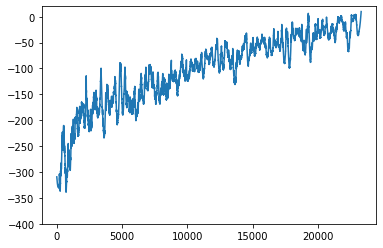

In [23]:
# reward received during training
rpR = np.vstack(episode_reward)
from scipy.signal import savgol_filter
yhat = savgol_filter(rpR[:,2], 361, 2) # window size 51, polynomial order 3
#plt.plot(rpR[:,4])
plt.figure(figsize=(6,4))
plt.plot(yhat)
plt.ylim([-400,20])

In [ ]:
vvr = np.stack(validation_reward)
plt.figure(figsize=(6,4))
plt.plot(vvr[:,1])
plt.ylabel('Validation Acc (non-Cx)')
plt.show()

In [ ]:
# histogram of Q values last 10 episodes
epn = -1
mmat = allEpData
episQ = np.stack(mmat[epn][:,0])[:,]
episY = mmat[epn][:,4]*10+10
episC = mmat[epn][:,5]*10+10
episTau = mmat[epn][:,1]
# print (episY)

plt.figure(figsize=(20,10))
plt.rcParams["figure.figsize"] = (20,10)
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(episY, label='GT')
ax1.plot(episTau, label='Tau', color='black')
#ax1.plot(episC+1, label='pi(s)', color='cyan')
ax1.legend(loc='best')

ax2.plot(episQ[:,0], label='A1')
ax2.plot(episQ[:,1], label='A2')
ax2.plot(episQ[:,2], label='A3')
ax2.plot(episQ[:,3], label='A4')
ax2.plot(episQ[:,4], label='A5')
ax2.plot(episQ[:,5], label='Ax')
ax2.set_ylim([-4,5])
ax2.legend(loc='best')

In [18]:
def remove_duplicates(arr): 
    final_list = [] 
    gt_tr = []
    final_list.append(arr[0])     
    for i in range(1,arr.shape[0]): 
        if arr[i] != arr[i-1]:
            final_list.append(arr[i])     
            if arr[i] != num_camera-1:
                gt_tr.append(arr[i])
    return final_list, gt_tr

In [31]:
seq_len = 20
h_len = seq_len

In [67]:
#policy_net = torch.load('./EpData/policy_db4_3rep_del_rareFreq_ep5k_1201')
policy_net.load_state_dict(torch.load('./models/policy_MM_db4_seq20_3201')['state_dict'])

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [68]:
policy_net.eval()
req_inc = 0
render = False
_,acc,_,numTR = test_func(pTest,iloc='fix',eloc='last', fixLoc=2, isdebug=0, req_inc=req_inc)
tr_acc = 0
avg_tr_captured = []
A,P,R,F, ttr = [],[],[],[],[]
A_onlytr,P_onlytr,R_onlytr = [],[],[]
nfr = []
for i in range(len(acc)):
    print ('Person: ',i)
    gt = np.array([d[0] for d in acc[i]])
    pr = np.array([d[1] for d in acc[i]])
    g = gt #t[gt != num_camera-1]
    p = pr #r[gt != num_camera-1]
    
    dups,gt_tr = remove_duplicates(g)
    print ('Transitions: ', dups)
    print ('GT transitions: ', len(gt_tr))
    print ('Transitions captured: ', numTR[i])
    if len(gt_tr) != 0:
        avg_tr_captured.append((numTR[i],len(gt_tr)))
        contains_tr = 1
    else:
        print ('')
        contains_tr = 0
        #continue
    
    # plot transitions
    #afc.plot_color_transitions(p,g)
    # MCTA and number of frames
    if req_inc == 1:
        ac,pr,re,fr,tr = afc.compute_APRF_one_person_sct_ict(p,g)
    else:
        ac,pr,re,fr,tr = afc.compute_APRF_one_person_sct_ict(p,g)
        
    if contains_tr == 1:
        A_onlytr.append(ac)
        P_onlytr.append(pr)
        R_onlytr.append(re)
    A.append(ac)
    P.append(pr)
    R.append(re)
    F.append(fr)
    ttr.append(tr)
    print ('A,P,R: ', ac,pr,re)
    f = afc.compute_num_frames(p,g)
    nfr.append(f)
    print ('Num frames: ', f)
    # Accuracy
    tacc = np.sum(g==p, dtype=np.float)/g.shape[0]
    tr_acc += tacc
    print ('Accuracy: ',tacc)
print (tr_acc/len(A))
print ('Average (only transitions) A,P,R', np.mean(A_onlytr),np.mean(P_onlytr),np.mean(R_onlytr))
print ('Average (all targets) A,P,R,F, ttr', np.mean(A),np.mean(P),np.mean(R),np.mean(F), ttr)
print (np.sum(nfr))

Initial position:  [    4 25201    10    93    37    70]
Initial position:  [  0 932 291  90  27  86]
Initial position:  [    2 23661   253    93    36    68]
Initial position:  [   3 2762   43   54   16   58]
Initial position:  [  3   2 278  79  35 106]
Initial position:  [    4 32592   150    72     9    25]
Initial position:  [   3 1342  253   84   48  115]
Initial position:  [    4 27637   293    89    22    75]
Initial position:  [    3 18785   244    88    67   113]
Initial position:  [   4 8473  154   74   14   43]
Initial position:  [    2 23111   173    97    46   142]
Initial position:  [   1 8880  282   72   35  113]
Initial position:  [   4 6779  289   82   24   74]
Initial position:  [   4 8297  134   68   21   43]
Initial position:  [   0 3838  288   98   30   87]
Initial position:  [    0 13822   300    93    18    57]
Initial position:  [    4 12824   101    87    29    81]
Initial position:  [    4 20574   146    66    11    31]
Initial position:  [    4 34365    43   

In [69]:
a = np.stack(avg_tr_captured)
print (np.mean(a[:,0]/a[:,1]))
print (sum(a[:,0])/sum(a[:,1]))

0.4267774668395787
0.504


### Test function

In [ ]:
backup_fname = '/media/win/HRLhkl/Q_CamSel_3L_l4_st200_db3_1tCont_2'
hkl.dump([[episode_reward, running_reward]], backup_fname+'_variables.hkl')

In [ ]:
1/np.log(600*12)

In [ ]:
pp = 1
np.max(pTest[pp][1:,1] - pTest[pp][0:-1,1])